In [8]:
import tensorflow as tf
#import tensorflow_probability as tfp
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
import pandas as pd

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


$\frac{\partial p(x,t)}{\partial t} = \frac{\partial}{\partial x}\left[\frac{m\omega^2}{\gamma} x \,p(x,t) + D \frac{\partial p(x,t)}{\partial x}\right] \qquad A= \frac{m\omega^2}{\gamma}= \frac{k}{\gamma}$ 

# *Data Prep*

Training and Testing data is prepared from the solution file

In [17]:
from scipy.stats import norm
from scipy import constants

Temperature= 300 # K
viscosity=1e-3 # Kg / (m * s) 
radius=20e-10 # m
gamma=6*np.pi*viscosity*radius # Kg / s
k= 3e-7 # Kg / s^2; 10GHz for frequency and 3e-26 Kg for mass
A= k/gamma # s ^ -1
D= Temperature*constants.k / gamma # m^2 / s
print(f"{gamma = } [Kg/s]")
print(f"{k = } [Kg/s^2]")
print(f"kB = {constants.k} [J/K]")
print(f"{A = } [s^-1], {D = } [m^2/s]")


# Change of units m -> µm
#                 s -> ms
# such that A ~ O(1), D ~ O(0.1)
A = A * 1e-3 # s^-1 -> ms^-1 
D = D * 1e-3 * 1e+12 # m^2/s -> µm^2/ms
#collocation points for every position and every time
x_lower = -0.1
x_upper = 0.25
dx = (x_upper - x_lower) / 350
x = np.linspace(x_lower, x_upper, 350) # µm line
t_lower = 0
t_upper = 2 * D # Typical time is D
N_steps=200
t = np.linspace(t_lower, t_upper, N_steps) # ms interval
X, T = np.meshgrid(x,t)
# Initial Condition
psol=np.zeros((len(x),len(t)))
psol[:,0]=real[0]
print(f"{A = } [ms^-1], {D = } [µm^2/ms]")

maxiter = 25000

gamma = 3.769911184307752e-11 [Kg/s]
k = 3e-07 [Kg/s^2]
kB = 1.380649e-23 [J/K]
A = 7957.7471545947665 [s^-1], D = 1.098685565124411e-10 [m^2/s]
A = 7.957747154594767 [ms^-1], D = 0.1098685565124411 [µm^2/ms]


In [18]:
import pickle
filename = r'D:\PINNs-Review\src\OUR CODE\simulations\numerical_solution.sav'
real = pickle.load(open(filename, 'rb'))

# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [19]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_p_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Domain bounds
low_bound = np.array([x_lower, t_lower]) 
up_bound = np.array([x_upper, t_upper])

'''
stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
p = psol.flatten('F')

In [20]:
def trainingdata(N_bc, N_ic, N_f):
    """ Initial Condition"""

    #Initial Condition -1 =< x =<1 and t = 0  
    all_ic_x = np.vstack((X[0,:], T[0,:])).T
    all_ic_p = psol[:,0].reshape(len(psol[:,0]),1)
     
    '''Boundary Conditions'''

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.vstack((X[:,0], T[:,0])).T
    bottomedge_p = psol[-1,:].reshape(len(psol[-1,:]),1)

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.vstack((X[:,-1], T[:,0])).T
    topedge_p = psol[0,:].reshape(len(psol[0,:]),1)


    all_bc_x=np.vstack([bottomedge_x, topedge_x])
    # Reflecting conditions do not use the value of p
    #all_bc_p_train = np.vstack([ bottomedge_p, topedge_p])  

    #choose random N_bc and N:ic points for training
    index_bc = np.random.choice(all_bc_x.shape[0], N_bc, replace=False) 
    index_ic = np.random.choice(all_ic_x.shape[0], N_ic, replace=False)

    x_bc_train = all_bc_x[index_bc, :] 
    x_ic_train = all_ic_x[index_ic, :] 
    p_ic_train = all_ic_p[index_ic,:]    

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x_f_train = low_bound + (up_bound-low_bound)*lhs(2,N_f)
    # Do we select boundary and initial points also for f calculation?
    #   Only god knows 
    #x_f_train = np.vstack((x_f_train, x_bc_train, x_ic_train))

    '''Normalization Instants'''
    x_norm_instant = np.vstack((X[100,:],
                                T[100,:])).T
    
    return x_f_train, x_bc_train, x_ic_train, p_ic_train, x_norm_instant


# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [21]:
extra_features = ["xLower-0.1","xUpper0.25","micrometers_miliseconds","k1e-7","r1e-20"]
print("Training with extra features:", extra_features)
additional_constraints = []
print("Training with extra constraints:", additional_constraints)


def save_train_history(NN):
    TRAIN_HISTORY = NN.get_training_history()
    data_filename = "./data/TRAIN_HISTORY_"
    if len(additional_constraints) != 0:
        for constrain in additional_constraints:
            data_filename = data_filename + constrain + "_"
    data_filename = data_filename + f"IC{N_ic}_BC{N_bc}_f{N_f}_t{t_upper}_iter{maxiter}"
    if len(extra_features) != 0:
        for feat in extra_features:
            data_filename = data_filename + "_" + feat
    print("Saving", data_filename, "...")
    pd.DataFrame(TRAIN_HISTORY).to_csv(data_filename + ".csv")

def save_model_weights(NN):
    model_filename = "./models/MODEL_WEIGHTS_"
    if len(additional_constraints) != 0:
        for constrain in additional_constraints:
            model_filename = model_filename + constrain + "_"
    model_filename = model_filename + f"IC{N_ic}_BC{N_bc}_f{N_f}_t{t_upper}_iter{maxiter}"
    if len(extra_features) != 0:
        for feat in extra_features:
            model_filename = model_filename + "_" + feat
    print("Saving", model_filename, "...")
    np.savetxt(model_filename + ".txt", NN.get_weights().numpy())

Training with extra features: ['xLower-0.1', 'xUpper0.25', 'micrometers_miliseconds', 'k1e-7', 'r1e-20']
Training with extra constraints: []


In [22]:
class Sequentialmodel(tf.Module): 
    def __init__(self,
                 layers,
                 low_bound, up_bound,
                 x_ic_train, p_ic_train,
                 x_bc_train,
                 x_f_train,
                 x_norm_instants,
                 name = "FP-PINN",
                 A = 10,
                 D = 0.1,
                 doPrint = True,
                 additional_constraints = ()):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        self.epoch = 0
        self.doPrint = doPrint
        self.callback_after_n = 1000
        self.history = {"epoch": [],
                        "Total loss": [],
                        "IC loss": [],
                        "BC loss": [],
                        "f loss": [],
                        "Pr loss": [],
                        "Norm loss": [],
                        "Equi loss": []}


        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    
    def evaluate(self,x):
        
        x = (x-low_bound)/(up_bound-low_bound) # Normalization
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def set_training_history(self, path):
        history = pd.read_csv(path)
        self.history["epoch"] = list(history["epoch"])
        self.epoch = self.history["epoch"][-1]
        self.history["Total loss"] = list(history["Total loss"])
        self.history["IC loss"] = list(history["IC loss"])
        self.history["BC loss"] = list(history["BC loss"])
        self.history["f loss"] = list(history["f loss"])
        self.history["Pr loss"] = list(history["Pr loss"])
        self.history["Norm loss"] = list(history["Norm loss"])
        self.history["Equi loss"] = list(history["Equi loss"])

    def get_training_history(self):
        return self.history

    
    def set_epoch(self, epoch):
        self.epoch = epoch
        
    def get_epoch(self):
        return self.epoch


    # Satisfy the IC
    def loss_IC(self, ic_points, p_ic_train):
        return tf.reduce_mean(tf.square(p_ic_train - self.evaluate(ic_points))) # MSE_ic


    # Reflecting boundary
    def loss_BC(self, bc_points):
        variable_bc = tf.Variable(bc_points, dtype = 'float64', trainable = False)

        x_bc = variable_bc[:,0:1]
        t_bc = variable_bc[:,1:2]
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_bc)
            tape.watch(t_bc)

            tensor_bc = tf.stack([x_bc[:,0], t_bc[:,0]], axis=1)   

            output_p_bc = self.evaluate(tensor_bc)
        p_x = tape.gradient(output_p_bc,x_bc)  #more efficient out of the context

        del tape

        J = -1 * (A * x_bc * output_p_bc + D * p_x)

        return tf.reduce_mean(tf.square(J)) # MSE_bc

    # Satisfy the PDE at the collocation points
    def loss_PDE(self, collocation_points):
    
        variable_collocation = tf.Variable(collocation_points, dtype = 'float64', trainable = False)

        x_f = variable_collocation[:,0:1]
        t_f = variable_collocation[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            tensor_collocation = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            output_p_collocation = self.evaluate(tensor_collocation)
            p_x = tape.gradient(output_p_collocation,x_f) #inside the context bc we need it for higher derivative
        p_t = tape.gradient(output_p_collocation,t_f)    
        p_xx = tape.gradient(p_x, x_f)  

        del tape

        f = p_t - A * output_p_collocation - A * x_f * p_x - D * p_xx

        return tf.reduce_mean(tf.square(f)) # MSE_f


    # Satisfy probabilty norm at some instants
    def loss_NORM(self, instants):
        o = self.evaluate(instants)
        return tf.abs(tf.reduce_sum(o) * dx - 1.0) # ME |norm - 1|

    # Must be Boltzmann at t >> 1 with ß * m * w ** 2 = A / D
    def loss_EQUI(self):
        # Typical time is ln(2) / A ≈ 0.69 / A
        t_large = 10 * (0.69 / A) * np.ones(256).reshape(256, 1)
        x_domain = np.linspace(low_bound[0], up_bound[0], 256).reshape(256, 1)
        x_at_large_t = tf.stack([x_domain[:,0], t_large[:,0]], axis=1)
        output = self.evaluate(x_at_large_t)
        boltzmann_dist = tf.exp(-1 * (A/(2*D)) * x_domain ** 2)
        z = tf.reduce_sum(boltzmann_dist) * dx
        boltzmann_dist = boltzmann_dist / z
        # L2 norm (Boltzmann_dist - output)
        return tf.reduce_mean(tf.square(boltzmann_dist - output) * dx)


    # Satisfy p > 0 at IC and the collocation points
    def loss_PROB(self, ic_points, collocation_points):
        o1 = self.evaluate(ic_points)
        o2 = self.evaluate(collocation_points)
        negatives = tf.where(tf.greater_equal(o1, 0.),
                             tf.zeros_like(o1),
                             o1)
        loss_pr = tf.abs(tf.reduce_mean(negatives)) # MSE (p < 0) at IC
        negatives = tf.where(tf.greater_equal(o2, 0.),
                             tf.zeros_like(o2),
                             o2)
        loss_pr = loss_pr + tf.abs(tf.reduce_mean(negatives)) # MSE (p < 0) at collocation
        return loss_pr


    def loss(self):
        loss_ic = self.loss_IC(x_ic_train, p_ic_train)
        loss_bc = self.loss_BC(x_bc_train)
        loss_f = self.loss_PDE(x_f_train)
        loss_prob = self.loss_PROB(x_ic_train, x_f_train)
        loss_norm = self.loss_NORM(x_norm_instants)
        loss_equi = self.loss_EQUI()
        loss = loss_ic + loss_bc + loss_f
        if "prob" in additional_constraints:
            loss = loss + loss_prob
        if "norm" in additional_constraints:
            loss = loss + loss_norm
        if "equi" in additional_constraints:
            loss = loss + loss_equi
        return loss, loss_ic, loss_bc, loss_f, loss_prob, loss_norm, loss_equi
    
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            total_loss, loss_ic, loss_bc, loss_f, loss_pr, loss_norm, loss_equi = self.loss()
            grads = tape.gradient(total_loss,self.trainable_variables)
        
        if self.doPrint:
            self.epoch += 1
            tf.print(f"epoch: {self.epoch}", f"- Total: {total_loss:5.4e}", f"IC: {loss_ic:5.4e}",
                     f"BC: {loss_bc:5.4e}", f"f: {loss_f:5.4e}", f"Norm: {loss_norm:5.4e}", f"equi: {loss_equi:5.4e}")
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        self.history["epoch"].append(self.epoch)
        self.history["Total loss"].append(float(total_loss))
        self.history["IC loss"].append(float(loss_ic))
        self.history["BC loss"].append(float(loss_bc))
        self.history["f loss"].append(float(loss_f))
        self.history["Pr loss"].append(float(loss_pr))
        self.history["Norm loss"].append(float(loss_norm))
        self.history["Equi loss"].append(float(loss_equi))

        return total_loss.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
        if self.epoch % self.callback_after_n == 0:
            save_train_history(self)
            save_model_weights(self)



# *Solution Plot*

In [44]:
def differenceplot(u_pred, real,X_u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])

    h = ax.imshow(np.absolute(u_pred-real), interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    #ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x, u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.plot(x, real.T[0,:], 'b', linewidth = 2, label = 'Real')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([x_lower ,x_upper])
    #ax.set_ylim([-0.01, 0.1])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[int(0.5*len(t)),:], 'r', linewidth = 2, label = 'Prediction')
    ax.plot(x,real.T[int(0.5*len(t)),:], 'b', linewidth = 2, label = 'Real')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')
    #ax.axis('square')
    ax.set_xlim([x_lower, x_upper])
    ax.set_ylim([-0.01, 0.1])
    ax.set_title('$t = {}s$'.format(int(0.5*len(t))/1000), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[int(0.75*len(t)),:], 'r', linewidth = 2, label = 'Prediction')
    ax.plot(x,real.T[int(0.75*len(t)),:], 'b', linewidth = 2, label = 'Real')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')
    #ax.axis('square')
    ax.set_xlim([x_lower, x_upper])
    ax.set_ylim([-0.01, 0.1])    
    ax.set_title('$t = {}s$'.format(int(0.75*len(t))/1000), fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [25]:
N_bc = 100 #Total number of boundary conditions points
N_ic = 100 #Total number of initial condition points
N_f = 1000 #Total number of collocation points

# Training data
x_f_train, x_bc_train, x_ic_train, p_ic_train, x_norm_instants = trainingdata(N_bc, N_ic, N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers, low_bound, up_bound,
                      x_ic_train, p_ic_train,
                      x_bc_train,
                      x_f_train,
                      x_norm_instants,
                      A=A,
                      D=D)

init_params = PINN.get_weights().numpy()
#init_params = np.loadtxt("./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20.txt")
#PINN.set_weights(init_params)
#PINN.set_training_history("./data/TRAIN_HISTORY_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20.csv")


start_time = time.time() 
# train the model with Scipy L-BFGS optimizer
#tfp.optimizer.lbfgs_minimize
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': max(maxiter - PINN.get_epoch(), 0),
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)



epoch: 1 - Total: 6.5064e+00 IC: 3.1591e-02 BC: 3.9054e-01 f: 6.0843e+00 Norm: 1.1423e+00 equi: 2.2430e-02
epoch: 2 - Total: 2.6880e+02 IC: 3.9296e+00 BC: 1.4071e+01 f: 2.5080e+02 Norm: 1.9966e-01 equi: 5.7648e-03
epoch: 3 - Total: 2.4596e+00 IC: 2.4597e-02 BC: 1.0183e-02 f: 2.4248e+00 Norm: 1.0070e+00 equi: 1.9399e-02
epoch: 4 - Total: 1.1238e+00 IC: 4.0414e-03 BC: 1.2310e-02 f: 1.1075e+00 Norm: 1.0294e+00 equi: 1.9639e-02
epoch: 5 - Total: 4.3887e-01 IC: 3.0179e-04 BC: 9.3259e-03 f: 4.2924e-01 Norm: 1.0259e+00 equi: 1.9238e-02
epoch: 6 - Total: 1.0890e-01 IC: 2.8534e-04 BC: 2.4810e-03 f: 1.0613e-01 Norm: 1.0062e+00 equi: 1.8479e-02
epoch: 7 - Total: 2.7666e-02 IC: 1.8920e-04 BC: 1.7785e-03 f: 2.5698e-02 Norm: 9.9655e-01 equi: 1.8019e-02
epoch: 8 - Total: 1.3610e-02 IC: 2.6236e-04 BC: 1.7194e-03 f: 1.1628e-02 Norm: 9.9256e-01 equi: 1.7816e-02
epoch: 9 - Total: 1.3036e-02 IC: 2.2100e-04 BC: 1.6001e-03 f: 1.1215e-02 Norm: 9.9276e-01 equi: 1.7811e-02
epoch: 10 - Total: 1.2239e-02 IC: 1.7

epoch: 77 - Total: 2.2611e-05 IC: 1.9498e-05 BC: 7.9711e-07 f: 2.3157e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 78 - Total: 2.2610e-05 IC: 1.9485e-05 BC: 7.9912e-07 f: 2.3257e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 79 - Total: 2.2610e-05 IC: 1.9482e-05 BC: 8.0171e-07 f: 2.3260e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 80 - Total: 2.2610e-05 IC: 1.9481e-05 BC: 8.0383e-07 f: 2.3251e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 81 - Total: 2.2609e-05 IC: 1.9477e-05 BC: 8.1011e-07 f: 2.3220e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 82 - Total: 2.2608e-05 IC: 1.9472e-05 BC: 8.1850e-07 f: 2.3174e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 83 - Total: 2.2604e-05 IC: 1.9462e-05 BC: 8.3238e-07 f: 2.3092e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 84 - Total: 2.2594e-05 IC: 1.9446e-05 BC: 8.5159e-07 f: 2.2972e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 85 - Total: 2.2571e-05 IC: 1.9415e-05 BC: 8.7442e-07 f: 2.2817e-06 Norm: 9.9962e-01 equi: 1.8205e-02
epoch: 86 - Total: 2.2516e-0

epoch: 153 - Total: 2.0307e-05 IC: 1.6766e-05 BC: 5.3501e-07 f: 3.0061e-06 Norm: 9.9942e-01 equi: 1.8210e-02
epoch: 154 - Total: 2.0305e-05 IC: 1.6767e-05 BC: 5.3181e-07 f: 3.0066e-06 Norm: 9.9942e-01 equi: 1.8209e-02
epoch: 155 - Total: 2.0299e-05 IC: 1.6752e-05 BC: 5.3598e-07 f: 3.0107e-06 Norm: 9.9941e-01 equi: 1.8208e-02
epoch: 156 - Total: 2.0282e-05 IC: 1.6725e-05 BC: 5.3456e-07 f: 3.0220e-06 Norm: 9.9940e-01 equi: 1.8208e-02
epoch: 157 - Total: 2.0236e-05 IC: 1.6598e-05 BC: 5.6044e-07 f: 3.0777e-06 Norm: 9.9938e-01 equi: 1.8207e-02
epoch: 158 - Total: 2.0147e-05 IC: 1.6524e-05 BC: 5.0831e-07 f: 3.1148e-06 Norm: 9.9936e-01 equi: 1.8209e-02
epoch: 159 - Total: 2.0497e-05 IC: 1.6179e-05 BC: 7.2599e-07 f: 3.5919e-06 Norm: 9.9930e-01 equi: 1.8212e-02
epoch: 160 - Total: 2.0094e-05 IC: 1.6440e-05 BC: 5.5626e-07 f: 3.0977e-06 Norm: 9.9934e-01 equi: 1.8210e-02
epoch: 161 - Total: 2.0042e-05 IC: 1.6451e-05 BC: 6.8388e-07 f: 2.9079e-06 Norm: 9.9932e-01 equi: 1.8213e-02
epoch: 162 - Total:

epoch: 229 - Total: 1.6924e-05 IC: 1.1433e-05 BC: 1.2946e-06 f: 4.1969e-06 Norm: 9.9921e-01 equi: 1.8196e-02
epoch: 230 - Total: 1.6923e-05 IC: 1.1386e-05 BC: 1.3096e-06 f: 4.2271e-06 Norm: 9.9921e-01 equi: 1.8195e-02
epoch: 231 - Total: 1.6922e-05 IC: 1.1352e-05 BC: 1.3208e-06 f: 4.2496e-06 Norm: 9.9920e-01 equi: 1.8195e-02
epoch: 232 - Total: 1.6922e-05 IC: 1.1342e-05 BC: 1.3230e-06 f: 4.2566e-06 Norm: 9.9920e-01 equi: 1.8194e-02
epoch: 233 - Total: 1.6921e-05 IC: 1.1343e-05 BC: 1.3217e-06 f: 4.2565e-06 Norm: 9.9920e-01 equi: 1.8194e-02
epoch: 234 - Total: 1.6919e-05 IC: 1.1348e-05 BC: 1.3176e-06 f: 4.2535e-06 Norm: 9.9919e-01 equi: 1.8194e-02
epoch: 235 - Total: 1.6915e-05 IC: 1.1357e-05 BC: 1.3115e-06 f: 4.2457e-06 Norm: 9.9919e-01 equi: 1.8193e-02
epoch: 236 - Total: 1.6902e-05 IC: 1.1368e-05 BC: 1.3022e-06 f: 4.2319e-06 Norm: 9.9919e-01 equi: 1.8193e-02
epoch: 237 - Total: 1.6871e-05 IC: 1.1362e-05 BC: 1.2984e-06 f: 4.2097e-06 Norm: 9.9918e-01 equi: 1.8193e-02
epoch: 238 - Total:

epoch: 305 - Total: 1.5311e-05 IC: 1.0410e-05 BC: 1.8518e-06 f: 3.0492e-06 Norm: 9.9928e-01 equi: 1.8227e-02
epoch: 306 - Total: 1.5309e-05 IC: 1.0404e-05 BC: 1.8364e-06 f: 3.0684e-06 Norm: 9.9928e-01 equi: 1.8226e-02
epoch: 307 - Total: 1.5306e-05 IC: 1.0403e-05 BC: 1.8282e-06 f: 3.0749e-06 Norm: 9.9928e-01 equi: 1.8225e-02
epoch: 308 - Total: 1.5301e-05 IC: 1.0415e-05 BC: 1.8227e-06 f: 3.0633e-06 Norm: 9.9928e-01 equi: 1.8224e-02
epoch: 309 - Total: 1.5292e-05 IC: 1.0462e-05 BC: 1.8123e-06 f: 3.0175e-06 Norm: 9.9928e-01 equi: 1.8224e-02
epoch: 310 - Total: 1.5283e-05 IC: 1.0558e-05 BC: 1.7910e-06 f: 2.9339e-06 Norm: 9.9928e-01 equi: 1.8224e-02
epoch: 311 - Total: 1.5276e-05 IC: 1.0647e-05 BC: 1.7572e-06 f: 2.8722e-06 Norm: 9.9929e-01 equi: 1.8223e-02
epoch: 312 - Total: 1.5278e-05 IC: 1.0782e-05 BC: 1.6969e-06 f: 2.7994e-06 Norm: 9.9929e-01 equi: 1.8225e-02
epoch: 313 - Total: 1.5273e-05 IC: 1.0705e-05 BC: 1.7319e-06 f: 2.8359e-06 Norm: 9.9929e-01 equi: 1.8224e-02
epoch: 314 - Total:

epoch: 381 - Total: 1.4300e-05 IC: 1.0008e-05 BC: 2.2154e-06 f: 2.0765e-06 Norm: 9.9921e-01 equi: 1.8222e-02
epoch: 382 - Total: 1.4297e-05 IC: 1.0017e-05 BC: 2.1902e-06 f: 2.0896e-06 Norm: 9.9921e-01 equi: 1.8221e-02
epoch: 383 - Total: 1.4294e-05 IC: 1.0038e-05 BC: 2.1592e-06 f: 2.0971e-06 Norm: 9.9921e-01 equi: 1.8221e-02
epoch: 384 - Total: 1.4292e-05 IC: 1.0063e-05 BC: 2.1362e-06 f: 2.0920e-06 Norm: 9.9922e-01 equi: 1.8221e-02
epoch: 385 - Total: 1.4290e-05 IC: 1.0079e-05 BC: 2.1263e-06 f: 2.0846e-06 Norm: 9.9922e-01 equi: 1.8222e-02
epoch: 386 - Total: 1.4290e-05 IC: 1.0090e-05 BC: 2.1176e-06 f: 2.0826e-06 Norm: 9.9922e-01 equi: 1.8222e-02
epoch: 387 - Total: 1.4290e-05 IC: 1.0093e-05 BC: 2.1172e-06 f: 2.0799e-06 Norm: 9.9922e-01 equi: 1.8222e-02
epoch: 388 - Total: 1.4290e-05 IC: 1.0099e-05 BC: 2.1127e-06 f: 2.0776e-06 Norm: 9.9922e-01 equi: 1.8222e-02
epoch: 389 - Total: 1.4289e-05 IC: 1.0112e-05 BC: 2.1039e-06 f: 2.0729e-06 Norm: 9.9922e-01 equi: 1.8222e-02
epoch: 390 - Total:

epoch: 457 - Total: 1.3840e-05 IC: 9.0279e-06 BC: 2.0864e-06 f: 2.7255e-06 Norm: 9.9909e-01 equi: 1.8273e-02
epoch: 458 - Total: 1.3839e-05 IC: 9.0087e-06 BC: 2.0893e-06 f: 2.7407e-06 Norm: 9.9909e-01 equi: 1.8273e-02
epoch: 459 - Total: 1.3837e-05 IC: 8.9868e-06 BC: 2.0890e-06 f: 2.7616e-06 Norm: 9.9908e-01 equi: 1.8273e-02
epoch: 460 - Total: 1.3835e-05 IC: 8.9625e-06 BC: 2.0863e-06 f: 2.7862e-06 Norm: 9.9908e-01 equi: 1.8274e-02
epoch: 461 - Total: 1.3832e-05 IC: 8.9487e-06 BC: 2.0681e-06 f: 2.8150e-06 Norm: 9.9908e-01 equi: 1.8275e-02
epoch: 462 - Total: 1.3828e-05 IC: 8.9353e-06 BC: 2.0559e-06 f: 2.8371e-06 Norm: 9.9908e-01 equi: 1.8276e-02
epoch: 463 - Total: 1.3826e-05 IC: 8.9501e-06 BC: 2.0139e-06 f: 2.8623e-06 Norm: 9.9909e-01 equi: 1.8278e-02
epoch: 464 - Total: 1.3825e-05 IC: 8.9726e-06 BC: 2.0166e-06 f: 2.8358e-06 Norm: 9.9909e-01 equi: 1.8277e-02
epoch: 465 - Total: 1.3821e-05 IC: 8.9719e-06 BC: 2.0165e-06 f: 2.8327e-06 Norm: 9.9909e-01 equi: 1.8277e-02
epoch: 466 - Total:

epoch: 533 - Total: 1.3676e-05 IC: 9.3312e-06 BC: 1.4746e-06 f: 2.8703e-06 Norm: 9.9910e-01 equi: 1.8267e-02
epoch: 534 - Total: 1.3676e-05 IC: 9.3299e-06 BC: 1.4717e-06 f: 2.8740e-06 Norm: 9.9910e-01 equi: 1.8268e-02
epoch: 535 - Total: 1.3675e-05 IC: 9.3389e-06 BC: 1.4612e-06 f: 2.8749e-06 Norm: 9.9910e-01 equi: 1.8267e-02
epoch: 536 - Total: 1.3674e-05 IC: 9.3571e-06 BC: 1.4559e-06 f: 2.8612e-06 Norm: 9.9910e-01 equi: 1.8266e-02
epoch: 537 - Total: 1.3674e-05 IC: 9.3675e-06 BC: 1.4544e-06 f: 2.8519e-06 Norm: 9.9910e-01 equi: 1.8266e-02
epoch: 538 - Total: 1.3673e-05 IC: 9.3859e-06 BC: 1.4668e-06 f: 2.8204e-06 Norm: 9.9910e-01 equi: 1.8265e-02
epoch: 539 - Total: 1.3674e-05 IC: 9.4318e-06 BC: 1.4528e-06 f: 2.7895e-06 Norm: 9.9911e-01 equi: 1.8264e-02
epoch: 540 - Total: 1.3673e-05 IC: 9.4021e-06 BC: 1.4627e-06 f: 2.8079e-06 Norm: 9.9910e-01 equi: 1.8265e-02
epoch: 541 - Total: 1.3672e-05 IC: 9.4088e-06 BC: 1.4613e-06 f: 2.8018e-06 Norm: 9.9911e-01 equi: 1.8264e-02
epoch: 542 - Total:

epoch: 609 - Total: 1.3591e-05 IC: 9.6899e-06 BC: 1.5452e-06 f: 2.3556e-06 Norm: 9.9914e-01 equi: 1.8244e-02
epoch: 610 - Total: 1.3583e-05 IC: 9.7009e-06 BC: 1.5450e-06 f: 2.3368e-06 Norm: 9.9914e-01 equi: 1.8244e-02
epoch: 611 - Total: 1.3579e-05 IC: 9.7153e-06 BC: 1.5566e-06 f: 2.3068e-06 Norm: 9.9914e-01 equi: 1.8244e-02
epoch: 612 - Total: 1.3583e-05 IC: 9.7375e-06 BC: 1.5292e-06 f: 2.3167e-06 Norm: 9.9916e-01 equi: 1.8244e-02
epoch: 613 - Total: 1.3567e-05 IC: 9.7219e-06 BC: 1.5462e-06 f: 2.2992e-06 Norm: 9.9915e-01 equi: 1.8244e-02
epoch: 614 - Total: 1.3593e-05 IC: 9.6985e-06 BC: 1.5976e-06 f: 2.2968e-06 Norm: 9.9914e-01 equi: 1.8245e-02
epoch: 615 - Total: 1.3564e-05 IC: 9.7162e-06 BC: 1.5580e-06 f: 2.2903e-06 Norm: 9.9915e-01 equi: 1.8244e-02
epoch: 616 - Total: 1.3558e-05 IC: 9.6825e-06 BC: 1.5895e-06 f: 2.2857e-06 Norm: 9.9915e-01 equi: 1.8243e-02
epoch: 617 - Total: 1.3552e-05 IC: 9.6361e-06 BC: 1.6288e-06 f: 2.2871e-06 Norm: 9.9915e-01 equi: 1.8241e-02
epoch: 618 - Total:

epoch: 685 - Total: 1.3140e-05 IC: 8.6680e-06 BC: 1.5585e-06 f: 2.9130e-06 Norm: 9.9902e-01 equi: 1.8271e-02
epoch: 686 - Total: 1.3139e-05 IC: 8.6605e-06 BC: 1.5617e-06 f: 2.9170e-06 Norm: 9.9902e-01 equi: 1.8272e-02
epoch: 687 - Total: 1.3139e-05 IC: 8.6506e-06 BC: 1.5652e-06 f: 2.9231e-06 Norm: 9.9902e-01 equi: 1.8272e-02
epoch: 688 - Total: 1.3139e-05 IC: 8.6457e-06 BC: 1.5685e-06 f: 2.9244e-06 Norm: 9.9902e-01 equi: 1.8272e-02
epoch: 689 - Total: 1.3138e-05 IC: 8.6368e-06 BC: 1.5786e-06 f: 2.9223e-06 Norm: 9.9902e-01 equi: 1.8272e-02
epoch: 690 - Total: 1.3137e-05 IC: 8.6406e-06 BC: 1.5840e-06 f: 2.9123e-06 Norm: 9.9902e-01 equi: 1.8272e-02
epoch: 691 - Total: 1.3136e-05 IC: 8.6473e-06 BC: 1.5944e-06 f: 2.8937e-06 Norm: 9.9902e-01 equi: 1.8273e-02
epoch: 692 - Total: 1.3135e-05 IC: 8.6501e-06 BC: 1.6027e-06 f: 2.8820e-06 Norm: 9.9902e-01 equi: 1.8274e-02
epoch: 693 - Total: 1.3135e-05 IC: 8.6482e-06 BC: 1.6066e-06 f: 2.8797e-06 Norm: 9.9902e-01 equi: 1.8275e-02
epoch: 694 - Total:

epoch: 761 - Total: 1.2626e-05 IC: 8.3567e-06 BC: 1.4017e-06 f: 2.8681e-06 Norm: 9.9894e-01 equi: 1.8294e-02
epoch: 762 - Total: 1.2616e-05 IC: 8.3846e-06 BC: 1.3667e-06 f: 2.8648e-06 Norm: 9.9894e-01 equi: 1.8293e-02
epoch: 763 - Total: 1.2615e-05 IC: 8.3213e-06 BC: 1.3704e-06 f: 2.9233e-06 Norm: 9.9893e-01 equi: 1.8291e-02
epoch: 764 - Total: 1.2606e-05 IC: 8.3614e-06 BC: 1.3644e-06 f: 2.8805e-06 Norm: 9.9894e-01 equi: 1.8292e-02
epoch: 765 - Total: 1.2580e-05 IC: 8.4041e-06 BC: 1.3098e-06 f: 2.8661e-06 Norm: 9.9894e-01 equi: 1.8288e-02
epoch: 766 - Total: 1.2581e-05 IC: 8.3524e-06 BC: 1.3682e-06 f: 2.8607e-06 Norm: 9.9891e-01 equi: 1.8286e-02
epoch: 767 - Total: 1.2568e-05 IC: 8.3784e-06 BC: 1.3364e-06 f: 2.8529e-06 Norm: 9.9892e-01 equi: 1.8287e-02
epoch: 768 - Total: 1.2528e-05 IC: 8.4323e-06 BC: 1.3652e-06 f: 2.7306e-06 Norm: 9.9892e-01 equi: 1.8285e-02
epoch: 769 - Total: 1.2503e-05 IC: 8.4964e-06 BC: 1.3896e-06 f: 2.6174e-06 Norm: 9.9893e-01 equi: 1.8287e-02
epoch: 770 - Total:

epoch: 837 - Total: 1.2150e-05 IC: 8.1461e-06 BC: 1.3542e-06 f: 2.6494e-06 Norm: 9.9880e-01 equi: 1.8322e-02
epoch: 838 - Total: 1.2148e-05 IC: 8.1395e-06 BC: 1.3567e-06 f: 2.6519e-06 Norm: 9.9880e-01 equi: 1.8322e-02
epoch: 839 - Total: 1.2146e-05 IC: 8.1385e-06 BC: 1.3644e-06 f: 2.6429e-06 Norm: 9.9880e-01 equi: 1.8321e-02
epoch: 840 - Total: 1.2142e-05 IC: 8.1388e-06 BC: 1.3819e-06 f: 2.6212e-06 Norm: 9.9880e-01 equi: 1.8321e-02
epoch: 841 - Total: 1.2136e-05 IC: 8.1421e-06 BC: 1.4058e-06 f: 2.5886e-06 Norm: 9.9880e-01 equi: 1.8320e-02
epoch: 842 - Total: 1.2129e-05 IC: 8.1681e-06 BC: 1.4344e-06 f: 2.5265e-06 Norm: 9.9880e-01 equi: 1.8319e-02
epoch: 843 - Total: 1.2125e-05 IC: 8.1793e-06 BC: 1.4313e-06 f: 2.5142e-06 Norm: 9.9881e-01 equi: 1.8316e-02
epoch: 844 - Total: 1.2124e-05 IC: 8.1727e-06 BC: 1.4359e-06 f: 2.5150e-06 Norm: 9.9881e-01 equi: 1.8318e-02
epoch: 845 - Total: 1.2113e-05 IC: 8.1975e-06 BC: 1.4274e-06 f: 2.4883e-06 Norm: 9.9881e-01 equi: 1.8313e-02
epoch: 846 - Total:

epoch: 913 - Total: 1.1794e-05 IC: 8.4234e-06 BC: 1.1053e-06 f: 2.2657e-06 Norm: 9.9881e-01 equi: 1.8318e-02
epoch: 914 - Total: 1.1790e-05 IC: 8.4286e-06 BC: 1.0821e-06 f: 2.2793e-06 Norm: 9.9881e-01 equi: 1.8320e-02
epoch: 915 - Total: 1.1787e-05 IC: 8.4355e-06 BC: 1.0765e-06 f: 2.2754e-06 Norm: 9.9881e-01 equi: 1.8321e-02
epoch: 916 - Total: 1.1787e-05 IC: 8.4276e-06 BC: 1.0757e-06 f: 2.2841e-06 Norm: 9.9882e-01 equi: 1.8323e-02
epoch: 917 - Total: 1.1786e-05 IC: 8.4319e-06 BC: 1.0756e-06 f: 2.2780e-06 Norm: 9.9881e-01 equi: 1.8322e-02
epoch: 918 - Total: 1.1783e-05 IC: 8.4170e-06 BC: 1.0846e-06 f: 2.2816e-06 Norm: 9.9881e-01 equi: 1.8323e-02
epoch: 919 - Total: 1.1782e-05 IC: 8.4154e-06 BC: 1.0852e-06 f: 2.2818e-06 Norm: 9.9881e-01 equi: 1.8323e-02
epoch: 920 - Total: 1.1781e-05 IC: 8.4141e-06 BC: 1.0783e-06 f: 2.2887e-06 Norm: 9.9881e-01 equi: 1.8324e-02
epoch: 921 - Total: 1.1779e-05 IC: 8.4108e-06 BC: 1.0676e-06 f: 2.3010e-06 Norm: 9.9880e-01 equi: 1.8324e-02
epoch: 922 - Total:

epoch: 989 - Total: 1.1209e-05 IC: 8.1597e-06 BC: 1.1859e-06 f: 1.8636e-06 Norm: 9.9878e-01 equi: 1.8337e-02
epoch: 990 - Total: 1.1196e-05 IC: 8.1775e-06 BC: 1.2076e-06 f: 1.8110e-06 Norm: 9.9878e-01 equi: 1.8337e-02
epoch: 991 - Total: 1.1185e-05 IC: 8.1526e-06 BC: 1.2263e-06 f: 1.8062e-06 Norm: 9.9879e-01 equi: 1.8336e-02
epoch: 992 - Total: 1.1178e-05 IC: 8.1570e-06 BC: 1.2082e-06 f: 1.8131e-06 Norm: 9.9879e-01 equi: 1.8337e-02
epoch: 993 - Total: 1.1170e-05 IC: 8.1484e-06 BC: 1.1727e-06 f: 1.8493e-06 Norm: 9.9881e-01 equi: 1.8338e-02
epoch: 994 - Total: 1.1152e-05 IC: 8.1523e-06 BC: 1.1764e-06 f: 1.8231e-06 Norm: 9.9880e-01 equi: 1.8339e-02
epoch: 995 - Total: 1.1125e-05 IC: 8.1467e-06 BC: 1.1486e-06 f: 1.8293e-06 Norm: 9.9881e-01 equi: 1.8340e-02
epoch: 996 - Total: 1.4322e-05 IC: 8.4367e-06 BC: 6.7311e-07 f: 5.2120e-06 Norm: 9.9889e-01 equi: 1.8353e-02
epoch: 997 - Total: 1.1110e-05 IC: 8.1619e-06 BC: 1.0996e-06 f: 1.8481e-06 Norm: 9.9882e-01 equi: 1.8342e-02
epoch: 998 - Total:

epoch: 1062 - Total: 1.0795e-05 IC: 8.1213e-06 BC: 7.1206e-07 f: 1.9612e-06 Norm: 9.9888e-01 equi: 1.8360e-02
epoch: 1063 - Total: 1.0788e-05 IC: 8.1044e-06 BC: 7.0375e-07 f: 1.9802e-06 Norm: 9.9888e-01 equi: 1.8360e-02
epoch: 1064 - Total: 1.0787e-05 IC: 8.0911e-06 BC: 6.7466e-07 f: 2.0215e-06 Norm: 9.9888e-01 equi: 1.8359e-02
epoch: 1065 - Total: 1.0784e-05 IC: 8.0973e-06 BC: 6.8877e-07 f: 1.9980e-06 Norm: 9.9888e-01 equi: 1.8359e-02
epoch: 1066 - Total: 1.0783e-05 IC: 8.0930e-06 BC: 6.8782e-07 f: 2.0019e-06 Norm: 9.9889e-01 equi: 1.8359e-02
epoch: 1067 - Total: 1.0781e-05 IC: 8.0808e-06 BC: 6.8487e-07 f: 2.0152e-06 Norm: 9.9888e-01 equi: 1.8359e-02
epoch: 1068 - Total: 1.0777e-05 IC: 8.0646e-06 BC: 6.7973e-07 f: 2.0328e-06 Norm: 9.9888e-01 equi: 1.8357e-02
epoch: 1069 - Total: 1.0773e-05 IC: 8.0476e-06 BC: 6.5867e-07 f: 2.0672e-06 Norm: 9.9888e-01 equi: 1.8355e-02
epoch: 1070 - Total: 1.0766e-05 IC: 8.0554e-06 BC: 6.6429e-07 f: 2.0468e-06 Norm: 9.9888e-01 equi: 1.8354e-02
epoch: 107

epoch: 1137 - Total: 1.0543e-05 IC: 8.2810e-06 BC: 5.9163e-07 f: 1.6703e-06 Norm: 9.9892e-01 equi: 1.8322e-02
epoch: 1138 - Total: 1.0540e-05 IC: 8.2780e-06 BC: 6.1546e-07 f: 1.6466e-06 Norm: 9.9891e-01 equi: 1.8319e-02
epoch: 1139 - Total: 1.0535e-05 IC: 8.2790e-06 BC: 6.0428e-07 f: 1.6521e-06 Norm: 9.9891e-01 equi: 1.8320e-02
epoch: 1140 - Total: 1.0533e-05 IC: 8.2717e-06 BC: 6.0238e-07 f: 1.6591e-06 Norm: 9.9891e-01 equi: 1.8320e-02
epoch: 1141 - Total: 1.0527e-05 IC: 8.2583e-06 BC: 5.9218e-07 f: 1.6767e-06 Norm: 9.9892e-01 equi: 1.8319e-02
epoch: 1142 - Total: 1.0523e-05 IC: 8.2559e-06 BC: 5.8271e-07 f: 1.6848e-06 Norm: 9.9892e-01 equi: 1.8318e-02
epoch: 1143 - Total: 1.0523e-05 IC: 8.2467e-06 BC: 5.5108e-07 f: 1.7257e-06 Norm: 9.9892e-01 equi: 1.8319e-02
epoch: 1144 - Total: 1.0522e-05 IC: 8.2516e-06 BC: 5.6963e-07 f: 1.7004e-06 Norm: 9.9892e-01 equi: 1.8318e-02
epoch: 1145 - Total: 1.0520e-05 IC: 8.2569e-06 BC: 5.5792e-07 f: 1.7051e-06 Norm: 9.9892e-01 equi: 1.8317e-02
epoch: 114

epoch: 1212 - Total: 1.0126e-05 IC: 8.1784e-06 BC: 4.8502e-07 f: 1.4627e-06 Norm: 9.9892e-01 equi: 1.8287e-02
epoch: 1213 - Total: 1.0098e-05 IC: 8.2141e-06 BC: 4.5069e-07 f: 1.4328e-06 Norm: 9.9894e-01 equi: 1.8291e-02
epoch: 1214 - Total: 1.0100e-05 IC: 8.1676e-06 BC: 4.4157e-07 f: 1.4906e-06 Norm: 9.9894e-01 equi: 1.8288e-02
epoch: 1215 - Total: 1.0088e-05 IC: 8.1898e-06 BC: 4.4757e-07 f: 1.4506e-06 Norm: 9.9894e-01 equi: 1.8289e-02
epoch: 1216 - Total: 1.0076e-05 IC: 8.1544e-06 BC: 4.5061e-07 f: 1.4708e-06 Norm: 9.9893e-01 equi: 1.8289e-02
epoch: 1217 - Total: 1.0064e-05 IC: 8.1117e-06 BC: 4.5596e-07 f: 1.4963e-06 Norm: 9.9893e-01 equi: 1.8289e-02
epoch: 1218 - Total: 1.0070e-05 IC: 8.0704e-06 BC: 4.8002e-07 f: 1.5196e-06 Norm: 9.9892e-01 equi: 1.8290e-02
epoch: 1219 - Total: 1.0059e-05 IC: 8.0952e-06 BC: 4.6516e-07 f: 1.4992e-06 Norm: 9.9892e-01 equi: 1.8289e-02
epoch: 1220 - Total: 1.0052e-05 IC: 8.0727e-06 BC: 4.5300e-07 f: 1.5266e-06 Norm: 9.9892e-01 equi: 1.8290e-02
epoch: 122

epoch: 1287 - Total: 9.5980e-06 IC: 7.5987e-06 BC: 6.7421e-07 f: 1.3251e-06 Norm: 9.9882e-01 equi: 1.8313e-02
epoch: 1288 - Total: 9.8000e-06 IC: 7.5433e-06 BC: 6.0764e-07 f: 1.6491e-06 Norm: 9.9884e-01 equi: 1.8313e-02
epoch: 1289 - Total: 9.5926e-06 IC: 7.5873e-06 BC: 6.6669e-07 f: 1.3386e-06 Norm: 9.9883e-01 equi: 1.8313e-02
epoch: 1290 - Total: 9.5859e-06 IC: 7.5823e-06 BC: 6.6455e-07 f: 1.3391e-06 Norm: 9.9883e-01 equi: 1.8312e-02
epoch: 1291 - Total: 9.5808e-06 IC: 7.5856e-06 BC: 6.5963e-07 f: 1.3355e-06 Norm: 9.9885e-01 equi: 1.8314e-02
epoch: 1292 - Total: 9.5773e-06 IC: 7.5901e-06 BC: 6.7758e-07 f: 1.3096e-06 Norm: 9.9884e-01 equi: 1.8313e-02
epoch: 1293 - Total: 9.5737e-06 IC: 7.5868e-06 BC: 6.7217e-07 f: 1.3148e-06 Norm: 9.9884e-01 equi: 1.8312e-02
epoch: 1294 - Total: 9.5733e-06 IC: 7.5575e-06 BC: 6.7873e-07 f: 1.3372e-06 Norm: 9.9884e-01 equi: 1.8313e-02
epoch: 1295 - Total: 9.5723e-06 IC: 7.5721e-06 BC: 6.7571e-07 f: 1.3245e-06 Norm: 9.9884e-01 equi: 1.8313e-02
epoch: 129

epoch: 1362 - Total: 9.3962e-06 IC: 7.3130e-06 BC: 6.9542e-07 f: 1.3879e-06 Norm: 9.9885e-01 equi: 1.8294e-02
epoch: 1363 - Total: 9.3144e-06 IC: 7.3214e-06 BC: 6.8098e-07 f: 1.3120e-06 Norm: 9.9884e-01 equi: 1.8293e-02
epoch: 1364 - Total: 9.3283e-06 IC: 7.2575e-06 BC: 7.3811e-07 f: 1.3327e-06 Norm: 9.9882e-01 equi: 1.8291e-02
epoch: 1365 - Total: 9.3045e-06 IC: 7.2948e-06 BC: 7.0168e-07 f: 1.3080e-06 Norm: 9.9884e-01 equi: 1.8292e-02
epoch: 1366 - Total: 9.3283e-06 IC: 7.2155e-06 BC: 7.6422e-07 f: 1.3486e-06 Norm: 9.9883e-01 equi: 1.8292e-02
epoch: 1367 - Total: 9.2861e-06 IC: 7.2602e-06 BC: 7.2758e-07 f: 1.2984e-06 Norm: 9.9883e-01 equi: 1.8292e-02
epoch: 1368 - Total: 9.3271e-06 IC: 7.2743e-06 BC: 7.4569e-07 f: 1.3071e-06 Norm: 9.9884e-01 equi: 1.8291e-02
epoch: 1369 - Total: 9.2802e-06 IC: 7.2639e-06 BC: 7.3108e-07 f: 1.2853e-06 Norm: 9.9883e-01 equi: 1.8292e-02
epoch: 1370 - Total: 9.2642e-06 IC: 7.2588e-06 BC: 7.2966e-07 f: 1.2756e-06 Norm: 9.9883e-01 equi: 1.8290e-02
epoch: 137

epoch: 1437 - Total: 9.1455e-06 IC: 7.2565e-06 BC: 6.4659e-07 f: 1.2424e-06 Norm: 9.9884e-01 equi: 1.8278e-02
epoch: 1438 - Total: 9.1438e-06 IC: 7.2568e-06 BC: 6.4768e-07 f: 1.2393e-06 Norm: 9.9884e-01 equi: 1.8278e-02
epoch: 1439 - Total: 9.1425e-06 IC: 7.2582e-06 BC: 6.4537e-07 f: 1.2389e-06 Norm: 9.9884e-01 equi: 1.8277e-02
epoch: 1440 - Total: 9.1393e-06 IC: 7.2573e-06 BC: 6.4112e-07 f: 1.2409e-06 Norm: 9.9884e-01 equi: 1.8278e-02
epoch: 1441 - Total: 9.1392e-06 IC: 7.2636e-06 BC: 6.3688e-07 f: 1.2387e-06 Norm: 9.9884e-01 equi: 1.8278e-02
epoch: 1442 - Total: 9.1383e-06 IC: 7.2600e-06 BC: 6.3894e-07 f: 1.2394e-06 Norm: 9.9884e-01 equi: 1.8278e-02
epoch: 1443 - Total: 9.1360e-06 IC: 7.2710e-06 BC: 6.2864e-07 f: 1.2364e-06 Norm: 9.9884e-01 equi: 1.8279e-02
epoch: 1444 - Total: 9.1349e-06 IC: 7.2675e-06 BC: 6.2841e-07 f: 1.2390e-06 Norm: 9.9884e-01 equi: 1.8279e-02
epoch: 1445 - Total: 9.1341e-06 IC: 7.2723e-06 BC: 6.2680e-07 f: 1.2349e-06 Norm: 9.9884e-01 equi: 1.8279e-02
epoch: 144

epoch: 1512 - Total: 9.0895e-06 IC: 7.3384e-06 BC: 6.0679e-07 f: 1.1444e-06 Norm: 9.9884e-01 equi: 1.8280e-02
epoch: 1513 - Total: 9.0870e-06 IC: 7.3375e-06 BC: 6.0201e-07 f: 1.1475e-06 Norm: 9.9884e-01 equi: 1.8281e-02
epoch: 1514 - Total: 9.0829e-06 IC: 7.3252e-06 BC: 5.9640e-07 f: 1.1613e-06 Norm: 9.9884e-01 equi: 1.8281e-02
epoch: 1515 - Total: 9.0851e-06 IC: 7.3169e-06 BC: 5.9456e-07 f: 1.1736e-06 Norm: 9.9884e-01 equi: 1.8280e-02
epoch: 1516 - Total: 9.0793e-06 IC: 7.3215e-06 BC: 5.9549e-07 f: 1.1623e-06 Norm: 9.9884e-01 equi: 1.8280e-02
epoch: 1517 - Total: 9.0876e-06 IC: 7.3447e-06 BC: 6.0666e-07 f: 1.1363e-06 Norm: 9.9884e-01 equi: 1.8282e-02
epoch: 1518 - Total: 9.0736e-06 IC: 7.3303e-06 BC: 5.9991e-07 f: 1.1434e-06 Norm: 9.9884e-01 equi: 1.8281e-02
epoch: 1519 - Total: 9.0674e-06 IC: 7.3284e-06 BC: 6.0097e-07 f: 1.1380e-06 Norm: 9.9884e-01 equi: 1.8281e-02
epoch: 1520 - Total: 9.1334e-06 IC: 7.3259e-06 BC: 6.2379e-07 f: 1.1837e-06 Norm: 9.9883e-01 equi: 1.8281e-02
epoch: 152

epoch: 1587 - Total: 8.9101e-06 IC: 7.1711e-06 BC: 5.6274e-07 f: 1.1762e-06 Norm: 9.9882e-01 equi: 1.8290e-02
epoch: 1588 - Total: 8.9041e-06 IC: 7.1602e-06 BC: 5.6187e-07 f: 1.1820e-06 Norm: 9.9882e-01 equi: 1.8290e-02
epoch: 1589 - Total: 8.8979e-06 IC: 7.1511e-06 BC: 5.6349e-07 f: 1.1833e-06 Norm: 9.9882e-01 equi: 1.8290e-02
epoch: 1590 - Total: 8.8989e-06 IC: 7.1257e-06 BC: 5.9248e-07 f: 1.1808e-06 Norm: 9.9881e-01 equi: 1.8291e-02
epoch: 1591 - Total: 8.8949e-06 IC: 7.1388e-06 BC: 5.7653e-07 f: 1.1795e-06 Norm: 9.9881e-01 equi: 1.8290e-02
epoch: 1592 - Total: 8.8964e-06 IC: 7.1064e-06 BC: 5.7768e-07 f: 1.2123e-06 Norm: 9.9881e-01 equi: 1.8292e-02
epoch: 1593 - Total: 8.8925e-06 IC: 7.1242e-06 BC: 5.7707e-07 f: 1.1912e-06 Norm: 9.9881e-01 equi: 1.8291e-02
epoch: 1594 - Total: 8.8908e-06 IC: 7.1170e-06 BC: 5.8182e-07 f: 1.1919e-06 Norm: 9.9882e-01 equi: 1.8292e-02
epoch: 1595 - Total: 8.8896e-06 IC: 7.1079e-06 BC: 5.8685e-07 f: 1.1948e-06 Norm: 9.9881e-01 equi: 1.8293e-02
epoch: 159

epoch: 1662 - Total: 8.6056e-06 IC: 7.0528e-06 BC: 4.5615e-07 f: 1.0966e-06 Norm: 9.9883e-01 equi: 1.8273e-02
epoch: 1663 - Total: 8.6017e-06 IC: 7.0536e-06 BC: 4.4961e-07 f: 1.0985e-06 Norm: 9.9883e-01 equi: 1.8274e-02
epoch: 1664 - Total: 8.5977e-06 IC: 7.0573e-06 BC: 4.3664e-07 f: 1.1038e-06 Norm: 9.9883e-01 equi: 1.8274e-02
epoch: 1665 - Total: 8.5933e-06 IC: 7.0469e-06 BC: 4.3092e-07 f: 1.1155e-06 Norm: 9.9883e-01 equi: 1.8273e-02
epoch: 1666 - Total: 8.5867e-06 IC: 7.0411e-06 BC: 4.2019e-07 f: 1.1254e-06 Norm: 9.9883e-01 equi: 1.8272e-02
epoch: 1667 - Total: 8.5808e-06 IC: 7.0460e-06 BC: 4.1691e-07 f: 1.1179e-06 Norm: 9.9883e-01 equi: 1.8271e-02
epoch: 1668 - Total: 8.5810e-06 IC: 7.0318e-06 BC: 4.2162e-07 f: 1.1276e-06 Norm: 9.9884e-01 equi: 1.8270e-02
epoch: 1669 - Total: 8.5784e-06 IC: 7.0389e-06 BC: 4.1894e-07 f: 1.1206e-06 Norm: 9.9883e-01 equi: 1.8270e-02
epoch: 1670 - Total: 8.5799e-06 IC: 7.0263e-06 BC: 4.2572e-07 f: 1.1278e-06 Norm: 9.9884e-01 equi: 1.8270e-02
epoch: 167

epoch: 1737 - Total: 8.4352e-06 IC: 6.9801e-06 BC: 3.7276e-07 f: 1.0824e-06 Norm: 9.9889e-01 equi: 1.8255e-02
epoch: 1738 - Total: 8.4316e-06 IC: 6.9644e-06 BC: 3.7644e-07 f: 1.0908e-06 Norm: 9.9888e-01 equi: 1.8255e-02
epoch: 1739 - Total: 8.4295e-06 IC: 6.9433e-06 BC: 3.8481e-07 f: 1.1013e-06 Norm: 9.9888e-01 equi: 1.8255e-02
epoch: 1740 - Total: 8.4290e-06 IC: 6.9278e-06 BC: 3.9653e-07 f: 1.1046e-06 Norm: 9.9888e-01 equi: 1.8255e-02
epoch: 1741 - Total: 8.4277e-06 IC: 6.9362e-06 BC: 3.9007e-07 f: 1.1014e-06 Norm: 9.9888e-01 equi: 1.8255e-02
epoch: 1742 - Total: 8.4358e-06 IC: 6.9456e-06 BC: 3.8734e-07 f: 1.1028e-06 Norm: 9.9888e-01 equi: 1.8256e-02
epoch: 1743 - Total: 8.4268e-06 IC: 6.9384e-06 BC: 3.8930e-07 f: 1.0991e-06 Norm: 9.9888e-01 equi: 1.8255e-02
epoch: 1744 - Total: 8.4258e-06 IC: 6.9407e-06 BC: 3.9249e-07 f: 1.0926e-06 Norm: 9.9888e-01 equi: 1.8255e-02
epoch: 1745 - Total: 8.4253e-06 IC: 6.9357e-06 BC: 3.9805e-07 f: 1.0915e-06 Norm: 9.9888e-01 equi: 1.8255e-02
epoch: 174

epoch: 1812 - Total: 8.3380e-06 IC: 6.8384e-06 BC: 3.6927e-07 f: 1.1304e-06 Norm: 9.9887e-01 equi: 1.8265e-02
epoch: 1813 - Total: 8.3328e-06 IC: 6.8391e-06 BC: 3.7360e-07 f: 1.1201e-06 Norm: 9.9887e-01 equi: 1.8265e-02
epoch: 1814 - Total: 8.3286e-06 IC: 6.8447e-06 BC: 3.6902e-07 f: 1.1148e-06 Norm: 9.9888e-01 equi: 1.8269e-02
epoch: 1815 - Total: 8.3183e-06 IC: 6.8272e-06 BC: 3.7722e-07 f: 1.1138e-06 Norm: 9.9888e-01 equi: 1.8270e-02
epoch: 1816 - Total: 8.3127e-06 IC: 6.8143e-06 BC: 3.7666e-07 f: 1.1217e-06 Norm: 9.9886e-01 equi: 1.8269e-02
epoch: 1817 - Total: 8.3060e-06 IC: 6.7951e-06 BC: 3.7780e-07 f: 1.1331e-06 Norm: 9.9886e-01 equi: 1.8270e-02
epoch: 1818 - Total: 8.2917e-06 IC: 6.7779e-06 BC: 3.8613e-07 f: 1.1276e-06 Norm: 9.9886e-01 equi: 1.8274e-02
epoch: 1819 - Total: 8.3069e-06 IC: 6.7628e-06 BC: 4.0434e-07 f: 1.1397e-06 Norm: 9.9888e-01 equi: 1.8278e-02
epoch: 1820 - Total: 8.2871e-06 IC: 6.7725e-06 BC: 3.9111e-07 f: 1.1235e-06 Norm: 9.9887e-01 equi: 1.8275e-02
epoch: 182

epoch: 1887 - Total: 8.1260e-06 IC: 6.8052e-06 BC: 3.1367e-07 f: 1.0072e-06 Norm: 9.9889e-01 equi: 1.8297e-02
epoch: 1888 - Total: 8.1241e-06 IC: 6.8141e-06 BC: 3.0824e-07 f: 1.0017e-06 Norm: 9.9889e-01 equi: 1.8297e-02
epoch: 1889 - Total: 8.1233e-06 IC: 6.8190e-06 BC: 3.0468e-07 f: 9.9960e-07 Norm: 9.9889e-01 equi: 1.8298e-02
epoch: 1890 - Total: 8.1252e-06 IC: 6.8311e-06 BC: 2.9881e-07 f: 9.9526e-07 Norm: 9.9889e-01 equi: 1.8297e-02
epoch: 1891 - Total: 8.1226e-06 IC: 6.8230e-06 BC: 3.0277e-07 f: 9.9684e-07 Norm: 9.9889e-01 equi: 1.8298e-02
epoch: 1892 - Total: 8.1227e-06 IC: 6.8246e-06 BC: 2.9981e-07 f: 9.9834e-07 Norm: 9.9889e-01 equi: 1.8297e-02
epoch: 1893 - Total: 8.1224e-06 IC: 6.8237e-06 BC: 3.0143e-07 f: 9.9727e-07 Norm: 9.9889e-01 equi: 1.8298e-02
epoch: 1894 - Total: 8.1226e-06 IC: 6.8159e-06 BC: 3.0251e-07 f: 1.0041e-06 Norm: 9.9889e-01 equi: 1.8298e-02
epoch: 1895 - Total: 8.1222e-06 IC: 6.8204e-06 BC: 3.0188e-07 f: 9.9991e-07 Norm: 9.9889e-01 equi: 1.8298e-02
epoch: 189

epoch: 1962 - Total: 7.9716e-06 IC: 6.6710e-06 BC: 2.5512e-07 f: 1.0455e-06 Norm: 9.9890e-01 equi: 1.8283e-02
epoch: 1963 - Total: 7.9697e-06 IC: 6.6645e-06 BC: 2.5835e-07 f: 1.0468e-06 Norm: 9.9890e-01 equi: 1.8283e-02
epoch: 1964 - Total: 7.9671e-06 IC: 6.6517e-06 BC: 2.6246e-07 f: 1.0529e-06 Norm: 9.9890e-01 equi: 1.8283e-02
epoch: 1965 - Total: 7.9663e-06 IC: 6.6416e-06 BC: 2.7130e-07 f: 1.0535e-06 Norm: 9.9890e-01 equi: 1.8283e-02
epoch: 1966 - Total: 7.9657e-06 IC: 6.6463e-06 BC: 2.6708e-07 f: 1.0523e-06 Norm: 9.9890e-01 equi: 1.8283e-02
epoch: 1967 - Total: 7.9628e-06 IC: 6.6455e-06 BC: 2.7041e-07 f: 1.0469e-06 Norm: 9.9890e-01 equi: 1.8283e-02
epoch: 1968 - Total: 7.9586e-06 IC: 6.6433e-06 BC: 2.7411e-07 f: 1.0412e-06 Norm: 9.9890e-01 equi: 1.8284e-02
epoch: 1969 - Total: 7.9593e-06 IC: 6.6293e-06 BC: 2.7564e-07 f: 1.0544e-06 Norm: 9.9890e-01 equi: 1.8284e-02
epoch: 1970 - Total: 7.9561e-06 IC: 6.6360e-06 BC: 2.7520e-07 f: 1.0449e-06 Norm: 9.9890e-01 equi: 1.8284e-02
epoch: 197

epoch: 2034 - Total: 7.7737e-06 IC: 6.4803e-06 BC: 2.5303e-07 f: 1.0404e-06 Norm: 9.9887e-01 equi: 1.8304e-02
epoch: 2035 - Total: 7.7703e-06 IC: 6.4842e-06 BC: 2.4639e-07 f: 1.0397e-06 Norm: 9.9888e-01 equi: 1.8307e-02
epoch: 2036 - Total: 7.7658e-06 IC: 6.4896e-06 BC: 2.4248e-07 f: 1.0337e-06 Norm: 9.9888e-01 equi: 1.8306e-02
epoch: 2037 - Total: 7.7727e-06 IC: 6.4723e-06 BC: 2.4687e-07 f: 1.0536e-06 Norm: 9.9888e-01 equi: 1.8308e-02
epoch: 2038 - Total: 7.7628e-06 IC: 6.4831e-06 BC: 2.4347e-07 f: 1.0363e-06 Norm: 9.9888e-01 equi: 1.8306e-02
epoch: 2039 - Total: 7.7586e-06 IC: 6.4741e-06 BC: 2.4414e-07 f: 1.0403e-06 Norm: 9.9889e-01 equi: 1.8308e-02
epoch: 2040 - Total: 7.7527e-06 IC: 6.4664e-06 BC: 2.3864e-07 f: 1.0477e-06 Norm: 9.9889e-01 equi: 1.8310e-02
epoch: 2041 - Total: 7.7493e-06 IC: 6.4495e-06 BC: 2.4285e-07 f: 1.0569e-06 Norm: 9.9889e-01 equi: 1.8311e-02
epoch: 2042 - Total: 7.7460e-06 IC: 6.4561e-06 BC: 2.3377e-07 f: 1.0561e-06 Norm: 9.9889e-01 equi: 1.8311e-02
epoch: 204

epoch: 2109 - Total: 7.6190e-06 IC: 6.3560e-06 BC: 2.2654e-07 f: 1.0365e-06 Norm: 9.9887e-01 equi: 1.8303e-02
epoch: 2110 - Total: 7.6183e-06 IC: 6.3537e-06 BC: 2.2580e-07 f: 1.0388e-06 Norm: 9.9887e-01 equi: 1.8303e-02
epoch: 2111 - Total: 7.6172e-06 IC: 6.3507e-06 BC: 2.2254e-07 f: 1.0440e-06 Norm: 9.9887e-01 equi: 1.8302e-02
epoch: 2112 - Total: 7.6167e-06 IC: 6.3503e-06 BC: 2.2236e-07 f: 1.0440e-06 Norm: 9.9887e-01 equi: 1.8302e-02
epoch: 2113 - Total: 7.6164e-06 IC: 6.3485e-06 BC: 2.2250e-07 f: 1.0454e-06 Norm: 9.9887e-01 equi: 1.8302e-02
epoch: 2114 - Total: 7.6157e-06 IC: 6.3433e-06 BC: 2.2206e-07 f: 1.0504e-06 Norm: 9.9887e-01 equi: 1.8302e-02
epoch: 2115 - Total: 7.6149e-06 IC: 6.3345e-06 BC: 2.2372e-07 f: 1.0567e-06 Norm: 9.9887e-01 equi: 1.8303e-02
epoch: 2116 - Total: 7.6136e-06 IC: 6.3193e-06 BC: 2.2362e-07 f: 1.0707e-06 Norm: 9.9887e-01 equi: 1.8304e-02
epoch: 2117 - Total: 7.6120e-06 IC: 6.3011e-06 BC: 2.2255e-07 f: 1.0884e-06 Norm: 9.9886e-01 equi: 1.8305e-02
epoch: 211

epoch: 2184 - Total: 7.4896e-06 IC: 6.1928e-06 BC: 1.9516e-07 f: 1.1016e-06 Norm: 9.9889e-01 equi: 1.8308e-02
epoch: 2185 - Total: 7.4893e-06 IC: 6.1965e-06 BC: 1.9416e-07 f: 1.0986e-06 Norm: 9.9889e-01 equi: 1.8308e-02
epoch: 2186 - Total: 7.4889e-06 IC: 6.1967e-06 BC: 1.9352e-07 f: 1.0987e-06 Norm: 9.9889e-01 equi: 1.8308e-02
epoch: 2187 - Total: 7.4877e-06 IC: 6.1935e-06 BC: 1.9298e-07 f: 1.1012e-06 Norm: 9.9889e-01 equi: 1.8308e-02
epoch: 2188 - Total: 7.4861e-06 IC: 6.1904e-06 BC: 1.9025e-07 f: 1.1055e-06 Norm: 9.9889e-01 equi: 1.8308e-02
epoch: 2189 - Total: 7.4847e-06 IC: 6.1736e-06 BC: 1.9143e-07 f: 1.1197e-06 Norm: 9.9889e-01 equi: 1.8309e-02
epoch: 2190 - Total: 7.4834e-06 IC: 6.1748e-06 BC: 1.8822e-07 f: 1.1203e-06 Norm: 9.9889e-01 equi: 1.8309e-02
epoch: 2191 - Total: 7.4828e-06 IC: 6.1758e-06 BC: 1.8808e-07 f: 1.1189e-06 Norm: 9.9889e-01 equi: 1.8309e-02
epoch: 2192 - Total: 7.4822e-06 IC: 6.1743e-06 BC: 1.8952e-07 f: 1.1184e-06 Norm: 9.9889e-01 equi: 1.8309e-02
epoch: 219

epoch: 2259 - Total: 7.3980e-06 IC: 6.2488e-06 BC: 1.7063e-07 f: 9.7856e-07 Norm: 9.9889e-01 equi: 1.8286e-02
epoch: 2260 - Total: 7.3970e-06 IC: 6.2426e-06 BC: 1.7241e-07 f: 9.8205e-07 Norm: 9.9889e-01 equi: 1.8287e-02
epoch: 2261 - Total: 7.3958e-06 IC: 6.2249e-06 BC: 1.7651e-07 f: 9.9440e-07 Norm: 9.9888e-01 equi: 1.8287e-02
epoch: 2262 - Total: 7.3949e-06 IC: 6.2095e-06 BC: 1.8167e-07 f: 1.0038e-06 Norm: 9.9888e-01 equi: 1.8287e-02
epoch: 2263 - Total: 7.3944e-06 IC: 6.2000e-06 BC: 1.8433e-07 f: 1.0101e-06 Norm: 9.9887e-01 equi: 1.8287e-02
epoch: 2264 - Total: 7.3941e-06 IC: 6.1860e-06 BC: 1.8947e-07 f: 1.0187e-06 Norm: 9.9887e-01 equi: 1.8287e-02
epoch: 2265 - Total: 7.3931e-06 IC: 6.1972e-06 BC: 1.8664e-07 f: 1.0093e-06 Norm: 9.9887e-01 equi: 1.8286e-02
epoch: 2266 - Total: 7.3922e-06 IC: 6.2019e-06 BC: 1.8591e-07 f: 1.0044e-06 Norm: 9.9887e-01 equi: 1.8286e-02
epoch: 2267 - Total: 7.3905e-06 IC: 6.2056e-06 BC: 1.8627e-07 f: 9.9855e-07 Norm: 9.9888e-01 equi: 1.8285e-02
epoch: 226

epoch: 2334 - Total: 7.2522e-06 IC: 6.1947e-06 BC: 1.3088e-07 f: 9.2661e-07 Norm: 9.9891e-01 equi: 1.8264e-02
epoch: 2335 - Total: 7.2507e-06 IC: 6.2022e-06 BC: 1.2691e-07 f: 9.2158e-07 Norm: 9.9891e-01 equi: 1.8266e-02
epoch: 2336 - Total: 7.2489e-06 IC: 6.2076e-06 BC: 1.2689e-07 f: 9.1442e-07 Norm: 9.9891e-01 equi: 1.8264e-02
epoch: 2337 - Total: 7.2473e-06 IC: 6.2078e-06 BC: 1.3097e-07 f: 9.0855e-07 Norm: 9.9891e-01 equi: 1.8263e-02
epoch: 2338 - Total: 7.2436e-06 IC: 6.2125e-06 BC: 1.3066e-07 f: 9.0052e-07 Norm: 9.9891e-01 equi: 1.8263e-02
epoch: 2339 - Total: 7.2444e-06 IC: 6.2196e-06 BC: 1.2971e-07 f: 8.9507e-07 Norm: 9.9890e-01 equi: 1.8264e-02
epoch: 2340 - Total: 7.2415e-06 IC: 6.2156e-06 BC: 1.3023e-07 f: 8.9567e-07 Norm: 9.9891e-01 equi: 1.8263e-02
epoch: 2341 - Total: 7.2383e-06 IC: 6.2170e-06 BC: 1.3103e-07 f: 8.9024e-07 Norm: 9.9891e-01 equi: 1.8263e-02
epoch: 2342 - Total: 7.2380e-06 IC: 6.2187e-06 BC: 1.3359e-07 f: 8.8569e-07 Norm: 9.9891e-01 equi: 1.8263e-02
epoch: 234

epoch: 2409 - Total: 7.1535e-06 IC: 6.0418e-06 BC: 1.5191e-07 f: 9.5983e-07 Norm: 9.9891e-01 equi: 1.8236e-02
epoch: 2410 - Total: 7.1526e-06 IC: 6.0469e-06 BC: 1.5177e-07 f: 9.5395e-07 Norm: 9.9890e-01 equi: 1.8238e-02
epoch: 2411 - Total: 7.1583e-06 IC: 6.0470e-06 BC: 1.5654e-07 f: 9.5475e-07 Norm: 9.9890e-01 equi: 1.8229e-02
epoch: 2412 - Total: 7.1512e-06 IC: 6.0465e-06 BC: 1.5306e-07 f: 9.5170e-07 Norm: 9.9890e-01 equi: 1.8235e-02
epoch: 2413 - Total: 7.1499e-06 IC: 6.0477e-06 BC: 1.5696e-07 f: 9.4522e-07 Norm: 9.9890e-01 equi: 1.8232e-02
epoch: 2414 - Total: 7.1501e-06 IC: 6.0484e-06 BC: 1.5819e-07 f: 9.4357e-07 Norm: 9.9890e-01 equi: 1.8231e-02
epoch: 2415 - Total: 7.1494e-06 IC: 6.0480e-06 BC: 1.5753e-07 f: 9.4385e-07 Norm: 9.9890e-01 equi: 1.8231e-02
epoch: 2416 - Total: 7.1490e-06 IC: 6.0444e-06 BC: 1.5874e-07 f: 9.4584e-07 Norm: 9.9890e-01 equi: 1.8231e-02
epoch: 2417 - Total: 7.1487e-06 IC: 6.0433e-06 BC: 1.5767e-07 f: 9.4779e-07 Norm: 9.9891e-01 equi: 1.8232e-02
epoch: 241

epoch: 2484 - Total: 7.0418e-06 IC: 6.0166e-06 BC: 1.3359e-07 f: 8.9169e-07 Norm: 9.9891e-01 equi: 1.8233e-02
epoch: 2485 - Total: 7.0376e-06 IC: 6.0231e-06 BC: 1.3439e-07 f: 8.8019e-07 Norm: 9.9891e-01 equi: 1.8231e-02
epoch: 2486 - Total: 7.0336e-06 IC: 6.0281e-06 BC: 1.3496e-07 f: 8.7049e-07 Norm: 9.9891e-01 equi: 1.8229e-02
epoch: 2487 - Total: 7.0284e-06 IC: 6.0280e-06 BC: 1.3838e-07 f: 8.6204e-07 Norm: 9.9891e-01 equi: 1.8227e-02
epoch: 2488 - Total: 7.0238e-06 IC: 6.0262e-06 BC: 1.3830e-07 f: 8.5931e-07 Norm: 9.9892e-01 equi: 1.8225e-02
epoch: 2489 - Total: 7.0224e-06 IC: 6.0204e-06 BC: 1.4180e-07 f: 8.6022e-07 Norm: 9.9891e-01 equi: 1.8224e-02
epoch: 2490 - Total: 7.0132e-06 IC: 6.0035e-06 BC: 1.4095e-07 f: 8.6876e-07 Norm: 9.9892e-01 equi: 1.8225e-02
epoch: 2491 - Total: 7.0104e-06 IC: 5.9982e-06 BC: 1.4275e-07 f: 8.6938e-07 Norm: 9.9893e-01 equi: 1.8223e-02
epoch: 2492 - Total: 7.0045e-06 IC: 5.9797e-06 BC: 1.4485e-07 f: 8.7991e-07 Norm: 9.9892e-01 equi: 1.8226e-02
epoch: 249

epoch: 2559 - Total: 6.6783e-06 IC: 5.6603e-06 BC: 1.9359e-07 f: 8.2442e-07 Norm: 9.9893e-01 equi: 1.8154e-02
epoch: 2560 - Total: 6.6771e-06 IC: 5.6637e-06 BC: 1.9246e-07 f: 8.2097e-07 Norm: 9.9894e-01 equi: 1.8154e-02
epoch: 2561 - Total: 6.6751e-06 IC: 5.6651e-06 BC: 1.9320e-07 f: 8.1679e-07 Norm: 9.9893e-01 equi: 1.8155e-02
epoch: 2562 - Total: 6.6730e-06 IC: 5.6636e-06 BC: 1.9370e-07 f: 8.1571e-07 Norm: 9.9893e-01 equi: 1.8156e-02
epoch: 2563 - Total: 6.6683e-06 IC: 5.6541e-06 BC: 1.9874e-07 f: 8.1553e-07 Norm: 9.9893e-01 equi: 1.8157e-02
epoch: 2564 - Total: 6.6626e-06 IC: 5.6337e-06 BC: 2.0749e-07 f: 8.2144e-07 Norm: 9.9893e-01 equi: 1.8159e-02
epoch: 2565 - Total: 6.6550e-06 IC: 5.6128e-06 BC: 2.1816e-07 f: 8.2401e-07 Norm: 9.9892e-01 equi: 1.8160e-02
epoch: 2566 - Total: 6.6800e-06 IC: 5.5892e-06 BC: 2.2772e-07 f: 8.6316e-07 Norm: 9.9892e-01 equi: 1.8159e-02
epoch: 2567 - Total: 6.6528e-06 IC: 5.6069e-06 BC: 2.2032e-07 f: 8.2565e-07 Norm: 9.9892e-01 equi: 1.8160e-02
epoch: 256

epoch: 2634 - Total: 6.6238e-06 IC: 5.5369e-06 BC: 2.4054e-07 f: 8.4632e-07 Norm: 9.9892e-01 equi: 1.8145e-02
epoch: 2635 - Total: 6.6234e-06 IC: 5.5380e-06 BC: 2.4025e-07 f: 8.4516e-07 Norm: 9.9892e-01 equi: 1.8146e-02
epoch: 2636 - Total: 6.6228e-06 IC: 5.5381e-06 BC: 2.3994e-07 f: 8.4480e-07 Norm: 9.9892e-01 equi: 1.8147e-02
epoch: 2637 - Total: 6.6224e-06 IC: 5.5372e-06 BC: 2.3995e-07 f: 8.4518e-07 Norm: 9.9892e-01 equi: 1.8148e-02
epoch: 2638 - Total: 6.6218e-06 IC: 5.5396e-06 BC: 2.3908e-07 f: 8.4318e-07 Norm: 9.9892e-01 equi: 1.8149e-02
epoch: 2639 - Total: 6.6213e-06 IC: 5.5449e-06 BC: 2.3708e-07 f: 8.3935e-07 Norm: 9.9892e-01 equi: 1.8150e-02
epoch: 2640 - Total: 6.6213e-06 IC: 5.5529e-06 BC: 2.3504e-07 f: 8.3345e-07 Norm: 9.9892e-01 equi: 1.8152e-02
epoch: 2641 - Total: 6.6211e-06 IC: 5.5489e-06 BC: 2.3598e-07 f: 8.3623e-07 Norm: 9.9892e-01 equi: 1.8151e-02
epoch: 2642 - Total: 6.6207e-06 IC: 5.5548e-06 BC: 2.3356e-07 f: 8.3237e-07 Norm: 9.9892e-01 equi: 1.8151e-02
epoch: 264

epoch: 2709 - Total: 6.5495e-06 IC: 5.5172e-06 BC: 2.3421e-07 f: 7.9815e-07 Norm: 9.9889e-01 equi: 1.8175e-02
epoch: 2710 - Total: 6.5489e-06 IC: 5.5140e-06 BC: 2.3501e-07 f: 7.9989e-07 Norm: 9.9889e-01 equi: 1.8175e-02
epoch: 2711 - Total: 6.5492e-06 IC: 5.5111e-06 BC: 2.3620e-07 f: 8.0189e-07 Norm: 9.9889e-01 equi: 1.8176e-02
epoch: 2712 - Total: 6.5482e-06 IC: 5.5125e-06 BC: 2.3562e-07 f: 8.0009e-07 Norm: 9.9889e-01 equi: 1.8176e-02
epoch: 2713 - Total: 6.5473e-06 IC: 5.5103e-06 BC: 2.3722e-07 f: 7.9975e-07 Norm: 9.9889e-01 equi: 1.8176e-02
epoch: 2714 - Total: 6.5464e-06 IC: 5.5051e-06 BC: 2.4061e-07 f: 8.0073e-07 Norm: 9.9889e-01 equi: 1.8176e-02
epoch: 2715 - Total: 6.5460e-06 IC: 5.5004e-06 BC: 2.4277e-07 f: 8.0280e-07 Norm: 9.9889e-01 equi: 1.8176e-02
epoch: 2716 - Total: 6.5451e-06 IC: 5.4976e-06 BC: 2.4437e-07 f: 8.0315e-07 Norm: 9.9889e-01 equi: 1.8176e-02
epoch: 2717 - Total: 6.5474e-06 IC: 5.4877e-06 BC: 2.4944e-07 f: 8.1031e-07 Norm: 9.9889e-01 equi: 1.8179e-02
epoch: 271

epoch: 2784 - Total: 6.4628e-06 IC: 5.5673e-06 BC: 2.2315e-07 f: 6.7236e-07 Norm: 9.9886e-01 equi: 1.8193e-02
epoch: 2785 - Total: 6.4625e-06 IC: 5.5655e-06 BC: 2.2410e-07 f: 6.7294e-07 Norm: 9.9886e-01 equi: 1.8193e-02
epoch: 2786 - Total: 6.4616e-06 IC: 5.5653e-06 BC: 2.2510e-07 f: 6.7120e-07 Norm: 9.9886e-01 equi: 1.8194e-02
epoch: 2787 - Total: 6.4608e-06 IC: 5.5660e-06 BC: 2.2511e-07 f: 6.6966e-07 Norm: 9.9886e-01 equi: 1.8194e-02
epoch: 2788 - Total: 6.4596e-06 IC: 5.5683e-06 BC: 2.2520e-07 f: 6.6607e-07 Norm: 9.9886e-01 equi: 1.8196e-02
epoch: 2789 - Total: 6.4580e-06 IC: 5.5732e-06 BC: 2.2771e-07 f: 6.5713e-07 Norm: 9.9886e-01 equi: 1.8197e-02
epoch: 2790 - Total: 6.4575e-06 IC: 5.5778e-06 BC: 2.2925e-07 f: 6.5039e-07 Norm: 9.9886e-01 equi: 1.8198e-02
epoch: 2791 - Total: 6.4566e-06 IC: 5.5788e-06 BC: 2.3108e-07 f: 6.4671e-07 Norm: 9.9886e-01 equi: 1.8198e-02
epoch: 2792 - Total: 6.4563e-06 IC: 5.5788e-06 BC: 2.3160e-07 f: 6.4595e-07 Norm: 9.9886e-01 equi: 1.8198e-02
epoch: 279

epoch: 2859 - Total: 6.4179e-06 IC: 5.4673e-06 BC: 2.8370e-07 f: 6.6689e-07 Norm: 9.9889e-01 equi: 1.8173e-02
epoch: 2860 - Total: 6.4128e-06 IC: 5.4593e-06 BC: 2.8384e-07 f: 6.6962e-07 Norm: 9.9889e-01 equi: 1.8171e-02
epoch: 2861 - Total: 6.4118e-06 IC: 5.4724e-06 BC: 2.7754e-07 f: 6.6185e-07 Norm: 9.9890e-01 equi: 1.8170e-02
epoch: 2862 - Total: 6.4094e-06 IC: 5.4777e-06 BC: 2.7801e-07 f: 6.5371e-07 Norm: 9.9889e-01 equi: 1.8170e-02
epoch: 2863 - Total: 6.4086e-06 IC: 5.4786e-06 BC: 2.8022e-07 f: 6.4981e-07 Norm: 9.9889e-01 equi: 1.8171e-02
epoch: 2864 - Total: 6.4077e-06 IC: 5.4842e-06 BC: 2.8022e-07 f: 6.4337e-07 Norm: 9.9889e-01 equi: 1.8171e-02
epoch: 2865 - Total: 6.4082e-06 IC: 5.4924e-06 BC: 2.7522e-07 f: 6.4060e-07 Norm: 9.9889e-01 equi: 1.8172e-02
epoch: 2866 - Total: 6.4070e-06 IC: 5.4877e-06 BC: 2.7790e-07 f: 6.4142e-07 Norm: 9.9889e-01 equi: 1.8172e-02
epoch: 2867 - Total: 6.4063e-06 IC: 5.4864e-06 BC: 2.7992e-07 f: 6.3999e-07 Norm: 9.9889e-01 equi: 1.8172e-02
epoch: 286

epoch: 2934 - Total: 6.3724e-06 IC: 5.4991e-06 BC: 2.7503e-07 f: 5.9831e-07 Norm: 9.9889e-01 equi: 1.8182e-02
epoch: 2935 - Total: 6.3721e-06 IC: 5.4976e-06 BC: 2.7699e-07 f: 5.9758e-07 Norm: 9.9889e-01 equi: 1.8182e-02
epoch: 2936 - Total: 6.3721e-06 IC: 5.4949e-06 BC: 2.7807e-07 f: 5.9906e-07 Norm: 9.9889e-01 equi: 1.8181e-02
epoch: 2937 - Total: 6.3720e-06 IC: 5.4944e-06 BC: 2.7864e-07 f: 5.9889e-07 Norm: 9.9889e-01 equi: 1.8181e-02
epoch: 2938 - Total: 6.3719e-06 IC: 5.4934e-06 BC: 2.7870e-07 f: 5.9980e-07 Norm: 9.9889e-01 equi: 1.8181e-02
epoch: 2939 - Total: 6.3718e-06 IC: 5.4925e-06 BC: 2.7866e-07 f: 6.0065e-07 Norm: 9.9889e-01 equi: 1.8181e-02
epoch: 2940 - Total: 6.3717e-06 IC: 5.4918e-06 BC: 2.7836e-07 f: 6.0159e-07 Norm: 9.9889e-01 equi: 1.8181e-02
epoch: 2941 - Total: 6.3716e-06 IC: 5.4916e-06 BC: 2.7834e-07 f: 6.0168e-07 Norm: 9.9889e-01 equi: 1.8181e-02
epoch: 2942 - Total: 6.3715e-06 IC: 5.4920e-06 BC: 2.7828e-07 f: 6.0126e-07 Norm: 9.9889e-01 equi: 1.8182e-02
epoch: 294

epoch: 3006 - Total: 6.3448e-06 IC: 5.4836e-06 BC: 2.9855e-07 f: 5.6261e-07 Norm: 9.9889e-01 equi: 1.8180e-02
epoch: 3007 - Total: 6.3445e-06 IC: 5.4813e-06 BC: 2.9936e-07 f: 5.6391e-07 Norm: 9.9889e-01 equi: 1.8180e-02
epoch: 3008 - Total: 6.3443e-06 IC: 5.4792e-06 BC: 3.0007e-07 f: 5.6496e-07 Norm: 9.9889e-01 equi: 1.8180e-02
epoch: 3009 - Total: 6.3439e-06 IC: 5.4759e-06 BC: 3.0074e-07 f: 5.6721e-07 Norm: 9.9889e-01 equi: 1.8180e-02
epoch: 3010 - Total: 6.3431e-06 IC: 5.4726e-06 BC: 3.0408e-07 f: 5.6638e-07 Norm: 9.9889e-01 equi: 1.8179e-02
epoch: 3011 - Total: 6.3423e-06 IC: 5.4718e-06 BC: 3.0308e-07 f: 5.6745e-07 Norm: 9.9889e-01 equi: 1.8178e-02
epoch: 3012 - Total: 6.3416e-06 IC: 5.4756e-06 BC: 3.0223e-07 f: 5.6384e-07 Norm: 9.9889e-01 equi: 1.8177e-02
epoch: 3013 - Total: 6.3412e-06 IC: 5.4740e-06 BC: 3.0480e-07 f: 5.6235e-07 Norm: 9.9889e-01 equi: 1.8176e-02
epoch: 3014 - Total: 6.3403e-06 IC: 5.4702e-06 BC: 3.0850e-07 f: 5.6161e-07 Norm: 9.9889e-01 equi: 1.8175e-02
epoch: 301

epoch: 3081 - Total: 6.2966e-06 IC: 5.5279e-06 BC: 2.8940e-07 f: 4.7926e-07 Norm: 9.9888e-01 equi: 1.8192e-02
epoch: 3082 - Total: 6.3038e-06 IC: 5.5461e-06 BC: 2.8093e-07 f: 4.7673e-07 Norm: 9.9888e-01 equi: 1.8197e-02
epoch: 3083 - Total: 6.2960e-06 IC: 5.5320e-06 BC: 2.8746e-07 f: 4.7659e-07 Norm: 9.9888e-01 equi: 1.8193e-02
epoch: 3084 - Total: 6.2950e-06 IC: 5.5326e-06 BC: 2.8497e-07 f: 4.7743e-07 Norm: 9.9888e-01 equi: 1.8197e-02
epoch: 3085 - Total: 6.2939e-06 IC: 5.5301e-06 BC: 2.8924e-07 f: 4.7457e-07 Norm: 9.9888e-01 equi: 1.8198e-02
epoch: 3086 - Total: 6.2933e-06 IC: 5.5305e-06 BC: 2.8801e-07 f: 4.7478e-07 Norm: 9.9888e-01 equi: 1.8198e-02
epoch: 3087 - Total: 6.2931e-06 IC: 5.5337e-06 BC: 2.8317e-07 f: 4.7627e-07 Norm: 9.9887e-01 equi: 1.8198e-02
epoch: 3088 - Total: 6.2923e-06 IC: 5.5332e-06 BC: 2.8442e-07 f: 4.7460e-07 Norm: 9.9888e-01 equi: 1.8199e-02
epoch: 3089 - Total: 6.2917e-06 IC: 5.5343e-06 BC: 2.8440e-07 f: 4.7303e-07 Norm: 9.9888e-01 equi: 1.8200e-02
epoch: 309

epoch: 3156 - Total: 6.2678e-06 IC: 5.5572e-06 BC: 2.7401e-07 f: 4.3653e-07 Norm: 9.9887e-01 equi: 1.8214e-02
epoch: 3157 - Total: 6.2673e-06 IC: 5.5581e-06 BC: 2.7429e-07 f: 4.3495e-07 Norm: 9.9887e-01 equi: 1.8214e-02
epoch: 3158 - Total: 6.2666e-06 IC: 5.5576e-06 BC: 2.7417e-07 f: 4.3485e-07 Norm: 9.9887e-01 equi: 1.8214e-02
epoch: 3159 - Total: 6.2673e-06 IC: 5.5657e-06 BC: 2.7066e-07 f: 4.3096e-07 Norm: 9.9887e-01 equi: 1.8214e-02
epoch: 3160 - Total: 6.2657e-06 IC: 5.5609e-06 BC: 2.7262e-07 f: 4.3219e-07 Norm: 9.9887e-01 equi: 1.8214e-02
epoch: 3161 - Total: 6.2647e-06 IC: 5.5626e-06 BC: 2.7242e-07 f: 4.2964e-07 Norm: 9.9887e-01 equi: 1.8214e-02
epoch: 3162 - Total: 6.2643e-06 IC: 5.5620e-06 BC: 2.7370e-07 f: 4.2859e-07 Norm: 9.9886e-01 equi: 1.8214e-02
epoch: 3163 - Total: 6.2641e-06 IC: 5.5610e-06 BC: 2.7472e-07 f: 4.2842e-07 Norm: 9.9886e-01 equi: 1.8214e-02
epoch: 3164 - Total: 6.2639e-06 IC: 5.5625e-06 BC: 2.7218e-07 f: 4.2921e-07 Norm: 9.9886e-01 equi: 1.8214e-02
epoch: 316

epoch: 3231 - Total: 6.2247e-06 IC: 5.5386e-06 BC: 2.7227e-07 f: 4.1377e-07 Norm: 9.9887e-01 equi: 1.8221e-02
epoch: 3232 - Total: 6.2244e-06 IC: 5.5381e-06 BC: 2.7179e-07 f: 4.1452e-07 Norm: 9.9887e-01 equi: 1.8221e-02
epoch: 3233 - Total: 6.2241e-06 IC: 5.5392e-06 BC: 2.6993e-07 f: 4.1500e-07 Norm: 9.9887e-01 equi: 1.8221e-02
epoch: 3234 - Total: 6.2237e-06 IC: 5.5398e-06 BC: 2.6898e-07 f: 4.1494e-07 Norm: 9.9887e-01 equi: 1.8220e-02
epoch: 3235 - Total: 6.2234e-06 IC: 5.5411e-06 BC: 2.6827e-07 f: 4.1408e-07 Norm: 9.9887e-01 equi: 1.8220e-02
epoch: 3236 - Total: 6.2233e-06 IC: 5.5405e-06 BC: 2.6970e-07 f: 4.1308e-07 Norm: 9.9887e-01 equi: 1.8220e-02
epoch: 3237 - Total: 6.2231e-06 IC: 5.5400e-06 BC: 2.7042e-07 f: 4.1261e-07 Norm: 9.9887e-01 equi: 1.8220e-02
epoch: 3238 - Total: 6.2229e-06 IC: 5.5400e-06 BC: 2.7090e-07 f: 4.1203e-07 Norm: 9.9887e-01 equi: 1.8221e-02
epoch: 3239 - Total: 6.2228e-06 IC: 5.5392e-06 BC: 2.7189e-07 f: 4.1168e-07 Norm: 9.9887e-01 equi: 1.8221e-02
epoch: 324

epoch: 3306 - Total: 6.1715e-06 IC: 5.5503e-06 BC: 2.4957e-07 f: 3.7158e-07 Norm: 9.9887e-01 equi: 1.8244e-02
epoch: 3307 - Total: 6.1710e-06 IC: 5.5578e-06 BC: 2.4643e-07 f: 3.6678e-07 Norm: 9.9887e-01 equi: 1.8246e-02
epoch: 3308 - Total: 6.1720e-06 IC: 5.5637e-06 BC: 2.4209e-07 f: 3.6625e-07 Norm: 9.9887e-01 equi: 1.8245e-02
epoch: 3309 - Total: 6.1704e-06 IC: 5.5600e-06 BC: 2.4468e-07 f: 3.6577e-07 Norm: 9.9887e-01 equi: 1.8246e-02
epoch: 3310 - Total: 6.1712e-06 IC: 5.5614e-06 BC: 2.4327e-07 f: 3.6656e-07 Norm: 9.9887e-01 equi: 1.8246e-02
epoch: 3311 - Total: 6.1702e-06 IC: 5.5605e-06 BC: 2.4415e-07 f: 3.6555e-07 Norm: 9.9887e-01 equi: 1.8246e-02
epoch: 3312 - Total: 6.1694e-06 IC: 5.5612e-06 BC: 2.4219e-07 f: 3.6604e-07 Norm: 9.9887e-01 equi: 1.8246e-02
epoch: 3313 - Total: 6.1684e-06 IC: 5.5616e-06 BC: 2.4153e-07 f: 3.6522e-07 Norm: 9.9887e-01 equi: 1.8247e-02
epoch: 3314 - Total: 6.1667e-06 IC: 5.5565e-06 BC: 2.4329e-07 f: 3.6695e-07 Norm: 9.9887e-01 equi: 1.8247e-02
epoch: 331

epoch: 3381 - Total: 6.1352e-06 IC: 5.5050e-06 BC: 2.4340e-07 f: 3.8678e-07 Norm: 9.9887e-01 equi: 1.8247e-02
epoch: 3382 - Total: 6.1339e-06 IC: 5.4975e-06 BC: 2.4438e-07 f: 3.9203e-07 Norm: 9.9886e-01 equi: 1.8246e-02
epoch: 3383 - Total: 6.1507e-06 IC: 5.4868e-06 BC: 2.4531e-07 f: 4.1862e-07 Norm: 9.9887e-01 equi: 1.8244e-02
epoch: 3384 - Total: 6.1334e-06 IC: 5.4957e-06 BC: 2.4440e-07 f: 3.9330e-07 Norm: 9.9887e-01 equi: 1.8246e-02
epoch: 3385 - Total: 6.1322e-06 IC: 5.4911e-06 BC: 2.4480e-07 f: 3.9625e-07 Norm: 9.9886e-01 equi: 1.8245e-02
epoch: 3386 - Total: 6.1322e-06 IC: 5.4871e-06 BC: 2.4673e-07 f: 3.9832e-07 Norm: 9.9886e-01 equi: 1.8246e-02
epoch: 3387 - Total: 6.1313e-06 IC: 5.4892e-06 BC: 2.4569e-07 f: 3.9639e-07 Norm: 9.9886e-01 equi: 1.8246e-02
epoch: 3388 - Total: 6.1359e-06 IC: 5.4778e-06 BC: 2.4728e-07 f: 4.1076e-07 Norm: 9.9886e-01 equi: 1.8245e-02
epoch: 3389 - Total: 6.1305e-06 IC: 5.4859e-06 BC: 2.4593e-07 f: 3.9867e-07 Norm: 9.9886e-01 equi: 1.8245e-02
epoch: 339

epoch: 3456 - Total: 6.1034e-06 IC: 5.4288e-06 BC: 2.4101e-07 f: 4.3351e-07 Norm: 9.9886e-01 equi: 1.8240e-02
epoch: 3457 - Total: 6.1034e-06 IC: 5.4184e-06 BC: 2.4370e-07 f: 4.4128e-07 Norm: 9.9886e-01 equi: 1.8239e-02
epoch: 3458 - Total: 6.1030e-06 IC: 5.4236e-06 BC: 2.4218e-07 f: 4.3721e-07 Norm: 9.9886e-01 equi: 1.8239e-02
epoch: 3459 - Total: 6.1027e-06 IC: 5.4166e-06 BC: 2.4528e-07 f: 4.4076e-07 Norm: 9.9886e-01 equi: 1.8239e-02
epoch: 3460 - Total: 6.1073e-06 IC: 5.4222e-06 BC: 2.4306e-07 f: 4.4201e-07 Norm: 9.9885e-01 equi: 1.8238e-02
epoch: 3461 - Total: 6.1021e-06 IC: 5.4180e-06 BC: 2.4456e-07 f: 4.3958e-07 Norm: 9.9886e-01 equi: 1.8238e-02
epoch: 3462 - Total: 6.1021e-06 IC: 5.4221e-06 BC: 2.4273e-07 f: 4.3725e-07 Norm: 9.9886e-01 equi: 1.8239e-02
epoch: 3463 - Total: 6.1018e-06 IC: 5.4200e-06 BC: 2.4360e-07 f: 4.3816e-07 Norm: 9.9886e-01 equi: 1.8239e-02
epoch: 3464 - Total: 6.1017e-06 IC: 5.4179e-06 BC: 2.4267e-07 f: 4.4119e-07 Norm: 9.9886e-01 equi: 1.8238e-02
epoch: 346

epoch: 3531 - Total: 6.0624e-06 IC: 5.4588e-06 BC: 2.1950e-07 f: 3.8412e-07 Norm: 9.9885e-01 equi: 1.8228e-02
epoch: 3532 - Total: 6.0615e-06 IC: 5.4567e-06 BC: 2.1982e-07 f: 3.8504e-07 Norm: 9.9885e-01 equi: 1.8228e-02
epoch: 3533 - Total: 6.0596e-06 IC: 5.4535e-06 BC: 2.2309e-07 f: 3.8300e-07 Norm: 9.9885e-01 equi: 1.8228e-02
epoch: 3534 - Total: 6.0590e-06 IC: 5.4436e-06 BC: 2.2893e-07 f: 3.8649e-07 Norm: 9.9885e-01 equi: 1.8229e-02
epoch: 3535 - Total: 6.0583e-06 IC: 5.4494e-06 BC: 2.2534e-07 f: 3.8353e-07 Norm: 9.9885e-01 equi: 1.8228e-02
epoch: 3536 - Total: 6.0659e-06 IC: 5.4470e-06 BC: 2.2695e-07 f: 3.9188e-07 Norm: 9.9885e-01 equi: 1.8231e-02
epoch: 3537 - Total: 6.0575e-06 IC: 5.4485e-06 BC: 2.2570e-07 f: 3.8330e-07 Norm: 9.9885e-01 equi: 1.8229e-02
epoch: 3538 - Total: 6.0587e-06 IC: 5.4423e-06 BC: 2.2763e-07 f: 3.8886e-07 Norm: 9.9885e-01 equi: 1.8229e-02
epoch: 3539 - Total: 6.0569e-06 IC: 5.4461e-06 BC: 2.2629e-07 f: 3.8448e-07 Norm: 9.9885e-01 equi: 1.8229e-02
epoch: 354

epoch: 3606 - Total: 6.0040e-06 IC: 5.4293e-06 BC: 2.2223e-07 f: 3.5241e-07 Norm: 9.9886e-01 equi: 1.8232e-02
epoch: 3607 - Total: 6.0038e-06 IC: 5.4289e-06 BC: 2.2256e-07 f: 3.5236e-07 Norm: 9.9886e-01 equi: 1.8232e-02
epoch: 3608 - Total: 6.0036e-06 IC: 5.4278e-06 BC: 2.2330e-07 f: 3.5252e-07 Norm: 9.9886e-01 equi: 1.8232e-02
epoch: 3609 - Total: 6.0028e-06 IC: 5.4233e-06 BC: 2.2592e-07 f: 3.5354e-07 Norm: 9.9886e-01 equi: 1.8231e-02
epoch: 3610 - Total: 6.0012e-06 IC: 5.4151e-06 BC: 2.3047e-07 f: 3.5557e-07 Norm: 9.9886e-01 equi: 1.8230e-02
epoch: 3611 - Total: 6.0004e-06 IC: 5.3997e-06 BC: 2.3877e-07 f: 3.6194e-07 Norm: 9.9886e-01 equi: 1.8227e-02
epoch: 3612 - Total: 5.9998e-06 IC: 5.4089e-06 BC: 2.3372e-07 f: 3.5719e-07 Norm: 9.9886e-01 equi: 1.8229e-02
epoch: 3613 - Total: 5.9976e-06 IC: 5.3969e-06 BC: 2.4080e-07 f: 3.5986e-07 Norm: 9.9886e-01 equi: 1.8226e-02
epoch: 3614 - Total: 5.9975e-06 IC: 5.3945e-06 BC: 2.4365e-07 f: 3.5937e-07 Norm: 9.9885e-01 equi: 1.8225e-02
epoch: 361

epoch: 3681 - Total: 5.9577e-06 IC: 5.3688e-06 BC: 2.4372e-07 f: 3.4514e-07 Norm: 9.9885e-01 equi: 1.8232e-02
epoch: 3682 - Total: 5.9573e-06 IC: 5.3734e-06 BC: 2.4211e-07 f: 3.4180e-07 Norm: 9.9885e-01 equi: 1.8232e-02
epoch: 3683 - Total: 5.9560e-06 IC: 5.3731e-06 BC: 2.4305e-07 f: 3.3990e-07 Norm: 9.9885e-01 equi: 1.8232e-02
epoch: 3684 - Total: 5.9557e-06 IC: 5.3718e-06 BC: 2.4303e-07 f: 3.4089e-07 Norm: 9.9885e-01 equi: 1.8231e-02
epoch: 3685 - Total: 5.9585e-06 IC: 5.3686e-06 BC: 2.4507e-07 f: 3.4483e-07 Norm: 9.9885e-01 equi: 1.8230e-02
epoch: 3686 - Total: 5.9547e-06 IC: 5.3709e-06 BC: 2.4328e-07 f: 3.4050e-07 Norm: 9.9885e-01 equi: 1.8231e-02
epoch: 3687 - Total: 5.9547e-06 IC: 5.3680e-06 BC: 2.4558e-07 f: 3.4108e-07 Norm: 9.9885e-01 equi: 1.8230e-02
epoch: 3688 - Total: 5.9542e-06 IC: 5.3699e-06 BC: 2.4404e-07 f: 3.4031e-07 Norm: 9.9885e-01 equi: 1.8230e-02
epoch: 3689 - Total: 5.9536e-06 IC: 5.3675e-06 BC: 2.4487e-07 f: 3.4124e-07 Norm: 9.9885e-01 equi: 1.8230e-02
epoch: 369

epoch: 3756 - Total: 5.9251e-06 IC: 5.3467e-06 BC: 2.6063e-07 f: 3.1781e-07 Norm: 9.9884e-01 equi: 1.8232e-02
epoch: 3757 - Total: 5.9246e-06 IC: 5.3439e-06 BC: 2.6253e-07 f: 3.1813e-07 Norm: 9.9884e-01 equi: 1.8233e-02
epoch: 3758 - Total: 5.9231e-06 IC: 5.3439e-06 BC: 2.6291e-07 f: 3.1625e-07 Norm: 9.9884e-01 equi: 1.8233e-02
epoch: 3759 - Total: 5.9222e-06 IC: 5.3445e-06 BC: 2.6241e-07 f: 3.1530e-07 Norm: 9.9884e-01 equi: 1.8233e-02
epoch: 3760 - Total: 5.9210e-06 IC: 5.3456e-06 BC: 2.6132e-07 f: 3.1414e-07 Norm: 9.9885e-01 equi: 1.8234e-02
epoch: 3761 - Total: 5.9197e-06 IC: 5.3419e-06 BC: 2.6406e-07 f: 3.1378e-07 Norm: 9.9885e-01 equi: 1.8236e-02
epoch: 3762 - Total: 5.9189e-06 IC: 5.3350e-06 BC: 2.6843e-07 f: 3.1552e-07 Norm: 9.9885e-01 equi: 1.8237e-02
epoch: 3763 - Total: 5.9167e-06 IC: 5.3285e-06 BC: 2.7178e-07 f: 3.1645e-07 Norm: 9.9885e-01 equi: 1.8237e-02
epoch: 3764 - Total: 5.9158e-06 IC: 5.3283e-06 BC: 2.7016e-07 f: 3.1730e-07 Norm: 9.9885e-01 equi: 1.8237e-02
epoch: 376

epoch: 3831 - Total: 5.8814e-06 IC: 5.3734e-06 BC: 2.5080e-07 f: 2.5728e-07 Norm: 9.9886e-01 equi: 1.8236e-02
epoch: 3832 - Total: 5.8826e-06 IC: 5.3738e-06 BC: 2.5038e-07 f: 2.5841e-07 Norm: 9.9886e-01 equi: 1.8238e-02
epoch: 3833 - Total: 5.8806e-06 IC: 5.3736e-06 BC: 2.5034e-07 f: 2.5667e-07 Norm: 9.9886e-01 equi: 1.8237e-02
epoch: 3834 - Total: 5.8792e-06 IC: 5.3711e-06 BC: 2.5018e-07 f: 2.5800e-07 Norm: 9.9885e-01 equi: 1.8238e-02
epoch: 3835 - Total: 5.8811e-06 IC: 5.3760e-06 BC: 2.4697e-07 f: 2.5818e-07 Norm: 9.9886e-01 equi: 1.8239e-02
epoch: 3836 - Total: 5.8781e-06 IC: 5.3729e-06 BC: 2.4885e-07 f: 2.5634e-07 Norm: 9.9885e-01 equi: 1.8238e-02
epoch: 3837 - Total: 5.8765e-06 IC: 5.3702e-06 BC: 2.5112e-07 f: 2.5517e-07 Norm: 9.9886e-01 equi: 1.8240e-02
epoch: 3838 - Total: 5.8759e-06 IC: 5.3650e-06 BC: 2.5560e-07 f: 2.5528e-07 Norm: 9.9886e-01 equi: 1.8240e-02
epoch: 3839 - Total: 5.8745e-06 IC: 5.3638e-06 BC: 2.5602e-07 f: 2.5467e-07 Norm: 9.9886e-01 equi: 1.8240e-02
epoch: 384

epoch: 3906 - Total: 5.8466e-06 IC: 5.3951e-06 BC: 2.5868e-07 f: 1.9286e-07 Norm: 9.9885e-01 equi: 1.8262e-02
epoch: 3907 - Total: 5.8464e-06 IC: 5.3967e-06 BC: 2.5794e-07 f: 1.9171e-07 Norm: 9.9885e-01 equi: 1.8262e-02
epoch: 3908 - Total: 5.8462e-06 IC: 5.3925e-06 BC: 2.6117e-07 f: 1.9252e-07 Norm: 9.9885e-01 equi: 1.8262e-02
epoch: 3909 - Total: 5.8460e-06 IC: 5.3942e-06 BC: 2.6085e-07 f: 1.9097e-07 Norm: 9.9885e-01 equi: 1.8263e-02
epoch: 3910 - Total: 5.8459e-06 IC: 5.3957e-06 BC: 2.5918e-07 f: 1.9106e-07 Norm: 9.9885e-01 equi: 1.8263e-02
epoch: 3911 - Total: 5.8458e-06 IC: 5.3966e-06 BC: 2.5890e-07 f: 1.9029e-07 Norm: 9.9885e-01 equi: 1.8263e-02
epoch: 3912 - Total: 5.8456e-06 IC: 5.3959e-06 BC: 2.6019e-07 f: 1.8951e-07 Norm: 9.9885e-01 equi: 1.8264e-02
epoch: 3913 - Total: 5.8454e-06 IC: 5.3964e-06 BC: 2.6113e-07 f: 1.8787e-07 Norm: 9.9885e-01 equi: 1.8264e-02
epoch: 3914 - Total: 5.8452e-06 IC: 5.3962e-06 BC: 2.6182e-07 f: 1.8722e-07 Norm: 9.9885e-01 equi: 1.8265e-02
epoch: 391

epoch: 3981 - Total: 5.8247e-06 IC: 5.3991e-06 BC: 2.5931e-07 f: 1.6627e-07 Norm: 9.9888e-01 equi: 1.8298e-02
epoch: 3982 - Total: 5.8243e-06 IC: 5.3990e-06 BC: 2.5935e-07 f: 1.6598e-07 Norm: 9.9888e-01 equi: 1.8299e-02
epoch: 3983 - Total: 5.8240e-06 IC: 5.3973e-06 BC: 2.6122e-07 f: 1.6553e-07 Norm: 9.9887e-01 equi: 1.8299e-02
epoch: 3984 - Total: 5.8238e-06 IC: 5.3957e-06 BC: 2.6220e-07 f: 1.6589e-07 Norm: 9.9887e-01 equi: 1.8299e-02
epoch: 3985 - Total: 5.8234e-06 IC: 5.3934e-06 BC: 2.6298e-07 f: 1.6701e-07 Norm: 9.9887e-01 equi: 1.8300e-02
epoch: 3986 - Total: 5.8231e-06 IC: 5.3878e-06 BC: 2.6623e-07 f: 1.6904e-07 Norm: 9.9887e-01 equi: 1.8300e-02
epoch: 3987 - Total: 5.8228e-06 IC: 5.3856e-06 BC: 2.6609e-07 f: 1.7110e-07 Norm: 9.9887e-01 equi: 1.8301e-02
epoch: 3988 - Total: 5.8223e-06 IC: 5.3854e-06 BC: 2.6628e-07 f: 1.7054e-07 Norm: 9.9887e-01 equi: 1.8301e-02
epoch: 3989 - Total: 5.8220e-06 IC: 5.3867e-06 BC: 2.6582e-07 f: 1.6952e-07 Norm: 9.9887e-01 equi: 1.8300e-02
epoch: 399

epoch: 4053 - Total: 5.8022e-06 IC: 5.3181e-06 BC: 2.8361e-07 f: 2.0047e-07 Norm: 9.9887e-01 equi: 1.8303e-02
epoch: 4054 - Total: 5.8018e-06 IC: 5.3212e-06 BC: 2.8311e-07 f: 1.9744e-07 Norm: 9.9887e-01 equi: 1.8303e-02
epoch: 4055 - Total: 5.8014e-06 IC: 5.3243e-06 BC: 2.8333e-07 f: 1.9377e-07 Norm: 9.9887e-01 equi: 1.8303e-02
epoch: 4056 - Total: 5.8011e-06 IC: 5.3248e-06 BC: 2.8444e-07 f: 1.9183e-07 Norm: 9.9887e-01 equi: 1.8303e-02
epoch: 4057 - Total: 5.8010e-06 IC: 5.3268e-06 BC: 2.8346e-07 f: 1.9070e-07 Norm: 9.9887e-01 equi: 1.8303e-02
epoch: 4058 - Total: 5.8008e-06 IC: 5.3235e-06 BC: 2.8560e-07 f: 1.9166e-07 Norm: 9.9888e-01 equi: 1.8303e-02
epoch: 4059 - Total: 5.8007e-06 IC: 5.3244e-06 BC: 2.8503e-07 f: 1.9123e-07 Norm: 9.9888e-01 equi: 1.8303e-02
epoch: 4060 - Total: 5.8006e-06 IC: 5.3246e-06 BC: 2.8492e-07 f: 1.9111e-07 Norm: 9.9888e-01 equi: 1.8303e-02
epoch: 4061 - Total: 5.8005e-06 IC: 5.3252e-06 BC: 2.8460e-07 f: 1.9069e-07 Norm: 9.9888e-01 equi: 1.8302e-02
epoch: 406

epoch: 4128 - Total: 5.7787e-06 IC: 5.3532e-06 BC: 2.5548e-07 f: 1.7005e-07 Norm: 9.9889e-01 equi: 1.8314e-02
epoch: 4129 - Total: 5.7785e-06 IC: 5.3517e-06 BC: 2.5522e-07 f: 1.7161e-07 Norm: 9.9889e-01 equi: 1.8313e-02
epoch: 4130 - Total: 5.7781e-06 IC: 5.3495e-06 BC: 2.5542e-07 f: 1.7315e-07 Norm: 9.9889e-01 equi: 1.8313e-02
epoch: 4131 - Total: 5.7776e-06 IC: 5.3445e-06 BC: 2.5517e-07 f: 1.7790e-07 Norm: 9.9889e-01 equi: 1.8313e-02
epoch: 4132 - Total: 5.7777e-06 IC: 5.3430e-06 BC: 2.5509e-07 f: 1.7967e-07 Norm: 9.9888e-01 equi: 1.8313e-02
epoch: 4133 - Total: 5.7775e-06 IC: 5.3439e-06 BC: 2.5514e-07 f: 1.7843e-07 Norm: 9.9889e-01 equi: 1.8313e-02
epoch: 4134 - Total: 5.7773e-06 IC: 5.3424e-06 BC: 2.5560e-07 f: 1.7930e-07 Norm: 9.9889e-01 equi: 1.8313e-02
epoch: 4135 - Total: 5.7772e-06 IC: 5.3415e-06 BC: 2.5536e-07 f: 1.8033e-07 Norm: 9.9889e-01 equi: 1.8313e-02
epoch: 4136 - Total: 5.7771e-06 IC: 5.3416e-06 BC: 2.5493e-07 f: 1.8058e-07 Norm: 9.9889e-01 equi: 1.8314e-02
epoch: 413

epoch: 4203 - Total: 5.7638e-06 IC: 5.2862e-06 BC: 2.5284e-07 f: 2.2475e-07 Norm: 9.9887e-01 equi: 1.8322e-02
epoch: 4204 - Total: 5.7637e-06 IC: 5.2863e-06 BC: 2.5338e-07 f: 2.2392e-07 Norm: 9.9887e-01 equi: 1.8322e-02
epoch: 4205 - Total: 5.7635e-06 IC: 5.2834e-06 BC: 2.5446e-07 f: 2.2555e-07 Norm: 9.9887e-01 equi: 1.8322e-02
epoch: 4206 - Total: 5.7633e-06 IC: 5.2813e-06 BC: 2.5404e-07 f: 2.2796e-07 Norm: 9.9887e-01 equi: 1.8322e-02
epoch: 4207 - Total: 5.7631e-06 IC: 5.2805e-06 BC: 2.5417e-07 f: 2.2840e-07 Norm: 9.9887e-01 equi: 1.8322e-02
epoch: 4208 - Total: 5.7628e-06 IC: 5.2778e-06 BC: 2.5519e-07 f: 2.2976e-07 Norm: 9.9887e-01 equi: 1.8322e-02
epoch: 4209 - Total: 5.7622e-06 IC: 5.2715e-06 BC: 2.5814e-07 f: 2.3261e-07 Norm: 9.9887e-01 equi: 1.8322e-02
epoch: 4210 - Total: 5.7620e-06 IC: 5.2670e-06 BC: 2.6146e-07 f: 2.3355e-07 Norm: 9.9887e-01 equi: 1.8322e-02
epoch: 4211 - Total: 5.7616e-06 IC: 5.2629e-06 BC: 2.6386e-07 f: 2.3487e-07 Norm: 9.9887e-01 equi: 1.8323e-02
epoch: 421

epoch: 4278 - Total: 5.7199e-06 IC: 5.2357e-06 BC: 2.4455e-07 f: 2.3964e-07 Norm: 9.9888e-01 equi: 1.8337e-02
epoch: 4279 - Total: 5.7196e-06 IC: 5.2346e-06 BC: 2.4550e-07 f: 2.3945e-07 Norm: 9.9888e-01 equi: 1.8337e-02
epoch: 4280 - Total: 5.7192e-06 IC: 5.2340e-06 BC: 2.4420e-07 f: 2.4104e-07 Norm: 9.9888e-01 equi: 1.8338e-02
epoch: 4281 - Total: 5.7190e-06 IC: 5.2321e-06 BC: 2.4451e-07 f: 2.4247e-07 Norm: 9.9888e-01 equi: 1.8338e-02
epoch: 4282 - Total: 5.7189e-06 IC: 5.2307e-06 BC: 2.4559e-07 f: 2.4259e-07 Norm: 9.9888e-01 equi: 1.8338e-02
epoch: 4283 - Total: 5.7187e-06 IC: 5.2289e-06 BC: 2.4657e-07 f: 2.4325e-07 Norm: 9.9888e-01 equi: 1.8338e-02
epoch: 4284 - Total: 5.7184e-06 IC: 5.2245e-06 BC: 2.4909e-07 f: 2.4479e-07 Norm: 9.9888e-01 equi: 1.8338e-02
epoch: 4285 - Total: 5.7180e-06 IC: 5.2183e-06 BC: 2.5292e-07 f: 2.4681e-07 Norm: 9.9888e-01 equi: 1.8338e-02
epoch: 4286 - Total: 5.7176e-06 IC: 5.2118e-06 BC: 2.5661e-07 f: 2.4925e-07 Norm: 9.9888e-01 equi: 1.8339e-02
epoch: 428

epoch: 4353 - Total: 5.6616e-06 IC: 5.2139e-06 BC: 2.4679e-07 f: 2.0097e-07 Norm: 9.9887e-01 equi: 1.8346e-02
epoch: 4354 - Total: 5.6615e-06 IC: 5.2143e-06 BC: 2.4655e-07 f: 2.0070e-07 Norm: 9.9887e-01 equi: 1.8346e-02
epoch: 4355 - Total: 5.6615e-06 IC: 5.2147e-06 BC: 2.4646e-07 f: 2.0030e-07 Norm: 9.9887e-01 equi: 1.8346e-02
epoch: 4356 - Total: 5.6614e-06 IC: 5.2145e-06 BC: 2.4667e-07 f: 2.0027e-07 Norm: 9.9887e-01 equi: 1.8346e-02
epoch: 4357 - Total: 5.6612e-06 IC: 5.2145e-06 BC: 2.4673e-07 f: 1.9993e-07 Norm: 9.9887e-01 equi: 1.8346e-02
epoch: 4358 - Total: 5.6609e-06 IC: 5.2145e-06 BC: 2.4618e-07 f: 2.0016e-07 Norm: 9.9887e-01 equi: 1.8346e-02
epoch: 4359 - Total: 5.6605e-06 IC: 5.2150e-06 BC: 2.4659e-07 f: 1.9895e-07 Norm: 9.9888e-01 equi: 1.8346e-02
epoch: 4360 - Total: 5.6601e-06 IC: 5.2147e-06 BC: 2.4579e-07 f: 1.9956e-07 Norm: 9.9888e-01 equi: 1.8346e-02
epoch: 4361 - Total: 5.6592e-06 IC: 5.2117e-06 BC: 2.4505e-07 f: 2.0247e-07 Norm: 9.9888e-01 equi: 1.8347e-02
epoch: 436

epoch: 4428 - Total: 5.6291e-06 IC: 5.1626e-06 BC: 2.4886e-07 f: 2.1761e-07 Norm: 9.9889e-01 equi: 1.8339e-02
epoch: 4429 - Total: 5.6282e-06 IC: 5.1644e-06 BC: 2.4851e-07 f: 2.1528e-07 Norm: 9.9889e-01 equi: 1.8339e-02
epoch: 4430 - Total: 5.6278e-06 IC: 5.1607e-06 BC: 2.5140e-07 f: 2.1568e-07 Norm: 9.9889e-01 equi: 1.8339e-02
epoch: 4431 - Total: 5.6276e-06 IC: 5.1603e-06 BC: 2.5201e-07 f: 2.1532e-07 Norm: 9.9889e-01 equi: 1.8340e-02
epoch: 4432 - Total: 5.6275e-06 IC: 5.1585e-06 BC: 2.5341e-07 f: 2.1557e-07 Norm: 9.9889e-01 equi: 1.8339e-02
epoch: 4433 - Total: 5.6274e-06 IC: 5.1580e-06 BC: 2.5445e-07 f: 2.1502e-07 Norm: 9.9889e-01 equi: 1.8339e-02
epoch: 4434 - Total: 5.6272e-06 IC: 5.1585e-06 BC: 2.5399e-07 f: 2.1468e-07 Norm: 9.9889e-01 equi: 1.8339e-02
epoch: 4435 - Total: 5.6270e-06 IC: 5.1589e-06 BC: 2.5351e-07 f: 2.1457e-07 Norm: 9.9889e-01 equi: 1.8339e-02
epoch: 4436 - Total: 5.6266e-06 IC: 5.1613e-06 BC: 2.5176e-07 f: 2.1353e-07 Norm: 9.9890e-01 equi: 1.8339e-02
epoch: 443

epoch: 4503 - Total: 5.6012e-06 IC: 5.1125e-06 BC: 2.7742e-07 f: 2.1128e-07 Norm: 9.9890e-01 equi: 1.8339e-02
epoch: 4504 - Total: 5.6013e-06 IC: 5.1123e-06 BC: 2.7670e-07 f: 2.1230e-07 Norm: 9.9890e-01 equi: 1.8339e-02
epoch: 4505 - Total: 5.6010e-06 IC: 5.1124e-06 BC: 2.7704e-07 f: 2.1156e-07 Norm: 9.9890e-01 equi: 1.8339e-02
epoch: 4506 - Total: 5.6005e-06 IC: 5.1155e-06 BC: 2.7225e-07 f: 2.1272e-07 Norm: 9.9890e-01 equi: 1.8340e-02
epoch: 4507 - Total: 5.6000e-06 IC: 5.1177e-06 BC: 2.7123e-07 f: 2.1106e-07 Norm: 9.9890e-01 equi: 1.8340e-02
epoch: 4508 - Total: 5.5999e-06 IC: 5.1129e-06 BC: 2.7269e-07 f: 2.1428e-07 Norm: 9.9890e-01 equi: 1.8341e-02
epoch: 4509 - Total: 5.5995e-06 IC: 5.1119e-06 BC: 2.7295e-07 f: 2.1465e-07 Norm: 9.9890e-01 equi: 1.8341e-02
epoch: 4510 - Total: 5.5992e-06 IC: 5.1136e-06 BC: 2.7126e-07 f: 2.1430e-07 Norm: 9.9890e-01 equi: 1.8341e-02
epoch: 4511 - Total: 5.5989e-06 IC: 5.1126e-06 BC: 2.7076e-07 f: 2.1553e-07 Norm: 9.9890e-01 equi: 1.8342e-02
epoch: 451

epoch: 4578 - Total: 5.5807e-06 IC: 5.0097e-06 BC: 3.3014e-07 f: 2.4082e-07 Norm: 9.9889e-01 equi: 1.8333e-02
epoch: 4579 - Total: 5.5802e-06 IC: 4.9993e-06 BC: 3.3472e-07 f: 2.4615e-07 Norm: 9.9890e-01 equi: 1.8332e-02
epoch: 4580 - Total: 5.5871e-06 IC: 5.0000e-06 BC: 3.3195e-07 f: 2.5509e-07 Norm: 9.9889e-01 equi: 1.8330e-02
epoch: 4581 - Total: 5.5796e-06 IC: 4.9991e-06 BC: 3.3436e-07 f: 2.4618e-07 Norm: 9.9890e-01 equi: 1.8332e-02
epoch: 4582 - Total: 5.5795e-06 IC: 5.0028e-06 BC: 3.3191e-07 f: 2.4484e-07 Norm: 9.9889e-01 equi: 1.8332e-02
epoch: 4583 - Total: 5.5791e-06 IC: 5.0061e-06 BC: 3.3080e-07 f: 2.4228e-07 Norm: 9.9889e-01 equi: 1.8331e-02
epoch: 4584 - Total: 5.5796e-06 IC: 5.0020e-06 BC: 3.3569e-07 f: 2.4191e-07 Norm: 9.9889e-01 equi: 1.8330e-02
epoch: 4585 - Total: 5.5788e-06 IC: 5.0045e-06 BC: 3.3266e-07 f: 2.4165e-07 Norm: 9.9889e-01 equi: 1.8331e-02
epoch: 4586 - Total: 5.5785e-06 IC: 5.0025e-06 BC: 3.3356e-07 f: 2.4239e-07 Norm: 9.9889e-01 equi: 1.8330e-02
epoch: 458

epoch: 4653 - Total: 5.5560e-06 IC: 4.9926e-06 BC: 3.4688e-07 f: 2.1653e-07 Norm: 9.9892e-01 equi: 1.8307e-02
epoch: 4654 - Total: 5.5556e-06 IC: 4.9902e-06 BC: 3.4904e-07 f: 2.1636e-07 Norm: 9.9892e-01 equi: 1.8307e-02
epoch: 4655 - Total: 5.5556e-06 IC: 4.9908e-06 BC: 3.5081e-07 f: 2.1396e-07 Norm: 9.9892e-01 equi: 1.8306e-02
epoch: 4656 - Total: 5.5554e-06 IC: 4.9904e-06 BC: 3.4972e-07 f: 2.1528e-07 Norm: 9.9892e-01 equi: 1.8306e-02
epoch: 4657 - Total: 5.5551e-06 IC: 4.9867e-06 BC: 3.5367e-07 f: 2.1480e-07 Norm: 9.9892e-01 equi: 1.8306e-02
epoch: 4658 - Total: 5.5549e-06 IC: 4.9818e-06 BC: 3.5796e-07 f: 2.1512e-07 Norm: 9.9892e-01 equi: 1.8305e-02
epoch: 4659 - Total: 5.5545e-06 IC: 4.9805e-06 BC: 3.5976e-07 f: 2.1425e-07 Norm: 9.9892e-01 equi: 1.8304e-02
epoch: 4660 - Total: 5.5544e-06 IC: 4.9801e-06 BC: 3.6040e-07 f: 2.1390e-07 Norm: 9.9892e-01 equi: 1.8304e-02
epoch: 4661 - Total: 5.5544e-06 IC: 4.9776e-06 BC: 3.6068e-07 f: 2.1613e-07 Norm: 9.9892e-01 equi: 1.8304e-02
epoch: 466

epoch: 4728 - Total: 5.5345e-06 IC: 4.9462e-06 BC: 3.7288e-07 f: 2.1538e-07 Norm: 9.9891e-01 equi: 1.8298e-02
epoch: 4729 - Total: 5.5323e-06 IC: 4.9440e-06 BC: 3.7301e-07 f: 2.1522e-07 Norm: 9.9891e-01 equi: 1.8298e-02
epoch: 4730 - Total: 5.5313e-06 IC: 4.9462e-06 BC: 3.7041e-07 f: 2.1470e-07 Norm: 9.9891e-01 equi: 1.8299e-02
epoch: 4731 - Total: 5.5303e-06 IC: 4.9527e-06 BC: 3.6099e-07 f: 2.1666e-07 Norm: 9.9891e-01 equi: 1.8300e-02
epoch: 4732 - Total: 5.5314e-06 IC: 4.9481e-06 BC: 3.6097e-07 f: 2.2228e-07 Norm: 9.9891e-01 equi: 1.8301e-02
epoch: 4733 - Total: 5.5291e-06 IC: 4.9506e-06 BC: 3.6071e-07 f: 2.1782e-07 Norm: 9.9891e-01 equi: 1.8300e-02
epoch: 4734 - Total: 5.5275e-06 IC: 4.9526e-06 BC: 3.5530e-07 f: 2.1962e-07 Norm: 9.9891e-01 equi: 1.8301e-02
epoch: 4735 - Total: 5.5259e-06 IC: 4.9537e-06 BC: 3.5429e-07 f: 2.1795e-07 Norm: 9.9891e-01 equi: 1.8300e-02
epoch: 4736 - Total: 5.5237e-06 IC: 4.9567e-06 BC: 3.4637e-07 f: 2.2069e-07 Norm: 9.9891e-01 equi: 1.8300e-02
epoch: 473

epoch: 4803 - Total: 5.4949e-06 IC: 4.9459e-06 BC: 2.9683e-07 f: 2.5215e-07 Norm: 9.9890e-01 equi: 1.8298e-02
epoch: 4804 - Total: 5.4944e-06 IC: 4.9433e-06 BC: 2.9803e-07 f: 2.5310e-07 Norm: 9.9890e-01 equi: 1.8297e-02
epoch: 4805 - Total: 5.4940e-06 IC: 4.9417e-06 BC: 2.9820e-07 f: 2.5411e-07 Norm: 9.9890e-01 equi: 1.8297e-02
epoch: 4806 - Total: 5.4936e-06 IC: 4.9380e-06 BC: 2.9795e-07 f: 2.5771e-07 Norm: 9.9890e-01 equi: 1.8297e-02
epoch: 4807 - Total: 5.4936e-06 IC: 4.9370e-06 BC: 2.9938e-07 f: 2.5723e-07 Norm: 9.9890e-01 equi: 1.8297e-02
epoch: 4808 - Total: 5.4934e-06 IC: 4.9376e-06 BC: 2.9853e-07 f: 2.5734e-07 Norm: 9.9890e-01 equi: 1.8297e-02
epoch: 4809 - Total: 5.4931e-06 IC: 4.9379e-06 BC: 2.9900e-07 f: 2.5615e-07 Norm: 9.9890e-01 equi: 1.8298e-02
epoch: 4810 - Total: 5.4929e-06 IC: 4.9358e-06 BC: 3.0185e-07 f: 2.5530e-07 Norm: 9.9890e-01 equi: 1.8298e-02
epoch: 4811 - Total: 5.4927e-06 IC: 4.9354e-06 BC: 3.0128e-07 f: 2.5608e-07 Norm: 9.9890e-01 equi: 1.8298e-02
epoch: 481

epoch: 4878 - Total: 5.4524e-06 IC: 4.9360e-06 BC: 2.8079e-07 f: 2.3566e-07 Norm: 9.9890e-01 equi: 1.8328e-02
epoch: 4879 - Total: 5.4505e-06 IC: 4.9395e-06 BC: 2.7883e-07 f: 2.3218e-07 Norm: 9.9890e-01 equi: 1.8330e-02
epoch: 4880 - Total: 5.4497e-06 IC: 4.9419e-06 BC: 2.7395e-07 f: 2.3388e-07 Norm: 9.9890e-01 equi: 1.8335e-02
epoch: 4881 - Total: 5.4490e-06 IC: 4.9404e-06 BC: 2.7650e-07 f: 2.3216e-07 Norm: 9.9890e-01 equi: 1.8333e-02
epoch: 4882 - Total: 5.4495e-06 IC: 4.9389e-06 BC: 2.7850e-07 f: 2.3218e-07 Norm: 9.9891e-01 equi: 1.8336e-02
epoch: 4883 - Total: 5.4481e-06 IC: 4.9396e-06 BC: 2.7738e-07 f: 2.3116e-07 Norm: 9.9890e-01 equi: 1.8334e-02
epoch: 4884 - Total: 5.4513e-06 IC: 4.9289e-06 BC: 2.8146e-07 f: 2.4090e-07 Norm: 9.9890e-01 equi: 1.8338e-02
epoch: 4885 - Total: 5.4467e-06 IC: 4.9351e-06 BC: 2.7922e-07 f: 2.3244e-07 Norm: 9.9890e-01 equi: 1.8335e-02
epoch: 4886 - Total: 5.4455e-06 IC: 4.9327e-06 BC: 2.7588e-07 f: 2.3698e-07 Norm: 9.9890e-01 equi: 1.8339e-02
epoch: 488

epoch: 4953 - Total: 5.4204e-06 IC: 4.9440e-06 BC: 2.8219e-07 f: 1.9427e-07 Norm: 9.9887e-01 equi: 1.8339e-02
epoch: 4954 - Total: 5.4201e-06 IC: 4.9447e-06 BC: 2.8241e-07 f: 1.9306e-07 Norm: 9.9888e-01 equi: 1.8339e-02
epoch: 4955 - Total: 5.4203e-06 IC: 4.9437e-06 BC: 2.8184e-07 f: 1.9482e-07 Norm: 9.9888e-01 equi: 1.8339e-02
epoch: 4956 - Total: 5.4200e-06 IC: 4.9443e-06 BC: 2.8219e-07 f: 1.9353e-07 Norm: 9.9888e-01 equi: 1.8339e-02
epoch: 4957 - Total: 5.4198e-06 IC: 4.9463e-06 BC: 2.8070e-07 f: 1.9277e-07 Norm: 9.9888e-01 equi: 1.8339e-02
epoch: 4958 - Total: 5.4194e-06 IC: 4.9531e-06 BC: 2.7609e-07 f: 1.9021e-07 Norm: 9.9888e-01 equi: 1.8339e-02
epoch: 4959 - Total: 5.4198e-06 IC: 4.9575e-06 BC: 2.7062e-07 f: 1.9169e-07 Norm: 9.9888e-01 equi: 1.8340e-02
epoch: 4960 - Total: 5.4187e-06 IC: 4.9551e-06 BC: 2.7348e-07 f: 1.9011e-07 Norm: 9.9888e-01 equi: 1.8339e-02
epoch: 4961 - Total: 5.4178e-06 IC: 4.9492e-06 BC: 2.7657e-07 f: 1.9198e-07 Norm: 9.9888e-01 equi: 1.8340e-02
epoch: 496

epoch: 5025 - Total: 5.3930e-06 IC: 4.9271e-06 BC: 2.7108e-07 f: 1.9474e-07 Norm: 9.9892e-01 equi: 1.8323e-02
epoch: 5026 - Total: 5.3924e-06 IC: 4.9259e-06 BC: 2.7060e-07 f: 1.9584e-07 Norm: 9.9892e-01 equi: 1.8323e-02
epoch: 5027 - Total: 5.3920e-06 IC: 4.9219e-06 BC: 2.7174e-07 f: 1.9830e-07 Norm: 9.9892e-01 equi: 1.8323e-02
epoch: 5028 - Total: 5.3911e-06 IC: 4.9101e-06 BC: 2.7558e-07 f: 2.0542e-07 Norm: 9.9892e-01 equi: 1.8322e-02
epoch: 5029 - Total: 5.3900e-06 IC: 4.9003e-06 BC: 2.8033e-07 f: 2.0933e-07 Norm: 9.9892e-01 equi: 1.8322e-02
epoch: 5030 - Total: 5.3882e-06 IC: 4.8874e-06 BC: 2.8791e-07 f: 2.1290e-07 Norm: 9.9892e-01 equi: 1.8321e-02
epoch: 5031 - Total: 5.3865e-06 IC: 4.8783e-06 BC: 2.9495e-07 f: 2.1320e-07 Norm: 9.9892e-01 equi: 1.8321e-02
epoch: 5032 - Total: 5.3854e-06 IC: 4.8739e-06 BC: 3.0048e-07 f: 2.1105e-07 Norm: 9.9892e-01 equi: 1.8321e-02
epoch: 5033 - Total: 5.3842e-06 IC: 4.8690e-06 BC: 3.0233e-07 f: 2.1286e-07 Norm: 9.9892e-01 equi: 1.8321e-02
epoch: 503

epoch: 5100 - Total: 5.3255e-06 IC: 4.7325e-06 BC: 3.6808e-07 f: 2.2485e-07 Norm: 9.9891e-01 equi: 1.8331e-02
epoch: 5101 - Total: 5.3252e-06 IC: 4.7334e-06 BC: 3.6701e-07 f: 2.2486e-07 Norm: 9.9891e-01 equi: 1.8332e-02
epoch: 5102 - Total: 5.3251e-06 IC: 4.7312e-06 BC: 3.6811e-07 f: 2.2573e-07 Norm: 9.9891e-01 equi: 1.8332e-02
epoch: 5103 - Total: 5.3250e-06 IC: 4.7313e-06 BC: 3.6815e-07 f: 2.2554e-07 Norm: 9.9891e-01 equi: 1.8332e-02
epoch: 5104 - Total: 5.3248e-06 IC: 4.7306e-06 BC: 3.6890e-07 f: 2.2527e-07 Norm: 9.9891e-01 equi: 1.8332e-02
epoch: 5105 - Total: 5.3246e-06 IC: 4.7306e-06 BC: 3.6895e-07 f: 2.2508e-07 Norm: 9.9891e-01 equi: 1.8332e-02
epoch: 5106 - Total: 5.3242e-06 IC: 4.7301e-06 BC: 3.6957e-07 f: 2.2461e-07 Norm: 9.9891e-01 equi: 1.8333e-02
epoch: 5107 - Total: 5.3236e-06 IC: 4.7301e-06 BC: 3.6914e-07 f: 2.2437e-07 Norm: 9.9891e-01 equi: 1.8333e-02
epoch: 5108 - Total: 5.3231e-06 IC: 4.7321e-06 BC: 3.6736e-07 f: 2.2361e-07 Norm: 9.9891e-01 equi: 1.8332e-02
epoch: 510

epoch: 5175 - Total: 5.2688e-06 IC: 4.6704e-06 BC: 3.7144e-07 f: 2.2698e-07 Norm: 9.9890e-01 equi: 1.8376e-02
epoch: 5176 - Total: 5.2684e-06 IC: 4.6809e-06 BC: 3.6515e-07 f: 2.2243e-07 Norm: 9.9890e-01 equi: 1.8376e-02
epoch: 5177 - Total: 5.2680e-06 IC: 4.6789e-06 BC: 3.6546e-07 f: 2.2360e-07 Norm: 9.9890e-01 equi: 1.8376e-02
epoch: 5178 - Total: 5.2677e-06 IC: 4.6752e-06 BC: 3.6687e-07 f: 2.2560e-07 Norm: 9.9890e-01 equi: 1.8376e-02
epoch: 5179 - Total: 5.2673e-06 IC: 4.6755e-06 BC: 3.6600e-07 f: 2.2588e-07 Norm: 9.9890e-01 equi: 1.8375e-02
epoch: 5180 - Total: 5.2669e-06 IC: 4.6763e-06 BC: 3.6529e-07 f: 2.2534e-07 Norm: 9.9890e-01 equi: 1.8374e-02
epoch: 5181 - Total: 5.2664e-06 IC: 4.6777e-06 BC: 3.6346e-07 f: 2.2517e-07 Norm: 9.9890e-01 equi: 1.8373e-02
epoch: 5182 - Total: 5.2659e-06 IC: 4.6779e-06 BC: 3.6341e-07 f: 2.2453e-07 Norm: 9.9890e-01 equi: 1.8373e-02
epoch: 5183 - Total: 5.2652e-06 IC: 4.6771e-06 BC: 3.6443e-07 f: 2.2373e-07 Norm: 9.9890e-01 equi: 1.8372e-02
epoch: 518

epoch: 5250 - Total: 5.2392e-06 IC: 4.6542e-06 BC: 3.7407e-07 f: 2.1096e-07 Norm: 9.9889e-01 equi: 1.8395e-02
epoch: 5251 - Total: 5.2388e-06 IC: 4.6567e-06 BC: 3.7295e-07 f: 2.0913e-07 Norm: 9.9889e-01 equi: 1.8394e-02
epoch: 5252 - Total: 5.2387e-06 IC: 4.6589e-06 BC: 3.7205e-07 f: 2.0768e-07 Norm: 9.9889e-01 equi: 1.8395e-02
epoch: 5253 - Total: 5.2385e-06 IC: 4.6612e-06 BC: 3.7002e-07 f: 2.0728e-07 Norm: 9.9889e-01 equi: 1.8395e-02
epoch: 5254 - Total: 5.2383e-06 IC: 4.6649e-06 BC: 3.6740e-07 f: 2.0604e-07 Norm: 9.9889e-01 equi: 1.8395e-02
epoch: 5255 - Total: 5.2382e-06 IC: 4.6645e-06 BC: 3.6791e-07 f: 2.0579e-07 Norm: 9.9889e-01 equi: 1.8396e-02
epoch: 5256 - Total: 5.2381e-06 IC: 4.6654e-06 BC: 3.6756e-07 f: 2.0523e-07 Norm: 9.9889e-01 equi: 1.8396e-02
epoch: 5257 - Total: 5.2380e-06 IC: 4.6644e-06 BC: 3.6823e-07 f: 2.0534e-07 Norm: 9.9889e-01 equi: 1.8397e-02
epoch: 5258 - Total: 5.2378e-06 IC: 4.6617e-06 BC: 3.6992e-07 f: 2.0616e-07 Norm: 9.9889e-01 equi: 1.8398e-02
epoch: 525

epoch: 5325 - Total: 5.2236e-06 IC: 4.6163e-06 BC: 3.9235e-07 f: 2.1498e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 5326 - Total: 5.2232e-06 IC: 4.6126e-06 BC: 3.9611e-07 f: 2.1445e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 5327 - Total: 5.2228e-06 IC: 4.6119e-06 BC: 3.9685e-07 f: 2.1403e-07 Norm: 9.9891e-01 equi: 1.8401e-02
epoch: 5328 - Total: 5.2221e-06 IC: 4.6117e-06 BC: 3.9691e-07 f: 2.1346e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 5329 - Total: 5.2213e-06 IC: 4.6125e-06 BC: 3.9658e-07 f: 2.1224e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 5330 - Total: 5.2222e-06 IC: 4.6224e-06 BC: 3.8948e-07 f: 2.1033e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 5331 - Total: 5.2208e-06 IC: 4.6163e-06 BC: 3.9378e-07 f: 2.1066e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 5332 - Total: 5.2235e-06 IC: 4.6214e-06 BC: 3.9182e-07 f: 2.1031e-07 Norm: 9.9891e-01 equi: 1.8403e-02
epoch: 5333 - Total: 5.2202e-06 IC: 4.6181e-06 BC: 3.9271e-07 f: 2.0942e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 533

epoch: 5400 - Total: 5.2018e-06 IC: 4.6682e-06 BC: 3.5606e-07 f: 1.7750e-07 Norm: 9.9893e-01 equi: 1.8424e-02
epoch: 5401 - Total: 5.2016e-06 IC: 4.6659e-06 BC: 3.5727e-07 f: 1.7844e-07 Norm: 9.9893e-01 equi: 1.8425e-02
epoch: 5402 - Total: 5.2015e-06 IC: 4.6579e-06 BC: 3.6311e-07 f: 1.8052e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 5403 - Total: 5.2014e-06 IC: 4.6618e-06 BC: 3.6021e-07 f: 1.7943e-07 Norm: 9.9893e-01 equi: 1.8425e-02
epoch: 5404 - Total: 5.2013e-06 IC: 4.6590e-06 BC: 3.6166e-07 f: 1.8059e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 5405 - Total: 5.2011e-06 IC: 4.6586e-06 BC: 3.6230e-07 f: 1.8022e-07 Norm: 9.9893e-01 equi: 1.8426e-02
epoch: 5406 - Total: 5.2010e-06 IC: 4.6581e-06 BC: 3.6234e-07 f: 1.8055e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 5407 - Total: 5.2007e-06 IC: 4.6584e-06 BC: 3.6170e-07 f: 1.8058e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 5408 - Total: 5.2005e-06 IC: 4.6591e-06 BC: 3.6103e-07 f: 1.8030e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 540

epoch: 5475 - Total: 5.1789e-06 IC: 4.7028e-06 BC: 3.4049e-07 f: 1.3563e-07 Norm: 9.9893e-01 equi: 1.8437e-02
epoch: 5476 - Total: 5.1784e-06 IC: 4.7032e-06 BC: 3.3904e-07 f: 1.3620e-07 Norm: 9.9893e-01 equi: 1.8438e-02
epoch: 5477 - Total: 5.1776e-06 IC: 4.6992e-06 BC: 3.4243e-07 f: 1.3589e-07 Norm: 9.9893e-01 equi: 1.8438e-02
epoch: 5478 - Total: 5.1779e-06 IC: 4.6973e-06 BC: 3.4459e-07 f: 1.3595e-07 Norm: 9.9893e-01 equi: 1.8438e-02
epoch: 5479 - Total: 5.1769e-06 IC: 4.6983e-06 BC: 3.4333e-07 f: 1.3527e-07 Norm: 9.9893e-01 equi: 1.8438e-02
epoch: 5480 - Total: 5.1776e-06 IC: 4.7003e-06 BC: 3.4211e-07 f: 1.3522e-07 Norm: 9.9892e-01 equi: 1.8439e-02
epoch: 5481 - Total: 5.1760e-06 IC: 4.6992e-06 BC: 3.4283e-07 f: 1.3401e-07 Norm: 9.9893e-01 equi: 1.8438e-02
epoch: 5482 - Total: 5.1741e-06 IC: 4.6981e-06 BC: 3.4214e-07 f: 1.3389e-07 Norm: 9.9892e-01 equi: 1.8439e-02
epoch: 5483 - Total: 5.1725e-06 IC: 4.6898e-06 BC: 3.4435e-07 f: 1.3829e-07 Norm: 9.9892e-01 equi: 1.8439e-02
epoch: 548

epoch: 5550 - Total: 5.1388e-06 IC: 4.6488e-06 BC: 3.5926e-07 f: 1.3077e-07 Norm: 9.9889e-01 equi: 1.8458e-02
epoch: 5551 - Total: 5.1320e-06 IC: 4.6407e-06 BC: 3.6504e-07 f: 1.2621e-07 Norm: 9.9888e-01 equi: 1.8458e-02
epoch: 5552 - Total: 5.1312e-06 IC: 4.6346e-06 BC: 3.6828e-07 f: 1.2838e-07 Norm: 9.9888e-01 equi: 1.8457e-02
epoch: 5553 - Total: 5.1308e-06 IC: 4.6351e-06 BC: 3.6750e-07 f: 1.2818e-07 Norm: 9.9888e-01 equi: 1.8457e-02
epoch: 5554 - Total: 5.1305e-06 IC: 4.6333e-06 BC: 3.6917e-07 f: 1.2801e-07 Norm: 9.9888e-01 equi: 1.8457e-02
epoch: 5555 - Total: 5.1302e-06 IC: 4.6319e-06 BC: 3.7103e-07 f: 1.2728e-07 Norm: 9.9888e-01 equi: 1.8456e-02
epoch: 5556 - Total: 5.1297e-06 IC: 4.6294e-06 BC: 3.7342e-07 f: 1.2688e-07 Norm: 9.9888e-01 equi: 1.8456e-02
epoch: 5557 - Total: 5.1288e-06 IC: 4.6283e-06 BC: 3.7369e-07 f: 1.2674e-07 Norm: 9.9888e-01 equi: 1.8455e-02
epoch: 5558 - Total: 5.1272e-06 IC: 4.6290e-06 BC: 3.7241e-07 f: 1.2582e-07 Norm: 9.9888e-01 equi: 1.8455e-02
epoch: 555

epoch: 5625 - Total: 5.0456e-06 IC: 4.4977e-06 BC: 4.0724e-07 f: 1.4070e-07 Norm: 9.9887e-01 equi: 1.8469e-02
epoch: 5626 - Total: 5.0420e-06 IC: 4.5047e-06 BC: 4.0483e-07 f: 1.3248e-07 Norm: 9.9887e-01 equi: 1.8468e-02
epoch: 5627 - Total: 5.0446e-06 IC: 4.5039e-06 BC: 4.0403e-07 f: 1.3673e-07 Norm: 9.9887e-01 equi: 1.8468e-02
epoch: 5628 - Total: 5.0409e-06 IC: 4.5043e-06 BC: 4.0443e-07 f: 1.3211e-07 Norm: 9.9887e-01 equi: 1.8468e-02
epoch: 5629 - Total: 5.0393e-06 IC: 4.4984e-06 BC: 4.0573e-07 f: 1.3521e-07 Norm: 9.9887e-01 equi: 1.8469e-02
epoch: 5630 - Total: 5.0382e-06 IC: 4.4960e-06 BC: 4.0448e-07 f: 1.3769e-07 Norm: 9.9887e-01 equi: 1.8471e-02
epoch: 5631 - Total: 5.0372e-06 IC: 4.4897e-06 BC: 4.0818e-07 f: 1.3936e-07 Norm: 9.9887e-01 equi: 1.8471e-02
epoch: 5632 - Total: 5.0366e-06 IC: 4.4817e-06 BC: 4.1512e-07 f: 1.3976e-07 Norm: 9.9887e-01 equi: 1.8471e-02
epoch: 5633 - Total: 5.0365e-06 IC: 4.4772e-06 BC: 4.2015e-07 f: 1.3913e-07 Norm: 9.9887e-01 equi: 1.8472e-02
epoch: 563

epoch: 5700 - Total: 4.9903e-06 IC: 4.4405e-06 BC: 4.1641e-07 f: 1.3333e-07 Norm: 9.9887e-01 equi: 1.8490e-02
epoch: 5701 - Total: 4.9867e-06 IC: 4.4333e-06 BC: 4.1925e-07 f: 1.3412e-07 Norm: 9.9887e-01 equi: 1.8490e-02
epoch: 5702 - Total: 4.9857e-06 IC: 4.4307e-06 BC: 4.1563e-07 f: 1.3940e-07 Norm: 9.9887e-01 equi: 1.8490e-02
epoch: 5703 - Total: 4.9838e-06 IC: 4.4318e-06 BC: 4.1768e-07 f: 1.3431e-07 Norm: 9.9887e-01 equi: 1.8490e-02
epoch: 5704 - Total: 4.9795e-06 IC: 4.4158e-06 BC: 4.1896e-07 f: 1.4472e-07 Norm: 9.9887e-01 equi: 1.8487e-02
epoch: 5705 - Total: 5.0397e-06 IC: 4.4047e-06 BC: 4.2037e-07 f: 2.1463e-07 Norm: 9.9886e-01 equi: 1.8487e-02
epoch: 5706 - Total: 4.9762e-06 IC: 4.4127e-06 BC: 4.1863e-07 f: 1.4484e-07 Norm: 9.9887e-01 equi: 1.8487e-02
epoch: 5707 - Total: 4.9740e-06 IC: 4.4077e-06 BC: 4.2272e-07 f: 1.4360e-07 Norm: 9.9888e-01 equi: 1.8489e-02
epoch: 5708 - Total: 4.9736e-06 IC: 4.4222e-06 BC: 4.1652e-07 f: 1.3493e-07 Norm: 9.9887e-01 equi: 1.8491e-02
epoch: 570

epoch: 5775 - Total: 4.9254e-06 IC: 4.3481e-06 BC: 4.2492e-07 f: 1.5232e-07 Norm: 9.9888e-01 equi: 1.8499e-02
epoch: 5776 - Total: 4.9248e-06 IC: 4.3492e-06 BC: 4.2305e-07 f: 1.5255e-07 Norm: 9.9888e-01 equi: 1.8499e-02
epoch: 5777 - Total: 4.9246e-06 IC: 4.3509e-06 BC: 4.2021e-07 f: 1.5349e-07 Norm: 9.9888e-01 equi: 1.8499e-02
epoch: 5778 - Total: 4.9244e-06 IC: 4.3523e-06 BC: 4.1888e-07 f: 1.5326e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 5779 - Total: 4.9242e-06 IC: 4.3523e-06 BC: 4.1806e-07 f: 1.5380e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 5780 - Total: 4.9241e-06 IC: 4.3525e-06 BC: 4.1775e-07 f: 1.5381e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 5781 - Total: 4.9239e-06 IC: 4.3526e-06 BC: 4.1706e-07 f: 1.5425e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 5782 - Total: 4.9237e-06 IC: 4.3523e-06 BC: 4.1708e-07 f: 1.5435e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 5783 - Total: 4.9235e-06 IC: 4.3511e-06 BC: 4.1755e-07 f: 1.5484e-07 Norm: 9.9888e-01 equi: 1.8499e-02
epoch: 578

epoch: 5850 - Total: 4.9018e-06 IC: 4.3126e-06 BC: 4.2088e-07 f: 1.6830e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 5851 - Total: 4.9016e-06 IC: 4.3117e-06 BC: 4.2315e-07 f: 1.6674e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 5852 - Total: 4.9014e-06 IC: 4.3115e-06 BC: 4.2550e-07 f: 1.6436e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 5853 - Total: 4.9012e-06 IC: 4.3133e-06 BC: 4.2514e-07 f: 1.6271e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 5854 - Total: 4.9010e-06 IC: 4.3187e-06 BC: 4.2075e-07 f: 1.6150e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 5855 - Total: 4.9011e-06 IC: 4.3225e-06 BC: 4.1879e-07 f: 1.5976e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 5856 - Total: 4.9009e-06 IC: 4.3203e-06 BC: 4.1989e-07 f: 1.6070e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 5857 - Total: 4.9008e-06 IC: 4.3228e-06 BC: 4.1733e-07 f: 1.6065e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 5858 - Total: 4.9007e-06 IC: 4.3247e-06 BC: 4.1502e-07 f: 1.6099e-07 Norm: 9.9888e-01 equi: 1.8495e-02
epoch: 585

epoch: 5925 - Total: 4.8915e-06 IC: 4.2992e-06 BC: 4.0896e-07 f: 1.8325e-07 Norm: 9.9889e-01 equi: 1.8493e-02
epoch: 5926 - Total: 4.8911e-06 IC: 4.3035e-06 BC: 4.0595e-07 f: 1.8160e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 5927 - Total: 4.8908e-06 IC: 4.3010e-06 BC: 4.0731e-07 f: 1.8250e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 5928 - Total: 4.8909e-06 IC: 4.2964e-06 BC: 4.0947e-07 f: 1.8505e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 5929 - Total: 4.8906e-06 IC: 4.2987e-06 BC: 4.0838e-07 f: 1.8352e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 5930 - Total: 4.8903e-06 IC: 4.2963e-06 BC: 4.1022e-07 f: 1.8377e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 5931 - Total: 4.8899e-06 IC: 4.2947e-06 BC: 4.1246e-07 f: 1.8275e-07 Norm: 9.9889e-01 equi: 1.8495e-02
epoch: 5932 - Total: 4.8897e-06 IC: 4.2932e-06 BC: 4.1341e-07 f: 1.8308e-07 Norm: 9.9889e-01 equi: 1.8495e-02
epoch: 5933 - Total: 4.8902e-06 IC: 4.2917e-06 BC: 4.1413e-07 f: 1.8445e-07 Norm: 9.9889e-01 equi: 1.8495e-02
epoch: 593

epoch: 6000 - Total: 4.8805e-06 IC: 4.2798e-06 BC: 4.0913e-07 f: 1.9164e-07 Norm: 9.9888e-01 equi: 1.8500e-02
Saving ./data/TRAIN_HISTORY_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...
Saving ./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...
epoch: 6001 - Total: 4.8805e-06 IC: 4.2810e-06 BC: 4.0871e-07 f: 1.9081e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 6002 - Total: 4.8805e-06 IC: 4.2816e-06 BC: 4.0841e-07 f: 1.9045e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 6003 - Total: 4.8805e-06 IC: 4.2830e-06 BC: 4.0761e-07 f: 1.8982e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 6004 - Total: 4.8804e-06 IC: 4.2835e-06 BC: 4.0724e-07 f: 1.8968e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 6005 - Total: 4.8804e-06 IC: 4.2840e-06 BC: 4.0663e-07 f: 1.8971e-07 Norm: 9.9888e-01 equi: 1.8500e-02
epoch: 6006 - Total: 4.8802e-06 IC: 4.2840e-06 BC: 4.0597e-0

epoch: 6072 - Total: 4.8606e-06 IC: 4.2813e-06 BC: 3.7762e-07 f: 2.0173e-07 Norm: 9.9889e-01 equi: 1.8495e-02
epoch: 6073 - Total: 4.8595e-06 IC: 4.2821e-06 BC: 3.7649e-07 f: 2.0090e-07 Norm: 9.9889e-01 equi: 1.8495e-02
epoch: 6074 - Total: 4.8588e-06 IC: 4.2837e-06 BC: 3.7494e-07 f: 2.0016e-07 Norm: 9.9889e-01 equi: 1.8495e-02
epoch: 6075 - Total: 4.8581e-06 IC: 4.2837e-06 BC: 3.7468e-07 f: 1.9970e-07 Norm: 9.9889e-01 equi: 1.8495e-02
epoch: 6076 - Total: 4.8570e-06 IC: 4.2856e-06 BC: 3.7251e-07 f: 1.9891e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 6077 - Total: 4.8558e-06 IC: 4.2814e-06 BC: 3.7652e-07 f: 1.9791e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 6078 - Total: 4.8576e-06 IC: 4.2776e-06 BC: 3.8137e-07 f: 1.9858e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 6079 - Total: 4.8553e-06 IC: 4.2800e-06 BC: 3.7826e-07 f: 1.9706e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 6080 - Total: 4.8541e-06 IC: 4.2792e-06 BC: 3.8032e-07 f: 1.9462e-07 Norm: 9.9889e-01 equi: 1.8494e-02
epoch: 608

epoch: 6147 - Total: 4.8285e-06 IC: 4.2860e-06 BC: 3.5541e-07 f: 1.8713e-07 Norm: 9.9891e-01 equi: 1.8502e-02
epoch: 6148 - Total: 4.8285e-06 IC: 4.2832e-06 BC: 3.5712e-07 f: 1.8827e-07 Norm: 9.9891e-01 equi: 1.8502e-02
epoch: 6149 - Total: 4.8284e-06 IC: 4.2846e-06 BC: 3.5625e-07 f: 1.8758e-07 Norm: 9.9891e-01 equi: 1.8502e-02
epoch: 6150 - Total: 4.8283e-06 IC: 4.2855e-06 BC: 3.5535e-07 f: 1.8749e-07 Norm: 9.9891e-01 equi: 1.8502e-02
epoch: 6151 - Total: 4.8282e-06 IC: 4.2885e-06 BC: 3.5174e-07 f: 1.8794e-07 Norm: 9.9891e-01 equi: 1.8503e-02
epoch: 6152 - Total: 4.8281e-06 IC: 4.2897e-06 BC: 3.5124e-07 f: 1.8718e-07 Norm: 9.9891e-01 equi: 1.8503e-02
epoch: 6153 - Total: 4.8279e-06 IC: 4.2897e-06 BC: 3.5093e-07 f: 1.8732e-07 Norm: 9.9891e-01 equi: 1.8502e-02
epoch: 6154 - Total: 4.8278e-06 IC: 4.2883e-06 BC: 3.5169e-07 f: 1.8773e-07 Norm: 9.9891e-01 equi: 1.8502e-02
epoch: 6155 - Total: 4.8274e-06 IC: 4.2879e-06 BC: 3.5099e-07 f: 1.8848e-07 Norm: 9.9891e-01 equi: 1.8502e-02
epoch: 615

epoch: 6222 - Total: 4.8009e-06 IC: 4.2688e-06 BC: 3.0943e-07 f: 2.2274e-07 Norm: 9.9891e-01 equi: 1.8507e-02
epoch: 6223 - Total: 4.8007e-06 IC: 4.2709e-06 BC: 3.0484e-07 f: 2.2490e-07 Norm: 9.9891e-01 equi: 1.8508e-02
epoch: 6224 - Total: 4.8001e-06 IC: 4.2686e-06 BC: 3.0351e-07 f: 2.2797e-07 Norm: 9.9891e-01 equi: 1.8509e-02
epoch: 6225 - Total: 4.7995e-06 IC: 4.2628e-06 BC: 3.0919e-07 f: 2.2752e-07 Norm: 9.9891e-01 equi: 1.8509e-02
epoch: 6226 - Total: 4.7992e-06 IC: 4.2619e-06 BC: 3.0873e-07 f: 2.2858e-07 Norm: 9.9891e-01 equi: 1.8509e-02
epoch: 6227 - Total: 4.7989e-06 IC: 4.2591e-06 BC: 3.0618e-07 f: 2.3360e-07 Norm: 9.9891e-01 equi: 1.8510e-02
epoch: 6228 - Total: 4.7984e-06 IC: 4.2554e-06 BC: 3.0851e-07 f: 2.3451e-07 Norm: 9.9891e-01 equi: 1.8510e-02
epoch: 6229 - Total: 4.7981e-06 IC: 4.2554e-06 BC: 3.0718e-07 f: 2.3551e-07 Norm: 9.9891e-01 equi: 1.8511e-02
epoch: 6230 - Total: 4.7986e-06 IC: 4.2574e-06 BC: 3.0127e-07 f: 2.3994e-07 Norm: 9.9891e-01 equi: 1.8512e-02
epoch: 623

epoch: 6297 - Total: 4.7675e-06 IC: 4.1917e-06 BC: 3.4173e-07 f: 2.3400e-07 Norm: 9.9889e-01 equi: 1.8521e-02
epoch: 6298 - Total: 4.7662e-06 IC: 4.1858e-06 BC: 3.4248e-07 f: 2.3794e-07 Norm: 9.9890e-01 equi: 1.8521e-02
epoch: 6299 - Total: 4.7717e-06 IC: 4.1911e-06 BC: 3.4606e-07 f: 2.3452e-07 Norm: 9.9890e-01 equi: 1.8521e-02
epoch: 6300 - Total: 4.7650e-06 IC: 4.1876e-06 BC: 3.4327e-07 f: 2.3412e-07 Norm: 9.9890e-01 equi: 1.8521e-02
epoch: 6301 - Total: 4.8227e-06 IC: 4.2188e-06 BC: 3.3433e-07 f: 2.6952e-07 Norm: 9.9890e-01 equi: 1.8519e-02
epoch: 6302 - Total: 4.7642e-06 IC: 4.1906e-06 BC: 3.4199e-07 f: 2.3158e-07 Norm: 9.9890e-01 equi: 1.8521e-02
epoch: 6303 - Total: 4.7630e-06 IC: 4.2020e-06 BC: 3.3268e-07 f: 2.2827e-07 Norm: 9.9890e-01 equi: 1.8521e-02
epoch: 6304 - Total: 4.7740e-06 IC: 4.2118e-06 BC: 3.1328e-07 f: 2.4890e-07 Norm: 9.9890e-01 equi: 1.8524e-02
epoch: 6305 - Total: 4.7619e-06 IC: 4.2046e-06 BC: 3.2767e-07 f: 2.2968e-07 Norm: 9.9890e-01 equi: 1.8522e-02
epoch: 630

epoch: 6372 - Total: 4.7400e-06 IC: 4.2298e-06 BC: 2.9790e-07 f: 2.1233e-07 Norm: 9.9890e-01 equi: 1.8530e-02
epoch: 6373 - Total: 4.7398e-06 IC: 4.2294e-06 BC: 2.9800e-07 f: 2.1244e-07 Norm: 9.9890e-01 equi: 1.8531e-02
epoch: 6374 - Total: 4.7396e-06 IC: 4.2288e-06 BC: 2.9818e-07 f: 2.1258e-07 Norm: 9.9889e-01 equi: 1.8531e-02
epoch: 6375 - Total: 4.7392e-06 IC: 4.2281e-06 BC: 2.9842e-07 f: 2.1264e-07 Norm: 9.9889e-01 equi: 1.8531e-02
epoch: 6376 - Total: 4.7392e-06 IC: 4.2298e-06 BC: 2.9712e-07 f: 2.1231e-07 Norm: 9.9889e-01 equi: 1.8531e-02
epoch: 6377 - Total: 4.7387e-06 IC: 4.2289e-06 BC: 2.9783e-07 f: 2.1196e-07 Norm: 9.9889e-01 equi: 1.8531e-02
epoch: 6378 - Total: 4.7378e-06 IC: 4.2291e-06 BC: 2.9806e-07 f: 2.1062e-07 Norm: 9.9889e-01 equi: 1.8530e-02
epoch: 6379 - Total: 4.7404e-06 IC: 4.2281e-06 BC: 2.9795e-07 f: 2.1435e-07 Norm: 9.9889e-01 equi: 1.8530e-02
epoch: 6380 - Total: 4.7373e-06 IC: 4.2283e-06 BC: 2.9852e-07 f: 2.1048e-07 Norm: 9.9889e-01 equi: 1.8530e-02
epoch: 638

epoch: 6447 - Total: 4.7216e-06 IC: 4.1949e-06 BC: 3.2334e-07 f: 2.0334e-07 Norm: 9.9890e-01 equi: 1.8533e-02
epoch: 6448 - Total: 4.7214e-06 IC: 4.1905e-06 BC: 3.2543e-07 f: 2.0553e-07 Norm: 9.9890e-01 equi: 1.8533e-02
epoch: 6449 - Total: 4.7214e-06 IC: 4.1919e-06 BC: 3.2439e-07 f: 2.0512e-07 Norm: 9.9890e-01 equi: 1.8533e-02
epoch: 6450 - Total: 4.7213e-06 IC: 4.1923e-06 BC: 3.2420e-07 f: 2.0475e-07 Norm: 9.9890e-01 equi: 1.8533e-02
epoch: 6451 - Total: 4.7212e-06 IC: 4.1927e-06 BC: 3.2378e-07 f: 2.0466e-07 Norm: 9.9890e-01 equi: 1.8533e-02
epoch: 6452 - Total: 4.7211e-06 IC: 4.1936e-06 BC: 3.2275e-07 f: 2.0477e-07 Norm: 9.9890e-01 equi: 1.8533e-02
epoch: 6453 - Total: 4.7209e-06 IC: 4.1959e-06 BC: 3.2055e-07 f: 2.0445e-07 Norm: 9.9890e-01 equi: 1.8533e-02
epoch: 6454 - Total: 4.7208e-06 IC: 4.1980e-06 BC: 3.1809e-07 f: 2.0466e-07 Norm: 9.9890e-01 equi: 1.8534e-02
epoch: 6455 - Total: 4.7207e-06 IC: 4.1985e-06 BC: 3.1686e-07 f: 2.0530e-07 Norm: 9.9890e-01 equi: 1.8533e-02
epoch: 645

epoch: 6522 - Total: 4.7053e-06 IC: 4.2019e-06 BC: 3.0646e-07 f: 1.9695e-07 Norm: 9.9890e-01 equi: 1.8535e-02
epoch: 6523 - Total: 4.7051e-06 IC: 4.2019e-06 BC: 3.0575e-07 f: 1.9743e-07 Norm: 9.9890e-01 equi: 1.8535e-02
epoch: 6524 - Total: 4.7049e-06 IC: 4.2019e-06 BC: 3.0505e-07 f: 1.9793e-07 Norm: 9.9890e-01 equi: 1.8536e-02
epoch: 6525 - Total: 4.7047e-06 IC: 4.2018e-06 BC: 3.0468e-07 f: 1.9828e-07 Norm: 9.9890e-01 equi: 1.8536e-02
epoch: 6526 - Total: 4.7047e-06 IC: 4.2017e-06 BC: 3.0422e-07 f: 1.9876e-07 Norm: 9.9890e-01 equi: 1.8536e-02
epoch: 6527 - Total: 4.7046e-06 IC: 4.2017e-06 BC: 3.0445e-07 f: 1.9846e-07 Norm: 9.9890e-01 equi: 1.8536e-02
epoch: 6528 - Total: 4.7045e-06 IC: 4.2018e-06 BC: 3.0412e-07 f: 1.9858e-07 Norm: 9.9890e-01 equi: 1.8536e-02
epoch: 6529 - Total: 4.7045e-06 IC: 4.2023e-06 BC: 3.0298e-07 f: 1.9918e-07 Norm: 9.9890e-01 equi: 1.8536e-02
epoch: 6530 - Total: 4.7043e-06 IC: 4.2020e-06 BC: 3.0361e-07 f: 1.9874e-07 Norm: 9.9890e-01 equi: 1.8536e-02
epoch: 653

epoch: 6597 - Total: 4.6785e-06 IC: 4.1259e-06 BC: 3.2112e-07 f: 2.3148e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6598 - Total: 4.6783e-06 IC: 4.1247e-06 BC: 3.2199e-07 f: 2.3168e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6599 - Total: 4.6780e-06 IC: 4.1223e-06 BC: 3.2387e-07 f: 2.3187e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6600 - Total: 4.6777e-06 IC: 4.1205e-06 BC: 3.2475e-07 f: 2.3251e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6601 - Total: 4.6773e-06 IC: 4.1202e-06 BC: 3.2470e-07 f: 2.3243e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6602 - Total: 4.6771e-06 IC: 4.1203e-06 BC: 3.2195e-07 f: 2.3483e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6603 - Total: 4.6768e-06 IC: 4.1232e-06 BC: 3.2077e-07 f: 2.3283e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6604 - Total: 4.6765e-06 IC: 4.1238e-06 BC: 3.1901e-07 f: 2.3365e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6605 - Total: 4.6762e-06 IC: 4.1246e-06 BC: 3.1676e-07 f: 2.3487e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 660

epoch: 6672 - Total: 4.6489e-06 IC: 4.0649e-06 BC: 3.1134e-07 f: 2.7261e-07 Norm: 9.9891e-01 equi: 1.8531e-02
epoch: 6673 - Total: 4.6483e-06 IC: 4.0617e-06 BC: 3.1257e-07 f: 2.7405e-07 Norm: 9.9891e-01 equi: 1.8530e-02
epoch: 6674 - Total: 4.6478e-06 IC: 4.0570e-06 BC: 3.1624e-07 f: 2.7459e-07 Norm: 9.9891e-01 equi: 1.8530e-02
epoch: 6675 - Total: 4.6473e-06 IC: 4.0546e-06 BC: 3.1610e-07 f: 2.7664e-07 Norm: 9.9891e-01 equi: 1.8529e-02
epoch: 6676 - Total: 4.6473e-06 IC: 4.0481e-06 BC: 3.2204e-07 f: 2.7723e-07 Norm: 9.9890e-01 equi: 1.8528e-02
epoch: 6677 - Total: 4.6469e-06 IC: 4.0513e-06 BC: 3.1901e-07 f: 2.7659e-07 Norm: 9.9891e-01 equi: 1.8528e-02
epoch: 6678 - Total: 4.6470e-06 IC: 4.0457e-06 BC: 3.2178e-07 f: 2.7953e-07 Norm: 9.9891e-01 equi: 1.8528e-02
epoch: 6679 - Total: 4.6467e-06 IC: 4.0486e-06 BC: 3.2036e-07 f: 2.7774e-07 Norm: 9.9891e-01 equi: 1.8528e-02
epoch: 6680 - Total: 4.6464e-06 IC: 4.0477e-06 BC: 3.2014e-07 f: 2.7851e-07 Norm: 9.9891e-01 equi: 1.8528e-02
epoch: 668

epoch: 6747 - Total: 4.6294e-06 IC: 4.0512e-06 BC: 2.9067e-07 f: 2.8754e-07 Norm: 9.9892e-01 equi: 1.8529e-02
epoch: 6748 - Total: 4.6294e-06 IC: 4.0509e-06 BC: 2.9053e-07 f: 2.8788e-07 Norm: 9.9892e-01 equi: 1.8529e-02
epoch: 6749 - Total: 4.6293e-06 IC: 4.0505e-06 BC: 2.9053e-07 f: 2.8836e-07 Norm: 9.9892e-01 equi: 1.8529e-02
epoch: 6750 - Total: 4.6293e-06 IC: 4.0502e-06 BC: 2.9041e-07 f: 2.8876e-07 Norm: 9.9892e-01 equi: 1.8530e-02
epoch: 6751 - Total: 4.6293e-06 IC: 4.0496e-06 BC: 2.9058e-07 f: 2.8917e-07 Norm: 9.9892e-01 equi: 1.8529e-02
epoch: 6752 - Total: 4.6293e-06 IC: 4.0494e-06 BC: 2.9049e-07 f: 2.8937e-07 Norm: 9.9892e-01 equi: 1.8529e-02
epoch: 6753 - Total: 4.6293e-06 IC: 4.0490e-06 BC: 2.9064e-07 f: 2.8968e-07 Norm: 9.9892e-01 equi: 1.8529e-02
epoch: 6754 - Total: 4.6293e-06 IC: 4.0486e-06 BC: 2.9068e-07 f: 2.9001e-07 Norm: 9.9892e-01 equi: 1.8529e-02
epoch: 6755 - Total: 4.6293e-06 IC: 4.0480e-06 BC: 2.9082e-07 f: 2.9050e-07 Norm: 9.9892e-01 equi: 1.8530e-02
epoch: 675

epoch: 6822 - Total: 4.6245e-06 IC: 4.0214e-06 BC: 2.8380e-07 f: 3.1931e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 6823 - Total: 4.6244e-06 IC: 4.0204e-06 BC: 2.8174e-07 f: 3.2225e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 6824 - Total: 4.6243e-06 IC: 4.0198e-06 BC: 2.8057e-07 f: 3.2399e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 6825 - Total: 4.6242e-06 IC: 4.0200e-06 BC: 2.8125e-07 f: 3.2297e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 6826 - Total: 4.6241e-06 IC: 4.0175e-06 BC: 2.8385e-07 f: 3.2278e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 6827 - Total: 4.6243e-06 IC: 4.0180e-06 BC: 2.8573e-07 f: 3.2063e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 6828 - Total: 4.6239e-06 IC: 4.0177e-06 BC: 2.8460e-07 f: 3.2160e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 6829 - Total: 4.6236e-06 IC: 4.0193e-06 BC: 2.8152e-07 f: 3.2283e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 6830 - Total: 4.6234e-06 IC: 4.0202e-06 BC: 2.8312e-07 f: 3.2007e-07 Norm: 9.9893e-01 equi: 1.8528e-02
epoch: 683

epoch: 6897 - Total: 4.6116e-06 IC: 3.9933e-06 BC: 2.7481e-07 f: 3.4344e-07 Norm: 9.9892e-01 equi: 1.8538e-02
epoch: 6898 - Total: 4.6112e-06 IC: 3.9885e-06 BC: 2.7697e-07 f: 3.4578e-07 Norm: 9.9892e-01 equi: 1.8539e-02
epoch: 6899 - Total: 4.6111e-06 IC: 3.9859e-06 BC: 2.7810e-07 f: 3.4712e-07 Norm: 9.9892e-01 equi: 1.8538e-02
epoch: 6900 - Total: 4.6108e-06 IC: 3.9871e-06 BC: 2.7753e-07 f: 3.4615e-07 Norm: 9.9892e-01 equi: 1.8538e-02
epoch: 6901 - Total: 4.6111e-06 IC: 3.9945e-06 BC: 2.7288e-07 f: 3.4367e-07 Norm: 9.9891e-01 equi: 1.8539e-02
epoch: 6902 - Total: 4.6106e-06 IC: 3.9900e-06 BC: 2.7564e-07 f: 3.4492e-07 Norm: 9.9892e-01 equi: 1.8539e-02
epoch: 6903 - Total: 4.6103e-06 IC: 3.9901e-06 BC: 2.7457e-07 f: 3.4565e-07 Norm: 9.9892e-01 equi: 1.8539e-02
epoch: 6904 - Total: 4.6096e-06 IC: 3.9936e-06 BC: 2.7424e-07 f: 3.4179e-07 Norm: 9.9891e-01 equi: 1.8539e-02
epoch: 6905 - Total: 4.6092e-06 IC: 3.9939e-06 BC: 2.7375e-07 f: 3.4157e-07 Norm: 9.9891e-01 equi: 1.8540e-02
epoch: 690

epoch: 6972 - Total: 4.5986e-06 IC: 3.9767e-06 BC: 2.6525e-07 f: 3.5672e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6973 - Total: 4.5966e-06 IC: 3.9735e-06 BC: 2.6539e-07 f: 3.5775e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6974 - Total: 4.5966e-06 IC: 3.9785e-06 BC: 2.6237e-07 f: 3.5580e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6975 - Total: 4.5961e-06 IC: 3.9760e-06 BC: 2.6381e-07 f: 3.5628e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6976 - Total: 4.5957e-06 IC: 3.9773e-06 BC: 2.6361e-07 f: 3.5475e-07 Norm: 9.9891e-01 equi: 1.8533e-02
epoch: 6977 - Total: 4.5952e-06 IC: 3.9789e-06 BC: 2.6251e-07 f: 3.5384e-07 Norm: 9.9891e-01 equi: 1.8532e-02
epoch: 6978 - Total: 4.5949e-06 IC: 3.9844e-06 BC: 2.5980e-07 f: 3.5069e-07 Norm: 9.9890e-01 equi: 1.8531e-02
epoch: 6979 - Total: 4.5949e-06 IC: 3.9840e-06 BC: 2.5841e-07 f: 3.5248e-07 Norm: 9.9890e-01 equi: 1.8531e-02
epoch: 6980 - Total: 4.5947e-06 IC: 3.9842e-06 BC: 2.5907e-07 f: 3.5141e-07 Norm: 9.9890e-01 equi: 1.8531e-02
epoch: 698

epoch: 7044 - Total: 4.5853e-06 IC: 3.9666e-06 BC: 2.7665e-07 f: 3.4205e-07 Norm: 9.9889e-01 equi: 1.8527e-02
epoch: 7045 - Total: 4.5852e-06 IC: 3.9660e-06 BC: 2.7706e-07 f: 3.4209e-07 Norm: 9.9889e-01 equi: 1.8528e-02
epoch: 7046 - Total: 4.5850e-06 IC: 3.9667e-06 BC: 2.7634e-07 f: 3.4199e-07 Norm: 9.9889e-01 equi: 1.8527e-02
epoch: 7047 - Total: 4.5850e-06 IC: 3.9693e-06 BC: 2.7432e-07 f: 3.4135e-07 Norm: 9.9889e-01 equi: 1.8527e-02
epoch: 7048 - Total: 4.5848e-06 IC: 3.9669e-06 BC: 2.7567e-07 f: 3.4224e-07 Norm: 9.9889e-01 equi: 1.8528e-02
epoch: 7049 - Total: 4.5846e-06 IC: 3.9638e-06 BC: 2.7726e-07 f: 3.4352e-07 Norm: 9.9889e-01 equi: 1.8528e-02
epoch: 7050 - Total: 4.5845e-06 IC: 3.9610e-06 BC: 2.7834e-07 f: 3.4516e-07 Norm: 9.9889e-01 equi: 1.8528e-02
epoch: 7051 - Total: 4.5844e-06 IC: 3.9602e-06 BC: 2.7881e-07 f: 3.4544e-07 Norm: 9.9889e-01 equi: 1.8528e-02
epoch: 7052 - Total: 4.5844e-06 IC: 3.9603e-06 BC: 2.7870e-07 f: 3.4543e-07 Norm: 9.9889e-01 equi: 1.8528e-02
epoch: 705

epoch: 7119 - Total: 4.5714e-06 IC: 3.9574e-06 BC: 2.9626e-07 f: 3.1769e-07 Norm: 9.9891e-01 equi: 1.8534e-02
epoch: 7120 - Total: 4.5711e-06 IC: 3.9565e-06 BC: 2.9720e-07 f: 3.1745e-07 Norm: 9.9891e-01 equi: 1.8534e-02
epoch: 7121 - Total: 4.5710e-06 IC: 3.9545e-06 BC: 2.9804e-07 f: 3.1843e-07 Norm: 9.9890e-01 equi: 1.8534e-02
epoch: 7122 - Total: 4.5709e-06 IC: 3.9543e-06 BC: 2.9759e-07 f: 3.1901e-07 Norm: 9.9890e-01 equi: 1.8534e-02
epoch: 7123 - Total: 4.5708e-06 IC: 3.9547e-06 BC: 2.9688e-07 f: 3.1921e-07 Norm: 9.9890e-01 equi: 1.8534e-02
epoch: 7124 - Total: 4.5708e-06 IC: 3.9555e-06 BC: 2.9578e-07 f: 3.1951e-07 Norm: 9.9890e-01 equi: 1.8534e-02
epoch: 7125 - Total: 4.5707e-06 IC: 3.9563e-06 BC: 2.9513e-07 f: 3.1932e-07 Norm: 9.9890e-01 equi: 1.8534e-02
epoch: 7126 - Total: 4.5706e-06 IC: 3.9571e-06 BC: 2.9474e-07 f: 3.1876e-07 Norm: 9.9890e-01 equi: 1.8534e-02
epoch: 7127 - Total: 4.5703e-06 IC: 3.9591e-06 BC: 2.9390e-07 f: 3.1731e-07 Norm: 9.9890e-01 equi: 1.8535e-02
epoch: 712

epoch: 7194 - Total: 4.5516e-06 IC: 3.9411e-06 BC: 3.0818e-07 f: 3.0239e-07 Norm: 9.9891e-01 equi: 1.8542e-02
epoch: 7195 - Total: 4.5505e-06 IC: 3.9448e-06 BC: 3.0658e-07 f: 2.9920e-07 Norm: 9.9891e-01 equi: 1.8542e-02
epoch: 7196 - Total: 4.5503e-06 IC: 3.9434e-06 BC: 3.0761e-07 f: 2.9936e-07 Norm: 9.9891e-01 equi: 1.8542e-02
epoch: 7197 - Total: 4.5501e-06 IC: 3.9428e-06 BC: 3.0807e-07 f: 2.9930e-07 Norm: 9.9891e-01 equi: 1.8543e-02
epoch: 7198 - Total: 4.5500e-06 IC: 3.9431e-06 BC: 3.0846e-07 f: 2.9844e-07 Norm: 9.9891e-01 equi: 1.8543e-02
epoch: 7199 - Total: 4.5498e-06 IC: 3.9423e-06 BC: 3.0949e-07 f: 2.9796e-07 Norm: 9.9892e-01 equi: 1.8544e-02
epoch: 7200 - Total: 4.5496e-06 IC: 3.9406e-06 BC: 3.1038e-07 f: 2.9867e-07 Norm: 9.9891e-01 equi: 1.8544e-02
epoch: 7201 - Total: 4.5495e-06 IC: 3.9386e-06 BC: 3.1217e-07 f: 2.9875e-07 Norm: 9.9891e-01 equi: 1.8544e-02
epoch: 7202 - Total: 4.5493e-06 IC: 3.9341e-06 BC: 3.1594e-07 f: 2.9922e-07 Norm: 9.9891e-01 equi: 1.8545e-02
epoch: 720

epoch: 7269 - Total: 4.5441e-06 IC: 3.9089e-06 BC: 3.3929e-07 f: 2.9583e-07 Norm: 9.9891e-01 equi: 1.8555e-02
epoch: 7270 - Total: 4.5440e-06 IC: 3.9095e-06 BC: 3.3890e-07 f: 2.9556e-07 Norm: 9.9891e-01 equi: 1.8555e-02
epoch: 7271 - Total: 4.5439e-06 IC: 3.9102e-06 BC: 3.3837e-07 f: 2.9534e-07 Norm: 9.9891e-01 equi: 1.8555e-02
epoch: 7272 - Total: 4.5438e-06 IC: 3.9111e-06 BC: 3.3790e-07 f: 2.9474e-07 Norm: 9.9891e-01 equi: 1.8556e-02
epoch: 7273 - Total: 4.5438e-06 IC: 3.9117e-06 BC: 3.3861e-07 f: 2.9346e-07 Norm: 9.9891e-01 equi: 1.8556e-02
epoch: 7274 - Total: 4.5437e-06 IC: 3.9113e-06 BC: 3.3825e-07 f: 2.9417e-07 Norm: 9.9891e-01 equi: 1.8556e-02
epoch: 7275 - Total: 4.5439e-06 IC: 3.9094e-06 BC: 3.4125e-07 f: 2.9327e-07 Norm: 9.9891e-01 equi: 1.8557e-02
epoch: 7276 - Total: 4.5436e-06 IC: 3.9106e-06 BC: 3.3924e-07 f: 2.9375e-07 Norm: 9.9891e-01 equi: 1.8556e-02
epoch: 7277 - Total: 4.5436e-06 IC: 3.9096e-06 BC: 3.4136e-07 f: 2.9270e-07 Norm: 9.9891e-01 equi: 1.8557e-02
epoch: 727

epoch: 7344 - Total: 4.5329e-06 IC: 3.8941e-06 BC: 3.5848e-07 f: 2.8033e-07 Norm: 9.9891e-01 equi: 1.8543e-02
epoch: 7345 - Total: 4.5328e-06 IC: 3.8955e-06 BC: 3.5705e-07 f: 2.8024e-07 Norm: 9.9891e-01 equi: 1.8543e-02
epoch: 7346 - Total: 4.5328e-06 IC: 3.8970e-06 BC: 3.5651e-07 f: 2.7925e-07 Norm: 9.9891e-01 equi: 1.8543e-02
epoch: 7347 - Total: 4.5326e-06 IC: 3.8962e-06 BC: 3.5680e-07 f: 2.7963e-07 Norm: 9.9891e-01 equi: 1.8543e-02
epoch: 7348 - Total: 4.5325e-06 IC: 3.8964e-06 BC: 3.5704e-07 f: 2.7907e-07 Norm: 9.9891e-01 equi: 1.8544e-02
epoch: 7349 - Total: 4.5323e-06 IC: 3.8956e-06 BC: 3.5746e-07 f: 2.7925e-07 Norm: 9.9891e-01 equi: 1.8544e-02
epoch: 7350 - Total: 4.5321e-06 IC: 3.8952e-06 BC: 3.5730e-07 f: 2.7966e-07 Norm: 9.9891e-01 equi: 1.8544e-02
epoch: 7351 - Total: 4.5317e-06 IC: 3.8939e-06 BC: 3.5722e-07 f: 2.8057e-07 Norm: 9.9891e-01 equi: 1.8544e-02
epoch: 7352 - Total: 4.5331e-06 IC: 3.8921e-06 BC: 3.5640e-07 f: 2.8456e-07 Norm: 9.9890e-01 equi: 1.8543e-02
epoch: 735

epoch: 7419 - Total: 4.5130e-06 IC: 3.8406e-06 BC: 3.7060e-07 f: 3.0174e-07 Norm: 9.9891e-01 equi: 1.8538e-02
epoch: 7420 - Total: 4.5121e-06 IC: 3.8413e-06 BC: 3.7063e-07 f: 3.0025e-07 Norm: 9.9891e-01 equi: 1.8538e-02
epoch: 7421 - Total: 4.5114e-06 IC: 3.8408e-06 BC: 3.7067e-07 f: 2.9993e-07 Norm: 9.9891e-01 equi: 1.8537e-02
epoch: 7422 - Total: 4.5112e-06 IC: 3.8426e-06 BC: 3.6753e-07 f: 3.0108e-07 Norm: 9.9891e-01 equi: 1.8536e-02
epoch: 7423 - Total: 4.5110e-06 IC: 3.8403e-06 BC: 3.6815e-07 f: 3.0254e-07 Norm: 9.9891e-01 equi: 1.8536e-02
epoch: 7424 - Total: 4.5107e-06 IC: 3.8399e-06 BC: 3.6636e-07 f: 3.0452e-07 Norm: 9.9891e-01 equi: 1.8536e-02
epoch: 7425 - Total: 4.5102e-06 IC: 3.8407e-06 BC: 3.6670e-07 f: 3.0280e-07 Norm: 9.9891e-01 equi: 1.8536e-02
epoch: 7426 - Total: 4.5098e-06 IC: 3.8388e-06 BC: 3.6717e-07 f: 3.0379e-07 Norm: 9.9891e-01 equi: 1.8536e-02
epoch: 7427 - Total: 4.5086e-06 IC: 3.8315e-06 BC: 3.6800e-07 f: 3.0913e-07 Norm: 9.9891e-01 equi: 1.8536e-02
epoch: 742

epoch: 7494 - Total: 4.4897e-06 IC: 3.8036e-06 BC: 3.5398e-07 f: 3.3212e-07 Norm: 9.9893e-01 equi: 1.8540e-02
epoch: 7495 - Total: 4.4894e-06 IC: 3.8003e-06 BC: 3.5578e-07 f: 3.3330e-07 Norm: 9.9893e-01 equi: 1.8540e-02
epoch: 7496 - Total: 4.4892e-06 IC: 3.7985e-06 BC: 3.5624e-07 f: 3.3453e-07 Norm: 9.9893e-01 equi: 1.8539e-02
epoch: 7497 - Total: 4.4893e-06 IC: 3.7929e-06 BC: 3.5922e-07 f: 3.3714e-07 Norm: 9.9893e-01 equi: 1.8538e-02
epoch: 7498 - Total: 4.4889e-06 IC: 3.7957e-06 BC: 3.5763e-07 f: 3.3560e-07 Norm: 9.9893e-01 equi: 1.8539e-02
epoch: 7499 - Total: 4.4887e-06 IC: 3.7979e-06 BC: 3.5618e-07 f: 3.3465e-07 Norm: 9.9893e-01 equi: 1.8538e-02
epoch: 7500 - Total: 4.4885e-06 IC: 3.7970e-06 BC: 3.5638e-07 f: 3.3510e-07 Norm: 9.9893e-01 equi: 1.8537e-02
epoch: 7501 - Total: 4.4884e-06 IC: 3.7961e-06 BC: 3.5614e-07 f: 3.3614e-07 Norm: 9.9893e-01 equi: 1.8537e-02
epoch: 7502 - Total: 4.4882e-06 IC: 3.7964e-06 BC: 3.5612e-07 f: 3.3574e-07 Norm: 9.9893e-01 equi: 1.8537e-02
epoch: 750

epoch: 7569 - Total: 4.4674e-06 IC: 3.8304e-06 BC: 3.5270e-07 f: 2.8424e-07 Norm: 9.9892e-01 equi: 1.8527e-02
epoch: 7570 - Total: 4.4672e-06 IC: 3.8318e-06 BC: 3.5350e-07 f: 2.8187e-07 Norm: 9.9892e-01 equi: 1.8526e-02
epoch: 7571 - Total: 4.4668e-06 IC: 3.8316e-06 BC: 3.5371e-07 f: 2.8145e-07 Norm: 9.9892e-01 equi: 1.8526e-02
epoch: 7572 - Total: 4.4665e-06 IC: 3.8291e-06 BC: 3.5635e-07 f: 2.8099e-07 Norm: 9.9892e-01 equi: 1.8526e-02
epoch: 7573 - Total: 4.4659e-06 IC: 3.8258e-06 BC: 3.5964e-07 f: 2.8044e-07 Norm: 9.9892e-01 equi: 1.8525e-02
epoch: 7574 - Total: 4.4666e-06 IC: 3.8161e-06 BC: 3.7135e-07 f: 2.7917e-07 Norm: 9.9892e-01 equi: 1.8523e-02
epoch: 7575 - Total: 4.4654e-06 IC: 3.8214e-06 BC: 3.6479e-07 f: 2.7919e-07 Norm: 9.9892e-01 equi: 1.8524e-02
epoch: 7576 - Total: 4.4659e-06 IC: 3.8125e-06 BC: 3.7562e-07 f: 2.7773e-07 Norm: 9.9892e-01 equi: 1.8523e-02
epoch: 7577 - Total: 4.4648e-06 IC: 3.8177e-06 BC: 3.6917e-07 f: 2.7802e-07 Norm: 9.9892e-01 equi: 1.8524e-02
epoch: 757

epoch: 7644 - Total: 4.4344e-06 IC: 3.8175e-06 BC: 3.7926e-07 f: 2.3758e-07 Norm: 9.9894e-01 equi: 1.8512e-02
epoch: 7645 - Total: 4.4343e-06 IC: 3.8134e-06 BC: 3.8034e-07 f: 2.4062e-07 Norm: 9.9894e-01 equi: 1.8512e-02
epoch: 7646 - Total: 4.4341e-06 IC: 3.8155e-06 BC: 3.7982e-07 f: 2.3880e-07 Norm: 9.9894e-01 equi: 1.8512e-02
epoch: 7647 - Total: 4.4336e-06 IC: 3.8136e-06 BC: 3.7850e-07 f: 2.4147e-07 Norm: 9.9894e-01 equi: 1.8512e-02
epoch: 7648 - Total: 4.4330e-06 IC: 3.8089e-06 BC: 3.7930e-07 f: 2.4475e-07 Norm: 9.9894e-01 equi: 1.8512e-02
epoch: 7649 - Total: 4.4328e-06 IC: 3.8052e-06 BC: 3.7880e-07 f: 2.4885e-07 Norm: 9.9893e-01 equi: 1.8512e-02
epoch: 7650 - Total: 4.4325e-06 IC: 3.8032e-06 BC: 3.7953e-07 f: 2.4984e-07 Norm: 9.9893e-01 equi: 1.8512e-02
epoch: 7651 - Total: 4.4320e-06 IC: 3.8039e-06 BC: 3.7906e-07 f: 2.4906e-07 Norm: 9.9893e-01 equi: 1.8512e-02
epoch: 7652 - Total: 4.4318e-06 IC: 3.8046e-06 BC: 3.7847e-07 f: 2.4869e-07 Norm: 9.9893e-01 equi: 1.8512e-02
epoch: 765

epoch: 7719 - Total: 4.4163e-06 IC: 3.7835e-06 BC: 3.8388e-07 f: 2.4890e-07 Norm: 9.9892e-01 equi: 1.8515e-02
epoch: 7720 - Total: 4.4161e-06 IC: 3.7795e-06 BC: 3.8589e-07 f: 2.5073e-07 Norm: 9.9892e-01 equi: 1.8515e-02
epoch: 7721 - Total: 4.4160e-06 IC: 3.7791e-06 BC: 3.8632e-07 f: 2.5058e-07 Norm: 9.9892e-01 equi: 1.8514e-02
epoch: 7722 - Total: 4.4159e-06 IC: 3.7783e-06 BC: 3.8679e-07 f: 2.5080e-07 Norm: 9.9892e-01 equi: 1.8514e-02
epoch: 7723 - Total: 4.4157e-06 IC: 3.7765e-06 BC: 3.8775e-07 f: 2.5152e-07 Norm: 9.9892e-01 equi: 1.8514e-02
epoch: 7724 - Total: 4.4154e-06 IC: 3.7721e-06 BC: 3.8960e-07 f: 2.5377e-07 Norm: 9.9892e-01 equi: 1.8513e-02
epoch: 7725 - Total: 4.4151e-06 IC: 3.7657e-06 BC: 3.9212e-07 f: 2.5729e-07 Norm: 9.9892e-01 equi: 1.8512e-02
epoch: 7726 - Total: 4.4149e-06 IC: 3.7623e-06 BC: 3.9295e-07 f: 2.5964e-07 Norm: 9.9892e-01 equi: 1.8512e-02
epoch: 7727 - Total: 4.4149e-06 IC: 3.7604e-06 BC: 3.9163e-07 f: 2.6286e-07 Norm: 9.9892e-01 equi: 1.8512e-02
epoch: 772

epoch: 7794 - Total: 4.4027e-06 IC: 3.7496e-06 BC: 3.7594e-07 f: 2.7710e-07 Norm: 9.9890e-01 equi: 1.8508e-02
epoch: 7795 - Total: 4.4026e-06 IC: 3.7502e-06 BC: 3.7510e-07 f: 2.7723e-07 Norm: 9.9890e-01 equi: 1.8508e-02
epoch: 7796 - Total: 4.4024e-06 IC: 3.7506e-06 BC: 3.7346e-07 f: 2.7830e-07 Norm: 9.9890e-01 equi: 1.8508e-02
epoch: 7797 - Total: 4.4023e-06 IC: 3.7518e-06 BC: 3.7251e-07 f: 2.7795e-07 Norm: 9.9890e-01 equi: 1.8507e-02
epoch: 7798 - Total: 4.4021e-06 IC: 3.7500e-06 BC: 3.7323e-07 f: 2.7885e-07 Norm: 9.9890e-01 equi: 1.8507e-02
epoch: 7799 - Total: 4.4020e-06 IC: 3.7485e-06 BC: 3.7424e-07 f: 2.7919e-07 Norm: 9.9890e-01 equi: 1.8507e-02
epoch: 7800 - Total: 4.4017e-06 IC: 3.7470e-06 BC: 3.7526e-07 f: 2.7941e-07 Norm: 9.9890e-01 equi: 1.8507e-02
epoch: 7801 - Total: 4.4012e-06 IC: 3.7437e-06 BC: 3.7675e-07 f: 2.8077e-07 Norm: 9.9890e-01 equi: 1.8507e-02
epoch: 7802 - Total: 4.4005e-06 IC: 3.7442e-06 BC: 3.7712e-07 f: 2.7916e-07 Norm: 9.9890e-01 equi: 1.8508e-02
epoch: 780

epoch: 7869 - Total: 4.3876e-06 IC: 3.7035e-06 BC: 3.8293e-07 f: 3.0120e-07 Norm: 9.9891e-01 equi: 1.8512e-02
epoch: 7870 - Total: 4.3875e-06 IC: 3.7049e-06 BC: 3.8280e-07 f: 2.9985e-07 Norm: 9.9891e-01 equi: 1.8512e-02
epoch: 7871 - Total: 4.3873e-06 IC: 3.7039e-06 BC: 3.8268e-07 f: 3.0075e-07 Norm: 9.9891e-01 equi: 1.8512e-02
epoch: 7872 - Total: 4.3874e-06 IC: 3.7034e-06 BC: 3.8227e-07 f: 3.0172e-07 Norm: 9.9891e-01 equi: 1.8511e-02
epoch: 7873 - Total: 4.3872e-06 IC: 3.7036e-06 BC: 3.8252e-07 f: 3.0114e-07 Norm: 9.9891e-01 equi: 1.8511e-02
epoch: 7874 - Total: 4.3871e-06 IC: 3.7039e-06 BC: 3.8251e-07 f: 3.0072e-07 Norm: 9.9891e-01 equi: 1.8511e-02
epoch: 7875 - Total: 4.3869e-06 IC: 3.7051e-06 BC: 3.8199e-07 f: 2.9977e-07 Norm: 9.9891e-01 equi: 1.8511e-02
epoch: 7876 - Total: 4.3868e-06 IC: 3.7081e-06 BC: 3.8111e-07 f: 2.9762e-07 Norm: 9.9891e-01 equi: 1.8511e-02
epoch: 7877 - Total: 4.3867e-06 IC: 3.7116e-06 BC: 3.7991e-07 f: 2.9524e-07 Norm: 9.9891e-01 equi: 1.8511e-02
epoch: 787

epoch: 7944 - Total: 4.3807e-06 IC: 3.7144e-06 BC: 3.8175e-07 f: 2.8448e-07 Norm: 9.9890e-01 equi: 1.8501e-02
epoch: 7945 - Total: 4.3805e-06 IC: 3.7148e-06 BC: 3.8021e-07 f: 2.8555e-07 Norm: 9.9890e-01 equi: 1.8501e-02
epoch: 7946 - Total: 4.3804e-06 IC: 3.7143e-06 BC: 3.7867e-07 f: 2.8738e-07 Norm: 9.9890e-01 equi: 1.8501e-02
epoch: 7947 - Total: 4.3803e-06 IC: 3.7121e-06 BC: 3.7963e-07 f: 2.8859e-07 Norm: 9.9890e-01 equi: 1.8501e-02
epoch: 7948 - Total: 4.3802e-06 IC: 3.7120e-06 BC: 3.7973e-07 f: 2.8843e-07 Norm: 9.9890e-01 equi: 1.8501e-02
epoch: 7949 - Total: 4.3801e-06 IC: 3.7105e-06 BC: 3.7992e-07 f: 2.8966e-07 Norm: 9.9890e-01 equi: 1.8502e-02
epoch: 7950 - Total: 4.3800e-06 IC: 3.7105e-06 BC: 3.7982e-07 f: 2.8976e-07 Norm: 9.9890e-01 equi: 1.8502e-02
epoch: 7951 - Total: 4.3800e-06 IC: 3.7109e-06 BC: 3.7822e-07 f: 2.9087e-07 Norm: 9.9890e-01 equi: 1.8502e-02
epoch: 7952 - Total: 4.3799e-06 IC: 3.7116e-06 BC: 3.7742e-07 f: 2.9089e-07 Norm: 9.9890e-01 equi: 1.8502e-02
epoch: 795

epoch: 8019 - Total: 4.3673e-06 IC: 3.7231e-06 BC: 3.5482e-07 f: 2.8931e-07 Norm: 9.9890e-01 equi: 1.8494e-02
epoch: 8020 - Total: 4.3666e-06 IC: 3.7222e-06 BC: 3.5599e-07 f: 2.8846e-07 Norm: 9.9890e-01 equi: 1.8494e-02
epoch: 8021 - Total: 4.3663e-06 IC: 3.7224e-06 BC: 3.5596e-07 f: 2.8800e-07 Norm: 9.9891e-01 equi: 1.8494e-02
epoch: 8022 - Total: 4.3661e-06 IC: 3.7236e-06 BC: 3.5503e-07 f: 2.8747e-07 Norm: 9.9891e-01 equi: 1.8493e-02
epoch: 8023 - Total: 4.3659e-06 IC: 3.7262e-06 BC: 3.5352e-07 f: 2.8621e-07 Norm: 9.9891e-01 equi: 1.8492e-02
epoch: 8024 - Total: 4.3658e-06 IC: 3.7269e-06 BC: 3.5287e-07 f: 2.8608e-07 Norm: 9.9891e-01 equi: 1.8492e-02
epoch: 8025 - Total: 4.3657e-06 IC: 3.7263e-06 BC: 3.5320e-07 f: 2.8622e-07 Norm: 9.9891e-01 equi: 1.8492e-02
epoch: 8026 - Total: 4.3656e-06 IC: 3.7258e-06 BC: 3.5341e-07 f: 2.8638e-07 Norm: 9.9891e-01 equi: 1.8492e-02
epoch: 8027 - Total: 4.3654e-06 IC: 3.7262e-06 BC: 3.5269e-07 f: 2.8655e-07 Norm: 9.9891e-01 equi: 1.8492e-02
epoch: 802

epoch: 8094 - Total: 4.3387e-06 IC: 3.6993e-06 BC: 3.4356e-07 f: 2.9590e-07 Norm: 9.9890e-01 equi: 1.8469e-02
epoch: 8095 - Total: 4.3386e-06 IC: 3.6970e-06 BC: 3.4299e-07 f: 2.9861e-07 Norm: 9.9890e-01 equi: 1.8468e-02
epoch: 8096 - Total: 4.3380e-06 IC: 3.6974e-06 BC: 3.4331e-07 f: 2.9730e-07 Norm: 9.9890e-01 equi: 1.8469e-02
epoch: 8097 - Total: 4.3377e-06 IC: 3.6979e-06 BC: 3.4228e-07 f: 2.9755e-07 Norm: 9.9890e-01 equi: 1.8469e-02
epoch: 8098 - Total: 4.3373e-06 IC: 3.6945e-06 BC: 3.4497e-07 f: 2.9786e-07 Norm: 9.9890e-01 equi: 1.8469e-02
epoch: 8099 - Total: 4.3369e-06 IC: 3.6945e-06 BC: 3.4417e-07 f: 2.9824e-07 Norm: 9.9890e-01 equi: 1.8469e-02
epoch: 8100 - Total: 4.3367e-06 IC: 3.6950e-06 BC: 3.4296e-07 f: 2.9881e-07 Norm: 9.9890e-01 equi: 1.8468e-02
epoch: 8101 - Total: 4.3365e-06 IC: 3.6966e-06 BC: 3.4252e-07 f: 2.9741e-07 Norm: 9.9890e-01 equi: 1.8469e-02
epoch: 8102 - Total: 4.3365e-06 IC: 3.6994e-06 BC: 3.4076e-07 f: 2.9626e-07 Norm: 9.9890e-01 equi: 1.8469e-02
epoch: 810

epoch: 8169 - Total: 4.3248e-06 IC: 3.6965e-06 BC: 3.2299e-07 f: 3.0532e-07 Norm: 9.9891e-01 equi: 1.8449e-02
epoch: 8170 - Total: 4.3245e-06 IC: 3.6995e-06 BC: 3.2020e-07 f: 3.0475e-07 Norm: 9.9891e-01 equi: 1.8449e-02
epoch: 8171 - Total: 4.3241e-06 IC: 3.6962e-06 BC: 3.2157e-07 f: 3.0631e-07 Norm: 9.9891e-01 equi: 1.8448e-02
epoch: 8172 - Total: 4.3243e-06 IC: 3.6906e-06 BC: 3.2610e-07 f: 3.0764e-07 Norm: 9.9891e-01 equi: 1.8448e-02
epoch: 8173 - Total: 4.3239e-06 IC: 3.6938e-06 BC: 3.2345e-07 f: 3.0658e-07 Norm: 9.9891e-01 equi: 1.8448e-02
epoch: 8174 - Total: 4.3236e-06 IC: 3.6917e-06 BC: 3.2443e-07 f: 3.0756e-07 Norm: 9.9891e-01 equi: 1.8447e-02
epoch: 8175 - Total: 4.3232e-06 IC: 3.6914e-06 BC: 3.2514e-07 f: 3.0673e-07 Norm: 9.9891e-01 equi: 1.8447e-02
epoch: 8176 - Total: 4.3229e-06 IC: 3.6906e-06 BC: 3.2422e-07 f: 3.0806e-07 Norm: 9.9891e-01 equi: 1.8447e-02
epoch: 8177 - Total: 4.3221e-06 IC: 3.6876e-06 BC: 3.2582e-07 f: 3.0868e-07 Norm: 9.9891e-01 equi: 1.8447e-02
epoch: 817

epoch: 8244 - Total: 4.2925e-06 IC: 3.6162e-06 BC: 3.4087e-07 f: 3.3545e-07 Norm: 9.9891e-01 equi: 1.8445e-02
epoch: 8245 - Total: 4.2922e-06 IC: 3.6151e-06 BC: 3.4214e-07 f: 3.3502e-07 Norm: 9.9891e-01 equi: 1.8445e-02
epoch: 8246 - Total: 4.2918e-06 IC: 3.6142e-06 BC: 3.4299e-07 f: 3.3464e-07 Norm: 9.9890e-01 equi: 1.8445e-02
epoch: 8247 - Total: 4.2917e-06 IC: 3.6132e-06 BC: 3.4346e-07 f: 3.3504e-07 Norm: 9.9890e-01 equi: 1.8445e-02
epoch: 8248 - Total: 4.2916e-06 IC: 3.6129e-06 BC: 3.4344e-07 f: 3.3531e-07 Norm: 9.9890e-01 equi: 1.8445e-02
epoch: 8249 - Total: 4.2916e-06 IC: 3.6124e-06 BC: 3.4370e-07 f: 3.3549e-07 Norm: 9.9890e-01 equi: 1.8445e-02
epoch: 8250 - Total: 4.2915e-06 IC: 3.6117e-06 BC: 3.4394e-07 f: 3.3584e-07 Norm: 9.9890e-01 equi: 1.8445e-02
epoch: 8251 - Total: 4.2914e-06 IC: 3.6105e-06 BC: 3.4438e-07 f: 3.3653e-07 Norm: 9.9890e-01 equi: 1.8444e-02
epoch: 8252 - Total: 4.2913e-06 IC: 3.6112e-06 BC: 3.4412e-07 f: 3.3601e-07 Norm: 9.9891e-01 equi: 1.8444e-02
epoch: 825

epoch: 8319 - Total: 4.2763e-06 IC: 3.5692e-06 BC: 3.6145e-07 f: 3.4562e-07 Norm: 9.9890e-01 equi: 1.8433e-02
epoch: 8320 - Total: 4.2759e-06 IC: 3.5685e-06 BC: 3.6247e-07 f: 3.4497e-07 Norm: 9.9890e-01 equi: 1.8433e-02
epoch: 8321 - Total: 4.2756e-06 IC: 3.5687e-06 BC: 3.6286e-07 f: 3.4413e-07 Norm: 9.9890e-01 equi: 1.8432e-02
epoch: 8322 - Total: 4.2752e-06 IC: 3.5667e-06 BC: 3.6440e-07 f: 3.4414e-07 Norm: 9.9890e-01 equi: 1.8432e-02
epoch: 8323 - Total: 4.2757e-06 IC: 3.5718e-06 BC: 3.6343e-07 f: 3.4050e-07 Norm: 9.9890e-01 equi: 1.8433e-02
epoch: 8324 - Total: 4.2747e-06 IC: 3.5688e-06 BC: 3.6402e-07 f: 3.4191e-07 Norm: 9.9890e-01 equi: 1.8432e-02
epoch: 8325 - Total: 4.2742e-06 IC: 3.5731e-06 BC: 3.6226e-07 f: 3.3878e-07 Norm: 9.9890e-01 equi: 1.8433e-02
epoch: 8326 - Total: 4.2736e-06 IC: 3.5755e-06 BC: 3.5975e-07 f: 3.3838e-07 Norm: 9.9890e-01 equi: 1.8434e-02
epoch: 8327 - Total: 4.2736e-06 IC: 3.5806e-06 BC: 3.5541e-07 f: 3.3758e-07 Norm: 9.9890e-01 equi: 1.8434e-02
epoch: 832

epoch: 8394 - Total: 4.2609e-06 IC: 3.5506e-06 BC: 3.8354e-07 f: 3.2681e-07 Norm: 9.9893e-01 equi: 1.8423e-02
epoch: 8395 - Total: 4.2609e-06 IC: 3.5501e-06 BC: 3.8330e-07 f: 3.2741e-07 Norm: 9.9893e-01 equi: 1.8423e-02
epoch: 8396 - Total: 4.2607e-06 IC: 3.5515e-06 BC: 3.8178e-07 f: 3.2746e-07 Norm: 9.9893e-01 equi: 1.8423e-02
epoch: 8397 - Total: 4.2603e-06 IC: 3.5518e-06 BC: 3.8061e-07 f: 3.2791e-07 Norm: 9.9893e-01 equi: 1.8423e-02
epoch: 8398 - Total: 4.2600e-06 IC: 3.5501e-06 BC: 3.8178e-07 f: 3.2810e-07 Norm: 9.9893e-01 equi: 1.8423e-02
epoch: 8399 - Total: 4.2615e-06 IC: 3.5491e-06 BC: 3.7972e-07 f: 3.3266e-07 Norm: 9.9892e-01 equi: 1.8423e-02
epoch: 8400 - Total: 4.2597e-06 IC: 3.5493e-06 BC: 3.8154e-07 f: 3.2885e-07 Norm: 9.9893e-01 equi: 1.8423e-02
epoch: 8401 - Total: 4.2591e-06 IC: 3.5442e-06 BC: 3.8300e-07 f: 3.3187e-07 Norm: 9.9892e-01 equi: 1.8423e-02
epoch: 8402 - Total: 4.2589e-06 IC: 3.5407e-06 BC: 3.8525e-07 f: 3.3289e-07 Norm: 9.9892e-01 equi: 1.8424e-02
epoch: 840

epoch: 8469 - Total: 4.2468e-06 IC: 3.5377e-06 BC: 3.9327e-07 f: 3.1584e-07 Norm: 9.9893e-01 equi: 1.8448e-02
epoch: 8470 - Total: 4.2465e-06 IC: 3.5374e-06 BC: 3.9310e-07 f: 3.1598e-07 Norm: 9.9893e-01 equi: 1.8448e-02
epoch: 8471 - Total: 4.2464e-06 IC: 3.5377e-06 BC: 3.9134e-07 f: 3.1741e-07 Norm: 9.9893e-01 equi: 1.8450e-02
epoch: 8472 - Total: 4.2462e-06 IC: 3.5374e-06 BC: 3.9239e-07 f: 3.1643e-07 Norm: 9.9893e-01 equi: 1.8449e-02
epoch: 8473 - Total: 4.2459e-06 IC: 3.5374e-06 BC: 3.9198e-07 f: 3.1647e-07 Norm: 9.9893e-01 equi: 1.8449e-02
epoch: 8474 - Total: 4.2460e-06 IC: 3.5388e-06 BC: 3.9178e-07 f: 3.1544e-07 Norm: 9.9892e-01 equi: 1.8451e-02
epoch: 8475 - Total: 4.2458e-06 IC: 3.5380e-06 BC: 3.9183e-07 f: 3.1589e-07 Norm: 9.9892e-01 equi: 1.8450e-02
epoch: 8476 - Total: 4.2456e-06 IC: 3.5385e-06 BC: 3.9163e-07 f: 3.1548e-07 Norm: 9.9892e-01 equi: 1.8451e-02
epoch: 8477 - Total: 4.2455e-06 IC: 3.5388e-06 BC: 3.9241e-07 f: 3.1423e-07 Norm: 9.9892e-01 equi: 1.8451e-02
epoch: 847

epoch: 8544 - Total: 4.2384e-06 IC: 3.5233e-06 BC: 4.1711e-07 f: 2.9806e-07 Norm: 9.9893e-01 equi: 1.8445e-02
epoch: 8545 - Total: 4.2384e-06 IC: 3.5220e-06 BC: 4.1935e-07 f: 2.9707e-07 Norm: 9.9893e-01 equi: 1.8445e-02
epoch: 8546 - Total: 4.2383e-06 IC: 3.5227e-06 BC: 4.1781e-07 f: 2.9773e-07 Norm: 9.9893e-01 equi: 1.8445e-02
epoch: 8547 - Total: 4.2382e-06 IC: 3.5234e-06 BC: 4.1721e-07 f: 2.9763e-07 Norm: 9.9893e-01 equi: 1.8445e-02
epoch: 8548 - Total: 4.2381e-06 IC: 3.5244e-06 BC: 4.1631e-07 f: 2.9740e-07 Norm: 9.9893e-01 equi: 1.8445e-02
epoch: 8549 - Total: 4.2381e-06 IC: 3.5261e-06 BC: 4.1593e-07 f: 2.9606e-07 Norm: 9.9893e-01 equi: 1.8446e-02
epoch: 8550 - Total: 4.2381e-06 IC: 3.5252e-06 BC: 4.1608e-07 f: 2.9680e-07 Norm: 9.9893e-01 equi: 1.8445e-02
epoch: 8551 - Total: 4.2379e-06 IC: 3.5268e-06 BC: 4.1462e-07 f: 2.9655e-07 Norm: 9.9893e-01 equi: 1.8446e-02
epoch: 8552 - Total: 4.2378e-06 IC: 3.5279e-06 BC: 4.1231e-07 f: 2.9755e-07 Norm: 9.9893e-01 equi: 1.8446e-02
epoch: 855

epoch: 8619 - Total: 4.2280e-06 IC: 3.5136e-06 BC: 4.1918e-07 f: 2.9520e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 8620 - Total: 4.2279e-06 IC: 3.5139e-06 BC: 4.1885e-07 f: 2.9518e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 8621 - Total: 4.2279e-06 IC: 3.5131e-06 BC: 4.1876e-07 f: 2.9602e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 8622 - Total: 4.2279e-06 IC: 3.5140e-06 BC: 4.1787e-07 f: 2.9601e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 8623 - Total: 4.2278e-06 IC: 3.5135e-06 BC: 4.1834e-07 f: 2.9594e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 8624 - Total: 4.2277e-06 IC: 3.5147e-06 BC: 4.1721e-07 f: 2.9580e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 8625 - Total: 4.2274e-06 IC: 3.5164e-06 BC: 4.1509e-07 f: 2.9591e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 8626 - Total: 4.2288e-06 IC: 3.5207e-06 BC: 4.1026e-07 f: 2.9782e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 8627 - Total: 4.2272e-06 IC: 3.5182e-06 BC: 4.1305e-07 f: 2.9595e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 862

epoch: 8694 - Total: 4.2147e-06 IC: 3.4755e-06 BC: 4.2912e-07 f: 3.1011e-07 Norm: 9.9893e-01 equi: 1.8471e-02
epoch: 8695 - Total: 4.2142e-06 IC: 3.4751e-06 BC: 4.3077e-07 f: 3.0833e-07 Norm: 9.9892e-01 equi: 1.8470e-02
epoch: 8696 - Total: 4.2150e-06 IC: 3.4740e-06 BC: 4.2790e-07 f: 3.1313e-07 Norm: 9.9893e-01 equi: 1.8472e-02
epoch: 8697 - Total: 4.2140e-06 IC: 3.4746e-06 BC: 4.2986e-07 f: 3.0956e-07 Norm: 9.9893e-01 equi: 1.8471e-02
epoch: 8698 - Total: 4.2142e-06 IC: 3.4739e-06 BC: 4.2924e-07 f: 3.1098e-07 Norm: 9.9893e-01 equi: 1.8472e-02
epoch: 8699 - Total: 4.2137e-06 IC: 3.4743e-06 BC: 4.2949e-07 f: 3.0997e-07 Norm: 9.9893e-01 equi: 1.8471e-02
epoch: 8700 - Total: 4.2136e-06 IC: 3.4748e-06 BC: 4.2907e-07 f: 3.0974e-07 Norm: 9.9893e-01 equi: 1.8472e-02
epoch: 8701 - Total: 4.2136e-06 IC: 3.4773e-06 BC: 4.2655e-07 f: 3.0976e-07 Norm: 9.9893e-01 equi: 1.8472e-02
epoch: 8702 - Total: 4.2135e-06 IC: 3.4759e-06 BC: 4.2792e-07 f: 3.0969e-07 Norm: 9.9893e-01 equi: 1.8472e-02
epoch: 870

epoch: 8769 - Total: 4.2112e-06 IC: 3.4611e-06 BC: 4.1945e-07 f: 3.3066e-07 Norm: 9.9893e-01 equi: 1.8467e-02
epoch: 8770 - Total: 4.2112e-06 IC: 3.4614e-06 BC: 4.1846e-07 f: 3.3126e-07 Norm: 9.9893e-01 equi: 1.8467e-02
epoch: 8771 - Total: 4.2111e-06 IC: 3.4617e-06 BC: 4.1711e-07 f: 3.3237e-07 Norm: 9.9893e-01 equi: 1.8466e-02
epoch: 8772 - Total: 4.2111e-06 IC: 3.4616e-06 BC: 4.1722e-07 f: 3.3231e-07 Norm: 9.9893e-01 equi: 1.8467e-02
epoch: 8773 - Total: 4.2110e-06 IC: 3.4601e-06 BC: 4.1832e-07 f: 3.3254e-07 Norm: 9.9893e-01 equi: 1.8466e-02
epoch: 8774 - Total: 4.2107e-06 IC: 3.4559e-06 BC: 4.2084e-07 f: 3.3397e-07 Norm: 9.9893e-01 equi: 1.8465e-02
epoch: 8775 - Total: 4.2119e-06 IC: 3.4448e-06 BC: 4.2976e-07 f: 3.3736e-07 Norm: 9.9893e-01 equi: 1.8464e-02
epoch: 8776 - Total: 4.2105e-06 IC: 3.4527e-06 BC: 4.2313e-07 f: 3.3469e-07 Norm: 9.9893e-01 equi: 1.8465e-02
epoch: 8777 - Total: 4.2102e-06 IC: 3.4488e-06 BC: 4.2356e-07 f: 3.3786e-07 Norm: 9.9893e-01 equi: 1.8464e-02
epoch: 877

epoch: 8844 - Total: 4.2053e-06 IC: 3.4343e-06 BC: 4.2283e-07 f: 3.4812e-07 Norm: 9.9893e-01 equi: 1.8458e-02
epoch: 8845 - Total: 4.2051e-06 IC: 3.4352e-06 BC: 4.2300e-07 f: 3.4687e-07 Norm: 9.9893e-01 equi: 1.8458e-02
epoch: 8846 - Total: 4.2050e-06 IC: 3.4348e-06 BC: 4.2254e-07 f: 3.4773e-07 Norm: 9.9893e-01 equi: 1.8458e-02
epoch: 8847 - Total: 4.2049e-06 IC: 3.4340e-06 BC: 4.2247e-07 f: 3.4847e-07 Norm: 9.9893e-01 equi: 1.8457e-02
epoch: 8848 - Total: 4.2048e-06 IC: 3.4335e-06 BC: 4.2228e-07 f: 3.4902e-07 Norm: 9.9893e-01 equi: 1.8457e-02
epoch: 8849 - Total: 4.2045e-06 IC: 3.4330e-06 BC: 4.2131e-07 f: 3.5022e-07 Norm: 9.9893e-01 equi: 1.8456e-02
epoch: 8850 - Total: 4.2043e-06 IC: 3.4337e-06 BC: 4.1996e-07 f: 3.5055e-07 Norm: 9.9893e-01 equi: 1.8455e-02
epoch: 8851 - Total: 4.2040e-06 IC: 3.4377e-06 BC: 4.1578e-07 f: 3.5056e-07 Norm: 9.9892e-01 equi: 1.8454e-02
epoch: 8852 - Total: 4.2090e-06 IC: 3.4401e-06 BC: 4.1501e-07 f: 3.5395e-07 Norm: 9.9892e-01 equi: 1.8453e-02
epoch: 885

epoch: 8919 - Total: 4.1948e-06 IC: 3.4458e-06 BC: 4.1274e-07 f: 3.3629e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 8920 - Total: 4.1948e-06 IC: 3.4470e-06 BC: 4.1115e-07 f: 3.3662e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 8921 - Total: 4.1945e-06 IC: 3.4455e-06 BC: 4.1221e-07 f: 3.3684e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 8922 - Total: 4.1942e-06 IC: 3.4452e-06 BC: 4.1494e-07 f: 3.3408e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 8923 - Total: 4.1940e-06 IC: 3.4465e-06 BC: 4.1326e-07 f: 3.3429e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 8924 - Total: 4.1939e-06 IC: 3.4460e-06 BC: 4.1251e-07 f: 3.3533e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 8925 - Total: 4.1937e-06 IC: 3.4477e-06 BC: 4.1184e-07 f: 3.3414e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 8926 - Total: 4.1931e-06 IC: 3.4473e-06 BC: 4.1278e-07 f: 3.3311e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 8927 - Total: 4.1927e-06 IC: 3.4477e-06 BC: 4.1217e-07 f: 3.3283e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 892

epoch: 8994 - Total: 4.1851e-06 IC: 3.4679e-06 BC: 4.2710e-07 f: 2.9012e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 8995 - Total: 4.1851e-06 IC: 3.4676e-06 BC: 4.2682e-07 f: 2.9075e-07 Norm: 9.9891e-01 equi: 1.8464e-02
epoch: 8996 - Total: 4.1850e-06 IC: 3.4677e-06 BC: 4.2697e-07 f: 2.9035e-07 Norm: 9.9891e-01 equi: 1.8464e-02
epoch: 8997 - Total: 4.1848e-06 IC: 3.4678e-06 BC: 4.2682e-07 f: 2.9021e-07 Norm: 9.9891e-01 equi: 1.8464e-02
epoch: 8998 - Total: 4.1847e-06 IC: 3.4681e-06 BC: 4.2703e-07 f: 2.8959e-07 Norm: 9.9891e-01 equi: 1.8464e-02
epoch: 8999 - Total: 4.1847e-06 IC: 3.4713e-06 BC: 4.2630e-07 f: 2.8718e-07 Norm: 9.9890e-01 equi: 1.8464e-02
epoch: 9000 - Total: 4.1846e-06 IC: 3.4695e-06 BC: 4.2679e-07 f: 2.8824e-07 Norm: 9.9891e-01 equi: 1.8464e-02
Saving ./data/TRAIN_HISTORY_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...
Saving ./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xU

epoch: 9066 - Total: 4.1699e-06 IC: 3.4439e-06 BC: 4.1243e-07 f: 3.1362e-07 Norm: 9.9892e-01 equi: 1.8450e-02
epoch: 9067 - Total: 4.1692e-06 IC: 3.4406e-06 BC: 4.1421e-07 f: 3.1439e-07 Norm: 9.9892e-01 equi: 1.8450e-02
epoch: 9068 - Total: 4.1702e-06 IC: 3.4337e-06 BC: 4.1545e-07 f: 3.2106e-07 Norm: 9.9892e-01 equi: 1.8449e-02
epoch: 9069 - Total: 4.1689e-06 IC: 3.4382e-06 BC: 4.1459e-07 f: 3.1607e-07 Norm: 9.9892e-01 equi: 1.8450e-02
epoch: 9070 - Total: 4.1676e-06 IC: 3.4381e-06 BC: 4.1340e-07 f: 3.1604e-07 Norm: 9.9892e-01 equi: 1.8450e-02
epoch: 9071 - Total: 4.1692e-06 IC: 3.4392e-06 BC: 4.1167e-07 f: 3.1828e-07 Norm: 9.9892e-01 equi: 1.8450e-02
epoch: 9072 - Total: 4.1670e-06 IC: 3.4385e-06 BC: 4.1255e-07 f: 3.1592e-07 Norm: 9.9892e-01 equi: 1.8450e-02
epoch: 9073 - Total: 4.1683e-06 IC: 3.4361e-06 BC: 4.1079e-07 f: 3.2136e-07 Norm: 9.9892e-01 equi: 1.8449e-02
epoch: 9074 - Total: 4.1665e-06 IC: 3.4377e-06 BC: 4.1184e-07 f: 3.1692e-07 Norm: 9.9892e-01 equi: 1.8449e-02
epoch: 907

epoch: 9141 - Total: 4.1418e-06 IC: 3.3652e-06 BC: 4.6620e-07 f: 3.1035e-07 Norm: 9.9894e-01 equi: 1.8442e-02
epoch: 9142 - Total: 4.1419e-06 IC: 3.3606e-06 BC: 4.6772e-07 f: 3.1358e-07 Norm: 9.9894e-01 equi: 1.8443e-02
epoch: 9143 - Total: 4.1415e-06 IC: 3.3630e-06 BC: 4.6688e-07 f: 3.1154e-07 Norm: 9.9894e-01 equi: 1.8443e-02
epoch: 9144 - Total: 4.1411e-06 IC: 3.3602e-06 BC: 4.6896e-07 f: 3.1196e-07 Norm: 9.9894e-01 equi: 1.8443e-02
epoch: 9145 - Total: 4.1409e-06 IC: 3.3603e-06 BC: 4.6687e-07 f: 3.1380e-07 Norm: 9.9894e-01 equi: 1.8443e-02
epoch: 9146 - Total: 4.1403e-06 IC: 3.3579e-06 BC: 4.6952e-07 f: 3.1288e-07 Norm: 9.9894e-01 equi: 1.8444e-02
epoch: 9147 - Total: 4.1400e-06 IC: 3.3570e-06 BC: 4.6983e-07 f: 3.1320e-07 Norm: 9.9894e-01 equi: 1.8443e-02
epoch: 9148 - Total: 4.1397e-06 IC: 3.3563e-06 BC: 4.7012e-07 f: 3.1322e-07 Norm: 9.9894e-01 equi: 1.8443e-02
epoch: 9149 - Total: 4.1395e-06 IC: 3.3551e-06 BC: 4.7059e-07 f: 3.1375e-07 Norm: 9.9894e-01 equi: 1.8442e-02
epoch: 915

epoch: 9216 - Total: 4.1138e-06 IC: 3.3380e-06 BC: 4.5251e-07 f: 3.2329e-07 Norm: 9.9892e-01 equi: 1.8459e-02
epoch: 9217 - Total: 4.1141e-06 IC: 3.3342e-06 BC: 4.5024e-07 f: 3.2965e-07 Norm: 9.9893e-01 equi: 1.8459e-02
epoch: 9218 - Total: 4.1135e-06 IC: 3.3363e-06 BC: 4.5170e-07 f: 3.2548e-07 Norm: 9.9893e-01 equi: 1.8459e-02
epoch: 9219 - Total: 4.1138e-06 IC: 3.3292e-06 BC: 4.5391e-07 f: 3.3077e-07 Norm: 9.9893e-01 equi: 1.8460e-02
epoch: 9220 - Total: 4.1131e-06 IC: 3.3332e-06 BC: 4.5261e-07 f: 3.2734e-07 Norm: 9.9893e-01 equi: 1.8459e-02
epoch: 9221 - Total: 4.1132e-06 IC: 3.3307e-06 BC: 4.5012e-07 f: 3.3246e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9222 - Total: 4.1128e-06 IC: 3.3320e-06 BC: 4.5136e-07 f: 3.2942e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9223 - Total: 4.1124e-06 IC: 3.3312e-06 BC: 4.5048e-07 f: 3.3077e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9224 - Total: 4.1132e-06 IC: 3.3275e-06 BC: 4.4958e-07 f: 3.3609e-07 Norm: 9.9892e-01 equi: 1.8462e-02
epoch: 922

epoch: 9291 - Total: 4.1047e-06 IC: 3.3410e-06 BC: 4.0656e-07 f: 3.5708e-07 Norm: 9.9891e-01 equi: 1.8466e-02
epoch: 9292 - Total: 4.1046e-06 IC: 3.3408e-06 BC: 4.0605e-07 f: 3.5782e-07 Norm: 9.9891e-01 equi: 1.8466e-02
epoch: 9293 - Total: 4.1046e-06 IC: 3.3406e-06 BC: 4.0562e-07 f: 3.5830e-07 Norm: 9.9891e-01 equi: 1.8466e-02
epoch: 9294 - Total: 4.1045e-06 IC: 3.3404e-06 BC: 4.0486e-07 f: 3.5919e-07 Norm: 9.9891e-01 equi: 1.8466e-02
epoch: 9295 - Total: 4.1043e-06 IC: 3.3408e-06 BC: 4.0506e-07 f: 3.5842e-07 Norm: 9.9891e-01 equi: 1.8466e-02
epoch: 9296 - Total: 4.1042e-06 IC: 3.3398e-06 BC: 4.0529e-07 f: 3.5908e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9297 - Total: 4.1044e-06 IC: 3.3407e-06 BC: 4.0937e-07 f: 3.5432e-07 Norm: 9.9891e-01 equi: 1.8464e-02
epoch: 9298 - Total: 4.1041e-06 IC: 3.3401e-06 BC: 4.0684e-07 f: 3.5709e-07 Norm: 9.9891e-01 equi: 1.8464e-02
epoch: 9299 - Total: 4.1040e-06 IC: 3.3398e-06 BC: 4.0809e-07 f: 3.5605e-07 Norm: 9.9891e-01 equi: 1.8464e-02
epoch: 930

epoch: 9366 - Total: 4.1009e-06 IC: 3.3197e-06 BC: 4.1923e-07 f: 3.6197e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9367 - Total: 4.1008e-06 IC: 3.3188e-06 BC: 4.2045e-07 f: 3.6158e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9368 - Total: 4.1007e-06 IC: 3.3184e-06 BC: 4.2278e-07 f: 3.5951e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9369 - Total: 4.1006e-06 IC: 3.3202e-06 BC: 4.2038e-07 f: 3.6001e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9370 - Total: 4.1005e-06 IC: 3.3193e-06 BC: 4.2154e-07 f: 3.5962e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9371 - Total: 4.1002e-06 IC: 3.3187e-06 BC: 4.2226e-07 f: 3.5931e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9372 - Total: 4.1013e-06 IC: 3.3170e-06 BC: 4.2528e-07 f: 3.5910e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9373 - Total: 4.1000e-06 IC: 3.3184e-06 BC: 4.2277e-07 f: 3.5886e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 9374 - Total: 4.0998e-06 IC: 3.3202e-06 BC: 4.2035e-07 f: 3.5923e-07 Norm: 9.9891e-01 equi: 1.8465e-02
epoch: 937

epoch: 9441 - Total: 4.0947e-06 IC: 3.3138e-06 BC: 4.2024e-07 f: 3.6068e-07 Norm: 9.9891e-01 equi: 1.8475e-02
epoch: 9442 - Total: 4.0947e-06 IC: 3.3130e-06 BC: 4.2110e-07 f: 3.6061e-07 Norm: 9.9891e-01 equi: 1.8475e-02
epoch: 9443 - Total: 4.0946e-06 IC: 3.3126e-06 BC: 4.2146e-07 f: 3.6055e-07 Norm: 9.9891e-01 equi: 1.8475e-02
epoch: 9444 - Total: 4.0946e-06 IC: 3.3128e-06 BC: 4.2100e-07 f: 3.6079e-07 Norm: 9.9891e-01 equi: 1.8475e-02
epoch: 9445 - Total: 4.0946e-06 IC: 3.3122e-06 BC: 4.2046e-07 f: 3.6194e-07 Norm: 9.9891e-01 equi: 1.8475e-02
epoch: 9446 - Total: 4.0945e-06 IC: 3.3125e-06 BC: 4.2076e-07 f: 3.6131e-07 Norm: 9.9891e-01 equi: 1.8475e-02
epoch: 9447 - Total: 4.0945e-06 IC: 3.3119e-06 BC: 4.2084e-07 f: 3.6176e-07 Norm: 9.9891e-01 equi: 1.8475e-02
epoch: 9448 - Total: 4.0945e-06 IC: 3.3117e-06 BC: 4.2064e-07 f: 3.6208e-07 Norm: 9.9891e-01 equi: 1.8476e-02
epoch: 9449 - Total: 4.0944e-06 IC: 3.3116e-06 BC: 4.2038e-07 f: 3.6240e-07 Norm: 9.9891e-01 equi: 1.8476e-02
epoch: 945

epoch: 9516 - Total: 4.0905e-06 IC: 3.3135e-06 BC: 4.3602e-07 f: 3.4092e-07 Norm: 9.9891e-01 equi: 1.8473e-02
epoch: 9517 - Total: 4.0903e-06 IC: 3.3139e-06 BC: 4.3542e-07 f: 3.4101e-07 Norm: 9.9891e-01 equi: 1.8473e-02
epoch: 9518 - Total: 4.0903e-06 IC: 3.3140e-06 BC: 4.3157e-07 f: 3.4476e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 9519 - Total: 4.0902e-06 IC: 3.3139e-06 BC: 4.3364e-07 f: 3.4268e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 9520 - Total: 4.0901e-06 IC: 3.3149e-06 BC: 4.3214e-07 f: 3.4306e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 9521 - Total: 4.0900e-06 IC: 3.3146e-06 BC: 4.3081e-07 f: 3.4463e-07 Norm: 9.9891e-01 equi: 1.8471e-02
epoch: 9522 - Total: 4.0899e-06 IC: 3.3147e-06 BC: 4.3094e-07 f: 3.4421e-07 Norm: 9.9891e-01 equi: 1.8471e-02
epoch: 9523 - Total: 4.0898e-06 IC: 3.3150e-06 BC: 4.3062e-07 f: 3.4414e-07 Norm: 9.9891e-01 equi: 1.8471e-02
epoch: 9524 - Total: 4.0896e-06 IC: 3.3150e-06 BC: 4.3098e-07 f: 3.4357e-07 Norm: 9.9891e-01 equi: 1.8471e-02
epoch: 952

epoch: 9591 - Total: 4.0854e-06 IC: 3.3357e-06 BC: 4.1094e-07 f: 3.3877e-07 Norm: 9.9890e-01 equi: 1.8475e-02
epoch: 9592 - Total: 4.0854e-06 IC: 3.3360e-06 BC: 4.1081e-07 f: 3.3857e-07 Norm: 9.9890e-01 equi: 1.8475e-02
epoch: 9593 - Total: 4.0854e-06 IC: 3.3364e-06 BC: 4.1080e-07 f: 3.3822e-07 Norm: 9.9890e-01 equi: 1.8475e-02
epoch: 9594 - Total: 4.0853e-06 IC: 3.3374e-06 BC: 4.1103e-07 f: 3.3696e-07 Norm: 9.9890e-01 equi: 1.8475e-02
epoch: 9595 - Total: 4.0853e-06 IC: 3.3383e-06 BC: 4.1107e-07 f: 3.3594e-07 Norm: 9.9890e-01 equi: 1.8475e-02
epoch: 9596 - Total: 4.0852e-06 IC: 3.3389e-06 BC: 4.1179e-07 f: 3.3453e-07 Norm: 9.9890e-01 equi: 1.8476e-02
epoch: 9597 - Total: 4.0852e-06 IC: 3.3395e-06 BC: 4.1109e-07 f: 3.3464e-07 Norm: 9.9890e-01 equi: 1.8475e-02
epoch: 9598 - Total: 4.0852e-06 IC: 3.3391e-06 BC: 4.1151e-07 f: 3.3452e-07 Norm: 9.9890e-01 equi: 1.8475e-02
epoch: 9599 - Total: 4.0851e-06 IC: 3.3391e-06 BC: 4.1158e-07 f: 3.3440e-07 Norm: 9.9890e-01 equi: 1.8475e-02
epoch: 960

epoch: 9666 - Total: 4.0790e-06 IC: 3.3325e-06 BC: 3.9576e-07 f: 3.5076e-07 Norm: 9.9890e-01 equi: 1.8471e-02
epoch: 9667 - Total: 4.0795e-06 IC: 3.3294e-06 BC: 3.9300e-07 f: 3.5714e-07 Norm: 9.9890e-01 equi: 1.8471e-02
epoch: 9668 - Total: 4.0788e-06 IC: 3.3313e-06 BC: 3.9493e-07 f: 3.5261e-07 Norm: 9.9890e-01 equi: 1.8471e-02
epoch: 9669 - Total: 4.0787e-06 IC: 3.3311e-06 BC: 3.9365e-07 f: 3.5387e-07 Norm: 9.9890e-01 equi: 1.8471e-02
epoch: 9670 - Total: 4.0786e-06 IC: 3.3309e-06 BC: 3.9197e-07 f: 3.5567e-07 Norm: 9.9890e-01 equi: 1.8471e-02
epoch: 9671 - Total: 4.0785e-06 IC: 3.3313e-06 BC: 3.9026e-07 f: 3.5696e-07 Norm: 9.9890e-01 equi: 1.8470e-02
epoch: 9672 - Total: 4.0785e-06 IC: 3.3304e-06 BC: 3.9030e-07 f: 3.5775e-07 Norm: 9.9890e-01 equi: 1.8470e-02
epoch: 9673 - Total: 4.0785e-06 IC: 3.3303e-06 BC: 3.9128e-07 f: 3.5692e-07 Norm: 9.9890e-01 equi: 1.8470e-02
epoch: 9674 - Total: 4.0784e-06 IC: 3.3303e-06 BC: 3.9077e-07 f: 3.5731e-07 Norm: 9.9890e-01 equi: 1.8470e-02
epoch: 967

epoch: 9741 - Total: 4.0720e-06 IC: 3.2922e-06 BC: 4.0340e-07 f: 3.7646e-07 Norm: 9.9891e-01 equi: 1.8461e-02
epoch: 9742 - Total: 4.0719e-06 IC: 3.2913e-06 BC: 4.0491e-07 f: 3.7565e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9743 - Total: 4.0718e-06 IC: 3.2902e-06 BC: 4.0460e-07 f: 3.7698e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9744 - Total: 4.0718e-06 IC: 3.2922e-06 BC: 4.0270e-07 f: 3.7687e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9745 - Total: 4.0718e-06 IC: 3.2922e-06 BC: 4.0187e-07 f: 3.7772e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9746 - Total: 4.0717e-06 IC: 3.2922e-06 BC: 4.0233e-07 f: 3.7722e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9747 - Total: 4.0717e-06 IC: 3.2913e-06 BC: 4.0226e-07 f: 3.7816e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9748 - Total: 4.0717e-06 IC: 3.2904e-06 BC: 4.0172e-07 f: 3.7956e-07 Norm: 9.9892e-01 equi: 1.8460e-02
epoch: 9749 - Total: 4.0717e-06 IC: 3.2893e-06 BC: 4.0146e-07 f: 3.8091e-07 Norm: 9.9891e-01 equi: 1.8460e-02
epoch: 975

epoch: 9816 - Total: 4.0686e-06 IC: 3.2904e-06 BC: 3.9489e-07 f: 3.8326e-07 Norm: 9.9891e-01 equi: 1.8460e-02
epoch: 9817 - Total: 4.0685e-06 IC: 3.2893e-06 BC: 3.9544e-07 f: 3.8378e-07 Norm: 9.9891e-01 equi: 1.8461e-02
epoch: 9818 - Total: 4.0685e-06 IC: 3.2891e-06 BC: 3.9606e-07 f: 3.8332e-07 Norm: 9.9891e-01 equi: 1.8461e-02
epoch: 9819 - Total: 4.0684e-06 IC: 3.2890e-06 BC: 3.9634e-07 f: 3.8305e-07 Norm: 9.9891e-01 equi: 1.8461e-02
epoch: 9820 - Total: 4.0684e-06 IC: 3.2906e-06 BC: 3.9573e-07 f: 3.8209e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9821 - Total: 4.0683e-06 IC: 3.2897e-06 BC: 3.9612e-07 f: 3.8249e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9822 - Total: 4.0682e-06 IC: 3.2903e-06 BC: 3.9660e-07 f: 3.8130e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9823 - Total: 4.0680e-06 IC: 3.2894e-06 BC: 3.9740e-07 f: 3.8125e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9824 - Total: 4.0679e-06 IC: 3.2885e-06 BC: 3.9949e-07 f: 3.7993e-07 Norm: 9.9891e-01 equi: 1.8463e-02
epoch: 982

epoch: 9891 - Total: 4.0642e-06 IC: 3.2811e-06 BC: 4.0909e-07 f: 3.7399e-07 Norm: 9.9891e-01 equi: 1.8461e-02
epoch: 9892 - Total: 4.0641e-06 IC: 3.2819e-06 BC: 4.0841e-07 f: 3.7378e-07 Norm: 9.9891e-01 equi: 1.8461e-02
epoch: 9893 - Total: 4.0641e-06 IC: 3.2824e-06 BC: 4.0848e-07 f: 3.7327e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9894 - Total: 4.0641e-06 IC: 3.2821e-06 BC: 4.0858e-07 f: 3.7345e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9895 - Total: 4.0641e-06 IC: 3.2815e-06 BC: 4.0902e-07 f: 3.7353e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9896 - Total: 4.0640e-06 IC: 3.2797e-06 BC: 4.1042e-07 f: 3.7392e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9897 - Total: 4.0640e-06 IC: 3.2789e-06 BC: 4.1084e-07 f: 3.7422e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9898 - Total: 4.0639e-06 IC: 3.2787e-06 BC: 4.1095e-07 f: 3.7431e-07 Norm: 9.9891e-01 equi: 1.8462e-02
epoch: 9899 - Total: 4.0639e-06 IC: 3.2795e-06 BC: 4.1036e-07 f: 3.7408e-07 Norm: 9.9891e-01 equi: 1.8463e-02
epoch: 990

epoch: 9966 - Total: 4.0592e-06 IC: 3.2785e-06 BC: 4.2595e-07 f: 3.5473e-07 Norm: 9.9891e-01 equi: 1.8469e-02
epoch: 9967 - Total: 4.0591e-06 IC: 3.2783e-06 BC: 4.2530e-07 f: 3.5552e-07 Norm: 9.9891e-01 equi: 1.8469e-02
epoch: 9968 - Total: 4.0591e-06 IC: 3.2787e-06 BC: 4.2422e-07 f: 3.5610e-07 Norm: 9.9891e-01 equi: 1.8468e-02
epoch: 9969 - Total: 4.0590e-06 IC: 3.2793e-06 BC: 4.2296e-07 f: 3.5673e-07 Norm: 9.9891e-01 equi: 1.8468e-02
epoch: 9970 - Total: 4.0590e-06 IC: 3.2808e-06 BC: 4.2128e-07 f: 3.5688e-07 Norm: 9.9891e-01 equi: 1.8468e-02
epoch: 9971 - Total: 4.0589e-06 IC: 3.2810e-06 BC: 4.2089e-07 f: 3.5703e-07 Norm: 9.9891e-01 equi: 1.8468e-02
epoch: 9972 - Total: 4.0588e-06 IC: 3.2811e-06 BC: 4.2080e-07 f: 3.5688e-07 Norm: 9.9891e-01 equi: 1.8468e-02
epoch: 9973 - Total: 4.0587e-06 IC: 3.2812e-06 BC: 4.1964e-07 f: 3.5789e-07 Norm: 9.9891e-01 equi: 1.8468e-02
epoch: 9974 - Total: 4.0587e-06 IC: 3.2796e-06 BC: 4.1948e-07 f: 3.5956e-07 Norm: 9.9891e-01 equi: 1.8468e-02
epoch: 997

epoch: 10038 - Total: 4.0561e-06 IC: 3.2759e-06 BC: 4.1201e-07 f: 3.6814e-07 Norm: 9.9891e-01 equi: 1.8461e-02
epoch: 10039 - Total: 4.0560e-06 IC: 3.2754e-06 BC: 4.1178e-07 f: 3.6886e-07 Norm: 9.9891e-01 equi: 1.8460e-02
epoch: 10040 - Total: 4.0560e-06 IC: 3.2738e-06 BC: 4.1167e-07 f: 3.7048e-07 Norm: 9.9891e-01 equi: 1.8460e-02
epoch: 10041 - Total: 4.0560e-06 IC: 3.2730e-06 BC: 4.1231e-07 f: 3.7069e-07 Norm: 9.9891e-01 equi: 1.8460e-02
epoch: 10042 - Total: 4.0560e-06 IC: 3.2706e-06 BC: 4.1422e-07 f: 3.7125e-07 Norm: 9.9891e-01 equi: 1.8460e-02
epoch: 10043 - Total: 4.0559e-06 IC: 3.2721e-06 BC: 4.1302e-07 f: 3.7086e-07 Norm: 9.9891e-01 equi: 1.8460e-02
epoch: 10044 - Total: 4.0559e-06 IC: 3.2704e-06 BC: 4.1380e-07 f: 3.7165e-07 Norm: 9.9891e-01 equi: 1.8460e-02
epoch: 10045 - Total: 4.0558e-06 IC: 3.2691e-06 BC: 4.1394e-07 f: 3.7273e-07 Norm: 9.9891e-01 equi: 1.8461e-02
epoch: 10046 - Total: 4.0557e-06 IC: 3.2711e-06 BC: 4.1178e-07 f: 3.7274e-07 Norm: 9.9891e-01 equi: 1.8461e-02
e

epoch: 10112 - Total: 4.0519e-06 IC: 3.2748e-06 BC: 3.9831e-07 f: 3.7876e-07 Norm: 9.9890e-01 equi: 1.8456e-02
epoch: 10113 - Total: 4.0518e-06 IC: 3.2741e-06 BC: 3.9822e-07 f: 3.7953e-07 Norm: 9.9890e-01 equi: 1.8456e-02
epoch: 10114 - Total: 4.0518e-06 IC: 3.2728e-06 BC: 3.9765e-07 f: 3.8129e-07 Norm: 9.9890e-01 equi: 1.8456e-02
epoch: 10115 - Total: 4.0517e-06 IC: 3.2702e-06 BC: 3.9723e-07 f: 3.8423e-07 Norm: 9.9890e-01 equi: 1.8456e-02
epoch: 10116 - Total: 4.0516e-06 IC: 3.2699e-06 BC: 3.9682e-07 f: 3.8482e-07 Norm: 9.9890e-01 equi: 1.8456e-02
epoch: 10117 - Total: 4.0518e-06 IC: 3.2727e-06 BC: 3.9758e-07 f: 3.8151e-07 Norm: 9.9890e-01 equi: 1.8456e-02
epoch: 10118 - Total: 4.0515e-06 IC: 3.2708e-06 BC: 3.9710e-07 f: 3.8358e-07 Norm: 9.9890e-01 equi: 1.8456e-02
epoch: 10119 - Total: 4.0513e-06 IC: 3.2709e-06 BC: 3.9658e-07 f: 3.8389e-07 Norm: 9.9890e-01 equi: 1.8456e-02
epoch: 10120 - Total: 4.0512e-06 IC: 3.2721e-06 BC: 3.9392e-07 f: 3.8518e-07 Norm: 9.9890e-01 equi: 1.8456e-02
e

epoch: 10186 - Total: 4.0488e-06 IC: 3.2556e-06 BC: 3.8228e-07 f: 4.1086e-07 Norm: 9.9891e-01 equi: 1.8453e-02
epoch: 10187 - Total: 4.0487e-06 IC: 3.2563e-06 BC: 3.8245e-07 f: 4.0998e-07 Norm: 9.9891e-01 equi: 1.8453e-02
epoch: 10188 - Total: 4.0489e-06 IC: 3.2589e-06 BC: 3.8163e-07 f: 4.0840e-07 Norm: 9.9891e-01 equi: 1.8453e-02
epoch: 10189 - Total: 4.0487e-06 IC: 3.2571e-06 BC: 3.8219e-07 f: 4.0935e-07 Norm: 9.9891e-01 equi: 1.8453e-02
epoch: 10190 - Total: 4.0485e-06 IC: 3.2557e-06 BC: 3.8429e-07 f: 4.0859e-07 Norm: 9.9891e-01 equi: 1.8453e-02
epoch: 10191 - Total: 4.0485e-06 IC: 3.2538e-06 BC: 3.8737e-07 f: 4.0732e-07 Norm: 9.9891e-01 equi: 1.8453e-02
epoch: 10192 - Total: 4.0484e-06 IC: 3.2542e-06 BC: 3.8761e-07 f: 4.0662e-07 Norm: 9.9891e-01 equi: 1.8453e-02
epoch: 10193 - Total: 4.0484e-06 IC: 3.2549e-06 BC: 3.8714e-07 f: 4.0628e-07 Norm: 9.9891e-01 equi: 1.8453e-02
epoch: 10194 - Total: 4.0483e-06 IC: 3.2558e-06 BC: 3.8690e-07 f: 4.0557e-07 Norm: 9.9891e-01 equi: 1.8453e-02
e

epoch: 10260 - Total: 4.0428e-06 IC: 3.2446e-06 BC: 3.5648e-07 f: 4.4172e-07 Norm: 9.9891e-01 equi: 1.8455e-02
epoch: 10261 - Total: 4.0424e-06 IC: 3.2429e-06 BC: 3.5566e-07 f: 4.4381e-07 Norm: 9.9891e-01 equi: 1.8455e-02
epoch: 10262 - Total: 4.0418e-06 IC: 3.2431e-06 BC: 3.5233e-07 f: 4.4646e-07 Norm: 9.9891e-01 equi: 1.8456e-02
epoch: 10263 - Total: 4.0413e-06 IC: 3.2394e-06 BC: 3.5291e-07 f: 4.4898e-07 Norm: 9.9891e-01 equi: 1.8455e-02
epoch: 10264 - Total: 4.0413e-06 IC: 3.2379e-06 BC: 3.4985e-07 f: 4.5355e-07 Norm: 9.9891e-01 equi: 1.8455e-02
epoch: 10265 - Total: 4.0410e-06 IC: 3.2387e-06 BC: 3.5170e-07 f: 4.5064e-07 Norm: 9.9891e-01 equi: 1.8455e-02
epoch: 10266 - Total: 4.0420e-06 IC: 3.2385e-06 BC: 3.4804e-07 f: 4.5540e-07 Norm: 9.9891e-01 equi: 1.8455e-02
epoch: 10267 - Total: 4.0407e-06 IC: 3.2384e-06 BC: 3.5061e-07 f: 4.5169e-07 Norm: 9.9891e-01 equi: 1.8455e-02
epoch: 10268 - Total: 4.0411e-06 IC: 3.2376e-06 BC: 3.4495e-07 f: 4.5856e-07 Norm: 9.9891e-01 equi: 1.8456e-02
e

epoch: 10334 - Total: 4.0301e-06 IC: 3.2285e-06 BC: 3.5928e-07 f: 4.4229e-07 Norm: 9.9891e-01 equi: 1.8470e-02
epoch: 10335 - Total: 4.0299e-06 IC: 3.2291e-06 BC: 3.5909e-07 f: 4.4165e-07 Norm: 9.9891e-01 equi: 1.8469e-02
epoch: 10336 - Total: 4.0298e-06 IC: 3.2293e-06 BC: 3.5997e-07 f: 4.4059e-07 Norm: 9.9891e-01 equi: 1.8470e-02
epoch: 10337 - Total: 4.0298e-06 IC: 3.2287e-06 BC: 3.5984e-07 f: 4.4124e-07 Norm: 9.9891e-01 equi: 1.8469e-02
epoch: 10338 - Total: 4.0297e-06 IC: 3.2291e-06 BC: 3.6040e-07 f: 4.4016e-07 Norm: 9.9891e-01 equi: 1.8469e-02
epoch: 10339 - Total: 4.0296e-06 IC: 3.2293e-06 BC: 3.6105e-07 f: 4.3925e-07 Norm: 9.9891e-01 equi: 1.8469e-02
epoch: 10340 - Total: 4.0295e-06 IC: 3.2298e-06 BC: 3.6189e-07 f: 4.3785e-07 Norm: 9.9891e-01 equi: 1.8469e-02
epoch: 10341 - Total: 4.0295e-06 IC: 3.2297e-06 BC: 3.6164e-07 f: 4.3810e-07 Norm: 9.9892e-01 equi: 1.8469e-02
epoch: 10342 - Total: 4.0294e-06 IC: 3.2302e-06 BC: 3.6140e-07 f: 4.3784e-07 Norm: 9.9892e-01 equi: 1.8468e-02
e

epoch: 10408 - Total: 4.0196e-06 IC: 3.1909e-06 BC: 3.6118e-07 f: 4.6752e-07 Norm: 9.9893e-01 equi: 1.8462e-02
epoch: 10409 - Total: 4.0198e-06 IC: 3.1940e-06 BC: 3.5768e-07 f: 4.6806e-07 Norm: 9.9892e-01 equi: 1.8463e-02
epoch: 10410 - Total: 4.0193e-06 IC: 3.1923e-06 BC: 3.5959e-07 f: 4.6738e-07 Norm: 9.9892e-01 equi: 1.8462e-02
epoch: 10411 - Total: 4.0184e-06 IC: 3.1894e-06 BC: 3.6029e-07 f: 4.6872e-07 Norm: 9.9892e-01 equi: 1.8463e-02
epoch: 10412 - Total: 4.0240e-06 IC: 3.1827e-06 BC: 3.5852e-07 f: 4.8279e-07 Norm: 9.9892e-01 equi: 1.8466e-02
epoch: 10413 - Total: 4.0179e-06 IC: 3.1881e-06 BC: 3.5952e-07 f: 4.7032e-07 Norm: 9.9892e-01 equi: 1.8463e-02
epoch: 10414 - Total: 4.0178e-06 IC: 3.1872e-06 BC: 3.5746e-07 f: 4.7321e-07 Norm: 9.9892e-01 equi: 1.8466e-02
epoch: 10415 - Total: 4.0173e-06 IC: 3.1879e-06 BC: 3.5843e-07 f: 4.7099e-07 Norm: 9.9892e-01 equi: 1.8465e-02
epoch: 10416 - Total: 4.0199e-06 IC: 3.1952e-06 BC: 3.4963e-07 f: 4.7508e-07 Norm: 9.9891e-01 equi: 1.8468e-02
e

epoch: 10482 - Total: 4.0045e-06 IC: 3.1713e-06 BC: 3.5352e-07 f: 4.7966e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 10483 - Total: 4.0041e-06 IC: 3.1721e-06 BC: 3.5398e-07 f: 4.7810e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 10484 - Total: 4.0040e-06 IC: 3.1694e-06 BC: 3.5434e-07 f: 4.8023e-07 Norm: 9.9891e-01 equi: 1.8473e-02
epoch: 10485 - Total: 4.0037e-06 IC: 3.1708e-06 BC: 3.5419e-07 f: 4.7873e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 10486 - Total: 4.0038e-06 IC: 3.1693e-06 BC: 3.5705e-07 f: 4.7748e-07 Norm: 9.9891e-01 equi: 1.8473e-02
epoch: 10487 - Total: 4.0034e-06 IC: 3.1699e-06 BC: 3.5579e-07 f: 4.7772e-07 Norm: 9.9891e-01 equi: 1.8473e-02
epoch: 10488 - Total: 4.0026e-06 IC: 3.1622e-06 BC: 3.6113e-07 f: 4.7927e-07 Norm: 9.9891e-01 equi: 1.8473e-02
epoch: 10489 - Total: 4.0048e-06 IC: 3.1604e-06 BC: 3.6147e-07 f: 4.8297e-07 Norm: 9.9892e-01 equi: 1.8473e-02
epoch: 10490 - Total: 4.0024e-06 IC: 3.1616e-06 BC: 3.6136e-07 f: 4.7942e-07 Norm: 9.9891e-01 equi: 1.8473e-02
e

epoch: 10556 - Total: 3.9949e-06 IC: 3.1463e-06 BC: 3.5948e-07 f: 4.8918e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10557 - Total: 3.9948e-06 IC: 3.1456e-06 BC: 3.5854e-07 f: 4.9063e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10558 - Total: 3.9946e-06 IC: 3.1479e-06 BC: 3.5495e-07 f: 4.9176e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10559 - Total: 3.9944e-06 IC: 3.1481e-06 BC: 3.5491e-07 f: 4.9148e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10560 - Total: 3.9942e-06 IC: 3.1462e-06 BC: 3.5655e-07 f: 4.9153e-07 Norm: 9.9892e-01 equi: 1.8474e-02
epoch: 10561 - Total: 3.9941e-06 IC: 3.1464e-06 BC: 3.5526e-07 f: 4.9239e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10562 - Total: 3.9943e-06 IC: 3.1446e-06 BC: 3.5441e-07 f: 4.9532e-07 Norm: 9.9892e-01 equi: 1.8476e-02
epoch: 10563 - Total: 3.9939e-06 IC: 3.1458e-06 BC: 3.5480e-07 f: 4.9331e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10564 - Total: 3.9934e-06 IC: 3.1454e-06 BC: 3.5418e-07 f: 4.9386e-07 Norm: 9.9892e-01 equi: 1.8476e-02
e

epoch: 10630 - Total: 3.9873e-06 IC: 3.1035e-06 BC: 3.6158e-07 f: 5.2227e-07 Norm: 9.9892e-01 equi: 1.8488e-02
epoch: 10631 - Total: 3.9872e-06 IC: 3.1025e-06 BC: 3.6197e-07 f: 5.2274e-07 Norm: 9.9892e-01 equi: 1.8488e-02
epoch: 10632 - Total: 3.9871e-06 IC: 3.0996e-06 BC: 3.6276e-07 f: 5.2469e-07 Norm: 9.9892e-01 equi: 1.8488e-02
epoch: 10633 - Total: 3.9870e-06 IC: 3.0957e-06 BC: 3.6261e-07 f: 5.2876e-07 Norm: 9.9892e-01 equi: 1.8489e-02
epoch: 10634 - Total: 3.9870e-06 IC: 3.0976e-06 BC: 3.6274e-07 f: 5.2664e-07 Norm: 9.9892e-01 equi: 1.8488e-02
epoch: 10635 - Total: 3.9870e-06 IC: 3.0962e-06 BC: 3.6252e-07 f: 5.2828e-07 Norm: 9.9892e-01 equi: 1.8488e-02
epoch: 10636 - Total: 3.9869e-06 IC: 3.0959e-06 BC: 3.6196e-07 f: 5.2900e-07 Norm: 9.9892e-01 equi: 1.8489e-02
epoch: 10637 - Total: 3.9869e-06 IC: 3.0970e-06 BC: 3.6195e-07 f: 5.2793e-07 Norm: 9.9892e-01 equi: 1.8489e-02
epoch: 10638 - Total: 3.9868e-06 IC: 3.0971e-06 BC: 3.6156e-07 f: 5.2811e-07 Norm: 9.9892e-01 equi: 1.8489e-02
e

epoch: 10704 - Total: 3.9798e-06 IC: 3.0627e-06 BC: 3.5215e-07 f: 5.6492e-07 Norm: 9.9892e-01 equi: 1.8477e-02
epoch: 10705 - Total: 3.9797e-06 IC: 3.0611e-06 BC: 3.5258e-07 f: 5.6605e-07 Norm: 9.9892e-01 equi: 1.8476e-02
epoch: 10706 - Total: 3.9797e-06 IC: 3.0595e-06 BC: 3.5257e-07 f: 5.6764e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10707 - Total: 3.9796e-06 IC: 3.0589e-06 BC: 3.5295e-07 f: 5.6773e-07 Norm: 9.9892e-01 equi: 1.8476e-02
epoch: 10708 - Total: 3.9795e-06 IC: 3.0594e-06 BC: 3.5199e-07 f: 5.6808e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10709 - Total: 3.9794e-06 IC: 3.0611e-06 BC: 3.5035e-07 f: 5.6793e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10710 - Total: 3.9794e-06 IC: 3.0615e-06 BC: 3.4964e-07 f: 5.6823e-07 Norm: 9.9892e-01 equi: 1.8476e-02
epoch: 10711 - Total: 3.9794e-06 IC: 3.0612e-06 BC: 3.4980e-07 f: 5.6834e-07 Norm: 9.9892e-01 equi: 1.8475e-02
epoch: 10712 - Total: 3.9793e-06 IC: 3.0614e-06 BC: 3.5001e-07 f: 5.6790e-07 Norm: 9.9892e-01 equi: 1.8476e-02
e

epoch: 10778 - Total: 3.9696e-06 IC: 3.0780e-06 BC: 3.1248e-07 f: 5.7904e-07 Norm: 9.9892e-01 equi: 1.8463e-02
epoch: 10779 - Total: 3.9692e-06 IC: 3.0780e-06 BC: 3.1225e-07 f: 5.7894e-07 Norm: 9.9892e-01 equi: 1.8463e-02
epoch: 10780 - Total: 3.9688e-06 IC: 3.0796e-06 BC: 3.1170e-07 f: 5.7753e-07 Norm: 9.9892e-01 equi: 1.8464e-02
epoch: 10781 - Total: 3.9681e-06 IC: 3.0794e-06 BC: 3.1220e-07 f: 5.7655e-07 Norm: 9.9892e-01 equi: 1.8464e-02
epoch: 10782 - Total: 3.9682e-06 IC: 3.0794e-06 BC: 3.1336e-07 f: 5.7543e-07 Norm: 9.9892e-01 equi: 1.8464e-02
epoch: 10783 - Total: 3.9677e-06 IC: 3.0793e-06 BC: 3.1273e-07 f: 5.7558e-07 Norm: 9.9892e-01 equi: 1.8464e-02
epoch: 10784 - Total: 3.9676e-06 IC: 3.0834e-06 BC: 3.1319e-07 f: 5.7099e-07 Norm: 9.9891e-01 equi: 1.8466e-02
epoch: 10785 - Total: 3.9673e-06 IC: 3.0812e-06 BC: 3.1299e-07 f: 5.7306e-07 Norm: 9.9892e-01 equi: 1.8465e-02
epoch: 10786 - Total: 3.9669e-06 IC: 3.0865e-06 BC: 3.1263e-07 f: 5.6780e-07 Norm: 9.9892e-01 equi: 1.8465e-02
e

epoch: 10852 - Total: 3.9595e-06 IC: 3.1141e-06 BC: 3.0817e-07 f: 5.3719e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 10853 - Total: 3.9594e-06 IC: 3.1161e-06 BC: 3.0780e-07 f: 5.3546e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 10854 - Total: 3.9597e-06 IC: 3.1198e-06 BC: 3.0598e-07 f: 5.3384e-07 Norm: 9.9891e-01 equi: 1.8471e-02
epoch: 10855 - Total: 3.9593e-06 IC: 3.1173e-06 BC: 3.0720e-07 f: 5.3478e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 10856 - Total: 3.9592e-06 IC: 3.1175e-06 BC: 3.0701e-07 f: 5.3470e-07 Norm: 9.9891e-01 equi: 1.8472e-02
epoch: 10857 - Total: 3.9591e-06 IC: 3.1185e-06 BC: 3.0605e-07 f: 5.3461e-07 Norm: 9.9891e-01 equi: 1.8471e-02
epoch: 10858 - Total: 3.9591e-06 IC: 3.1180e-06 BC: 3.0583e-07 f: 5.3531e-07 Norm: 9.9891e-01 equi: 1.8471e-02
epoch: 10859 - Total: 3.9590e-06 IC: 3.1186e-06 BC: 3.0613e-07 f: 5.3426e-07 Norm: 9.9891e-01 equi: 1.8471e-02
epoch: 10860 - Total: 3.9590e-06 IC: 3.1193e-06 BC: 3.0629e-07 f: 5.3337e-07 Norm: 9.9891e-01 equi: 1.8471e-02
e

epoch: 10926 - Total: 3.9513e-06 IC: 3.1325e-06 BC: 2.9287e-07 f: 5.2589e-07 Norm: 9.9890e-01 equi: 1.8462e-02
epoch: 10927 - Total: 3.9510e-06 IC: 3.1328e-06 BC: 2.9271e-07 f: 5.2552e-07 Norm: 9.9890e-01 equi: 1.8462e-02
epoch: 10928 - Total: 3.9506e-06 IC: 3.1363e-06 BC: 2.8988e-07 f: 5.2445e-07 Norm: 9.9890e-01 equi: 1.8461e-02
epoch: 10929 - Total: 3.9501e-06 IC: 3.1374e-06 BC: 2.8909e-07 f: 5.2353e-07 Norm: 9.9890e-01 equi: 1.8460e-02
epoch: 10930 - Total: 3.9496e-06 IC: 3.1406e-06 BC: 2.8885e-07 f: 5.2017e-07 Norm: 9.9890e-01 equi: 1.8460e-02
epoch: 10931 - Total: 3.9492e-06 IC: 3.1378e-06 BC: 2.9144e-07 f: 5.1998e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 10932 - Total: 3.9490e-06 IC: 3.1402e-06 BC: 2.8972e-07 f: 5.1907e-07 Norm: 9.9890e-01 equi: 1.8459e-02
epoch: 10933 - Total: 3.9489e-06 IC: 3.1389e-06 BC: 2.9168e-07 f: 5.1830e-07 Norm: 9.9890e-01 equi: 1.8460e-02
epoch: 10934 - Total: 3.9484e-06 IC: 3.1395e-06 BC: 2.9069e-07 f: 5.1823e-07 Norm: 9.9890e-01 equi: 1.8459e-02
e

epoch: 11000 - Total: 3.9278e-06 IC: 3.1911e-06 BC: 2.9654e-07 f: 4.4017e-07 Norm: 9.9890e-01 equi: 1.8425e-02
Saving ./data/TRAIN_HISTORY_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...
Saving ./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...
epoch: 11001 - Total: 3.9277e-06 IC: 3.1900e-06 BC: 2.9759e-07 f: 4.4009e-07 Norm: 9.9890e-01 equi: 1.8425e-02
epoch: 11002 - Total: 3.9276e-06 IC: 3.1911e-06 BC: 2.9687e-07 f: 4.3964e-07 Norm: 9.9890e-01 equi: 1.8425e-02
epoch: 11003 - Total: 3.9275e-06 IC: 3.1920e-06 BC: 2.9620e-07 f: 4.3933e-07 Norm: 9.9890e-01 equi: 1.8425e-02
epoch: 11004 - Total: 3.9272e-06 IC: 3.1952e-06 BC: 2.9437e-07 f: 4.3755e-07 Norm: 9.9890e-01 equi: 1.8424e-02
epoch: 11005 - Total: 3.9268e-06 IC: 3.1970e-06 BC: 2.9418e-07 f: 4.3567e-07 Norm: 9.9889e-01 equi: 1.8423e-02
epoch: 11006 - Total: 3.9263e-06 IC: 3.1986e-06 BC: 2.

epoch: 11072 - Total: 3.9137e-06 IC: 3.1574e-06 BC: 3.2431e-07 f: 4.3200e-07 Norm: 9.9892e-01 equi: 1.8427e-02
epoch: 11073 - Total: 3.9136e-06 IC: 3.1555e-06 BC: 3.2493e-07 f: 4.3318e-07 Norm: 9.9892e-01 equi: 1.8427e-02
epoch: 11074 - Total: 3.9136e-06 IC: 3.1538e-06 BC: 3.2559e-07 f: 4.3416e-07 Norm: 9.9892e-01 equi: 1.8427e-02
epoch: 11075 - Total: 3.9135e-06 IC: 3.1526e-06 BC: 3.2620e-07 f: 4.3471e-07 Norm: 9.9892e-01 equi: 1.8428e-02
epoch: 11076 - Total: 3.9133e-06 IC: 3.1503e-06 BC: 3.2737e-07 f: 4.3564e-07 Norm: 9.9892e-01 equi: 1.8428e-02
epoch: 11077 - Total: 3.9131e-06 IC: 3.1465e-06 BC: 3.2910e-07 f: 4.3745e-07 Norm: 9.9892e-01 equi: 1.8429e-02
epoch: 11078 - Total: 3.9129e-06 IC: 3.1459e-06 BC: 3.2839e-07 f: 4.3862e-07 Norm: 9.9891e-01 equi: 1.8430e-02
epoch: 11079 - Total: 3.9127e-06 IC: 3.1399e-06 BC: 3.3102e-07 f: 4.4171e-07 Norm: 9.9891e-01 equi: 1.8430e-02
epoch: 11080 - Total: 3.9124e-06 IC: 3.1458e-06 BC: 3.2739e-07 f: 4.3918e-07 Norm: 9.9891e-01 equi: 1.8430e-02
e

epoch: 11146 - Total: 3.8962e-06 IC: 3.1325e-06 BC: 3.4933e-07 f: 4.1436e-07 Norm: 9.9891e-01 equi: 1.8426e-02
epoch: 11147 - Total: 3.8957e-06 IC: 3.1368e-06 BC: 3.4421e-07 f: 4.1472e-07 Norm: 9.9891e-01 equi: 1.8426e-02
epoch: 11148 - Total: 3.8955e-06 IC: 3.1371e-06 BC: 3.4308e-07 f: 4.1535e-07 Norm: 9.9891e-01 equi: 1.8426e-02
epoch: 11149 - Total: 3.8954e-06 IC: 3.1381e-06 BC: 3.4218e-07 f: 4.1512e-07 Norm: 9.9891e-01 equi: 1.8426e-02
epoch: 11150 - Total: 3.8951e-06 IC: 3.1364e-06 BC: 3.4370e-07 f: 4.1503e-07 Norm: 9.9891e-01 equi: 1.8426e-02
epoch: 11151 - Total: 3.8949e-06 IC: 3.1345e-06 BC: 3.4448e-07 f: 4.1586e-07 Norm: 9.9891e-01 equi: 1.8426e-02
epoch: 11152 - Total: 3.8947e-06 IC: 3.1340e-06 BC: 3.4504e-07 f: 4.1564e-07 Norm: 9.9891e-01 equi: 1.8426e-02
epoch: 11153 - Total: 3.8944e-06 IC: 3.1341e-06 BC: 3.4483e-07 f: 4.1547e-07 Norm: 9.9891e-01 equi: 1.8424e-02
epoch: 11154 - Total: 3.8939e-06 IC: 3.1345e-06 BC: 3.4438e-07 f: 4.1509e-07 Norm: 9.9891e-01 equi: 1.8424e-02
e

epoch: 11220 - Total: 3.8841e-06 IC: 3.1107e-06 BC: 3.5245e-07 f: 4.2097e-07 Norm: 9.9891e-01 equi: 1.8416e-02
epoch: 11221 - Total: 3.8840e-06 IC: 3.1118e-06 BC: 3.5153e-07 f: 4.2074e-07 Norm: 9.9891e-01 equi: 1.8416e-02
epoch: 11222 - Total: 3.8840e-06 IC: 3.1128e-06 BC: 3.5064e-07 f: 4.2054e-07 Norm: 9.9891e-01 equi: 1.8416e-02
epoch: 11223 - Total: 3.8839e-06 IC: 3.1134e-06 BC: 3.5038e-07 f: 4.2010e-07 Norm: 9.9891e-01 equi: 1.8416e-02
epoch: 11224 - Total: 3.8838e-06 IC: 3.1134e-06 BC: 3.5042e-07 f: 4.1995e-07 Norm: 9.9891e-01 equi: 1.8416e-02
epoch: 11225 - Total: 3.8837e-06 IC: 3.1121e-06 BC: 3.5107e-07 f: 4.2052e-07 Norm: 9.9891e-01 equi: 1.8416e-02
epoch: 11226 - Total: 3.8836e-06 IC: 3.1109e-06 BC: 3.5173e-07 f: 4.2098e-07 Norm: 9.9891e-01 equi: 1.8416e-02
epoch: 11227 - Total: 3.8835e-06 IC: 3.1088e-06 BC: 3.5291e-07 f: 4.2184e-07 Norm: 9.9891e-01 equi: 1.8416e-02
epoch: 11228 - Total: 3.8835e-06 IC: 3.1085e-06 BC: 3.5292e-07 f: 4.2205e-07 Norm: 9.9891e-01 equi: 1.8416e-02
e

epoch: 11294 - Total: 3.8727e-06 IC: 3.0833e-06 BC: 3.6470e-07 f: 4.2473e-07 Norm: 9.9892e-01 equi: 1.8418e-02
epoch: 11295 - Total: 3.8726e-06 IC: 3.0826e-06 BC: 3.6518e-07 f: 4.2483e-07 Norm: 9.9892e-01 equi: 1.8418e-02
epoch: 11296 - Total: 3.8725e-06 IC: 3.0820e-06 BC: 3.6594e-07 f: 4.2452e-07 Norm: 9.9892e-01 equi: 1.8418e-02
epoch: 11297 - Total: 3.8724e-06 IC: 3.0822e-06 BC: 3.6584e-07 f: 4.2431e-07 Norm: 9.9892e-01 equi: 1.8418e-02
epoch: 11298 - Total: 3.8722e-06 IC: 3.0803e-06 BC: 3.6622e-07 f: 4.2571e-07 Norm: 9.9891e-01 equi: 1.8418e-02
epoch: 11299 - Total: 3.8720e-06 IC: 3.0796e-06 BC: 3.6596e-07 f: 4.2649e-07 Norm: 9.9891e-01 equi: 1.8418e-02
epoch: 11300 - Total: 3.8718e-06 IC: 3.0811e-06 BC: 3.6344e-07 f: 4.2729e-07 Norm: 9.9891e-01 equi: 1.8417e-02
epoch: 11301 - Total: 3.8714e-06 IC: 3.0805e-06 BC: 3.6379e-07 f: 4.2714e-07 Norm: 9.9891e-01 equi: 1.8417e-02
epoch: 11302 - Total: 3.8711e-06 IC: 3.0809e-06 BC: 3.6392e-07 f: 4.2629e-07 Norm: 9.9891e-01 equi: 1.8417e-02
e

epoch: 11368 - Total: 3.8655e-06 IC: 3.0806e-06 BC: 3.4820e-07 f: 4.3667e-07 Norm: 9.9891e-01 equi: 1.8414e-02
epoch: 11369 - Total: 3.8654e-06 IC: 3.0799e-06 BC: 3.4813e-07 f: 4.3743e-07 Norm: 9.9891e-01 equi: 1.8414e-02
epoch: 11370 - Total: 3.8654e-06 IC: 3.0799e-06 BC: 3.4875e-07 f: 4.3669e-07 Norm: 9.9891e-01 equi: 1.8414e-02
epoch: 11371 - Total: 3.8653e-06 IC: 3.0801e-06 BC: 3.4902e-07 f: 4.3614e-07 Norm: 9.9891e-01 equi: 1.8414e-02
epoch: 11372 - Total: 3.8653e-06 IC: 3.0795e-06 BC: 3.5000e-07 f: 4.3576e-07 Norm: 9.9891e-01 equi: 1.8414e-02
epoch: 11373 - Total: 3.8652e-06 IC: 3.0792e-06 BC: 3.5044e-07 f: 4.3564e-07 Norm: 9.9891e-01 equi: 1.8414e-02
epoch: 11374 - Total: 3.8652e-06 IC: 3.0786e-06 BC: 3.5119e-07 f: 4.3537e-07 Norm: 9.9891e-01 equi: 1.8414e-02
epoch: 11375 - Total: 3.8652e-06 IC: 3.0784e-06 BC: 3.5174e-07 f: 4.3506e-07 Norm: 9.9891e-01 equi: 1.8414e-02
epoch: 11376 - Total: 3.8651e-06 IC: 3.0781e-06 BC: 3.5240e-07 f: 4.3463e-07 Norm: 9.9891e-01 equi: 1.8415e-02
e

epoch: 11442 - Total: 3.8584e-06 IC: 3.0919e-06 BC: 3.1484e-07 f: 4.5165e-07 Norm: 9.9892e-01 equi: 1.8416e-02
epoch: 11443 - Total: 3.8553e-06 IC: 3.0934e-06 BC: 3.1388e-07 f: 4.4798e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11444 - Total: 3.8588e-06 IC: 3.0925e-06 BC: 3.1251e-07 f: 4.5376e-07 Norm: 9.9891e-01 equi: 1.8417e-02
epoch: 11445 - Total: 3.8549e-06 IC: 3.0931e-06 BC: 3.1351e-07 f: 4.4821e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11446 - Total: 3.8559e-06 IC: 3.0922e-06 BC: 3.1604e-07 f: 4.4765e-07 Norm: 9.9891e-01 equi: 1.8418e-02
epoch: 11447 - Total: 3.8545e-06 IC: 3.0928e-06 BC: 3.1429e-07 f: 4.4747e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11448 - Total: 3.8544e-06 IC: 3.0946e-06 BC: 3.1224e-07 f: 4.4746e-07 Norm: 9.9892e-01 equi: 1.8418e-02
epoch: 11449 - Total: 3.8541e-06 IC: 3.0937e-06 BC: 3.1330e-07 f: 4.4716e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11450 - Total: 3.8536e-06 IC: 3.0920e-06 BC: 3.1496e-07 f: 4.4669e-07 Norm: 9.9892e-01 equi: 1.8418e-02
e

epoch: 11516 - Total: 3.8384e-06 IC: 3.0728e-06 BC: 3.1835e-07 f: 4.4731e-07 Norm: 9.9891e-01 equi: 1.8403e-02
epoch: 11517 - Total: 3.8380e-06 IC: 3.0626e-06 BC: 3.2581e-07 f: 4.4950e-07 Norm: 9.9891e-01 equi: 1.8404e-02
epoch: 11518 - Total: 3.8370e-06 IC: 3.0649e-06 BC: 3.2181e-07 f: 4.5032e-07 Norm: 9.9891e-01 equi: 1.8403e-02
epoch: 11519 - Total: 3.8367e-06 IC: 3.0708e-06 BC: 3.1743e-07 f: 4.4841e-07 Norm: 9.9891e-01 equi: 1.8403e-02
epoch: 11520 - Total: 3.8361e-06 IC: 3.0684e-06 BC: 3.1979e-07 f: 4.4790e-07 Norm: 9.9891e-01 equi: 1.8403e-02
epoch: 11521 - Total: 3.8363e-06 IC: 3.0603e-06 BC: 3.2386e-07 f: 4.5218e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 11522 - Total: 3.8358e-06 IC: 3.0647e-06 BC: 3.2172e-07 f: 4.4944e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 11523 - Total: 3.8354e-06 IC: 3.0621e-06 BC: 3.2310e-07 f: 4.5029e-07 Norm: 9.9891e-01 equi: 1.8402e-02
epoch: 11524 - Total: 3.8346e-06 IC: 3.0575e-06 BC: 3.2392e-07 f: 4.5316e-07 Norm: 9.9891e-01 equi: 1.8402e-02
e

epoch: 11590 - Total: 3.8134e-06 IC: 3.0392e-06 BC: 2.9979e-07 f: 4.7441e-07 Norm: 9.9889e-01 equi: 1.8403e-02
epoch: 11591 - Total: 3.8133e-06 IC: 3.0388e-06 BC: 3.0037e-07 f: 4.7422e-07 Norm: 9.9889e-01 equi: 1.8403e-02
epoch: 11592 - Total: 3.8132e-06 IC: 3.0376e-06 BC: 3.0070e-07 f: 4.7495e-07 Norm: 9.9889e-01 equi: 1.8403e-02
epoch: 11593 - Total: 3.8131e-06 IC: 3.0369e-06 BC: 3.0066e-07 f: 4.7561e-07 Norm: 9.9889e-01 equi: 1.8403e-02
epoch: 11594 - Total: 3.8129e-06 IC: 3.0358e-06 BC: 3.0051e-07 f: 4.7658e-07 Norm: 9.9889e-01 equi: 1.8403e-02
epoch: 11595 - Total: 3.8125e-06 IC: 3.0358e-06 BC: 3.0004e-07 f: 4.7673e-07 Norm: 9.9889e-01 equi: 1.8402e-02
epoch: 11596 - Total: 3.8122e-06 IC: 3.0377e-06 BC: 2.9929e-07 f: 4.7520e-07 Norm: 9.9889e-01 equi: 1.8402e-02
epoch: 11597 - Total: 3.8125e-06 IC: 3.0433e-06 BC: 2.9689e-07 f: 4.7224e-07 Norm: 9.9889e-01 equi: 1.8402e-02
epoch: 11598 - Total: 3.8121e-06 IC: 3.0399e-06 BC: 2.9841e-07 f: 4.7385e-07 Norm: 9.9889e-01 equi: 1.8402e-02
e

epoch: 11664 - Total: 3.8008e-06 IC: 3.0489e-06 BC: 2.9814e-07 f: 4.5373e-07 Norm: 9.9891e-01 equi: 1.8406e-02
epoch: 11665 - Total: 3.8007e-06 IC: 3.0497e-06 BC: 2.9745e-07 f: 4.5350e-07 Norm: 9.9891e-01 equi: 1.8406e-02
epoch: 11666 - Total: 3.8006e-06 IC: 3.0513e-06 BC: 2.9703e-07 f: 4.5227e-07 Norm: 9.9891e-01 equi: 1.8406e-02
epoch: 11667 - Total: 3.8005e-06 IC: 3.0504e-06 BC: 2.9734e-07 f: 4.5282e-07 Norm: 9.9891e-01 equi: 1.8406e-02
epoch: 11668 - Total: 3.8005e-06 IC: 3.0501e-06 BC: 2.9796e-07 f: 4.5241e-07 Norm: 9.9891e-01 equi: 1.8406e-02
epoch: 11669 - Total: 3.8004e-06 IC: 3.0498e-06 BC: 2.9820e-07 f: 4.5236e-07 Norm: 9.9891e-01 equi: 1.8407e-02
epoch: 11670 - Total: 3.8003e-06 IC: 3.0507e-06 BC: 2.9841e-07 f: 4.5122e-07 Norm: 9.9891e-01 equi: 1.8407e-02
epoch: 11671 - Total: 3.8002e-06 IC: 3.0500e-06 BC: 2.9898e-07 f: 4.5121e-07 Norm: 9.9891e-01 equi: 1.8407e-02
epoch: 11672 - Total: 3.8001e-06 IC: 3.0487e-06 BC: 3.0059e-07 f: 4.5087e-07 Norm: 9.9891e-01 equi: 1.8407e-02
e

epoch: 11738 - Total: 3.7910e-06 IC: 3.0305e-06 BC: 3.2511e-07 f: 4.3540e-07 Norm: 9.9892e-01 equi: 1.8405e-02
epoch: 11739 - Total: 3.7909e-06 IC: 3.0298e-06 BC: 3.2563e-07 f: 4.3552e-07 Norm: 9.9892e-01 equi: 1.8405e-02
epoch: 11740 - Total: 3.7909e-06 IC: 3.0289e-06 BC: 3.2633e-07 f: 4.3568e-07 Norm: 9.9892e-01 equi: 1.8406e-02
epoch: 11741 - Total: 3.7909e-06 IC: 3.0281e-06 BC: 3.2666e-07 f: 4.3612e-07 Norm: 9.9892e-01 equi: 1.8406e-02
epoch: 11742 - Total: 3.7908e-06 IC: 3.0275e-06 BC: 3.2729e-07 f: 4.3599e-07 Norm: 9.9892e-01 equi: 1.8406e-02
epoch: 11743 - Total: 3.7907e-06 IC: 3.0271e-06 BC: 3.2761e-07 f: 4.3599e-07 Norm: 9.9892e-01 equi: 1.8406e-02
epoch: 11744 - Total: 3.7906e-06 IC: 3.0275e-06 BC: 3.2756e-07 f: 4.3558e-07 Norm: 9.9892e-01 equi: 1.8405e-02
epoch: 11745 - Total: 3.7906e-06 IC: 3.0287e-06 BC: 3.2610e-07 f: 4.3580e-07 Norm: 9.9892e-01 equi: 1.8405e-02
epoch: 11746 - Total: 3.7906e-06 IC: 3.0281e-06 BC: 3.2689e-07 f: 4.3567e-07 Norm: 9.9892e-01 equi: 1.8405e-02
e

epoch: 11812 - Total: 3.7811e-06 IC: 3.0041e-06 BC: 3.2768e-07 f: 4.4934e-07 Norm: 9.9892e-01 equi: 1.8409e-02
epoch: 11813 - Total: 3.7811e-06 IC: 3.0025e-06 BC: 3.2974e-07 f: 4.4884e-07 Norm: 9.9892e-01 equi: 1.8409e-02
epoch: 11814 - Total: 3.7810e-06 IC: 3.0034e-06 BC: 3.2862e-07 f: 4.4904e-07 Norm: 9.9892e-01 equi: 1.8409e-02
epoch: 11815 - Total: 3.7809e-06 IC: 3.0018e-06 BC: 3.3003e-07 f: 4.4906e-07 Norm: 9.9892e-01 equi: 1.8409e-02
epoch: 11816 - Total: 3.7808e-06 IC: 3.0015e-06 BC: 3.3077e-07 f: 4.4860e-07 Norm: 9.9892e-01 equi: 1.8409e-02
epoch: 11817 - Total: 3.7808e-06 IC: 3.0016e-06 BC: 3.3038e-07 f: 4.4879e-07 Norm: 9.9892e-01 equi: 1.8409e-02
epoch: 11818 - Total: 3.7807e-06 IC: 3.0023e-06 BC: 3.2998e-07 f: 4.4844e-07 Norm: 9.9892e-01 equi: 1.8410e-02
epoch: 11819 - Total: 3.7806e-06 IC: 3.0033e-06 BC: 3.3115e-07 f: 4.4614e-07 Norm: 9.9892e-01 equi: 1.8410e-02
epoch: 11820 - Total: 3.7805e-06 IC: 3.0052e-06 BC: 3.3020e-07 f: 4.4511e-07 Norm: 9.9892e-01 equi: 1.8410e-02
e

epoch: 11886 - Total: 3.7746e-06 IC: 3.0023e-06 BC: 3.2062e-07 f: 4.5171e-07 Norm: 9.9892e-01 equi: 1.8416e-02
epoch: 11887 - Total: 3.7748e-06 IC: 3.0033e-06 BC: 3.2188e-07 f: 4.4967e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11888 - Total: 3.7744e-06 IC: 3.0026e-06 BC: 3.2121e-07 f: 4.5053e-07 Norm: 9.9892e-01 equi: 1.8416e-02
epoch: 11889 - Total: 3.7758e-06 IC: 3.0024e-06 BC: 3.2369e-07 f: 4.4968e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11890 - Total: 3.7742e-06 IC: 3.0025e-06 BC: 3.2183e-07 f: 4.4982e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11891 - Total: 3.7744e-06 IC: 3.0046e-06 BC: 3.2106e-07 f: 4.4870e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11892 - Total: 3.7739e-06 IC: 3.0033e-06 BC: 3.2157e-07 f: 4.4903e-07 Norm: 9.9892e-01 equi: 1.8417e-02
epoch: 11893 - Total: 3.7763e-06 IC: 3.0060e-06 BC: 3.2172e-07 f: 4.4858e-07 Norm: 9.9892e-01 equi: 1.8418e-02
epoch: 11894 - Total: 3.7737e-06 IC: 3.0039e-06 BC: 3.2164e-07 f: 4.4815e-07 Norm: 9.9892e-01 equi: 1.8417e-02
e

epoch: 11960 - Total: 3.7686e-06 IC: 2.9913e-06 BC: 3.3835e-07 f: 4.3895e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 11961 - Total: 3.7686e-06 IC: 2.9912e-06 BC: 3.3857e-07 f: 4.3882e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 11962 - Total: 3.7686e-06 IC: 2.9916e-06 BC: 3.3845e-07 f: 4.3855e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 11963 - Total: 3.7686e-06 IC: 2.9920e-06 BC: 3.3813e-07 f: 4.3849e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 11964 - Total: 3.7686e-06 IC: 2.9925e-06 BC: 3.3782e-07 f: 4.3826e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 11965 - Total: 3.7686e-06 IC: 2.9925e-06 BC: 3.3776e-07 f: 4.3827e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 11966 - Total: 3.7685e-06 IC: 2.9924e-06 BC: 3.3787e-07 f: 4.3826e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 11967 - Total: 3.7685e-06 IC: 2.9922e-06 BC: 3.3790e-07 f: 4.3843e-07 Norm: 9.9892e-01 equi: 1.8426e-02
epoch: 11968 - Total: 3.7685e-06 IC: 2.9916e-06 BC: 3.3855e-07 f: 4.3836e-07 Norm: 9.9892e-01 equi: 1.8426e-02
e

epoch: 12032 - Total: 3.7659e-06 IC: 2.9728e-06 BC: 3.5053e-07 f: 4.4255e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12033 - Total: 3.7659e-06 IC: 2.9730e-06 BC: 3.5055e-07 f: 4.4235e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12034 - Total: 3.7659e-06 IC: 2.9727e-06 BC: 3.5081e-07 f: 4.4232e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12035 - Total: 3.7659e-06 IC: 2.9720e-06 BC: 3.5115e-07 f: 4.4270e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12036 - Total: 3.7658e-06 IC: 2.9724e-06 BC: 3.5095e-07 f: 4.4247e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12037 - Total: 3.7658e-06 IC: 2.9725e-06 BC: 3.5079e-07 f: 4.4255e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12038 - Total: 3.7658e-06 IC: 2.9725e-06 BC: 3.5057e-07 f: 4.4275e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12039 - Total: 3.7657e-06 IC: 2.9719e-06 BC: 3.5097e-07 f: 4.4287e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12040 - Total: 3.7657e-06 IC: 2.9714e-06 BC: 3.5101e-07 f: 4.4327e-07 Norm: 9.9893e-01 equi: 1.8427e-02
e

epoch: 12106 - Total: 3.7618e-06 IC: 2.9696e-06 BC: 3.5156e-07 f: 4.4063e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12107 - Total: 3.7616e-06 IC: 2.9690e-06 BC: 3.5133e-07 f: 4.4127e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12108 - Total: 3.7615e-06 IC: 2.9697e-06 BC: 3.4999e-07 f: 4.4182e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12109 - Total: 3.7614e-06 IC: 2.9692e-06 BC: 3.5083e-07 f: 4.4131e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12110 - Total: 3.7615e-06 IC: 2.9709e-06 BC: 3.4799e-07 f: 4.4259e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12111 - Total: 3.7612e-06 IC: 2.9699e-06 BC: 3.4959e-07 f: 4.4169e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12112 - Total: 3.7610e-06 IC: 2.9711e-06 BC: 3.4831e-07 f: 4.4153e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12113 - Total: 3.7608e-06 IC: 2.9731e-06 BC: 3.4580e-07 f: 4.4197e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12114 - Total: 3.7607e-06 IC: 2.9724e-06 BC: 3.4540e-07 f: 4.4286e-07 Norm: 9.9893e-01 equi: 1.8430e-02
e

epoch: 12180 - Total: 3.7503e-06 IC: 3.0032e-06 BC: 3.1492e-07 f: 4.3214e-07 Norm: 9.9893e-01 equi: 1.8430e-02
epoch: 12181 - Total: 3.7511e-06 IC: 3.0046e-06 BC: 3.1561e-07 f: 4.3089e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12182 - Total: 3.7501e-06 IC: 3.0038e-06 BC: 3.1492e-07 f: 4.3140e-07 Norm: 9.9893e-01 equi: 1.8431e-02
epoch: 12183 - Total: 3.7498e-06 IC: 3.0061e-06 BC: 3.1303e-07 f: 4.3068e-07 Norm: 9.9892e-01 equi: 1.8430e-02
epoch: 12184 - Total: 3.7492e-06 IC: 3.0040e-06 BC: 3.1395e-07 f: 4.3132e-07 Norm: 9.9892e-01 equi: 1.8430e-02
epoch: 12185 - Total: 3.7488e-06 IC: 3.0027e-06 BC: 3.1453e-07 f: 4.3153e-07 Norm: 9.9893e-01 equi: 1.8430e-02
epoch: 12186 - Total: 3.7507e-06 IC: 2.9996e-06 BC: 3.1275e-07 f: 4.3835e-07 Norm: 9.9893e-01 equi: 1.8429e-02
epoch: 12187 - Total: 3.7483e-06 IC: 3.0015e-06 BC: 3.1414e-07 f: 4.3268e-07 Norm: 9.9893e-01 equi: 1.8430e-02
epoch: 12188 - Total: 3.7490e-06 IC: 2.9946e-06 BC: 3.1748e-07 f: 4.3691e-07 Norm: 9.9893e-01 equi: 1.8429e-02
e

epoch: 12254 - Total: 3.7312e-06 IC: 2.9911e-06 BC: 3.0284e-07 f: 4.3732e-07 Norm: 9.9893e-01 equi: 1.8426e-02
epoch: 12255 - Total: 3.7312e-06 IC: 2.9900e-06 BC: 3.0380e-07 f: 4.3733e-07 Norm: 9.9893e-01 equi: 1.8426e-02
epoch: 12256 - Total: 3.7310e-06 IC: 2.9894e-06 BC: 3.0437e-07 f: 4.3722e-07 Norm: 9.9893e-01 equi: 1.8426e-02
epoch: 12257 - Total: 3.7308e-06 IC: 2.9895e-06 BC: 3.0449e-07 f: 4.3676e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12258 - Total: 3.7304e-06 IC: 2.9879e-06 BC: 3.0548e-07 f: 4.3694e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12259 - Total: 3.7297e-06 IC: 2.9878e-06 BC: 3.0519e-07 f: 4.3670e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12260 - Total: 3.7300e-06 IC: 2.9854e-06 BC: 3.0627e-07 f: 4.3830e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 12261 - Total: 3.7294e-06 IC: 2.9867e-06 BC: 3.0556e-07 f: 4.3707e-07 Norm: 9.9893e-01 equi: 1.8427e-02
epoch: 12262 - Total: 3.7282e-06 IC: 2.9843e-06 BC: 3.0430e-07 f: 4.3962e-07 Norm: 9.9893e-01 equi: 1.8428e-02
e

epoch: 12328 - Total: 3.6937e-06 IC: 2.9015e-06 BC: 3.1794e-07 f: 4.7434e-07 Norm: 9.9893e-01 equi: 1.8438e-02
epoch: 12329 - Total: 3.6943e-06 IC: 2.9004e-06 BC: 3.1776e-07 f: 4.7613e-07 Norm: 9.9894e-01 equi: 1.8438e-02
epoch: 12330 - Total: 3.6934e-06 IC: 2.9011e-06 BC: 3.1773e-07 f: 4.7463e-07 Norm: 9.9894e-01 equi: 1.8438e-02
epoch: 12331 - Total: 3.6933e-06 IC: 2.9022e-06 BC: 3.1623e-07 f: 4.7485e-07 Norm: 9.9894e-01 equi: 1.8438e-02
epoch: 12332 - Total: 3.6930e-06 IC: 2.9034e-06 BC: 3.1712e-07 f: 4.7249e-07 Norm: 9.9894e-01 equi: 1.8438e-02
epoch: 12333 - Total: 3.6927e-06 IC: 2.9024e-06 BC: 3.1748e-07 f: 4.7286e-07 Norm: 9.9894e-01 equi: 1.8438e-02
epoch: 12334 - Total: 3.6925e-06 IC: 2.9018e-06 BC: 3.1752e-07 f: 4.7318e-07 Norm: 9.9894e-01 equi: 1.8438e-02
epoch: 12335 - Total: 3.6922e-06 IC: 2.9010e-06 BC: 3.1806e-07 f: 4.7311e-07 Norm: 9.9894e-01 equi: 1.8438e-02
epoch: 12336 - Total: 3.6917e-06 IC: 2.8970e-06 BC: 3.2036e-07 f: 4.7438e-07 Norm: 9.9894e-01 equi: 1.8439e-02
e

epoch: 12402 - Total: 3.6749e-06 IC: 2.8582e-06 BC: 3.4779e-07 f: 4.6886e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 12403 - Total: 3.6739e-06 IC: 2.8573e-06 BC: 3.4748e-07 f: 4.6908e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 12404 - Total: 3.6734e-06 IC: 2.8601e-06 BC: 3.4610e-07 f: 4.6720e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 12405 - Total: 3.6729e-06 IC: 2.8645e-06 BC: 3.4401e-07 f: 4.6435e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 12406 - Total: 3.6743e-06 IC: 2.8707e-06 BC: 3.3842e-07 f: 4.6512e-07 Norm: 9.9893e-01 equi: 1.8429e-02
epoch: 12407 - Total: 3.6727e-06 IC: 2.8661e-06 BC: 3.4258e-07 f: 4.6401e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 12408 - Total: 3.6733e-06 IC: 2.8737e-06 BC: 3.3713e-07 f: 4.6244e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 12409 - Total: 3.6724e-06 IC: 2.8688e-06 BC: 3.4065e-07 f: 4.6299e-07 Norm: 9.9893e-01 equi: 1.8428e-02
epoch: 12410 - Total: 3.6721e-06 IC: 2.8676e-06 BC: 3.4075e-07 f: 4.6373e-07 Norm: 9.9893e-01 equi: 1.8428e-02
e

epoch: 12476 - Total: 3.6387e-06 IC: 2.8369e-06 BC: 3.6600e-07 f: 4.3575e-07 Norm: 9.9894e-01 equi: 1.8420e-02
epoch: 12477 - Total: 3.6381e-06 IC: 2.8342e-06 BC: 3.6462e-07 f: 4.3928e-07 Norm: 9.9894e-01 equi: 1.8419e-02
epoch: 12478 - Total: 3.6363e-06 IC: 2.8350e-06 BC: 3.6558e-07 f: 4.3570e-07 Norm: 9.9894e-01 equi: 1.8419e-02
epoch: 12479 - Total: 3.6352e-06 IC: 2.8373e-06 BC: 3.6349e-07 f: 4.3437e-07 Norm: 9.9893e-01 equi: 1.8419e-02
epoch: 12480 - Total: 3.6334e-06 IC: 2.8383e-06 BC: 3.6294e-07 f: 4.3211e-07 Norm: 9.9893e-01 equi: 1.8418e-02
epoch: 12481 - Total: 3.6324e-06 IC: 2.8344e-06 BC: 3.6415e-07 f: 4.3391e-07 Norm: 9.9893e-01 equi: 1.8417e-02
epoch: 12482 - Total: 3.6424e-06 IC: 2.8240e-06 BC: 3.6994e-07 f: 4.4839e-07 Norm: 9.9893e-01 equi: 1.8418e-02
epoch: 12483 - Total: 3.6315e-06 IC: 2.8320e-06 BC: 3.6535e-07 f: 4.3412e-07 Norm: 9.9893e-01 equi: 1.8417e-02
epoch: 12484 - Total: 3.6302e-06 IC: 2.8364e-06 BC: 3.6285e-07 f: 4.3097e-07 Norm: 9.9893e-01 equi: 1.8418e-02
e

epoch: 12550 - Total: 3.5985e-06 IC: 2.7711e-06 BC: 4.2150e-07 f: 4.0592e-07 Norm: 9.9895e-01 equi: 1.8419e-02
epoch: 12551 - Total: 3.5982e-06 IC: 2.7680e-06 BC: 4.2248e-07 f: 4.0777e-07 Norm: 9.9895e-01 equi: 1.8419e-02
epoch: 12552 - Total: 3.5982e-06 IC: 2.7697e-06 BC: 4.2084e-07 f: 4.0763e-07 Norm: 9.9895e-01 equi: 1.8419e-02
epoch: 12553 - Total: 3.5980e-06 IC: 2.7703e-06 BC: 4.2033e-07 f: 4.0746e-07 Norm: 9.9895e-01 equi: 1.8419e-02
epoch: 12554 - Total: 3.5979e-06 IC: 2.7705e-06 BC: 4.1955e-07 f: 4.0787e-07 Norm: 9.9895e-01 equi: 1.8419e-02
epoch: 12555 - Total: 3.5978e-06 IC: 2.7711e-06 BC: 4.1902e-07 f: 4.0766e-07 Norm: 9.9895e-01 equi: 1.8419e-02
epoch: 12556 - Total: 3.5975e-06 IC: 2.7714e-06 BC: 4.1840e-07 f: 4.0771e-07 Norm: 9.9895e-01 equi: 1.8419e-02
epoch: 12557 - Total: 3.5972e-06 IC: 2.7711e-06 BC: 4.1813e-07 f: 4.0790e-07 Norm: 9.9895e-01 equi: 1.8418e-02
epoch: 12558 - Total: 3.5968e-06 IC: 2.7703e-06 BC: 4.1865e-07 f: 4.0782e-07 Norm: 9.9895e-01 equi: 1.8418e-02
e

epoch: 12624 - Total: 3.5754e-06 IC: 2.7456e-06 BC: 4.1985e-07 f: 4.0995e-07 Norm: 9.9896e-01 equi: 1.8415e-02
epoch: 12625 - Total: 3.5751e-06 IC: 2.7474e-06 BC: 4.1757e-07 f: 4.1009e-07 Norm: 9.9896e-01 equi: 1.8415e-02
epoch: 12626 - Total: 3.5747e-06 IC: 2.7509e-06 BC: 4.1333e-07 f: 4.1042e-07 Norm: 9.9896e-01 equi: 1.8415e-02
epoch: 12627 - Total: 3.5743e-06 IC: 2.7573e-06 BC: 4.0692e-07 f: 4.1001e-07 Norm: 9.9896e-01 equi: 1.8415e-02
epoch: 12628 - Total: 3.5734e-06 IC: 2.7602e-06 BC: 4.0339e-07 f: 4.0986e-07 Norm: 9.9896e-01 equi: 1.8415e-02
epoch: 12629 - Total: 3.5728e-06 IC: 2.7551e-06 BC: 4.0819e-07 f: 4.0952e-07 Norm: 9.9897e-01 equi: 1.8415e-02
epoch: 12630 - Total: 3.5788e-06 IC: 2.7421e-06 BC: 4.1851e-07 f: 4.1819e-07 Norm: 9.9897e-01 equi: 1.8416e-02
epoch: 12631 - Total: 3.5724e-06 IC: 2.7517e-06 BC: 4.1093e-07 f: 4.0972e-07 Norm: 9.9897e-01 equi: 1.8415e-02
epoch: 12632 - Total: 3.5723e-06 IC: 2.7480e-06 BC: 4.1405e-07 f: 4.1031e-07 Norm: 9.9897e-01 equi: 1.8416e-02
e

epoch: 12698 - Total: 3.5480e-06 IC: 2.7097e-06 BC: 4.1751e-07 f: 4.2075e-07 Norm: 9.9896e-01 equi: 1.8412e-02
epoch: 12699 - Total: 3.5476e-06 IC: 2.7097e-06 BC: 4.1505e-07 f: 4.2283e-07 Norm: 9.9896e-01 equi: 1.8410e-02
epoch: 12700 - Total: 3.5486e-06 IC: 2.7057e-06 BC: 4.1535e-07 f: 4.2755e-07 Norm: 9.9896e-01 equi: 1.8409e-02
epoch: 12701 - Total: 3.5473e-06 IC: 2.7085e-06 BC: 4.1496e-07 f: 4.2382e-07 Norm: 9.9896e-01 equi: 1.8410e-02
epoch: 12702 - Total: 3.5468e-06 IC: 2.7083e-06 BC: 4.1356e-07 f: 4.2499e-07 Norm: 9.9896e-01 equi: 1.8409e-02
epoch: 12703 - Total: 3.5463e-06 IC: 2.7068e-06 BC: 4.1242e-07 f: 4.2704e-07 Norm: 9.9896e-01 equi: 1.8407e-02
epoch: 12704 - Total: 3.5461e-06 IC: 2.7052e-06 BC: 4.1275e-07 f: 4.2812e-07 Norm: 9.9896e-01 equi: 1.8407e-02
epoch: 12705 - Total: 3.5465e-06 IC: 2.7025e-06 BC: 4.1553e-07 f: 4.2843e-07 Norm: 9.9896e-01 equi: 1.8407e-02
epoch: 12706 - Total: 3.5460e-06 IC: 2.7043e-06 BC: 4.1373e-07 f: 4.2797e-07 Norm: 9.9896e-01 equi: 1.8407e-02
e

epoch: 12772 - Total: 3.5352e-06 IC: 2.6434e-06 BC: 4.3667e-07 f: 4.5517e-07 Norm: 9.9897e-01 equi: 1.8401e-02
epoch: 12773 - Total: 3.5347e-06 IC: 2.6455e-06 BC: 4.3735e-07 f: 4.5188e-07 Norm: 9.9897e-01 equi: 1.8400e-02
epoch: 12774 - Total: 3.5368e-06 IC: 2.6485e-06 BC: 4.3366e-07 f: 4.5462e-07 Norm: 9.9896e-01 equi: 1.8402e-02
epoch: 12775 - Total: 3.5345e-06 IC: 2.6462e-06 BC: 4.3648e-07 f: 4.5182e-07 Norm: 9.9897e-01 equi: 1.8401e-02
epoch: 12776 - Total: 3.5359e-06 IC: 2.6413e-06 BC: 4.4036e-07 f: 4.5417e-07 Norm: 9.9896e-01 equi: 1.8402e-02
epoch: 12777 - Total: 3.5343e-06 IC: 2.6448e-06 BC: 4.3758e-07 f: 4.5191e-07 Norm: 9.9897e-01 equi: 1.8401e-02
epoch: 12778 - Total: 3.5341e-06 IC: 2.6457e-06 BC: 4.3734e-07 f: 4.5103e-07 Norm: 9.9897e-01 equi: 1.8401e-02
epoch: 12779 - Total: 3.5339e-06 IC: 2.6470e-06 BC: 4.3673e-07 f: 4.5015e-07 Norm: 9.9897e-01 equi: 1.8401e-02
epoch: 12780 - Total: 3.5338e-06 IC: 2.6478e-06 BC: 4.3590e-07 f: 4.5016e-07 Norm: 9.9897e-01 equi: 1.8401e-02
e

epoch: 12846 - Total: 3.5135e-06 IC: 2.6071e-06 BC: 4.5293e-07 f: 4.5354e-07 Norm: 9.9897e-01 equi: 1.8396e-02
epoch: 12847 - Total: 3.5135e-06 IC: 2.6071e-06 BC: 4.5285e-07 f: 4.5357e-07 Norm: 9.9897e-01 equi: 1.8396e-02
epoch: 12848 - Total: 3.5134e-06 IC: 2.6064e-06 BC: 4.5365e-07 f: 4.5342e-07 Norm: 9.9897e-01 equi: 1.8396e-02
epoch: 12849 - Total: 3.5133e-06 IC: 2.6036e-06 BC: 4.5623e-07 f: 4.5348e-07 Norm: 9.9898e-01 equi: 1.8395e-02
epoch: 12850 - Total: 3.5131e-06 IC: 2.6011e-06 BC: 4.5854e-07 f: 4.5347e-07 Norm: 9.9898e-01 equi: 1.8395e-02
epoch: 12851 - Total: 3.5129e-06 IC: 2.5982e-06 BC: 4.6080e-07 f: 4.5391e-07 Norm: 9.9898e-01 equi: 1.8394e-02
epoch: 12852 - Total: 3.5126e-06 IC: 2.5954e-06 BC: 4.6309e-07 f: 4.5416e-07 Norm: 9.9898e-01 equi: 1.8394e-02
epoch: 12853 - Total: 3.5121e-06 IC: 2.5932e-06 BC: 4.6334e-07 f: 4.5555e-07 Norm: 9.9898e-01 equi: 1.8394e-02
epoch: 12854 - Total: 3.5130e-06 IC: 2.5956e-06 BC: 4.6209e-07 f: 4.5534e-07 Norm: 9.9898e-01 equi: 1.8394e-02
e

epoch: 12920 - Total: 3.5071e-06 IC: 2.5767e-06 BC: 4.6031e-07 f: 4.7011e-07 Norm: 9.9898e-01 equi: 1.8385e-02
epoch: 12921 - Total: 3.5071e-06 IC: 2.5767e-06 BC: 4.6024e-07 f: 4.7015e-07 Norm: 9.9898e-01 equi: 1.8385e-02
epoch: 12922 - Total: 3.5071e-06 IC: 2.5764e-06 BC: 4.6038e-07 f: 4.7028e-07 Norm: 9.9898e-01 equi: 1.8385e-02
epoch: 12923 - Total: 3.5071e-06 IC: 2.5760e-06 BC: 4.6087e-07 f: 4.7021e-07 Norm: 9.9898e-01 equi: 1.8385e-02
epoch: 12924 - Total: 3.5070e-06 IC: 2.5753e-06 BC: 4.6143e-07 f: 4.7030e-07 Norm: 9.9898e-01 equi: 1.8386e-02
epoch: 12925 - Total: 3.5070e-06 IC: 2.5750e-06 BC: 4.6184e-07 f: 4.7021e-07 Norm: 9.9898e-01 equi: 1.8386e-02
epoch: 12926 - Total: 3.5070e-06 IC: 2.5749e-06 BC: 4.6172e-07 f: 4.7035e-07 Norm: 9.9898e-01 equi: 1.8386e-02
epoch: 12927 - Total: 3.5069e-06 IC: 2.5747e-06 BC: 4.6195e-07 f: 4.7027e-07 Norm: 9.9898e-01 equi: 1.8386e-02
epoch: 12928 - Total: 3.5069e-06 IC: 2.5747e-06 BC: 4.6189e-07 f: 4.7028e-07 Norm: 9.9898e-01 equi: 1.8386e-02
e

epoch: 12994 - Total: 3.5024e-06 IC: 2.5574e-06 BC: 4.6909e-07 f: 4.7596e-07 Norm: 9.9898e-01 equi: 1.8382e-02
epoch: 12995 - Total: 3.5024e-06 IC: 2.5562e-06 BC: 4.6946e-07 f: 4.7675e-07 Norm: 9.9898e-01 equi: 1.8382e-02
epoch: 12996 - Total: 3.5024e-06 IC: 2.5569e-06 BC: 4.6923e-07 f: 4.7624e-07 Norm: 9.9898e-01 equi: 1.8382e-02
epoch: 12997 - Total: 3.5022e-06 IC: 2.5576e-06 BC: 4.6649e-07 f: 4.7808e-07 Norm: 9.9898e-01 equi: 1.8382e-02
epoch: 12998 - Total: 3.5020e-06 IC: 2.5590e-06 BC: 4.6448e-07 f: 4.7853e-07 Norm: 9.9898e-01 equi: 1.8382e-02
epoch: 12999 - Total: 3.5018e-06 IC: 2.5583e-06 BC: 4.6297e-07 f: 4.8051e-07 Norm: 9.9898e-01 equi: 1.8382e-02
epoch: 13000 - Total: 3.5020e-06 IC: 2.5593e-06 BC: 4.5774e-07 f: 4.8500e-07 Norm: 9.9897e-01 equi: 1.8381e-02
epoch: 13001 - Total: 3.5016e-06 IC: 2.5586e-06 BC: 4.6079e-07 f: 4.8223e-07 Norm: 9.9898e-01 equi: 1.8382e-02
epoch: 13002 - Total: 3.5019e-06 IC: 2.5583e-06 BC: 4.5872e-07 f: 4.8494e-07 Norm: 9.9897e-01 equi: 1.8382e-02
e

epoch: 13068 - Total: 3.4957e-06 IC: 2.5177e-06 BC: 4.6711e-07 f: 5.1088e-07 Norm: 9.9898e-01 equi: 1.8372e-02
epoch: 13069 - Total: 3.4956e-06 IC: 2.5172e-06 BC: 4.6751e-07 f: 5.1090e-07 Norm: 9.9898e-01 equi: 1.8372e-02
epoch: 13070 - Total: 3.4954e-06 IC: 2.5165e-06 BC: 4.6713e-07 f: 5.1178e-07 Norm: 9.9898e-01 equi: 1.8371e-02
epoch: 13071 - Total: 3.4951e-06 IC: 2.5138e-06 BC: 4.6790e-07 f: 5.1339e-07 Norm: 9.9898e-01 equi: 1.8371e-02
epoch: 13072 - Total: 3.4949e-06 IC: 2.5131e-06 BC: 4.6558e-07 f: 5.1620e-07 Norm: 9.9898e-01 equi: 1.8370e-02
epoch: 13073 - Total: 3.4944e-06 IC: 2.5148e-06 BC: 4.6362e-07 f: 5.1596e-07 Norm: 9.9898e-01 equi: 1.8371e-02
epoch: 13074 - Total: 3.4940e-06 IC: 2.5156e-06 BC: 4.6222e-07 f: 5.1614e-07 Norm: 9.9898e-01 equi: 1.8371e-02
epoch: 13075 - Total: 3.4936e-06 IC: 2.5166e-06 BC: 4.5946e-07 f: 5.1756e-07 Norm: 9.9898e-01 equi: 1.8370e-02
epoch: 13076 - Total: 3.4933e-06 IC: 2.5175e-06 BC: 4.5679e-07 f: 5.1902e-07 Norm: 9.9898e-01 equi: 1.8370e-02
e

epoch: 13142 - Total: 3.4817e-06 IC: 2.4933e-06 BC: 4.5406e-07 f: 5.3430e-07 Norm: 9.9897e-01 equi: 1.8372e-02
epoch: 13143 - Total: 3.4816e-06 IC: 2.4967e-06 BC: 4.5356e-07 f: 5.3131e-07 Norm: 9.9897e-01 equi: 1.8372e-02
epoch: 13144 - Total: 3.4819e-06 IC: 2.4985e-06 BC: 4.5237e-07 f: 5.3110e-07 Norm: 9.9897e-01 equi: 1.8373e-02
epoch: 13145 - Total: 3.4814e-06 IC: 2.4974e-06 BC: 4.5310e-07 f: 5.3091e-07 Norm: 9.9897e-01 equi: 1.8372e-02
epoch: 13146 - Total: 3.4813e-06 IC: 2.4984e-06 BC: 4.5181e-07 f: 5.3101e-07 Norm: 9.9897e-01 equi: 1.8372e-02
epoch: 13147 - Total: 3.4812e-06 IC: 2.4989e-06 BC: 4.5162e-07 f: 5.3068e-07 Norm: 9.9897e-01 equi: 1.8372e-02
epoch: 13148 - Total: 3.4811e-06 IC: 2.4989e-06 BC: 4.5205e-07 f: 5.3015e-07 Norm: 9.9897e-01 equi: 1.8372e-02
epoch: 13149 - Total: 3.4810e-06 IC: 2.4981e-06 BC: 4.5318e-07 f: 5.2974e-07 Norm: 9.9897e-01 equi: 1.8372e-02
epoch: 13150 - Total: 3.4810e-06 IC: 2.4981e-06 BC: 4.5319e-07 f: 5.2969e-07 Norm: 9.9897e-01 equi: 1.8372e-02
e

epoch: 13216 - Total: 3.4744e-06 IC: 2.4708e-06 BC: 4.8214e-07 f: 5.2152e-07 Norm: 9.9896e-01 equi: 1.8372e-02
epoch: 13217 - Total: 3.4739e-06 IC: 2.4693e-06 BC: 4.8246e-07 f: 5.2207e-07 Norm: 9.9896e-01 equi: 1.8372e-02
epoch: 13218 - Total: 3.4738e-06 IC: 2.4691e-06 BC: 4.8244e-07 f: 5.2224e-07 Norm: 9.9896e-01 equi: 1.8372e-02
epoch: 13219 - Total: 3.4737e-06 IC: 2.4682e-06 BC: 4.8316e-07 f: 5.2244e-07 Norm: 9.9896e-01 equi: 1.8372e-02
epoch: 13220 - Total: 3.4737e-06 IC: 2.4673e-06 BC: 4.8404e-07 f: 5.2235e-07 Norm: 9.9896e-01 equi: 1.8372e-02
epoch: 13221 - Total: 3.4736e-06 IC: 2.4656e-06 BC: 4.8543e-07 f: 5.2266e-07 Norm: 9.9896e-01 equi: 1.8372e-02
epoch: 13222 - Total: 3.4736e-06 IC: 2.4652e-06 BC: 4.8567e-07 f: 5.2266e-07 Norm: 9.9896e-01 equi: 1.8372e-02
epoch: 13223 - Total: 3.4735e-06 IC: 2.4655e-06 BC: 4.8529e-07 f: 5.2272e-07 Norm: 9.9896e-01 equi: 1.8372e-02
epoch: 13224 - Total: 3.4734e-06 IC: 2.4665e-06 BC: 4.8422e-07 f: 5.2271e-07 Norm: 9.9896e-01 equi: 1.8371e-02
e

epoch: 13290 - Total: 3.4695e-06 IC: 2.4623e-06 BC: 4.8327e-07 f: 5.2389e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13291 - Total: 3.4695e-06 IC: 2.4623e-06 BC: 4.8283e-07 f: 5.2438e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13292 - Total: 3.4693e-06 IC: 2.4605e-06 BC: 4.8513e-07 f: 5.2366e-07 Norm: 9.9897e-01 equi: 1.8363e-02
epoch: 13293 - Total: 3.4692e-06 IC: 2.4583e-06 BC: 4.8728e-07 f: 5.2355e-07 Norm: 9.9897e-01 equi: 1.8363e-02
epoch: 13294 - Total: 3.4695e-06 IC: 2.4558e-06 BC: 4.9208e-07 f: 5.2159e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13295 - Total: 3.4691e-06 IC: 2.4575e-06 BC: 4.8888e-07 f: 5.2267e-07 Norm: 9.9897e-01 equi: 1.8363e-02
epoch: 13296 - Total: 3.4704e-06 IC: 2.4574e-06 BC: 4.8895e-07 f: 5.2401e-07 Norm: 9.9897e-01 equi: 1.8362e-02
epoch: 13297 - Total: 3.4690e-06 IC: 2.4572e-06 BC: 4.8907e-07 f: 5.2264e-07 Norm: 9.9897e-01 equi: 1.8363e-02
epoch: 13298 - Total: 3.4688e-06 IC: 2.4566e-06 BC: 4.8872e-07 f: 5.2349e-07 Norm: 9.9897e-01 equi: 1.8363e-02
e

epoch: 13364 - Total: 3.4585e-06 IC: 2.4274e-06 BC: 4.9781e-07 f: 5.3327e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13365 - Total: 3.4581e-06 IC: 2.4287e-06 BC: 4.9733e-07 f: 5.3207e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13366 - Total: 3.4579e-06 IC: 2.4265e-06 BC: 4.9847e-07 f: 5.3299e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13367 - Total: 3.4576e-06 IC: 2.4251e-06 BC: 4.9919e-07 f: 5.3328e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13368 - Total: 3.4576e-06 IC: 2.4241e-06 BC: 4.9896e-07 f: 5.3451e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13369 - Total: 3.4575e-06 IC: 2.4246e-06 BC: 4.9909e-07 f: 5.3382e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13370 - Total: 3.4574e-06 IC: 2.4236e-06 BC: 5.0005e-07 f: 5.3374e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13371 - Total: 3.4573e-06 IC: 2.4218e-06 BC: 5.0149e-07 f: 5.3405e-07 Norm: 9.9897e-01 equi: 1.8364e-02
epoch: 13372 - Total: 3.4572e-06 IC: 2.4204e-06 BC: 5.0310e-07 f: 5.3377e-07 Norm: 9.9897e-01 equi: 1.8364e-02
e

epoch: 13438 - Total: 3.4504e-06 IC: 2.4053e-06 BC: 5.0872e-07 f: 5.3634e-07 Norm: 9.9898e-01 equi: 1.8360e-02
epoch: 13439 - Total: 3.4503e-06 IC: 2.4054e-06 BC: 5.0990e-07 f: 5.3504e-07 Norm: 9.9898e-01 equi: 1.8360e-02
epoch: 13440 - Total: 3.4502e-06 IC: 2.4034e-06 BC: 5.1138e-07 f: 5.3541e-07 Norm: 9.9898e-01 equi: 1.8360e-02
epoch: 13441 - Total: 3.4502e-06 IC: 2.3997e-06 BC: 5.1516e-07 f: 5.3538e-07 Norm: 9.9898e-01 equi: 1.8360e-02
epoch: 13442 - Total: 3.4501e-06 IC: 2.4016e-06 BC: 5.1315e-07 f: 5.3532e-07 Norm: 9.9898e-01 equi: 1.8360e-02
epoch: 13443 - Total: 3.4501e-06 IC: 2.3977e-06 BC: 5.1728e-07 f: 5.3518e-07 Norm: 9.9898e-01 equi: 1.8360e-02
epoch: 13444 - Total: 3.4501e-06 IC: 2.3997e-06 BC: 5.1518e-07 f: 5.3520e-07 Norm: 9.9898e-01 equi: 1.8360e-02
epoch: 13445 - Total: 3.4500e-06 IC: 2.3955e-06 BC: 5.1824e-07 f: 5.3623e-07 Norm: 9.9898e-01 equi: 1.8360e-02
epoch: 13446 - Total: 3.4499e-06 IC: 2.3953e-06 BC: 5.1866e-07 f: 5.3602e-07 Norm: 9.9898e-01 equi: 1.8359e-02
e

epoch: 13512 - Total: 3.4472e-06 IC: 2.3754e-06 BC: 5.2574e-07 f: 5.4603e-07 Norm: 9.9897e-01 equi: 1.8355e-02
epoch: 13513 - Total: 3.4472e-06 IC: 2.3766e-06 BC: 5.2348e-07 f: 5.4714e-07 Norm: 9.9897e-01 equi: 1.8355e-02
epoch: 13514 - Total: 3.4471e-06 IC: 2.3758e-06 BC: 5.2494e-07 f: 5.4637e-07 Norm: 9.9897e-01 equi: 1.8355e-02
epoch: 13515 - Total: 3.4471e-06 IC: 2.3765e-06 BC: 5.2357e-07 f: 5.4699e-07 Norm: 9.9897e-01 equi: 1.8355e-02
epoch: 13516 - Total: 3.4470e-06 IC: 2.3775e-06 BC: 5.2284e-07 f: 5.4667e-07 Norm: 9.9897e-01 equi: 1.8354e-02
epoch: 13517 - Total: 3.4470e-06 IC: 2.3781e-06 BC: 5.2222e-07 f: 5.4665e-07 Norm: 9.9897e-01 equi: 1.8354e-02
epoch: 13518 - Total: 3.4469e-06 IC: 2.3778e-06 BC: 5.2268e-07 f: 5.4639e-07 Norm: 9.9897e-01 equi: 1.8354e-02
epoch: 13519 - Total: 3.4469e-06 IC: 2.3779e-06 BC: 5.2285e-07 f: 5.4612e-07 Norm: 9.9897e-01 equi: 1.8354e-02
epoch: 13520 - Total: 3.4468e-06 IC: 2.3777e-06 BC: 5.2372e-07 f: 5.4537e-07 Norm: 9.9897e-01 equi: 1.8354e-02
e

epoch: 13586 - Total: 3.4409e-06 IC: 2.3760e-06 BC: 5.0599e-07 f: 5.5894e-07 Norm: 9.9898e-01 equi: 1.8351e-02
epoch: 13587 - Total: 3.4394e-06 IC: 2.3698e-06 BC: 5.1298e-07 f: 5.5661e-07 Norm: 9.9898e-01 equi: 1.8351e-02
epoch: 13588 - Total: 3.4392e-06 IC: 2.3754e-06 BC: 5.0701e-07 f: 5.5680e-07 Norm: 9.9898e-01 equi: 1.8351e-02
epoch: 13589 - Total: 3.4389e-06 IC: 2.3769e-06 BC: 5.0589e-07 f: 5.5614e-07 Norm: 9.9898e-01 equi: 1.8351e-02
epoch: 13590 - Total: 3.4388e-06 IC: 2.3792e-06 BC: 5.0443e-07 f: 5.5518e-07 Norm: 9.9898e-01 equi: 1.8351e-02
epoch: 13591 - Total: 3.4386e-06 IC: 2.3816e-06 BC: 5.0291e-07 f: 5.5416e-07 Norm: 9.9898e-01 equi: 1.8351e-02
epoch: 13592 - Total: 3.4385e-06 IC: 2.3811e-06 BC: 5.0304e-07 f: 5.5434e-07 Norm: 9.9898e-01 equi: 1.8352e-02
epoch: 13593 - Total: 3.4384e-06 IC: 2.3789e-06 BC: 5.0411e-07 f: 5.5532e-07 Norm: 9.9898e-01 equi: 1.8352e-02
epoch: 13594 - Total: 3.4383e-06 IC: 2.3781e-06 BC: 5.0331e-07 f: 5.5688e-07 Norm: 9.9898e-01 equi: 1.8352e-02
e

epoch: 13660 - Total: 3.4302e-06 IC: 2.3785e-06 BC: 4.9808e-07 f: 5.5361e-07 Norm: 9.9898e-01 equi: 1.8358e-02
epoch: 13661 - Total: 3.4301e-06 IC: 2.3786e-06 BC: 4.9732e-07 f: 5.5416e-07 Norm: 9.9898e-01 equi: 1.8358e-02
epoch: 13662 - Total: 3.4301e-06 IC: 2.3780e-06 BC: 4.9725e-07 f: 5.5485e-07 Norm: 9.9898e-01 equi: 1.8358e-02
epoch: 13663 - Total: 3.4300e-06 IC: 2.3780e-06 BC: 4.9620e-07 f: 5.5583e-07 Norm: 9.9898e-01 equi: 1.8358e-02
epoch: 13664 - Total: 3.4299e-06 IC: 2.3777e-06 BC: 4.9575e-07 f: 5.5644e-07 Norm: 9.9898e-01 equi: 1.8358e-02
epoch: 13665 - Total: 3.4297e-06 IC: 2.3788e-06 BC: 4.9422e-07 f: 5.5668e-07 Norm: 9.9898e-01 equi: 1.8358e-02
epoch: 13666 - Total: 3.4296e-06 IC: 2.3793e-06 BC: 4.9429e-07 f: 5.5597e-07 Norm: 9.9898e-01 equi: 1.8358e-02
epoch: 13667 - Total: 3.4295e-06 IC: 2.3798e-06 BC: 4.9424e-07 f: 5.5548e-07 Norm: 9.9898e-01 equi: 1.8357e-02
epoch: 13668 - Total: 3.4294e-06 IC: 2.3813e-06 BC: 4.9302e-07 f: 5.5502e-07 Norm: 9.9898e-01 equi: 1.8358e-02
e

epoch: 13734 - Total: 3.4083e-06 IC: 2.3727e-06 BC: 4.6741e-07 f: 5.6819e-07 Norm: 9.9898e-01 equi: 1.8348e-02
epoch: 13735 - Total: 3.4081e-06 IC: 2.3749e-06 BC: 4.6738e-07 f: 5.6575e-07 Norm: 9.9898e-01 equi: 1.8347e-02
epoch: 13736 - Total: 3.4076e-06 IC: 2.3738e-06 BC: 4.6733e-07 f: 5.6644e-07 Norm: 9.9898e-01 equi: 1.8347e-02
epoch: 13737 - Total: 3.4078e-06 IC: 2.3770e-06 BC: 4.6251e-07 f: 5.6827e-07 Norm: 9.9898e-01 equi: 1.8347e-02
epoch: 13738 - Total: 3.4070e-06 IC: 2.3751e-06 BC: 4.6516e-07 f: 5.6667e-07 Norm: 9.9898e-01 equi: 1.8347e-02
epoch: 13739 - Total: 3.4101e-06 IC: 2.3723e-06 BC: 4.6991e-07 f: 5.6784e-07 Norm: 9.9899e-01 equi: 1.8347e-02
epoch: 13740 - Total: 3.4066e-06 IC: 2.3743e-06 BC: 4.6625e-07 f: 5.6611e-07 Norm: 9.9898e-01 equi: 1.8347e-02
epoch: 13741 - Total: 3.4060e-06 IC: 2.3706e-06 BC: 4.6817e-07 f: 5.6716e-07 Norm: 9.9898e-01 equi: 1.8347e-02
epoch: 13742 - Total: 3.4058e-06 IC: 2.3683e-06 BC: 4.6768e-07 f: 5.6989e-07 Norm: 9.9898e-01 equi: 1.8347e-02
e

epoch: 13808 - Total: 3.3901e-06 IC: 2.3398e-06 BC: 4.5810e-07 f: 5.9223e-07 Norm: 9.9898e-01 equi: 1.8335e-02
epoch: 13809 - Total: 3.3890e-06 IC: 2.3361e-06 BC: 4.6323e-07 f: 5.8974e-07 Norm: 9.9898e-01 equi: 1.8336e-02
epoch: 13810 - Total: 3.3883e-06 IC: 2.3376e-06 BC: 4.6177e-07 f: 5.8892e-07 Norm: 9.9898e-01 equi: 1.8336e-02
epoch: 13811 - Total: 3.3881e-06 IC: 2.3357e-06 BC: 4.6514e-07 f: 5.8722e-07 Norm: 9.9898e-01 equi: 1.8336e-02
epoch: 13812 - Total: 3.3878e-06 IC: 2.3367e-06 BC: 4.6348e-07 f: 5.8764e-07 Norm: 9.9898e-01 equi: 1.8336e-02
epoch: 13813 - Total: 3.3873e-06 IC: 2.3411e-06 BC: 4.6261e-07 f: 5.8361e-07 Norm: 9.9899e-01 equi: 1.8337e-02
epoch: 13814 - Total: 3.3872e-06 IC: 2.3488e-06 BC: 4.5556e-07 f: 5.8291e-07 Norm: 9.9898e-01 equi: 1.8337e-02
epoch: 13815 - Total: 3.3870e-06 IC: 2.3448e-06 BC: 4.5918e-07 f: 5.8300e-07 Norm: 9.9898e-01 equi: 1.8337e-02
epoch: 13816 - Total: 3.3868e-06 IC: 2.3487e-06 BC: 4.5429e-07 f: 5.8377e-07 Norm: 9.9898e-01 equi: 1.8337e-02
e

epoch: 13882 - Total: 3.3697e-06 IC: 2.3517e-06 BC: 4.1824e-07 f: 5.9976e-07 Norm: 9.9899e-01 equi: 1.8329e-02
epoch: 13883 - Total: 3.3691e-06 IC: 2.3526e-06 BC: 4.1461e-07 f: 6.0190e-07 Norm: 9.9899e-01 equi: 1.8328e-02
epoch: 13884 - Total: 3.3686e-06 IC: 2.3553e-06 BC: 4.1165e-07 f: 6.0166e-07 Norm: 9.9899e-01 equi: 1.8329e-02
epoch: 13885 - Total: 3.3684e-06 IC: 2.3639e-06 BC: 4.0272e-07 f: 6.0177e-07 Norm: 9.9899e-01 equi: 1.8328e-02
epoch: 13886 - Total: 3.3681e-06 IC: 2.3594e-06 BC: 4.0733e-07 f: 6.0144e-07 Norm: 9.9899e-01 equi: 1.8328e-02
epoch: 13887 - Total: 3.3677e-06 IC: 2.3669e-06 BC: 4.0077e-07 f: 5.9998e-07 Norm: 9.9899e-01 equi: 1.8328e-02
epoch: 13888 - Total: 3.3672e-06 IC: 2.3678e-06 BC: 3.9925e-07 f: 6.0015e-07 Norm: 9.9898e-01 equi: 1.8328e-02
epoch: 13889 - Total: 3.3666e-06 IC: 2.3707e-06 BC: 3.9492e-07 f: 6.0105e-07 Norm: 9.9898e-01 equi: 1.8327e-02
epoch: 13890 - Total: 3.4262e-06 IC: 2.3760e-06 BC: 3.8283e-07 f: 6.6733e-07 Norm: 9.9898e-01 equi: 1.8327e-02
e

epoch: 13956 - Total: 3.3494e-06 IC: 2.3748e-06 BC: 3.9177e-07 f: 5.8280e-07 Norm: 9.9899e-01 equi: 1.8315e-02
epoch: 13957 - Total: 3.3490e-06 IC: 2.3764e-06 BC: 3.9130e-07 f: 5.8131e-07 Norm: 9.9899e-01 equi: 1.8314e-02
epoch: 13958 - Total: 3.3489e-06 IC: 2.3769e-06 BC: 3.9237e-07 f: 5.7960e-07 Norm: 9.9899e-01 equi: 1.8314e-02
epoch: 13959 - Total: 3.3484e-06 IC: 2.3757e-06 BC: 3.9291e-07 f: 5.7982e-07 Norm: 9.9899e-01 equi: 1.8314e-02
epoch: 13960 - Total: 3.3479e-06 IC: 2.3741e-06 BC: 3.9340e-07 f: 5.8040e-07 Norm: 9.9899e-01 equi: 1.8313e-02
epoch: 13961 - Total: 3.3470e-06 IC: 2.3730e-06 BC: 3.9409e-07 f: 5.7990e-07 Norm: 9.9900e-01 equi: 1.8312e-02
epoch: 13962 - Total: 3.3460e-06 IC: 2.3725e-06 BC: 3.9261e-07 f: 5.8089e-07 Norm: 9.9899e-01 equi: 1.8312e-02
epoch: 13963 - Total: 3.3457e-06 IC: 2.3707e-06 BC: 3.9385e-07 f: 5.8114e-07 Norm: 9.9899e-01 equi: 1.8311e-02
epoch: 13964 - Total: 3.3455e-06 IC: 2.3715e-06 BC: 3.9319e-07 f: 5.8073e-07 Norm: 9.9899e-01 equi: 1.8311e-02
e

epoch: 14028 - Total: 3.3222e-06 IC: 2.3658e-06 BC: 4.0249e-07 f: 5.5386e-07 Norm: 9.9898e-01 equi: 1.8313e-02
epoch: 14029 - Total: 3.3220e-06 IC: 2.3673e-06 BC: 4.0202e-07 f: 5.5266e-07 Norm: 9.9898e-01 equi: 1.8313e-02
epoch: 14030 - Total: 3.3219e-06 IC: 2.3678e-06 BC: 4.0141e-07 f: 5.5264e-07 Norm: 9.9898e-01 equi: 1.8313e-02
epoch: 14031 - Total: 3.3217e-06 IC: 2.3686e-06 BC: 4.0011e-07 f: 5.5300e-07 Norm: 9.9898e-01 equi: 1.8313e-02
epoch: 14032 - Total: 3.3216e-06 IC: 2.3692e-06 BC: 3.9941e-07 f: 5.5296e-07 Norm: 9.9898e-01 equi: 1.8313e-02
epoch: 14033 - Total: 3.3214e-06 IC: 2.3692e-06 BC: 3.9959e-07 f: 5.5256e-07 Norm: 9.9898e-01 equi: 1.8313e-02
epoch: 14034 - Total: 3.3212e-06 IC: 2.3698e-06 BC: 3.9919e-07 f: 5.5221e-07 Norm: 9.9898e-01 equi: 1.8313e-02
epoch: 14035 - Total: 3.3209e-06 IC: 2.3699e-06 BC: 3.9944e-07 f: 5.5158e-07 Norm: 9.9898e-01 equi: 1.8313e-02
epoch: 14036 - Total: 3.3208e-06 IC: 2.3714e-06 BC: 3.9815e-07 f: 5.5122e-07 Norm: 9.9898e-01 equi: 1.8312e-02
e

epoch: 14102 - Total: 3.3015e-06 IC: 2.3440e-06 BC: 3.9651e-07 f: 5.6096e-07 Norm: 9.9898e-01 equi: 1.8304e-02
epoch: 14103 - Total: 3.3008e-06 IC: 2.3471e-06 BC: 3.9344e-07 f: 5.6030e-07 Norm: 9.9898e-01 equi: 1.8304e-02
epoch: 14104 - Total: 3.3005e-06 IC: 2.3447e-06 BC: 3.9402e-07 f: 5.6177e-07 Norm: 9.9898e-01 equi: 1.8304e-02
epoch: 14105 - Total: 3.3003e-06 IC: 2.3445e-06 BC: 3.9416e-07 f: 5.6165e-07 Norm: 9.9898e-01 equi: 1.8304e-02
epoch: 14106 - Total: 3.3002e-06 IC: 2.3427e-06 BC: 3.9520e-07 f: 5.6226e-07 Norm: 9.9898e-01 equi: 1.8304e-02
epoch: 14107 - Total: 3.3001e-06 IC: 2.3385e-06 BC: 3.9844e-07 f: 5.6320e-07 Norm: 9.9898e-01 equi: 1.8304e-02
epoch: 14108 - Total: 3.2999e-06 IC: 2.3387e-06 BC: 3.9835e-07 f: 5.6287e-07 Norm: 9.9898e-01 equi: 1.8304e-02
epoch: 14109 - Total: 3.2998e-06 IC: 2.3387e-06 BC: 3.9817e-07 f: 5.6297e-07 Norm: 9.9898e-01 equi: 1.8304e-02
epoch: 14110 - Total: 3.2997e-06 IC: 2.3372e-06 BC: 3.9921e-07 f: 5.6333e-07 Norm: 9.9897e-01 equi: 1.8304e-02
e

epoch: 14176 - Total: 3.2618e-06 IC: 2.2814e-06 BC: 4.4264e-07 f: 5.3777e-07 Norm: 9.9900e-01 equi: 1.8293e-02
epoch: 14177 - Total: 3.2616e-06 IC: 2.2857e-06 BC: 4.3886e-07 f: 5.3707e-07 Norm: 9.9899e-01 equi: 1.8293e-02
epoch: 14178 - Total: 3.2612e-06 IC: 2.2845e-06 BC: 4.4011e-07 f: 5.3662e-07 Norm: 9.9899e-01 equi: 1.8293e-02
epoch: 14179 - Total: 3.2612e-06 IC: 2.2828e-06 BC: 4.4063e-07 f: 5.3784e-07 Norm: 9.9899e-01 equi: 1.8293e-02
epoch: 14180 - Total: 3.2608e-06 IC: 2.2836e-06 BC: 4.4035e-07 f: 5.3681e-07 Norm: 9.9899e-01 equi: 1.8293e-02
epoch: 14181 - Total: 3.2605e-06 IC: 2.2836e-06 BC: 4.3962e-07 f: 5.3726e-07 Norm: 9.9899e-01 equi: 1.8293e-02
epoch: 14182 - Total: 3.2601e-06 IC: 2.2850e-06 BC: 4.3706e-07 f: 5.3806e-07 Norm: 9.9899e-01 equi: 1.8293e-02
epoch: 14183 - Total: 3.2597e-06 IC: 2.2850e-06 BC: 4.3592e-07 f: 5.3874e-07 Norm: 9.9899e-01 equi: 1.8293e-02
epoch: 14184 - Total: 3.2594e-06 IC: 2.2832e-06 BC: 4.3599e-07 f: 5.4020e-07 Norm: 9.9899e-01 equi: 1.8293e-02
e

epoch: 14250 - Total: 3.2061e-06 IC: 2.3031e-06 BC: 4.2275e-07 f: 4.8018e-07 Norm: 9.9898e-01 equi: 1.8302e-02
epoch: 14251 - Total: 3.2058e-06 IC: 2.3021e-06 BC: 4.2391e-07 f: 4.7980e-07 Norm: 9.9898e-01 equi: 1.8302e-02
epoch: 14252 - Total: 3.2055e-06 IC: 2.3018e-06 BC: 4.2418e-07 f: 4.7947e-07 Norm: 9.9898e-01 equi: 1.8302e-02
epoch: 14253 - Total: 3.2048e-06 IC: 2.2994e-06 BC: 4.2633e-07 f: 4.7902e-07 Norm: 9.9898e-01 equi: 1.8303e-02
epoch: 14254 - Total: 3.2045e-06 IC: 2.2957e-06 BC: 4.3089e-07 f: 4.7782e-07 Norm: 9.9898e-01 equi: 1.8303e-02
epoch: 14255 - Total: 3.2040e-06 IC: 2.2918e-06 BC: 4.3259e-07 f: 4.7962e-07 Norm: 9.9897e-01 equi: 1.8303e-02
epoch: 14256 - Total: 3.2036e-06 IC: 2.2946e-06 BC: 4.3027e-07 f: 4.7878e-07 Norm: 9.9897e-01 equi: 1.8303e-02
epoch: 14257 - Total: 3.2035e-06 IC: 2.2970e-06 BC: 4.2838e-07 f: 4.7813e-07 Norm: 9.9898e-01 equi: 1.8303e-02
epoch: 14258 - Total: 3.2032e-06 IC: 2.2959e-06 BC: 4.2936e-07 f: 4.7792e-07 Norm: 9.9897e-01 equi: 1.8303e-02
e

epoch: 14324 - Total: 3.1915e-06 IC: 2.2557e-06 BC: 4.5164e-07 f: 4.8413e-07 Norm: 9.9897e-01 equi: 1.8300e-02
epoch: 14325 - Total: 3.1916e-06 IC: 2.2557e-06 BC: 4.5097e-07 f: 4.8485e-07 Norm: 9.9896e-01 equi: 1.8300e-02
epoch: 14326 - Total: 3.1912e-06 IC: 2.2557e-06 BC: 4.5131e-07 f: 4.8421e-07 Norm: 9.9896e-01 equi: 1.8300e-02
epoch: 14327 - Total: 3.1912e-06 IC: 2.2563e-06 BC: 4.5094e-07 f: 4.8397e-07 Norm: 9.9897e-01 equi: 1.8300e-02
epoch: 14328 - Total: 3.1911e-06 IC: 2.2560e-06 BC: 4.5113e-07 f: 4.8399e-07 Norm: 9.9897e-01 equi: 1.8300e-02
epoch: 14329 - Total: 3.1910e-06 IC: 2.2565e-06 BC: 4.5114e-07 f: 4.8334e-07 Norm: 9.9897e-01 equi: 1.8300e-02
epoch: 14330 - Total: 3.1909e-06 IC: 2.2567e-06 BC: 4.5134e-07 f: 4.8294e-07 Norm: 9.9897e-01 equi: 1.8300e-02
epoch: 14331 - Total: 3.1909e-06 IC: 2.2570e-06 BC: 4.5166e-07 f: 4.8222e-07 Norm: 9.9897e-01 equi: 1.8300e-02
epoch: 14332 - Total: 3.1908e-06 IC: 2.2593e-06 BC: 4.5057e-07 f: 4.8096e-07 Norm: 9.9897e-01 equi: 1.8300e-02
e

epoch: 14398 - Total: 3.1849e-06 IC: 2.2828e-06 BC: 4.3929e-07 f: 4.6288e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14399 - Total: 3.1848e-06 IC: 2.2816e-06 BC: 4.3992e-07 f: 4.6327e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14400 - Total: 3.1848e-06 IC: 2.2801e-06 BC: 4.4054e-07 f: 4.6421e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14401 - Total: 3.1847e-06 IC: 2.2808e-06 BC: 4.4023e-07 f: 4.6366e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14402 - Total: 3.1847e-06 IC: 2.2811e-06 BC: 4.3985e-07 f: 4.6371e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14403 - Total: 3.1846e-06 IC: 2.2814e-06 BC: 4.3958e-07 f: 4.6368e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14404 - Total: 3.1846e-06 IC: 2.2814e-06 BC: 4.3949e-07 f: 4.6370e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14405 - Total: 3.1846e-06 IC: 2.2834e-06 BC: 4.3756e-07 f: 4.6364e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14406 - Total: 3.1845e-06 IC: 2.2842e-06 BC: 4.3699e-07 f: 4.6330e-07 Norm: 9.9896e-01 equi: 1.8298e-02
e

epoch: 14472 - Total: 3.1777e-06 IC: 2.2817e-06 BC: 4.5022e-07 f: 4.4575e-07 Norm: 9.9896e-01 equi: 1.8296e-02
epoch: 14473 - Total: 3.1811e-06 IC: 2.2798e-06 BC: 4.5108e-07 f: 4.5020e-07 Norm: 9.9896e-01 equi: 1.8295e-02
epoch: 14474 - Total: 3.1773e-06 IC: 2.2812e-06 BC: 4.5029e-07 f: 4.4583e-07 Norm: 9.9896e-01 equi: 1.8296e-02
epoch: 14475 - Total: 3.1772e-06 IC: 2.2833e-06 BC: 4.4760e-07 f: 4.4628e-07 Norm: 9.9896e-01 equi: 1.8296e-02
epoch: 14476 - Total: 3.1769e-06 IC: 2.2820e-06 BC: 4.4913e-07 f: 4.4576e-07 Norm: 9.9896e-01 equi: 1.8296e-02
epoch: 14477 - Total: 3.1764e-06 IC: 2.2858e-06 BC: 4.4518e-07 f: 4.4538e-07 Norm: 9.9896e-01 equi: 1.8296e-02
epoch: 14478 - Total: 3.1784e-06 IC: 2.2858e-06 BC: 4.4578e-07 f: 4.4679e-07 Norm: 9.9896e-01 equi: 1.8296e-02
epoch: 14479 - Total: 3.1761e-06 IC: 2.2858e-06 BC: 4.4534e-07 f: 4.4498e-07 Norm: 9.9896e-01 equi: 1.8296e-02
epoch: 14480 - Total: 3.1756e-06 IC: 2.2843e-06 BC: 4.4634e-07 f: 4.4489e-07 Norm: 9.9897e-01 equi: 1.8296e-02
e

epoch: 14546 - Total: 3.1654e-06 IC: 2.2687e-06 BC: 4.5558e-07 f: 4.4117e-07 Norm: 9.9897e-01 equi: 1.8293e-02
epoch: 14547 - Total: 3.1651e-06 IC: 2.2697e-06 BC: 4.5356e-07 f: 4.4176e-07 Norm: 9.9897e-01 equi: 1.8293e-02
epoch: 14548 - Total: 3.1648e-06 IC: 2.2733e-06 BC: 4.5029e-07 f: 4.4119e-07 Norm: 9.9897e-01 equi: 1.8292e-02
epoch: 14549 - Total: 3.1645e-06 IC: 2.2755e-06 BC: 4.4844e-07 f: 4.4057e-07 Norm: 9.9897e-01 equi: 1.8292e-02
epoch: 14550 - Total: 3.1652e-06 IC: 2.2798e-06 BC: 4.4513e-07 f: 4.4028e-07 Norm: 9.9897e-01 equi: 1.8290e-02
epoch: 14551 - Total: 3.1644e-06 IC: 2.2769e-06 BC: 4.4732e-07 f: 4.4024e-07 Norm: 9.9897e-01 equi: 1.8291e-02
epoch: 14552 - Total: 3.1646e-06 IC: 2.2808e-06 BC: 4.4459e-07 f: 4.3922e-07 Norm: 9.9897e-01 equi: 1.8290e-02
epoch: 14553 - Total: 3.1642e-06 IC: 2.2785e-06 BC: 4.4611e-07 f: 4.3961e-07 Norm: 9.9897e-01 equi: 1.8291e-02
epoch: 14554 - Total: 3.1654e-06 IC: 2.2790e-06 BC: 4.4717e-07 f: 4.3925e-07 Norm: 9.9897e-01 equi: 1.8290e-02
e

epoch: 14620 - Total: 3.1565e-06 IC: 2.2812e-06 BC: 4.5622e-07 f: 4.1909e-07 Norm: 9.9897e-01 equi: 1.8292e-02
epoch: 14621 - Total: 3.1564e-06 IC: 2.2813e-06 BC: 4.5652e-07 f: 4.1849e-07 Norm: 9.9897e-01 equi: 1.8292e-02
epoch: 14622 - Total: 3.1562e-06 IC: 2.2823e-06 BC: 4.5562e-07 f: 4.1826e-07 Norm: 9.9897e-01 equi: 1.8292e-02
epoch: 14623 - Total: 3.1561e-06 IC: 2.2817e-06 BC: 4.5642e-07 f: 4.1795e-07 Norm: 9.9897e-01 equi: 1.8291e-02
epoch: 14624 - Total: 3.1558e-06 IC: 2.2809e-06 BC: 4.5754e-07 f: 4.1743e-07 Norm: 9.9897e-01 equi: 1.8291e-02
epoch: 14625 - Total: 3.1556e-06 IC: 2.2811e-06 BC: 4.5775e-07 f: 4.1683e-07 Norm: 9.9897e-01 equi: 1.8291e-02
epoch: 14626 - Total: 3.1555e-06 IC: 2.2804e-06 BC: 4.5878e-07 f: 4.1636e-07 Norm: 9.9897e-01 equi: 1.8291e-02
epoch: 14627 - Total: 3.1550e-06 IC: 2.2817e-06 BC: 4.5766e-07 f: 4.1567e-07 Norm: 9.9897e-01 equi: 1.8291e-02
epoch: 14628 - Total: 3.1550e-06 IC: 2.2877e-06 BC: 4.5205e-07 f: 4.1520e-07 Norm: 9.9897e-01 equi: 1.8291e-02
e

epoch: 14694 - Total: 3.1478e-06 IC: 2.2940e-06 BC: 4.6670e-07 f: 3.8709e-07 Norm: 9.9896e-01 equi: 1.8292e-02
epoch: 14695 - Total: 3.1478e-06 IC: 2.2939e-06 BC: 4.6669e-07 f: 3.8718e-07 Norm: 9.9896e-01 equi: 1.8292e-02
epoch: 14696 - Total: 3.1478e-06 IC: 2.2939e-06 BC: 4.6655e-07 f: 3.8733e-07 Norm: 9.9896e-01 equi: 1.8292e-02
epoch: 14697 - Total: 3.1478e-06 IC: 2.2937e-06 BC: 4.6633e-07 f: 3.8772e-07 Norm: 9.9896e-01 equi: 1.8292e-02
epoch: 14698 - Total: 3.1477e-06 IC: 2.2931e-06 BC: 4.6645e-07 f: 3.8821e-07 Norm: 9.9896e-01 equi: 1.8292e-02
epoch: 14699 - Total: 3.1477e-06 IC: 2.2925e-06 BC: 4.6656e-07 f: 3.8868e-07 Norm: 9.9897e-01 equi: 1.8292e-02
epoch: 14700 - Total: 3.1477e-06 IC: 2.2915e-06 BC: 4.6745e-07 f: 3.8879e-07 Norm: 9.9897e-01 equi: 1.8292e-02
epoch: 14701 - Total: 3.1477e-06 IC: 2.2913e-06 BC: 4.6754e-07 f: 3.8882e-07 Norm: 9.9896e-01 equi: 1.8292e-02
epoch: 14702 - Total: 3.1477e-06 IC: 2.2910e-06 BC: 4.6791e-07 f: 3.8873e-07 Norm: 9.9896e-01 equi: 1.8292e-02
e

epoch: 14768 - Total: 3.1443e-06 IC: 2.3060e-06 BC: 4.6784e-07 f: 3.7049e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14769 - Total: 3.1442e-06 IC: 2.3068e-06 BC: 4.6745e-07 f: 3.6997e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14770 - Total: 3.1442e-06 IC: 2.3074e-06 BC: 4.6714e-07 f: 3.6966e-07 Norm: 9.9896e-01 equi: 1.8298e-02
epoch: 14771 - Total: 3.1441e-06 IC: 2.3084e-06 BC: 4.6693e-07 f: 3.6870e-07 Norm: 9.9896e-01 equi: 1.8299e-02
epoch: 14772 - Total: 3.1446e-06 IC: 2.3070e-06 BC: 4.6740e-07 f: 3.7013e-07 Norm: 9.9896e-01 equi: 1.8299e-02
epoch: 14773 - Total: 3.1439e-06 IC: 2.3080e-06 BC: 4.6705e-07 f: 3.6889e-07 Norm: 9.9896e-01 equi: 1.8299e-02
epoch: 14774 - Total: 3.1440e-06 IC: 2.3056e-06 BC: 4.6854e-07 f: 3.6985e-07 Norm: 9.9896e-01 equi: 1.8299e-02
epoch: 14775 - Total: 3.1438e-06 IC: 2.3070e-06 BC: 4.6769e-07 f: 3.6915e-07 Norm: 9.9896e-01 equi: 1.8299e-02
epoch: 14776 - Total: 3.1436e-06 IC: 2.3071e-06 BC: 4.6762e-07 f: 3.6886e-07 Norm: 9.9896e-01 equi: 1.8299e-02
e

epoch: 14842 - Total: 3.1239e-06 IC: 2.2506e-06 BC: 4.9257e-07 f: 3.8064e-07 Norm: 9.9896e-01 equi: 1.8304e-02
epoch: 14843 - Total: 3.1243e-06 IC: 2.2553e-06 BC: 4.9084e-07 f: 3.7812e-07 Norm: 9.9896e-01 equi: 1.8304e-02
epoch: 14844 - Total: 3.1236e-06 IC: 2.2523e-06 BC: 4.9203e-07 f: 3.7922e-07 Norm: 9.9896e-01 equi: 1.8304e-02
epoch: 14845 - Total: 3.1231e-06 IC: 2.2517e-06 BC: 4.9195e-07 f: 3.7944e-07 Norm: 9.9896e-01 equi: 1.8304e-02
epoch: 14846 - Total: 3.1226e-06 IC: 2.2542e-06 BC: 4.8917e-07 f: 3.7919e-07 Norm: 9.9896e-01 equi: 1.8304e-02
epoch: 14847 - Total: 3.1232e-06 IC: 2.2496e-06 BC: 4.9581e-07 f: 3.7780e-07 Norm: 9.9896e-01 equi: 1.8304e-02
epoch: 14848 - Total: 3.1223e-06 IC: 2.2525e-06 BC: 4.9152e-07 f: 3.7823e-07 Norm: 9.9896e-01 equi: 1.8304e-02
epoch: 14849 - Total: 3.1222e-06 IC: 2.2469e-06 BC: 4.9754e-07 f: 3.7780e-07 Norm: 9.9896e-01 equi: 1.8305e-02
epoch: 14850 - Total: 3.1220e-06 IC: 2.2499e-06 BC: 4.9430e-07 f: 3.7784e-07 Norm: 9.9896e-01 equi: 1.8304e-02
e

epoch: 14916 - Total: 3.1058e-06 IC: 2.2754e-06 BC: 4.3581e-07 f: 3.9466e-07 Norm: 9.9895e-01 equi: 1.8302e-02
epoch: 14917 - Total: 3.1054e-06 IC: 2.2765e-06 BC: 4.3001e-07 f: 3.9889e-07 Norm: 9.9895e-01 equi: 1.8302e-02
epoch: 14918 - Total: 3.1046e-06 IC: 2.2755e-06 BC: 4.3256e-07 f: 3.9657e-07 Norm: 9.9895e-01 equi: 1.8302e-02
epoch: 14919 - Total: 3.1043e-06 IC: 2.2746e-06 BC: 4.3253e-07 f: 3.9720e-07 Norm: 9.9895e-01 equi: 1.8302e-02
epoch: 14920 - Total: 3.1048e-06 IC: 2.2756e-06 BC: 4.3342e-07 f: 3.9581e-07 Norm: 9.9895e-01 equi: 1.8302e-02
epoch: 14921 - Total: 3.1041e-06 IC: 2.2750e-06 BC: 4.3278e-07 f: 3.9626e-07 Norm: 9.9895e-01 equi: 1.8302e-02
epoch: 14922 - Total: 3.1039e-06 IC: 2.2745e-06 BC: 4.3407e-07 f: 3.9528e-07 Norm: 9.9895e-01 equi: 1.8302e-02
epoch: 14923 - Total: 3.1035e-06 IC: 2.2732e-06 BC: 4.3358e-07 f: 3.9668e-07 Norm: 9.9895e-01 equi: 1.8302e-02
epoch: 14924 - Total: 3.1030e-06 IC: 2.2724e-06 BC: 4.3386e-07 f: 3.9673e-07 Norm: 9.9895e-01 equi: 1.8302e-02
e

epoch: 14990 - Total: 3.0674e-06 IC: 2.2579e-06 BC: 4.5147e-07 f: 3.5798e-07 Norm: 9.9894e-01 equi: 1.8308e-02
epoch: 14991 - Total: 3.0671e-06 IC: 2.2573e-06 BC: 4.5148e-07 f: 3.5831e-07 Norm: 9.9894e-01 equi: 1.8309e-02
epoch: 14992 - Total: 3.0667e-06 IC: 2.2554e-06 BC: 4.5312e-07 f: 3.5816e-07 Norm: 9.9894e-01 equi: 1.8309e-02
epoch: 14993 - Total: 3.0665e-06 IC: 2.2559e-06 BC: 4.5280e-07 f: 3.5781e-07 Norm: 9.9894e-01 equi: 1.8309e-02
epoch: 14994 - Total: 3.0662e-06 IC: 2.2566e-06 BC: 4.5156e-07 f: 3.5809e-07 Norm: 9.9894e-01 equi: 1.8309e-02
epoch: 14995 - Total: 3.0657e-06 IC: 2.2543e-06 BC: 4.5168e-07 f: 3.5972e-07 Norm: 9.9894e-01 equi: 1.8310e-02
epoch: 14996 - Total: 3.0652e-06 IC: 2.2573e-06 BC: 4.4824e-07 f: 3.5965e-07 Norm: 9.9895e-01 equi: 1.8310e-02
epoch: 14997 - Total: 3.0647e-06 IC: 2.2576e-06 BC: 4.4760e-07 f: 3.5951e-07 Norm: 9.9895e-01 equi: 1.8310e-02
epoch: 14998 - Total: 3.0636e-06 IC: 2.2583e-06 BC: 4.4455e-07 f: 3.6071e-07 Norm: 9.9895e-01 equi: 1.8310e-02
e

epoch: 15064 - Total: 3.0486e-06 IC: 2.2635e-06 BC: 4.4424e-07 f: 3.4083e-07 Norm: 9.9894e-01 equi: 1.8314e-02
epoch: 15065 - Total: 3.0485e-06 IC: 2.2655e-06 BC: 4.4263e-07 f: 3.4036e-07 Norm: 9.9894e-01 equi: 1.8314e-02
epoch: 15066 - Total: 3.0484e-06 IC: 2.2647e-06 BC: 4.4305e-07 f: 3.4066e-07 Norm: 9.9894e-01 equi: 1.8314e-02
epoch: 15067 - Total: 3.0483e-06 IC: 2.2655e-06 BC: 4.4223e-07 f: 3.4057e-07 Norm: 9.9894e-01 equi: 1.8314e-02
epoch: 15068 - Total: 3.0482e-06 IC: 2.2675e-06 BC: 4.4045e-07 f: 3.4025e-07 Norm: 9.9894e-01 equi: 1.8314e-02
epoch: 15069 - Total: 3.0481e-06 IC: 2.2712e-06 BC: 4.3706e-07 f: 3.3977e-07 Norm: 9.9894e-01 equi: 1.8314e-02
epoch: 15070 - Total: 3.0480e-06 IC: 2.2731e-06 BC: 4.3538e-07 f: 3.3950e-07 Norm: 9.9894e-01 equi: 1.8314e-02
epoch: 15071 - Total: 3.0479e-06 IC: 2.2736e-06 BC: 4.3491e-07 f: 3.3936e-07 Norm: 9.9894e-01 equi: 1.8313e-02
epoch: 15072 - Total: 3.0478e-06 IC: 2.2741e-06 BC: 4.3418e-07 f: 3.3956e-07 Norm: 9.9894e-01 equi: 1.8313e-02
e

epoch: 15138 - Total: 3.0439e-06 IC: 2.2572e-06 BC: 4.4188e-07 f: 3.4474e-07 Norm: 9.9893e-01 equi: 1.8316e-02
epoch: 15139 - Total: 3.0438e-06 IC: 2.2571e-06 BC: 4.4181e-07 f: 3.4490e-07 Norm: 9.9893e-01 equi: 1.8316e-02
epoch: 15140 - Total: 3.0438e-06 IC: 2.2568e-06 BC: 4.4198e-07 f: 3.4500e-07 Norm: 9.9893e-01 equi: 1.8316e-02
epoch: 15141 - Total: 3.0438e-06 IC: 2.2563e-06 BC: 4.4242e-07 f: 3.4508e-07 Norm: 9.9893e-01 equi: 1.8316e-02
epoch: 15142 - Total: 3.0438e-06 IC: 2.2562e-06 BC: 4.4248e-07 f: 3.4510e-07 Norm: 9.9893e-01 equi: 1.8316e-02
epoch: 15143 - Total: 3.0438e-06 IC: 2.2552e-06 BC: 4.4315e-07 f: 3.4544e-07 Norm: 9.9893e-01 equi: 1.8317e-02
epoch: 15144 - Total: 3.0438e-06 IC: 2.2559e-06 BC: 4.4269e-07 f: 3.4519e-07 Norm: 9.9893e-01 equi: 1.8316e-02
epoch: 15145 - Total: 3.0438e-06 IC: 2.2555e-06 BC: 4.4301e-07 f: 3.4529e-07 Norm: 9.9893e-01 equi: 1.8316e-02
epoch: 15146 - Total: 3.0437e-06 IC: 2.2554e-06 BC: 4.4310e-07 f: 3.4521e-07 Norm: 9.9893e-01 equi: 1.8316e-02
e

epoch: 15212 - Total: 3.0368e-06 IC: 2.2226e-06 BC: 4.4821e-07 f: 3.6599e-07 Norm: 9.9895e-01 equi: 1.8319e-02
epoch: 15213 - Total: 3.0366e-06 IC: 2.2241e-06 BC: 4.4572e-07 f: 3.6672e-07 Norm: 9.9895e-01 equi: 1.8319e-02
epoch: 15214 - Total: 3.0364e-06 IC: 2.2273e-06 BC: 4.4098e-07 f: 3.6813e-07 Norm: 9.9895e-01 equi: 1.8318e-02
epoch: 15215 - Total: 3.0367e-06 IC: 2.2316e-06 BC: 4.3622e-07 f: 3.6884e-07 Norm: 9.9895e-01 equi: 1.8318e-02
epoch: 15216 - Total: 3.0363e-06 IC: 2.2288e-06 BC: 4.3933e-07 f: 3.6819e-07 Norm: 9.9895e-01 equi: 1.8318e-02
epoch: 15217 - Total: 3.0364e-06 IC: 2.2259e-06 BC: 4.4107e-07 f: 3.6943e-07 Norm: 9.9895e-01 equi: 1.8318e-02
epoch: 15218 - Total: 3.0362e-06 IC: 2.2275e-06 BC: 4.4008e-07 f: 3.6864e-07 Norm: 9.9895e-01 equi: 1.8318e-02
epoch: 15219 - Total: 3.0362e-06 IC: 2.2267e-06 BC: 4.4056e-07 f: 3.6894e-07 Norm: 9.9895e-01 equi: 1.8318e-02
epoch: 15220 - Total: 3.0361e-06 IC: 2.2271e-06 BC: 4.3932e-07 f: 3.6964e-07 Norm: 9.9895e-01 equi: 1.8318e-02
e

epoch: 15286 - Total: 3.0287e-06 IC: 2.2329e-06 BC: 4.1348e-07 f: 3.8232e-07 Norm: 9.9895e-01 equi: 1.8317e-02
epoch: 15287 - Total: 3.0284e-06 IC: 2.2320e-06 BC: 4.1468e-07 f: 3.8171e-07 Norm: 9.9895e-01 equi: 1.8317e-02
epoch: 15288 - Total: 3.0282e-06 IC: 2.2327e-06 BC: 4.1465e-07 f: 3.8085e-07 Norm: 9.9895e-01 equi: 1.8317e-02
epoch: 15289 - Total: 3.0280e-06 IC: 2.2332e-06 BC: 4.1503e-07 f: 3.7983e-07 Norm: 9.9895e-01 equi: 1.8317e-02
epoch: 15290 - Total: 3.0279e-06 IC: 2.2328e-06 BC: 4.1562e-07 f: 3.7951e-07 Norm: 9.9895e-01 equi: 1.8317e-02
epoch: 15291 - Total: 3.0278e-06 IC: 2.2330e-06 BC: 4.1620e-07 f: 3.7852e-07 Norm: 9.9895e-01 equi: 1.8317e-02
epoch: 15292 - Total: 3.0276e-06 IC: 2.2323e-06 BC: 4.1652e-07 f: 3.7882e-07 Norm: 9.9895e-01 equi: 1.8317e-02
epoch: 15293 - Total: 3.0274e-06 IC: 2.2317e-06 BC: 4.1823e-07 f: 3.7752e-07 Norm: 9.9895e-01 equi: 1.8318e-02
epoch: 15294 - Total: 3.0273e-06 IC: 2.2315e-06 BC: 4.1938e-07 f: 3.7640e-07 Norm: 9.9895e-01 equi: 1.8318e-02
e

epoch: 15360 - Total: 3.0202e-06 IC: 2.2214e-06 BC: 4.2360e-07 f: 3.7522e-07 Norm: 9.9894e-01 equi: 1.8320e-02
epoch: 15361 - Total: 3.0201e-06 IC: 2.2224e-06 BC: 4.2292e-07 f: 3.7486e-07 Norm: 9.9894e-01 equi: 1.8320e-02
epoch: 15362 - Total: 3.0201e-06 IC: 2.2226e-06 BC: 4.2357e-07 f: 3.7392e-07 Norm: 9.9894e-01 equi: 1.8320e-02
epoch: 15363 - Total: 3.0200e-06 IC: 2.2210e-06 BC: 4.2548e-07 f: 3.7356e-07 Norm: 9.9894e-01 equi: 1.8320e-02
epoch: 15364 - Total: 3.0200e-06 IC: 2.2214e-06 BC: 4.2527e-07 f: 3.7333e-07 Norm: 9.9894e-01 equi: 1.8320e-02
epoch: 15365 - Total: 3.0200e-06 IC: 2.2211e-06 BC: 4.2558e-07 f: 3.7333e-07 Norm: 9.9894e-01 equi: 1.8320e-02
epoch: 15366 - Total: 3.0200e-06 IC: 2.2206e-06 BC: 4.2611e-07 f: 3.7330e-07 Norm: 9.9894e-01 equi: 1.8320e-02
epoch: 15367 - Total: 3.0200e-06 IC: 2.2200e-06 BC: 4.2686e-07 f: 3.7313e-07 Norm: 9.9894e-01 equi: 1.8320e-02
epoch: 15368 - Total: 3.0200e-06 IC: 2.2197e-06 BC: 4.2735e-07 f: 3.7294e-07 Norm: 9.9894e-01 equi: 1.8320e-02
e

epoch: 15434 - Total: 3.0166e-06 IC: 2.2301e-06 BC: 4.3937e-07 f: 3.4712e-07 Norm: 9.9894e-01 equi: 1.8318e-02
epoch: 15435 - Total: 3.0168e-06 IC: 2.2314e-06 BC: 4.3933e-07 f: 3.4599e-07 Norm: 9.9893e-01 equi: 1.8318e-02
epoch: 15436 - Total: 3.0165e-06 IC: 2.2306e-06 BC: 4.3941e-07 f: 3.4648e-07 Norm: 9.9894e-01 equi: 1.8318e-02
epoch: 15437 - Total: 3.0163e-06 IC: 2.2309e-06 BC: 4.3979e-07 f: 3.4562e-07 Norm: 9.9894e-01 equi: 1.8318e-02
epoch: 15438 - Total: 3.0160e-06 IC: 2.2315e-06 BC: 4.3986e-07 f: 3.4467e-07 Norm: 9.9894e-01 equi: 1.8317e-02
epoch: 15439 - Total: 3.0167e-06 IC: 2.2361e-06 BC: 4.3727e-07 f: 3.4341e-07 Norm: 9.9894e-01 equi: 1.8317e-02
epoch: 15440 - Total: 3.0159e-06 IC: 2.2327e-06 BC: 4.3940e-07 f: 3.4381e-07 Norm: 9.9894e-01 equi: 1.8317e-02
epoch: 15441 - Total: 3.0165e-06 IC: 2.2348e-06 BC: 4.3968e-07 f: 3.4199e-07 Norm: 9.9894e-01 equi: 1.8317e-02
epoch: 15442 - Total: 3.0157e-06 IC: 2.2333e-06 BC: 4.3957e-07 f: 3.4283e-07 Norm: 9.9894e-01 equi: 1.8317e-02
e

epoch: 15508 - Total: 3.0120e-06 IC: 2.2429e-06 BC: 4.3270e-07 f: 3.3642e-07 Norm: 9.9893e-01 equi: 1.8312e-02
epoch: 15509 - Total: 3.0120e-06 IC: 2.2430e-06 BC: 4.3246e-07 f: 3.3651e-07 Norm: 9.9893e-01 equi: 1.8312e-02
epoch: 15510 - Total: 3.0120e-06 IC: 2.2431e-06 BC: 4.3239e-07 f: 3.3650e-07 Norm: 9.9893e-01 equi: 1.8312e-02
epoch: 15511 - Total: 3.0119e-06 IC: 2.2440e-06 BC: 4.3163e-07 f: 3.3628e-07 Norm: 9.9893e-01 equi: 1.8311e-02
epoch: 15512 - Total: 3.0119e-06 IC: 2.2449e-06 BC: 4.3094e-07 f: 3.3604e-07 Norm: 9.9893e-01 equi: 1.8311e-02
epoch: 15513 - Total: 3.0119e-06 IC: 2.2481e-06 BC: 4.2810e-07 f: 3.3567e-07 Norm: 9.9893e-01 equi: 1.8311e-02
epoch: 15514 - Total: 3.0118e-06 IC: 2.2463e-06 BC: 4.2974e-07 f: 3.3579e-07 Norm: 9.9893e-01 equi: 1.8311e-02
epoch: 15515 - Total: 3.0118e-06 IC: 2.2480e-06 BC: 4.2876e-07 f: 3.3506e-07 Norm: 9.9893e-01 equi: 1.8311e-02
epoch: 15516 - Total: 3.0117e-06 IC: 2.2481e-06 BC: 4.2905e-07 f: 3.3457e-07 Norm: 9.9893e-01 equi: 1.8311e-02
e

epoch: 15582 - Total: 3.0011e-06 IC: 2.2178e-06 BC: 4.4272e-07 f: 3.4057e-07 Norm: 9.9894e-01 equi: 1.8313e-02
epoch: 15583 - Total: 3.0009e-06 IC: 2.2165e-06 BC: 4.4388e-07 f: 3.4054e-07 Norm: 9.9894e-01 equi: 1.8313e-02
epoch: 15584 - Total: 3.0008e-06 IC: 2.2158e-06 BC: 4.4419e-07 f: 3.4082e-07 Norm: 9.9894e-01 equi: 1.8313e-02
epoch: 15585 - Total: 3.0007e-06 IC: 2.2169e-06 BC: 4.4143e-07 f: 3.4232e-07 Norm: 9.9894e-01 equi: 1.8312e-02
epoch: 15586 - Total: 3.0005e-06 IC: 2.2171e-06 BC: 4.4206e-07 f: 3.4138e-07 Norm: 9.9894e-01 equi: 1.8313e-02
epoch: 15587 - Total: 3.0005e-06 IC: 2.2166e-06 BC: 4.4181e-07 f: 3.4204e-07 Norm: 9.9894e-01 equi: 1.8312e-02
epoch: 15588 - Total: 3.0003e-06 IC: 2.2176e-06 BC: 4.4062e-07 f: 3.4214e-07 Norm: 9.9894e-01 equi: 1.8312e-02
epoch: 15589 - Total: 3.0003e-06 IC: 2.2192e-06 BC: 4.3922e-07 f: 3.4181e-07 Norm: 9.9894e-01 equi: 1.8312e-02
epoch: 15590 - Total: 3.0002e-06 IC: 2.2204e-06 BC: 4.3821e-07 f: 3.4159e-07 Norm: 9.9894e-01 equi: 1.8312e-02
e

epoch: 15656 - Total: 2.9940e-06 IC: 2.2389e-06 BC: 4.1805e-07 f: 3.3705e-07 Norm: 9.9894e-01 equi: 1.8304e-02
epoch: 15657 - Total: 2.9939e-06 IC: 2.2406e-06 BC: 4.1642e-07 f: 3.3693e-07 Norm: 9.9894e-01 equi: 1.8304e-02
epoch: 15658 - Total: 2.9939e-06 IC: 2.2407e-06 BC: 4.1653e-07 f: 3.3665e-07 Norm: 9.9894e-01 equi: 1.8304e-02
epoch: 15659 - Total: 2.9938e-06 IC: 2.2410e-06 BC: 4.1648e-07 f: 3.3639e-07 Norm: 9.9894e-01 equi: 1.8304e-02
epoch: 15660 - Total: 2.9938e-06 IC: 2.2415e-06 BC: 4.1594e-07 f: 3.3630e-07 Norm: 9.9895e-01 equi: 1.8304e-02
epoch: 15661 - Total: 2.9937e-06 IC: 2.2424e-06 BC: 4.1515e-07 f: 3.3623e-07 Norm: 9.9895e-01 equi: 1.8304e-02
epoch: 15662 - Total: 2.9937e-06 IC: 2.2423e-06 BC: 4.1522e-07 f: 3.3618e-07 Norm: 9.9895e-01 equi: 1.8304e-02
epoch: 15663 - Total: 2.9936e-06 IC: 2.2426e-06 BC: 4.1499e-07 f: 3.3600e-07 Norm: 9.9895e-01 equi: 1.8304e-02
epoch: 15664 - Total: 2.9935e-06 IC: 2.2428e-06 BC: 4.1517e-07 f: 3.3561e-07 Norm: 9.9895e-01 equi: 1.8304e-02
e

epoch: 15730 - Total: 2.9705e-06 IC: 2.1832e-06 BC: 4.3742e-07 f: 3.4992e-07 Norm: 9.9894e-01 equi: 1.8297e-02
epoch: 15731 - Total: 2.9701e-06 IC: 2.1841e-06 BC: 4.3658e-07 f: 3.4938e-07 Norm: 9.9894e-01 equi: 1.8296e-02
epoch: 15732 - Total: 2.9703e-06 IC: 2.1842e-06 BC: 4.3336e-07 f: 3.5276e-07 Norm: 9.9894e-01 equi: 1.8296e-02
epoch: 15733 - Total: 2.9698e-06 IC: 2.1841e-06 BC: 4.3525e-07 f: 3.5045e-07 Norm: 9.9894e-01 equi: 1.8296e-02
epoch: 15734 - Total: 2.9694e-06 IC: 2.1794e-06 BC: 4.3854e-07 f: 3.5140e-07 Norm: 9.9894e-01 equi: 1.8296e-02
epoch: 15735 - Total: 2.9690e-06 IC: 2.1790e-06 BC: 4.3865e-07 f: 3.5133e-07 Norm: 9.9894e-01 equi: 1.8295e-02
epoch: 15736 - Total: 2.9690e-06 IC: 2.1789e-06 BC: 4.3946e-07 f: 3.5059e-07 Norm: 9.9894e-01 equi: 1.8296e-02
epoch: 15737 - Total: 2.9688e-06 IC: 2.1790e-06 BC: 4.3906e-07 f: 3.5082e-07 Norm: 9.9894e-01 equi: 1.8295e-02
epoch: 15738 - Total: 2.9690e-06 IC: 2.1796e-06 BC: 4.3836e-07 f: 3.5104e-07 Norm: 9.9894e-01 equi: 1.8295e-02
e

epoch: 15804 - Total: 2.9550e-06 IC: 2.1650e-06 BC: 4.3087e-07 f: 3.5909e-07 Norm: 9.9895e-01 equi: 1.8287e-02
epoch: 15805 - Total: 2.9546e-06 IC: 2.1698e-06 BC: 4.2681e-07 f: 3.5802e-07 Norm: 9.9895e-01 equi: 1.8287e-02
epoch: 15806 - Total: 2.9542e-06 IC: 2.1696e-06 BC: 4.2557e-07 f: 3.5905e-07 Norm: 9.9896e-01 equi: 1.8286e-02
epoch: 15807 - Total: 2.9540e-06 IC: 2.1698e-06 BC: 4.2433e-07 f: 3.5978e-07 Norm: 9.9895e-01 equi: 1.8286e-02
epoch: 15808 - Total: 2.9538e-06 IC: 2.1690e-06 BC: 4.2444e-07 f: 3.6031e-07 Norm: 9.9896e-01 equi: 1.8286e-02
epoch: 15809 - Total: 2.9537e-06 IC: 2.1689e-06 BC: 4.2367e-07 f: 3.6111e-07 Norm: 9.9896e-01 equi: 1.8286e-02
epoch: 15810 - Total: 2.9535e-06 IC: 2.1678e-06 BC: 4.2463e-07 f: 3.6113e-07 Norm: 9.9896e-01 equi: 1.8286e-02
epoch: 15811 - Total: 2.9533e-06 IC: 2.1689e-06 BC: 4.2268e-07 f: 3.6177e-07 Norm: 9.9896e-01 equi: 1.8286e-02
epoch: 15812 - Total: 2.9530e-06 IC: 2.1702e-06 BC: 4.2098e-07 f: 3.6188e-07 Norm: 9.9896e-01 equi: 1.8286e-02
e

epoch: 15878 - Total: 2.9441e-06 IC: 2.1412e-06 BC: 4.2230e-07 f: 3.8061e-07 Norm: 9.9895e-01 equi: 1.8282e-02
epoch: 15879 - Total: 2.9438e-06 IC: 2.1381e-06 BC: 4.2300e-07 f: 3.8269e-07 Norm: 9.9895e-01 equi: 1.8282e-02
epoch: 15880 - Total: 2.9435e-06 IC: 2.1365e-06 BC: 4.2240e-07 f: 3.8460e-07 Norm: 9.9896e-01 equi: 1.8281e-02
epoch: 15881 - Total: 2.9441e-06 IC: 2.1349e-06 BC: 4.2033e-07 f: 3.8889e-07 Norm: 9.9895e-01 equi: 1.8280e-02
epoch: 15882 - Total: 2.9433e-06 IC: 2.1359e-06 BC: 4.2191e-07 f: 3.8556e-07 Norm: 9.9895e-01 equi: 1.8281e-02
epoch: 15883 - Total: 2.9432e-06 IC: 2.1367e-06 BC: 4.1941e-07 f: 3.8707e-07 Norm: 9.9895e-01 equi: 1.8280e-02
epoch: 15884 - Total: 2.9432e-06 IC: 2.1369e-06 BC: 4.1959e-07 f: 3.8673e-07 Norm: 9.9895e-01 equi: 1.8281e-02
epoch: 15885 - Total: 2.9431e-06 IC: 2.1368e-06 BC: 4.1949e-07 f: 3.8682e-07 Norm: 9.9895e-01 equi: 1.8281e-02
epoch: 15886 - Total: 2.9431e-06 IC: 2.1354e-06 BC: 4.1899e-07 f: 3.8873e-07 Norm: 9.9895e-01 equi: 1.8280e-02
e

epoch: 15952 - Total: 2.9344e-06 IC: 2.1119e-06 BC: 4.1426e-07 f: 4.0820e-07 Norm: 9.9896e-01 equi: 1.8275e-02
epoch: 15953 - Total: 2.9337e-06 IC: 2.1131e-06 BC: 4.1351e-07 f: 4.0715e-07 Norm: 9.9895e-01 equi: 1.8275e-02
epoch: 15954 - Total: 2.9331e-06 IC: 2.1106e-06 BC: 4.1471e-07 f: 4.0788e-07 Norm: 9.9896e-01 equi: 1.8275e-02
epoch: 15955 - Total: 2.9328e-06 IC: 2.1128e-06 BC: 4.1314e-07 f: 4.0687e-07 Norm: 9.9896e-01 equi: 1.8275e-02
epoch: 15956 - Total: 2.9326e-06 IC: 2.1130e-06 BC: 4.1294e-07 f: 4.0659e-07 Norm: 9.9896e-01 equi: 1.8275e-02
epoch: 15957 - Total: 2.9324e-06 IC: 2.1121e-06 BC: 4.1246e-07 f: 4.0784e-07 Norm: 9.9896e-01 equi: 1.8274e-02
epoch: 15958 - Total: 2.9323e-06 IC: 2.1112e-06 BC: 4.1121e-07 f: 4.0997e-07 Norm: 9.9896e-01 equi: 1.8274e-02
epoch: 15959 - Total: 2.9322e-06 IC: 2.1125e-06 BC: 4.1016e-07 f: 4.0954e-07 Norm: 9.9896e-01 equi: 1.8274e-02
epoch: 15960 - Total: 2.9320e-06 IC: 2.1120e-06 BC: 4.0968e-07 f: 4.1032e-07 Norm: 9.9896e-01 equi: 1.8274e-02
e

epoch: 16024 - Total: 2.9240e-06 IC: 2.1004e-06 BC: 3.9571e-07 f: 4.2787e-07 Norm: 9.9895e-01 equi: 1.8274e-02
epoch: 16025 - Total: 2.9239e-06 IC: 2.1040e-06 BC: 3.9112e-07 f: 4.2877e-07 Norm: 9.9895e-01 equi: 1.8273e-02
epoch: 16026 - Total: 2.9238e-06 IC: 2.1019e-06 BC: 3.9383e-07 f: 4.2813e-07 Norm: 9.9895e-01 equi: 1.8274e-02
epoch: 16027 - Total: 2.9236e-06 IC: 2.1030e-06 BC: 3.9172e-07 f: 4.2885e-07 Norm: 9.9895e-01 equi: 1.8273e-02
epoch: 16028 - Total: 2.9233e-06 IC: 2.1015e-06 BC: 3.9341e-07 f: 4.2831e-07 Norm: 9.9895e-01 equi: 1.8273e-02
epoch: 16029 - Total: 2.9230e-06 IC: 2.0977e-06 BC: 3.9591e-07 f: 4.2932e-07 Norm: 9.9895e-01 equi: 1.8274e-02
epoch: 16030 - Total: 2.9245e-06 IC: 2.0923e-06 BC: 3.9746e-07 f: 4.3469e-07 Norm: 9.9895e-01 equi: 1.8274e-02
epoch: 16031 - Total: 2.9227e-06 IC: 2.0961e-06 BC: 3.9637e-07 f: 4.3028e-07 Norm: 9.9895e-01 equi: 1.8274e-02
epoch: 16032 - Total: 2.9230e-06 IC: 2.0977e-06 BC: 3.9272e-07 f: 4.3256e-07 Norm: 9.9895e-01 equi: 1.8274e-02
e

epoch: 16098 - Total: 2.9162e-06 IC: 2.0934e-06 BC: 3.9906e-07 f: 4.2368e-07 Norm: 9.9895e-01 equi: 1.8279e-02
epoch: 16099 - Total: 2.9161e-06 IC: 2.0940e-06 BC: 3.9813e-07 f: 4.2393e-07 Norm: 9.9895e-01 equi: 1.8279e-02
epoch: 16100 - Total: 2.9160e-06 IC: 2.0935e-06 BC: 3.9784e-07 f: 4.2468e-07 Norm: 9.9895e-01 equi: 1.8279e-02
epoch: 16101 - Total: 2.9160e-06 IC: 2.0939e-06 BC: 3.9720e-07 f: 4.2483e-07 Norm: 9.9895e-01 equi: 1.8279e-02
epoch: 16102 - Total: 2.9159e-06 IC: 2.0938e-06 BC: 3.9704e-07 f: 4.2509e-07 Norm: 9.9895e-01 equi: 1.8279e-02
epoch: 16103 - Total: 2.9157e-06 IC: 2.0941e-06 BC: 3.9585e-07 f: 4.2572e-07 Norm: 9.9895e-01 equi: 1.8279e-02
epoch: 16104 - Total: 2.9156e-06 IC: 2.0941e-06 BC: 3.9528e-07 f: 4.2616e-07 Norm: 9.9895e-01 equi: 1.8279e-02
epoch: 16105 - Total: 2.9154e-06 IC: 2.0972e-06 BC: 3.9251e-07 f: 4.2568e-07 Norm: 9.9895e-01 equi: 1.8279e-02
epoch: 16106 - Total: 2.9152e-06 IC: 2.0968e-06 BC: 3.9366e-07 f: 4.2476e-07 Norm: 9.9895e-01 equi: 1.8279e-02
e

epoch: 16172 - Total: 2.9082e-06 IC: 2.0622e-06 BC: 4.0690e-07 f: 4.3915e-07 Norm: 9.9895e-01 equi: 1.8276e-02
epoch: 16173 - Total: 2.9080e-06 IC: 2.0600e-06 BC: 4.0861e-07 f: 4.3938e-07 Norm: 9.9895e-01 equi: 1.8276e-02
epoch: 16174 - Total: 2.9079e-06 IC: 2.0601e-06 BC: 4.0839e-07 f: 4.3941e-07 Norm: 9.9895e-01 equi: 1.8276e-02
epoch: 16175 - Total: 2.9077e-06 IC: 2.0579e-06 BC: 4.1139e-07 f: 4.3846e-07 Norm: 9.9895e-01 equi: 1.8276e-02
epoch: 16176 - Total: 2.9075e-06 IC: 2.0583e-06 BC: 4.1027e-07 f: 4.3886e-07 Norm: 9.9895e-01 equi: 1.8276e-02
epoch: 16177 - Total: 2.9074e-06 IC: 2.0574e-06 BC: 4.1007e-07 f: 4.3996e-07 Norm: 9.9895e-01 equi: 1.8275e-02
epoch: 16178 - Total: 2.9071e-06 IC: 2.0549e-06 BC: 4.1207e-07 f: 4.4020e-07 Norm: 9.9895e-01 equi: 1.8275e-02
epoch: 16179 - Total: 2.9070e-06 IC: 2.0569e-06 BC: 4.1065e-07 f: 4.3938e-07 Norm: 9.9895e-01 equi: 1.8275e-02
epoch: 16180 - Total: 2.9068e-06 IC: 2.0562e-06 BC: 4.1136e-07 f: 4.3922e-07 Norm: 9.9895e-01 equi: 1.8275e-02
e

epoch: 16246 - Total: 2.8973e-06 IC: 2.0689e-06 BC: 3.8506e-07 f: 4.4331e-07 Norm: 9.9893e-01 equi: 1.8266e-02
epoch: 16247 - Total: 2.8973e-06 IC: 2.0687e-06 BC: 3.8473e-07 f: 4.4381e-07 Norm: 9.9893e-01 equi: 1.8266e-02
epoch: 16248 - Total: 2.8972e-06 IC: 2.0686e-06 BC: 3.8400e-07 f: 4.4463e-07 Norm: 9.9893e-01 equi: 1.8266e-02
epoch: 16249 - Total: 2.8971e-06 IC: 2.0680e-06 BC: 3.8341e-07 f: 4.4565e-07 Norm: 9.9893e-01 equi: 1.8266e-02
epoch: 16250 - Total: 2.8968e-06 IC: 2.0667e-06 BC: 3.8247e-07 f: 4.4758e-07 Norm: 9.9893e-01 equi: 1.8266e-02
epoch: 16251 - Total: 2.8964e-06 IC: 2.0648e-06 BC: 3.8195e-07 f: 4.4968e-07 Norm: 9.9894e-01 equi: 1.8266e-02
epoch: 16252 - Total: 2.8966e-06 IC: 2.0618e-06 BC: 3.8398e-07 f: 4.5087e-07 Norm: 9.9894e-01 equi: 1.8266e-02
epoch: 16253 - Total: 2.8963e-06 IC: 2.0636e-06 BC: 3.8269e-07 f: 4.4996e-07 Norm: 9.9894e-01 equi: 1.8266e-02
epoch: 16254 - Total: 2.8999e-06 IC: 2.0607e-06 BC: 3.8125e-07 f: 4.5788e-07 Norm: 9.9894e-01 equi: 1.8265e-02
e

epoch: 16320 - Total: 2.8821e-06 IC: 2.0172e-06 BC: 3.9156e-07 f: 4.7335e-07 Norm: 9.9893e-01 equi: 1.8252e-02
epoch: 16321 - Total: 2.8817e-06 IC: 2.0140e-06 BC: 3.9401e-07 f: 4.7370e-07 Norm: 9.9893e-01 equi: 1.8251e-02
epoch: 16322 - Total: 2.8818e-06 IC: 2.0091e-06 BC: 3.9821e-07 f: 4.7447e-07 Norm: 9.9893e-01 equi: 1.8251e-02
epoch: 16323 - Total: 2.8815e-06 IC: 2.0118e-06 BC: 3.9588e-07 f: 4.7383e-07 Norm: 9.9893e-01 equi: 1.8251e-02
epoch: 16324 - Total: 2.8814e-06 IC: 2.0123e-06 BC: 3.9531e-07 f: 4.7379e-07 Norm: 9.9893e-01 equi: 1.8251e-02
epoch: 16325 - Total: 2.8812e-06 IC: 2.0113e-06 BC: 3.9531e-07 f: 4.7458e-07 Norm: 9.9893e-01 equi: 1.8251e-02
epoch: 16326 - Total: 2.8810e-06 IC: 2.0080e-06 BC: 3.9721e-07 f: 4.7587e-07 Norm: 9.9893e-01 equi: 1.8251e-02
epoch: 16327 - Total: 2.8809e-06 IC: 2.0067e-06 BC: 3.9767e-07 f: 4.7659e-07 Norm: 9.9893e-01 equi: 1.8250e-02
epoch: 16328 - Total: 2.8808e-06 IC: 2.0041e-06 BC: 3.9903e-07 f: 4.7771e-07 Norm: 9.9892e-01 equi: 1.8250e-02
e

epoch: 16394 - Total: 2.8649e-06 IC: 2.0352e-06 BC: 4.0591e-07 f: 4.2382e-07 Norm: 9.9893e-01 equi: 1.8248e-02
epoch: 16395 - Total: 2.8648e-06 IC: 2.0346e-06 BC: 4.0678e-07 f: 4.2344e-07 Norm: 9.9893e-01 equi: 1.8248e-02
epoch: 16396 - Total: 2.8647e-06 IC: 2.0339e-06 BC: 4.0764e-07 f: 4.2319e-07 Norm: 9.9893e-01 equi: 1.8248e-02
epoch: 16397 - Total: 2.8646e-06 IC: 2.0325e-06 BC: 4.0920e-07 f: 4.2285e-07 Norm: 9.9893e-01 equi: 1.8248e-02
epoch: 16398 - Total: 2.8645e-06 IC: 2.0313e-06 BC: 4.1058e-07 f: 4.2262e-07 Norm: 9.9893e-01 equi: 1.8247e-02
epoch: 16399 - Total: 2.8646e-06 IC: 2.0299e-06 BC: 4.1248e-07 f: 4.2228e-07 Norm: 9.9893e-01 equi: 1.8247e-02
epoch: 16400 - Total: 2.8644e-06 IC: 2.0308e-06 BC: 4.1125e-07 f: 4.2238e-07 Norm: 9.9893e-01 equi: 1.8247e-02
epoch: 16401 - Total: 2.8643e-06 IC: 2.0298e-06 BC: 4.1239e-07 f: 4.2210e-07 Norm: 9.9893e-01 equi: 1.8247e-02
epoch: 16402 - Total: 2.8641e-06 IC: 2.0294e-06 BC: 4.1273e-07 f: 4.2192e-07 Norm: 9.9893e-01 equi: 1.8247e-02
e

epoch: 16468 - Total: 2.8461e-06 IC: 2.0424e-06 BC: 4.1097e-07 f: 3.9270e-07 Norm: 9.9894e-01 equi: 1.8244e-02
epoch: 16469 - Total: 2.8448e-06 IC: 2.0407e-06 BC: 4.1103e-07 f: 3.9312e-07 Norm: 9.9894e-01 equi: 1.8244e-02
epoch: 16470 - Total: 2.8443e-06 IC: 2.0433e-06 BC: 4.0681e-07 f: 3.9419e-07 Norm: 9.9894e-01 equi: 1.8244e-02
epoch: 16471 - Total: 2.8436e-06 IC: 2.0442e-06 BC: 4.0539e-07 f: 3.9396e-07 Norm: 9.9894e-01 equi: 1.8244e-02
epoch: 16472 - Total: 2.8430e-06 IC: 2.0462e-06 BC: 4.0358e-07 f: 3.9318e-07 Norm: 9.9893e-01 equi: 1.8244e-02
epoch: 16473 - Total: 2.8429e-06 IC: 2.0471e-06 BC: 4.0057e-07 f: 3.9521e-07 Norm: 9.9893e-01 equi: 1.8244e-02
epoch: 16474 - Total: 2.8427e-06 IC: 2.0466e-06 BC: 4.0208e-07 f: 3.9398e-07 Norm: 9.9893e-01 equi: 1.8244e-02
epoch: 16475 - Total: 2.8424e-06 IC: 2.0481e-06 BC: 4.0028e-07 f: 3.9404e-07 Norm: 9.9893e-01 equi: 1.8244e-02
epoch: 16476 - Total: 2.8421e-06 IC: 2.0471e-06 BC: 4.0110e-07 f: 3.9398e-07 Norm: 9.9893e-01 equi: 1.8244e-02
e

epoch: 16542 - Total: 2.8350e-06 IC: 2.0367e-06 BC: 4.1119e-07 f: 3.8713e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16543 - Total: 2.8349e-06 IC: 2.0359e-06 BC: 4.1121e-07 f: 3.8779e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16544 - Total: 2.8348e-06 IC: 2.0363e-06 BC: 4.1090e-07 f: 3.8761e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16545 - Total: 2.8348e-06 IC: 2.0355e-06 BC: 4.1094e-07 f: 3.8835e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16546 - Total: 2.8347e-06 IC: 2.0357e-06 BC: 4.1074e-07 f: 3.8825e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16547 - Total: 2.8347e-06 IC: 2.0344e-06 BC: 4.1093e-07 f: 3.8932e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16548 - Total: 2.8346e-06 IC: 2.0343e-06 BC: 4.1063e-07 f: 3.8975e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16549 - Total: 2.8346e-06 IC: 2.0344e-06 BC: 4.1060e-07 f: 3.8963e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16550 - Total: 2.8346e-06 IC: 2.0336e-06 BC: 4.1099e-07 f: 3.8998e-07 Norm: 9.9894e-01 equi: 1.8240e-02
e

epoch: 16616 - Total: 2.8288e-06 IC: 2.0395e-06 BC: 3.9559e-07 f: 3.9366e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16617 - Total: 2.8283e-06 IC: 2.0380e-06 BC: 3.9627e-07 f: 3.9403e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16618 - Total: 2.8278e-06 IC: 2.0384e-06 BC: 3.9638e-07 f: 3.9305e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16619 - Total: 2.8275e-06 IC: 2.0377e-06 BC: 3.9725e-07 f: 3.9261e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16620 - Total: 2.8286e-06 IC: 2.0302e-06 BC: 4.0323e-07 f: 3.9524e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16621 - Total: 2.8273e-06 IC: 2.0356e-06 BC: 3.9894e-07 f: 3.9278e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16622 - Total: 2.8271e-06 IC: 2.0334e-06 BC: 4.0147e-07 f: 3.9223e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16623 - Total: 2.8275e-06 IC: 2.0317e-06 BC: 4.0316e-07 f: 3.9261e-07 Norm: 9.9894e-01 equi: 1.8241e-02
epoch: 16624 - Total: 2.8270e-06 IC: 2.0328e-06 BC: 4.0203e-07 f: 3.9215e-07 Norm: 9.9894e-01 equi: 1.8241e-02
e

epoch: 16690 - Total: 2.8150e-06 IC: 2.0264e-06 BC: 3.7357e-07 f: 4.1506e-07 Norm: 9.9894e-01 equi: 1.8234e-02
epoch: 16691 - Total: 2.8149e-06 IC: 2.0259e-06 BC: 3.7326e-07 f: 4.1580e-07 Norm: 9.9894e-01 equi: 1.8233e-02
epoch: 16692 - Total: 2.8149e-06 IC: 2.0258e-06 BC: 3.7384e-07 f: 4.1526e-07 Norm: 9.9894e-01 equi: 1.8233e-02
epoch: 16693 - Total: 2.8148e-06 IC: 2.0261e-06 BC: 3.7329e-07 f: 4.1541e-07 Norm: 9.9894e-01 equi: 1.8233e-02
epoch: 16694 - Total: 2.8147e-06 IC: 2.0264e-06 BC: 3.7259e-07 f: 4.1575e-07 Norm: 9.9894e-01 equi: 1.8233e-02
epoch: 16695 - Total: 2.8146e-06 IC: 2.0272e-06 BC: 3.7106e-07 f: 4.1631e-07 Norm: 9.9894e-01 equi: 1.8233e-02
epoch: 16696 - Total: 2.8145e-06 IC: 2.0275e-06 BC: 3.7074e-07 f: 4.1623e-07 Norm: 9.9894e-01 equi: 1.8233e-02
epoch: 16697 - Total: 2.8143e-06 IC: 2.0278e-06 BC: 3.7019e-07 f: 4.1635e-07 Norm: 9.9894e-01 equi: 1.8233e-02
epoch: 16698 - Total: 2.8142e-06 IC: 2.0278e-06 BC: 3.7015e-07 f: 4.1624e-07 Norm: 9.9894e-01 equi: 1.8232e-02
e

epoch: 16764 - Total: 2.8012e-06 IC: 2.0024e-06 BC: 3.7580e-07 f: 4.2297e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 16765 - Total: 2.8009e-06 IC: 1.9994e-06 BC: 3.7791e-07 f: 4.2355e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 16766 - Total: 2.8016e-06 IC: 1.9939e-06 BC: 3.8045e-07 f: 4.2721e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 16767 - Total: 2.8008e-06 IC: 1.9977e-06 BC: 3.7874e-07 f: 4.2430e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 16768 - Total: 2.8005e-06 IC: 1.9956e-06 BC: 3.7977e-07 f: 4.2514e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 16769 - Total: 2.8002e-06 IC: 1.9938e-06 BC: 3.8042e-07 f: 4.2604e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 16770 - Total: 2.7997e-06 IC: 1.9930e-06 BC: 3.8011e-07 f: 4.2654e-07 Norm: 9.9894e-01 equi: 1.8227e-02
epoch: 16771 - Total: 2.7996e-06 IC: 1.9910e-06 BC: 3.7863e-07 f: 4.2997e-07 Norm: 9.9894e-01 equi: 1.8227e-02
epoch: 16772 - Total: 2.7994e-06 IC: 1.9920e-06 BC: 3.7956e-07 f: 4.2783e-07 Norm: 9.9894e-01 equi: 1.8227e-02
e

epoch: 16838 - Total: 2.7912e-06 IC: 1.9954e-06 BC: 3.6849e-07 f: 4.2730e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 16839 - Total: 2.7909e-06 IC: 1.9951e-06 BC: 3.6843e-07 f: 4.2741e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 16840 - Total: 2.7904e-06 IC: 1.9943e-06 BC: 3.6773e-07 f: 4.2831e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 16841 - Total: 2.7896e-06 IC: 1.9914e-06 BC: 3.6760e-07 f: 4.3064e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 16842 - Total: 2.7896e-06 IC: 1.9916e-06 BC: 3.6551e-07 f: 4.3247e-07 Norm: 9.9894e-01 equi: 1.8222e-02
epoch: 16843 - Total: 2.7892e-06 IC: 1.9914e-06 BC: 3.6680e-07 f: 4.3103e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 16844 - Total: 2.7885e-06 IC: 1.9904e-06 BC: 3.6596e-07 f: 4.3219e-07 Norm: 9.9895e-01 equi: 1.8222e-02
epoch: 16845 - Total: 2.7885e-06 IC: 1.9838e-06 BC: 3.6932e-07 f: 4.3536e-07 Norm: 9.9894e-01 equi: 1.8222e-02
epoch: 16846 - Total: 2.7882e-06 IC: 1.9870e-06 BC: 3.6765e-07 f: 4.3354e-07 Norm: 9.9895e-01 equi: 1.8222e-02
e

epoch: 16912 - Total: 2.7785e-06 IC: 1.9951e-06 BC: 3.7237e-07 f: 4.1094e-07 Norm: 9.9895e-01 equi: 1.8227e-02
epoch: 16913 - Total: 2.7783e-06 IC: 1.9991e-06 BC: 3.6990e-07 f: 4.0924e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 16914 - Total: 2.7782e-06 IC: 1.9986e-06 BC: 3.7051e-07 f: 4.0911e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 16915 - Total: 2.7782e-06 IC: 1.9987e-06 BC: 3.7055e-07 f: 4.0892e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 16916 - Total: 2.7781e-06 IC: 1.9996e-06 BC: 3.6999e-07 f: 4.0854e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 16917 - Total: 2.7780e-06 IC: 2.0006e-06 BC: 3.6933e-07 f: 4.0810e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 16918 - Total: 2.7780e-06 IC: 2.0037e-06 BC: 3.6707e-07 f: 4.0719e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 16919 - Total: 2.7780e-06 IC: 2.0032e-06 BC: 3.6725e-07 f: 4.0754e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 16920 - Total: 2.7779e-06 IC: 2.0032e-06 BC: 3.6733e-07 f: 4.0737e-07 Norm: 9.9895e-01 equi: 1.8226e-02
e

epoch: 16986 - Total: 2.7685e-06 IC: 2.0118e-06 BC: 3.5266e-07 f: 4.0402e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 16987 - Total: 2.7685e-06 IC: 2.0125e-06 BC: 3.5211e-07 f: 4.0381e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 16988 - Total: 2.7684e-06 IC: 2.0132e-06 BC: 3.5201e-07 f: 4.0316e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 16989 - Total: 2.7683e-06 IC: 2.0132e-06 BC: 3.5229e-07 f: 4.0278e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 16990 - Total: 2.7680e-06 IC: 2.0118e-06 BC: 3.5386e-07 f: 4.0232e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 16991 - Total: 2.7677e-06 IC: 2.0100e-06 BC: 3.5551e-07 f: 4.0225e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 16992 - Total: 2.7677e-06 IC: 2.0063e-06 BC: 3.5895e-07 f: 4.0244e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 16993 - Total: 2.7675e-06 IC: 2.0047e-06 BC: 3.5895e-07 f: 4.0387e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 16994 - Total: 2.7674e-06 IC: 2.0055e-06 BC: 3.5905e-07 f: 4.0282e-07 Norm: 9.9896e-01 equi: 1.8227e-02
e

epoch: 17058 - Total: 2.7599e-06 IC: 1.9786e-06 BC: 3.6023e-07 f: 4.2107e-07 Norm: 9.9895e-01 equi: 1.8227e-02
epoch: 17059 - Total: 2.7597e-06 IC: 1.9807e-06 BC: 3.5900e-07 f: 4.2007e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 17060 - Total: 2.7596e-06 IC: 1.9791e-06 BC: 3.5976e-07 f: 4.2066e-07 Norm: 9.9895e-01 equi: 1.8227e-02
epoch: 17061 - Total: 2.7593e-06 IC: 1.9794e-06 BC: 3.5852e-07 f: 4.2138e-07 Norm: 9.9895e-01 equi: 1.8227e-02
epoch: 17062 - Total: 2.7592e-06 IC: 1.9827e-06 BC: 3.5624e-07 f: 4.2026e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 17063 - Total: 2.7591e-06 IC: 1.9852e-06 BC: 3.5482e-07 f: 4.1911e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 17064 - Total: 2.7590e-06 IC: 1.9840e-06 BC: 3.5552e-07 f: 4.1954e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 17065 - Total: 2.7589e-06 IC: 1.9887e-06 BC: 3.5246e-07 f: 4.1771e-07 Norm: 9.9894e-01 equi: 1.8226e-02
epoch: 17066 - Total: 2.7586e-06 IC: 1.9921e-06 BC: 3.5086e-07 f: 4.1567e-07 Norm: 9.9894e-01 equi: 1.8226e-02
e

epoch: 17132 - Total: 2.7449e-06 IC: 1.9747e-06 BC: 3.5516e-07 f: 4.1503e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 17133 - Total: 2.7445e-06 IC: 1.9680e-06 BC: 3.5870e-07 f: 4.1780e-07 Norm: 9.9894e-01 equi: 1.8223e-02
epoch: 17134 - Total: 2.7443e-06 IC: 1.9571e-06 BC: 3.6520e-07 f: 4.2207e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 17135 - Total: 2.7447e-06 IC: 1.9490e-06 BC: 3.7006e-07 f: 4.2566e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 17136 - Total: 2.7441e-06 IC: 1.9538e-06 BC: 3.6719e-07 f: 4.2312e-07 Norm: 9.9895e-01 equi: 1.8223e-02
epoch: 17137 - Total: 2.7440e-06 IC: 1.9547e-06 BC: 3.6673e-07 f: 4.2257e-07 Norm: 9.9894e-01 equi: 1.8223e-02
epoch: 17138 - Total: 2.7439e-06 IC: 1.9540e-06 BC: 3.6579e-07 f: 4.2409e-07 Norm: 9.9894e-01 equi: 1.8223e-02
epoch: 17139 - Total: 2.7437e-06 IC: 1.9517e-06 BC: 3.6779e-07 f: 4.2422e-07 Norm: 9.9894e-01 equi: 1.8223e-02
epoch: 17140 - Total: 2.7437e-06 IC: 1.9495e-06 BC: 3.6867e-07 f: 4.2552e-07 Norm: 9.9895e-01 equi: 1.8223e-02
e

epoch: 17206 - Total: 2.7404e-06 IC: 1.9361e-06 BC: 3.6647e-07 f: 4.3786e-07 Norm: 9.9894e-01 equi: 1.8217e-02
epoch: 17207 - Total: 2.7403e-06 IC: 1.9355e-06 BC: 3.6568e-07 f: 4.3908e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17208 - Total: 2.7406e-06 IC: 1.9339e-06 BC: 3.6483e-07 f: 4.4194e-07 Norm: 9.9894e-01 equi: 1.8216e-02
epoch: 17209 - Total: 2.7402e-06 IC: 1.9350e-06 BC: 3.6549e-07 f: 4.3973e-07 Norm: 9.9894e-01 equi: 1.8216e-02
epoch: 17210 - Total: 2.7401e-06 IC: 1.9332e-06 BC: 3.6600e-07 f: 4.4098e-07 Norm: 9.9894e-01 equi: 1.8216e-02
epoch: 17211 - Total: 2.7403e-06 IC: 1.9333e-06 BC: 3.6517e-07 f: 4.4181e-07 Norm: 9.9894e-01 equi: 1.8216e-02
epoch: 17212 - Total: 2.7400e-06 IC: 1.9331e-06 BC: 3.6569e-07 f: 4.4117e-07 Norm: 9.9894e-01 equi: 1.8216e-02
epoch: 17213 - Total: 2.7402e-06 IC: 1.9301e-06 BC: 3.6737e-07 f: 4.4264e-07 Norm: 9.9894e-01 equi: 1.8216e-02
epoch: 17214 - Total: 2.7399e-06 IC: 1.9319e-06 BC: 3.6639e-07 f: 4.4163e-07 Norm: 9.9894e-01 equi: 1.8216e-02
e

epoch: 17280 - Total: 2.7349e-06 IC: 1.9229e-06 BC: 3.7115e-07 f: 4.4084e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17281 - Total: 2.7348e-06 IC: 1.9232e-06 BC: 3.7114e-07 f: 4.4044e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17282 - Total: 2.7350e-06 IC: 1.9223e-06 BC: 3.7277e-07 f: 4.3994e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17283 - Total: 2.7347e-06 IC: 1.9229e-06 BC: 3.7166e-07 f: 4.4016e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17284 - Total: 2.7346e-06 IC: 1.9240e-06 BC: 3.7136e-07 f: 4.3928e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17285 - Total: 2.7346e-06 IC: 1.9247e-06 BC: 3.7080e-07 f: 4.3902e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17286 - Total: 2.7345e-06 IC: 1.9247e-06 BC: 3.7118e-07 f: 4.3861e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17287 - Total: 2.7344e-06 IC: 1.9248e-06 BC: 3.7187e-07 f: 4.3777e-07 Norm: 9.9893e-01 equi: 1.8216e-02
epoch: 17288 - Total: 2.7344e-06 IC: 1.9248e-06 BC: 3.7228e-07 f: 4.3729e-07 Norm: 9.9893e-01 equi: 1.8216e-02
e

epoch: 17354 - Total: 2.7204e-06 IC: 1.8877e-06 BC: 3.9068e-07 f: 4.4202e-07 Norm: 9.9893e-01 equi: 1.8213e-02
epoch: 17355 - Total: 2.7200e-06 IC: 1.8897e-06 BC: 3.8897e-07 f: 4.4136e-07 Norm: 9.9893e-01 equi: 1.8213e-02
epoch: 17356 - Total: 2.7198e-06 IC: 1.8912e-06 BC: 3.8754e-07 f: 4.4102e-07 Norm: 9.9894e-01 equi: 1.8213e-02
epoch: 17357 - Total: 2.7193e-06 IC: 1.8937e-06 BC: 3.8592e-07 f: 4.3970e-07 Norm: 9.9893e-01 equi: 1.8213e-02
epoch: 17358 - Total: 2.7189e-06 IC: 1.8965e-06 BC: 3.8399e-07 f: 4.3835e-07 Norm: 9.9893e-01 equi: 1.8213e-02
epoch: 17359 - Total: 2.7191e-06 IC: 1.8964e-06 BC: 3.8522e-07 f: 4.3747e-07 Norm: 9.9893e-01 equi: 1.8212e-02
epoch: 17360 - Total: 2.7187e-06 IC: 1.8965e-06 BC: 3.8451e-07 f: 4.3769e-07 Norm: 9.9893e-01 equi: 1.8213e-02
epoch: 17361 - Total: 2.7186e-06 IC: 1.8945e-06 BC: 3.8602e-07 f: 4.3813e-07 Norm: 9.9893e-01 equi: 1.8213e-02
epoch: 17362 - Total: 2.7185e-06 IC: 1.8955e-06 BC: 3.8525e-07 f: 4.3774e-07 Norm: 9.9893e-01 equi: 1.8213e-02
e

epoch: 17428 - Total: 2.6978e-06 IC: 1.8202e-06 BC: 4.1791e-07 f: 4.5968e-07 Norm: 9.9893e-01 equi: 1.8206e-02
epoch: 17429 - Total: 2.6984e-06 IC: 1.8233e-06 BC: 4.1736e-07 f: 4.5780e-07 Norm: 9.9893e-01 equi: 1.8207e-02
epoch: 17430 - Total: 2.6977e-06 IC: 1.8210e-06 BC: 4.1781e-07 f: 4.5886e-07 Norm: 9.9893e-01 equi: 1.8206e-02
epoch: 17431 - Total: 2.6975e-06 IC: 1.8220e-06 BC: 4.1754e-07 f: 4.5792e-07 Norm: 9.9893e-01 equi: 1.8207e-02
epoch: 17432 - Total: 2.6973e-06 IC: 1.8221e-06 BC: 4.1749e-07 f: 4.5774e-07 Norm: 9.9893e-01 equi: 1.8207e-02
epoch: 17433 - Total: 2.6973e-06 IC: 1.8277e-06 BC: 4.1224e-07 f: 4.5730e-07 Norm: 9.9893e-01 equi: 1.8206e-02
epoch: 17434 - Total: 2.6969e-06 IC: 1.8263e-06 BC: 4.1349e-07 f: 4.5711e-07 Norm: 9.9893e-01 equi: 1.8206e-02
epoch: 17435 - Total: 2.6968e-06 IC: 1.8267e-06 BC: 4.1330e-07 f: 4.5682e-07 Norm: 9.9893e-01 equi: 1.8207e-02
epoch: 17436 - Total: 2.6965e-06 IC: 1.8291e-06 BC: 4.1142e-07 f: 4.5595e-07 Norm: 9.9893e-01 equi: 1.8207e-02
e

epoch: 17502 - Total: 2.6845e-06 IC: 1.8488e-06 BC: 4.1033e-07 f: 4.2537e-07 Norm: 9.9893e-01 equi: 1.8211e-02
epoch: 17503 - Total: 2.6843e-06 IC: 1.8478e-06 BC: 4.1205e-07 f: 4.2440e-07 Norm: 9.9893e-01 equi: 1.8211e-02
epoch: 17504 - Total: 2.6839e-06 IC: 1.8480e-06 BC: 4.1361e-07 f: 4.2230e-07 Norm: 9.9893e-01 equi: 1.8212e-02
epoch: 17505 - Total: 2.6848e-06 IC: 1.8471e-06 BC: 4.1573e-07 f: 4.2199e-07 Norm: 9.9893e-01 equi: 1.8213e-02
epoch: 17506 - Total: 2.6838e-06 IC: 1.8477e-06 BC: 4.1425e-07 f: 4.2180e-07 Norm: 9.9893e-01 equi: 1.8212e-02
epoch: 17507 - Total: 2.6836e-06 IC: 1.8450e-06 BC: 4.1599e-07 f: 4.2263e-07 Norm: 9.9893e-01 equi: 1.8212e-02
epoch: 17508 - Total: 2.6843e-06 IC: 1.8447e-06 BC: 4.1850e-07 f: 4.2107e-07 Norm: 9.9894e-01 equi: 1.8213e-02
epoch: 17509 - Total: 2.6835e-06 IC: 1.8449e-06 BC: 4.1668e-07 f: 4.2194e-07 Norm: 9.9893e-01 equi: 1.8213e-02
epoch: 17510 - Total: 2.6834e-06 IC: 1.8476e-06 BC: 4.1510e-07 f: 4.2071e-07 Norm: 9.9893e-01 equi: 1.8213e-02
e

epoch: 17576 - Total: 2.6670e-06 IC: 1.8213e-06 BC: 4.2006e-07 f: 4.2560e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 17577 - Total: 2.6668e-06 IC: 1.8236e-06 BC: 4.1837e-07 f: 4.2485e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 17578 - Total: 2.6666e-06 IC: 1.8251e-06 BC: 4.1721e-07 f: 4.2429e-07 Norm: 9.9894e-01 equi: 1.8212e-02
epoch: 17579 - Total: 2.6664e-06 IC: 1.8274e-06 BC: 4.1581e-07 f: 4.2323e-07 Norm: 9.9894e-01 equi: 1.8212e-02
epoch: 17580 - Total: 2.6663e-06 IC: 1.8278e-06 BC: 4.1556e-07 f: 4.2295e-07 Norm: 9.9894e-01 equi: 1.8212e-02
epoch: 17581 - Total: 2.6662e-06 IC: 1.8282e-06 BC: 4.1508e-07 f: 4.2291e-07 Norm: 9.9894e-01 equi: 1.8212e-02
epoch: 17582 - Total: 2.6660e-06 IC: 1.8284e-06 BC: 4.1552e-07 f: 4.2207e-07 Norm: 9.9894e-01 equi: 1.8212e-02
epoch: 17583 - Total: 2.6659e-06 IC: 1.8291e-06 BC: 4.1521e-07 f: 4.2153e-07 Norm: 9.9895e-01 equi: 1.8212e-02
epoch: 17584 - Total: 2.6657e-06 IC: 1.8300e-06 BC: 4.1478e-07 f: 4.2088e-07 Norm: 9.9895e-01 equi: 1.8212e-02
e

epoch: 17650 - Total: 2.6334e-06 IC: 1.7614e-06 BC: 4.4535e-07 f: 4.2666e-07 Norm: 9.9892e-01 equi: 1.8193e-02
epoch: 17651 - Total: 2.6330e-06 IC: 1.7575e-06 BC: 4.4840e-07 f: 4.2708e-07 Norm: 9.9892e-01 equi: 1.8193e-02
epoch: 17652 - Total: 2.6323e-06 IC: 1.7497e-06 BC: 4.5450e-07 f: 4.2818e-07 Norm: 9.9892e-01 equi: 1.8193e-02
epoch: 17653 - Total: 2.6322e-06 IC: 1.7423e-06 BC: 4.5986e-07 f: 4.3005e-07 Norm: 9.9892e-01 equi: 1.8193e-02
epoch: 17654 - Total: 2.6321e-06 IC: 1.7458e-06 BC: 4.5727e-07 f: 4.2900e-07 Norm: 9.9892e-01 equi: 1.8193e-02
epoch: 17655 - Total: 2.6317e-06 IC: 1.7376e-06 BC: 4.6165e-07 f: 4.3242e-07 Norm: 9.9892e-01 equi: 1.8193e-02
epoch: 17656 - Total: 2.6311e-06 IC: 1.7354e-06 BC: 4.6227e-07 f: 4.3342e-07 Norm: 9.9893e-01 equi: 1.8193e-02
epoch: 17657 - Total: 2.6306e-06 IC: 1.7391e-06 BC: 4.5921e-07 f: 4.3230e-07 Norm: 9.9892e-01 equi: 1.8193e-02
epoch: 17658 - Total: 2.6298e-06 IC: 1.7420e-06 BC: 4.5617e-07 f: 4.3161e-07 Norm: 9.9892e-01 equi: 1.8194e-02
e

epoch: 17724 - Total: 2.6029e-06 IC: 1.7507e-06 BC: 4.2999e-07 f: 4.2222e-07 Norm: 9.9894e-01 equi: 1.8200e-02
epoch: 17725 - Total: 2.6028e-06 IC: 1.7491e-06 BC: 4.3081e-07 f: 4.2289e-07 Norm: 9.9894e-01 equi: 1.8200e-02
epoch: 17726 - Total: 2.6026e-06 IC: 1.7482e-06 BC: 4.3147e-07 f: 4.2289e-07 Norm: 9.9894e-01 equi: 1.8200e-02
epoch: 17727 - Total: 2.6022e-06 IC: 1.7484e-06 BC: 4.3128e-07 f: 4.2250e-07 Norm: 9.9894e-01 equi: 1.8199e-02
epoch: 17728 - Total: 2.6020e-06 IC: 1.7514e-06 BC: 4.2982e-07 f: 4.2073e-07 Norm: 9.9895e-01 equi: 1.8199e-02
epoch: 17729 - Total: 2.6018e-06 IC: 1.7542e-06 BC: 4.2830e-07 f: 4.1935e-07 Norm: 9.9895e-01 equi: 1.8199e-02
epoch: 17730 - Total: 2.6017e-06 IC: 1.7560e-06 BC: 4.2788e-07 f: 4.1784e-07 Norm: 9.9895e-01 equi: 1.8199e-02
epoch: 17731 - Total: 2.6016e-06 IC: 1.7562e-06 BC: 4.2786e-07 f: 4.1758e-07 Norm: 9.9894e-01 equi: 1.8199e-02
epoch: 17732 - Total: 2.6015e-06 IC: 1.7549e-06 BC: 4.2922e-07 f: 4.1734e-07 Norm: 9.9894e-01 equi: 1.8199e-02
e

epoch: 17798 - Total: 2.5881e-06 IC: 1.7358e-06 BC: 4.1968e-07 f: 4.3256e-07 Norm: 9.9894e-01 equi: 1.8205e-02
epoch: 17799 - Total: 2.5884e-06 IC: 1.7369e-06 BC: 4.1844e-07 f: 4.3303e-07 Norm: 9.9894e-01 equi: 1.8205e-02
epoch: 17800 - Total: 2.5879e-06 IC: 1.7362e-06 BC: 4.1922e-07 f: 4.3246e-07 Norm: 9.9894e-01 equi: 1.8205e-02
epoch: 17801 - Total: 2.5878e-06 IC: 1.7348e-06 BC: 4.1884e-07 f: 4.3421e-07 Norm: 9.9894e-01 equi: 1.8205e-02
epoch: 17802 - Total: 2.5877e-06 IC: 1.7355e-06 BC: 4.1895e-07 f: 4.3319e-07 Norm: 9.9894e-01 equi: 1.8205e-02
epoch: 17803 - Total: 2.5874e-06 IC: 1.7375e-06 BC: 4.1560e-07 f: 4.3433e-07 Norm: 9.9894e-01 equi: 1.8205e-02
epoch: 17804 - Total: 2.5872e-06 IC: 1.7384e-06 BC: 4.1482e-07 f: 4.3397e-07 Norm: 9.9895e-01 equi: 1.8205e-02
epoch: 17805 - Total: 2.5869e-06 IC: 1.7407e-06 BC: 4.1382e-07 f: 4.3239e-07 Norm: 9.9894e-01 equi: 1.8205e-02
epoch: 17806 - Total: 2.5868e-06 IC: 1.7427e-06 BC: 4.1140e-07 f: 4.3269e-07 Norm: 9.9894e-01 equi: 1.8206e-02
e

epoch: 17872 - Total: 2.5668e-06 IC: 1.7502e-06 BC: 3.8419e-07 f: 4.3240e-07 Norm: 9.9896e-01 equi: 1.8211e-02
epoch: 17873 - Total: 2.5650e-06 IC: 1.7372e-06 BC: 3.9357e-07 f: 4.3424e-07 Norm: 9.9896e-01 equi: 1.8211e-02
epoch: 17874 - Total: 2.5723e-06 IC: 1.7288e-06 BC: 4.0465e-07 f: 4.3878e-07 Norm: 9.9896e-01 equi: 1.8210e-02
epoch: 17875 - Total: 2.5626e-06 IC: 1.7341e-06 BC: 3.9723e-07 f: 4.3128e-07 Norm: 9.9896e-01 equi: 1.8210e-02
epoch: 17876 - Total: 2.5643e-06 IC: 1.7327e-06 BC: 3.9934e-07 f: 4.3226e-07 Norm: 9.9896e-01 equi: 1.8211e-02
epoch: 17877 - Total: 2.5616e-06 IC: 1.7336e-06 BC: 3.9800e-07 f: 4.3006e-07 Norm: 9.9896e-01 equi: 1.8211e-02
epoch: 17878 - Total: 2.5616e-06 IC: 1.7319e-06 BC: 3.9740e-07 f: 4.3232e-07 Norm: 9.9897e-01 equi: 1.8211e-02
epoch: 17879 - Total: 2.5606e-06 IC: 1.7327e-06 BC: 3.9763e-07 f: 4.3028e-07 Norm: 9.9897e-01 equi: 1.8211e-02
epoch: 17880 - Total: 2.5597e-06 IC: 1.7320e-06 BC: 3.9822e-07 f: 4.2948e-07 Norm: 9.9897e-01 equi: 1.8211e-02
e

epoch: 17946 - Total: 2.5014e-06 IC: 1.6888e-06 BC: 3.7968e-07 f: 4.3299e-07 Norm: 9.9895e-01 equi: 1.8210e-02
epoch: 17947 - Total: 2.5023e-06 IC: 1.6818e-06 BC: 3.8497e-07 f: 4.3555e-07 Norm: 9.9895e-01 equi: 1.8210e-02
epoch: 17948 - Total: 2.5004e-06 IC: 1.6857e-06 BC: 3.8190e-07 f: 4.3279e-07 Norm: 9.9895e-01 equi: 1.8210e-02
epoch: 17949 - Total: 2.4995e-06 IC: 1.6821e-06 BC: 3.8392e-07 f: 4.3350e-07 Norm: 9.9895e-01 equi: 1.8210e-02
epoch: 17950 - Total: 2.4985e-06 IC: 1.6802e-06 BC: 3.8514e-07 f: 4.3317e-07 Norm: 9.9895e-01 equi: 1.8210e-02
epoch: 17951 - Total: 2.4994e-06 IC: 1.6714e-06 BC: 3.9106e-07 f: 4.3687e-07 Norm: 9.9895e-01 equi: 1.8210e-02
epoch: 17952 - Total: 2.4977e-06 IC: 1.6765e-06 BC: 3.8748e-07 f: 4.3371e-07 Norm: 9.9895e-01 equi: 1.8210e-02
epoch: 17953 - Total: 2.4964e-06 IC: 1.6771e-06 BC: 3.8800e-07 f: 4.3130e-07 Norm: 9.9895e-01 equi: 1.8210e-02
epoch: 17954 - Total: 2.4955e-06 IC: 1.6796e-06 BC: 3.8598e-07 f: 4.2989e-07 Norm: 9.9895e-01 equi: 1.8210e-02
e

epoch: 18020 - Total: 2.4517e-06 IC: 1.6350e-06 BC: 3.6144e-07 f: 4.5525e-07 Norm: 9.9896e-01 equi: 1.8219e-02
epoch: 18021 - Total: 2.4512e-06 IC: 1.6356e-06 BC: 3.6116e-07 f: 4.5441e-07 Norm: 9.9897e-01 equi: 1.8219e-02
epoch: 18022 - Total: 2.4507e-06 IC: 1.6372e-06 BC: 3.6032e-07 f: 4.5325e-07 Norm: 9.9896e-01 equi: 1.8219e-02
epoch: 18023 - Total: 2.4501e-06 IC: 1.6390e-06 BC: 3.5973e-07 f: 4.5141e-07 Norm: 9.9896e-01 equi: 1.8219e-02
epoch: 18024 - Total: 2.4492e-06 IC: 1.6436e-06 BC: 3.5775e-07 f: 4.4785e-07 Norm: 9.9896e-01 equi: 1.8219e-02
epoch: 18025 - Total: 2.4483e-06 IC: 1.6491e-06 BC: 3.5454e-07 f: 4.4471e-07 Norm: 9.9896e-01 equi: 1.8219e-02
epoch: 18026 - Total: 2.4479e-06 IC: 1.6569e-06 BC: 3.5084e-07 f: 4.4019e-07 Norm: 9.9897e-01 equi: 1.8219e-02
epoch: 18027 - Total: 2.4470e-06 IC: 1.6582e-06 BC: 3.4908e-07 f: 4.3968e-07 Norm: 9.9896e-01 equi: 1.8219e-02
epoch: 18028 - Total: 2.4463e-06 IC: 1.6548e-06 BC: 3.5042e-07 f: 4.4107e-07 Norm: 9.9896e-01 equi: 1.8219e-02
e

epoch: 18094 - Total: 2.4037e-06 IC: 1.5905e-06 BC: 3.8260e-07 f: 4.3057e-07 Norm: 9.9897e-01 equi: 1.8217e-02
epoch: 18095 - Total: 2.4032e-06 IC: 1.5915e-06 BC: 3.8155e-07 f: 4.3011e-07 Norm: 9.9897e-01 equi: 1.8217e-02
epoch: 18096 - Total: 2.4031e-06 IC: 1.5905e-06 BC: 3.7967e-07 f: 4.3296e-07 Norm: 9.9896e-01 equi: 1.8217e-02
epoch: 18097 - Total: 2.4030e-06 IC: 1.5905e-06 BC: 3.8039e-07 f: 4.3213e-07 Norm: 9.9897e-01 equi: 1.8217e-02
epoch: 18098 - Total: 2.4028e-06 IC: 1.5877e-06 BC: 3.8226e-07 f: 4.3289e-07 Norm: 9.9897e-01 equi: 1.8217e-02
epoch: 18099 - Total: 2.4027e-06 IC: 1.5888e-06 BC: 3.8071e-07 f: 4.3318e-07 Norm: 9.9897e-01 equi: 1.8217e-02
epoch: 18100 - Total: 2.4026e-06 IC: 1.5886e-06 BC: 3.8045e-07 f: 4.3351e-07 Norm: 9.9897e-01 equi: 1.8217e-02
epoch: 18101 - Total: 2.4024e-06 IC: 1.5875e-06 BC: 3.8037e-07 f: 4.3449e-07 Norm: 9.9897e-01 equi: 1.8217e-02
epoch: 18102 - Total: 2.4022e-06 IC: 1.5862e-06 BC: 3.8065e-07 f: 4.3537e-07 Norm: 9.9897e-01 equi: 1.8217e-02
e

epoch: 18168 - Total: 2.3732e-06 IC: 1.4969e-06 BC: 4.2424e-07 f: 4.5206e-07 Norm: 9.9897e-01 equi: 1.8214e-02
epoch: 18169 - Total: 2.3724e-06 IC: 1.4964e-06 BC: 4.2352e-07 f: 4.5250e-07 Norm: 9.9897e-01 equi: 1.8214e-02
epoch: 18170 - Total: 2.3716e-06 IC: 1.4964e-06 BC: 4.2423e-07 f: 4.5091e-07 Norm: 9.9897e-01 equi: 1.8214e-02
epoch: 18171 - Total: 2.3703e-06 IC: 1.4960e-06 BC: 4.2361e-07 f: 4.5068e-07 Norm: 9.9897e-01 equi: 1.8214e-02
epoch: 18172 - Total: 2.3717e-06 IC: 1.4985e-06 BC: 4.1780e-07 f: 4.5538e-07 Norm: 9.9897e-01 equi: 1.8215e-02
epoch: 18173 - Total: 2.3695e-06 IC: 1.4968e-06 BC: 4.2151e-07 f: 4.5121e-07 Norm: 9.9897e-01 equi: 1.8215e-02
epoch: 18174 - Total: 2.3693e-06 IC: 1.5000e-06 BC: 4.1762e-07 f: 4.5169e-07 Norm: 9.9898e-01 equi: 1.8216e-02
epoch: 18175 - Total: 2.3685e-06 IC: 1.4980e-06 BC: 4.1978e-07 f: 4.5069e-07 Norm: 9.9897e-01 equi: 1.8215e-02
epoch: 18176 - Total: 2.3673e-06 IC: 1.5011e-06 BC: 4.1557e-07 f: 4.5064e-07 Norm: 9.9898e-01 equi: 1.8216e-02
e

epoch: 18242 - Total: 2.3256e-06 IC: 1.3985e-06 BC: 4.5387e-07 f: 4.7325e-07 Norm: 9.9897e-01 equi: 1.8218e-02
epoch: 18243 - Total: 2.3248e-06 IC: 1.3980e-06 BC: 4.5401e-07 f: 4.7280e-07 Norm: 9.9897e-01 equi: 1.8218e-02
epoch: 18244 - Total: 2.3243e-06 IC: 1.3997e-06 BC: 4.5236e-07 f: 4.7231e-07 Norm: 9.9897e-01 equi: 1.8218e-02
epoch: 18245 - Total: 2.3236e-06 IC: 1.4006e-06 BC: 4.5033e-07 f: 4.7270e-07 Norm: 9.9897e-01 equi: 1.8218e-02
epoch: 18246 - Total: 2.3220e-06 IC: 1.3983e-06 BC: 4.4600e-07 f: 4.7770e-07 Norm: 9.9896e-01 equi: 1.8219e-02
epoch: 18247 - Total: 2.3214e-06 IC: 1.3931e-06 BC: 4.4512e-07 f: 4.8318e-07 Norm: 9.9896e-01 equi: 1.8220e-02
epoch: 18248 - Total: 2.3229e-06 IC: 1.3960e-06 BC: 4.3570e-07 f: 4.9124e-07 Norm: 9.9896e-01 equi: 1.8219e-02
epoch: 18249 - Total: 2.3206e-06 IC: 1.3941e-06 BC: 4.4153e-07 f: 4.8497e-07 Norm: 9.9896e-01 equi: 1.8220e-02
epoch: 18250 - Total: 2.3199e-06 IC: 1.3931e-06 BC: 4.4156e-07 f: 4.8527e-07 Norm: 9.9897e-01 equi: 1.8220e-02
e

epoch: 18316 - Total: 2.2759e-06 IC: 1.3372e-06 BC: 4.6776e-07 f: 4.7094e-07 Norm: 9.9896e-01 equi: 1.8226e-02
epoch: 18317 - Total: 2.2738e-06 IC: 1.3372e-06 BC: 4.6889e-07 f: 4.6769e-07 Norm: 9.9896e-01 equi: 1.8226e-02
epoch: 18318 - Total: 2.2724e-06 IC: 1.3394e-06 BC: 4.6732e-07 f: 4.6576e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 18319 - Total: 2.2718e-06 IC: 1.3379e-06 BC: 4.7111e-07 f: 4.6273e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 18320 - Total: 2.2711e-06 IC: 1.3387e-06 BC: 4.7263e-07 f: 4.5974e-07 Norm: 9.9895e-01 equi: 1.8225e-02
epoch: 18321 - Total: 2.2721e-06 IC: 1.3428e-06 BC: 4.6722e-07 f: 4.6211e-07 Norm: 9.9895e-01 equi: 1.8225e-02
epoch: 18322 - Total: 2.2708e-06 IC: 1.3400e-06 BC: 4.7080e-07 f: 4.5999e-07 Norm: 9.9895e-01 equi: 1.8225e-02
epoch: 18323 - Total: 2.2705e-06 IC: 1.3403e-06 BC: 4.6986e-07 f: 4.6032e-07 Norm: 9.9895e-01 equi: 1.8225e-02
epoch: 18324 - Total: 2.2702e-06 IC: 1.3425e-06 BC: 4.6856e-07 f: 4.5917e-07 Norm: 9.9895e-01 equi: 1.8225e-02
e

epoch: 18390 - Total: 2.2144e-06 IC: 1.2921e-06 BC: 5.0284e-07 f: 4.1951e-07 Norm: 9.9895e-01 equi: 1.8230e-02
epoch: 18391 - Total: 2.2137e-06 IC: 1.2980e-06 BC: 4.9901e-07 f: 4.1673e-07 Norm: 9.9895e-01 equi: 1.8230e-02
epoch: 18392 - Total: 2.2113e-06 IC: 1.2988e-06 BC: 5.0058e-07 f: 4.1197e-07 Norm: 9.9895e-01 equi: 1.8230e-02
epoch: 18393 - Total: 2.2092e-06 IC: 1.3052e-06 BC: 4.9619e-07 f: 4.0776e-07 Norm: 9.9895e-01 equi: 1.8230e-02
epoch: 18394 - Total: 2.2063e-06 IC: 1.3109e-06 BC: 4.9313e-07 f: 4.0224e-07 Norm: 9.9895e-01 equi: 1.8230e-02
epoch: 18395 - Total: 2.2034e-06 IC: 1.3220e-06 BC: 4.8745e-07 f: 3.9394e-07 Norm: 9.9895e-01 equi: 1.8230e-02
epoch: 18396 - Total: 2.2016e-06 IC: 1.3275e-06 BC: 4.8226e-07 f: 3.9183e-07 Norm: 9.9895e-01 equi: 1.8230e-02
epoch: 18397 - Total: 2.1997e-06 IC: 1.3274e-06 BC: 4.8431e-07 f: 3.8797e-07 Norm: 9.9895e-01 equi: 1.8231e-02
epoch: 18398 - Total: 2.2008e-06 IC: 1.3230e-06 BC: 4.8825e-07 f: 3.8961e-07 Norm: 9.9895e-01 equi: 1.8231e-02
e

epoch: 18464 - Total: 2.1608e-06 IC: 1.2926e-06 BC: 4.7391e-07 f: 3.9423e-07 Norm: 9.9897e-01 equi: 1.8234e-02
epoch: 18465 - Total: 2.1606e-06 IC: 1.2871e-06 BC: 4.7572e-07 f: 3.9776e-07 Norm: 9.9897e-01 equi: 1.8234e-02
epoch: 18466 - Total: 2.1599e-06 IC: 1.2898e-06 BC: 4.7477e-07 f: 3.9527e-07 Norm: 9.9897e-01 equi: 1.8234e-02
epoch: 18467 - Total: 2.1587e-06 IC: 1.2879e-06 BC: 4.7430e-07 f: 3.9644e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 18468 - Total: 2.1576e-06 IC: 1.2846e-06 BC: 4.7530e-07 f: 3.9768e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 18469 - Total: 2.1567e-06 IC: 1.2885e-06 BC: 4.7382e-07 f: 3.9446e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 18470 - Total: 2.1558e-06 IC: 1.2907e-06 BC: 4.7073e-07 f: 3.9441e-07 Norm: 9.9896e-01 equi: 1.8232e-02
epoch: 18471 - Total: 2.1553e-06 IC: 1.2907e-06 BC: 4.6986e-07 f: 3.9470e-07 Norm: 9.9896e-01 equi: 1.8232e-02
epoch: 18472 - Total: 2.1547e-06 IC: 1.2922e-06 BC: 4.6958e-07 f: 3.9292e-07 Norm: 9.9896e-01 equi: 1.8231e-02
e

epoch: 18538 - Total: 2.1316e-06 IC: 1.2660e-06 BC: 4.8264e-07 f: 3.8300e-07 Norm: 9.9897e-01 equi: 1.8224e-02
epoch: 18539 - Total: 2.1311e-06 IC: 1.2648e-06 BC: 4.8314e-07 f: 3.8314e-07 Norm: 9.9897e-01 equi: 1.8224e-02
epoch: 18540 - Total: 2.1313e-06 IC: 1.2643e-06 BC: 4.8253e-07 f: 3.8454e-07 Norm: 9.9897e-01 equi: 1.8224e-02
epoch: 18541 - Total: 2.1308e-06 IC: 1.2646e-06 BC: 4.8294e-07 f: 3.8323e-07 Norm: 9.9897e-01 equi: 1.8224e-02
epoch: 18542 - Total: 2.1303e-06 IC: 1.2592e-06 BC: 4.8529e-07 f: 3.8577e-07 Norm: 9.9897e-01 equi: 1.8223e-02
epoch: 18543 - Total: 2.1295e-06 IC: 1.2594e-06 BC: 4.8559e-07 f: 3.8443e-07 Norm: 9.9897e-01 equi: 1.8223e-02
epoch: 18544 - Total: 2.1292e-06 IC: 1.2595e-06 BC: 4.8664e-07 f: 3.8306e-07 Norm: 9.9897e-01 equi: 1.8223e-02
epoch: 18545 - Total: 2.1286e-06 IC: 1.2612e-06 BC: 4.8477e-07 f: 3.8271e-07 Norm: 9.9896e-01 equi: 1.8222e-02
epoch: 18546 - Total: 2.1286e-06 IC: 1.2582e-06 BC: 4.8729e-07 f: 3.8307e-07 Norm: 9.9897e-01 equi: 1.8222e-02
e

epoch: 18612 - Total: 2.0995e-06 IC: 1.1828e-06 BC: 4.9501e-07 f: 4.2166e-07 Norm: 9.9895e-01 equi: 1.8209e-02
epoch: 18613 - Total: 2.0990e-06 IC: 1.1832e-06 BC: 4.9357e-07 f: 4.2225e-07 Norm: 9.9895e-01 equi: 1.8209e-02
epoch: 18614 - Total: 2.0983e-06 IC: 1.1802e-06 BC: 4.9476e-07 f: 4.2326e-07 Norm: 9.9895e-01 equi: 1.8208e-02
epoch: 18615 - Total: 2.0981e-06 IC: 1.1756e-06 BC: 4.9588e-07 f: 4.2659e-07 Norm: 9.9895e-01 equi: 1.8208e-02
epoch: 18616 - Total: 2.0976e-06 IC: 1.1785e-06 BC: 4.9525e-07 f: 4.2386e-07 Norm: 9.9895e-01 equi: 1.8208e-02
epoch: 18617 - Total: 2.0978e-06 IC: 1.1765e-06 BC: 4.9291e-07 f: 4.2832e-07 Norm: 9.9895e-01 equi: 1.8207e-02
epoch: 18618 - Total: 2.0973e-06 IC: 1.1776e-06 BC: 4.9419e-07 f: 4.2549e-07 Norm: 9.9895e-01 equi: 1.8208e-02
epoch: 18619 - Total: 2.0970e-06 IC: 1.1766e-06 BC: 4.9291e-07 f: 4.2748e-07 Norm: 9.9895e-01 equi: 1.8207e-02
epoch: 18620 - Total: 2.0968e-06 IC: 1.1753e-06 BC: 4.9232e-07 f: 4.2913e-07 Norm: 9.9895e-01 equi: 1.8206e-02
e

epoch: 18686 - Total: 2.0898e-06 IC: 1.1651e-06 BC: 4.8683e-07 f: 4.3788e-07 Norm: 9.9896e-01 equi: 1.8205e-02
epoch: 18687 - Total: 2.0897e-06 IC: 1.1648e-06 BC: 4.8669e-07 f: 4.3827e-07 Norm: 9.9896e-01 equi: 1.8205e-02
epoch: 18688 - Total: 2.0897e-06 IC: 1.1636e-06 BC: 4.8783e-07 f: 4.3822e-07 Norm: 9.9896e-01 equi: 1.8205e-02
epoch: 18689 - Total: 2.0895e-06 IC: 1.1628e-06 BC: 4.8824e-07 f: 4.3843e-07 Norm: 9.9896e-01 equi: 1.8205e-02
epoch: 18690 - Total: 2.0894e-06 IC: 1.1619e-06 BC: 4.8939e-07 f: 4.3813e-07 Norm: 9.9896e-01 equi: 1.8205e-02
epoch: 18691 - Total: 2.0893e-06 IC: 1.1610e-06 BC: 4.9108e-07 f: 4.3724e-07 Norm: 9.9896e-01 equi: 1.8205e-02
epoch: 18692 - Total: 2.0892e-06 IC: 1.1613e-06 BC: 4.9141e-07 f: 4.3654e-07 Norm: 9.9896e-01 equi: 1.8205e-02
epoch: 18693 - Total: 2.0891e-06 IC: 1.1620e-06 BC: 4.9154e-07 f: 4.3562e-07 Norm: 9.9896e-01 equi: 1.8204e-02
epoch: 18694 - Total: 2.0891e-06 IC: 1.1626e-06 BC: 4.9113e-07 f: 4.3529e-07 Norm: 9.9896e-01 equi: 1.8204e-02
e

epoch: 18760 - Total: 2.0788e-06 IC: 1.1823e-06 BC: 4.7598e-07 f: 4.2048e-07 Norm: 9.9897e-01 equi: 1.8210e-02
epoch: 18761 - Total: 2.0787e-06 IC: 1.1809e-06 BC: 4.7669e-07 f: 4.2107e-07 Norm: 9.9897e-01 equi: 1.8210e-02
epoch: 18762 - Total: 2.0786e-06 IC: 1.1796e-06 BC: 4.7811e-07 f: 4.2085e-07 Norm: 9.9897e-01 equi: 1.8210e-02
epoch: 18763 - Total: 2.0784e-06 IC: 1.1803e-06 BC: 4.7704e-07 f: 4.2114e-07 Norm: 9.9897e-01 equi: 1.8211e-02
epoch: 18764 - Total: 2.0782e-06 IC: 1.1818e-06 BC: 4.7494e-07 f: 4.2145e-07 Norm: 9.9897e-01 equi: 1.8210e-02
epoch: 18765 - Total: 2.0778e-06 IC: 1.1840e-06 BC: 4.7140e-07 f: 4.2240e-07 Norm: 9.9897e-01 equi: 1.8209e-02
epoch: 18766 - Total: 2.0774e-06 IC: 1.1855e-06 BC: 4.6873e-07 f: 4.2315e-07 Norm: 9.9897e-01 equi: 1.8208e-02
epoch: 18767 - Total: 2.0770e-06 IC: 1.1864e-06 BC: 4.6614e-07 f: 4.2444e-07 Norm: 9.9897e-01 equi: 1.8208e-02
epoch: 18768 - Total: 2.0767e-06 IC: 1.1828e-06 BC: 4.6906e-07 f: 4.2485e-07 Norm: 9.9896e-01 equi: 1.8207e-02
e

epoch: 18834 - Total: 2.0684e-06 IC: 1.1579e-06 BC: 4.7837e-07 f: 4.3212e-07 Norm: 9.9897e-01 equi: 1.8207e-02
epoch: 18835 - Total: 2.0683e-06 IC: 1.1561e-06 BC: 4.7935e-07 f: 4.3287e-07 Norm: 9.9897e-01 equi: 1.8207e-02
epoch: 18836 - Total: 2.0681e-06 IC: 1.1544e-06 BC: 4.7984e-07 f: 4.3387e-07 Norm: 9.9897e-01 equi: 1.8207e-02
epoch: 18837 - Total: 2.0679e-06 IC: 1.1527e-06 BC: 4.8008e-07 f: 4.3511e-07 Norm: 9.9897e-01 equi: 1.8207e-02
epoch: 18838 - Total: 2.0675e-06 IC: 1.1507e-06 BC: 4.7998e-07 f: 4.3688e-07 Norm: 9.9897e-01 equi: 1.8207e-02
epoch: 18839 - Total: 2.0676e-06 IC: 1.1495e-06 BC: 4.7923e-07 f: 4.3885e-07 Norm: 9.9897e-01 equi: 1.8207e-02
epoch: 18840 - Total: 2.0673e-06 IC: 1.1501e-06 BC: 4.7948e-07 f: 4.3773e-07 Norm: 9.9897e-01 equi: 1.8207e-02
epoch: 18841 - Total: 2.0668e-06 IC: 1.1495e-06 BC: 4.7894e-07 f: 4.3839e-07 Norm: 9.9897e-01 equi: 1.8207e-02
epoch: 18842 - Total: 2.0666e-06 IC: 1.1476e-06 BC: 4.7835e-07 f: 4.4063e-07 Norm: 9.9897e-01 equi: 1.8206e-02
e

epoch: 18908 - Total: 2.0558e-06 IC: 1.1320e-06 BC: 4.7518e-07 f: 4.4863e-07 Norm: 9.9897e-01 equi: 1.8201e-02
epoch: 18909 - Total: 2.0555e-06 IC: 1.1341e-06 BC: 4.7262e-07 f: 4.4876e-07 Norm: 9.9897e-01 equi: 1.8201e-02
epoch: 18910 - Total: 2.0554e-06 IC: 1.1343e-06 BC: 4.7184e-07 f: 4.4931e-07 Norm: 9.9897e-01 equi: 1.8201e-02
epoch: 18911 - Total: 2.0553e-06 IC: 1.1322e-06 BC: 4.7320e-07 f: 4.4986e-07 Norm: 9.9897e-01 equi: 1.8201e-02
epoch: 18912 - Total: 2.0552e-06 IC: 1.1308e-06 BC: 4.7430e-07 f: 4.5014e-07 Norm: 9.9897e-01 equi: 1.8202e-02
epoch: 18913 - Total: 2.0551e-06 IC: 1.1302e-06 BC: 4.7412e-07 f: 4.5077e-07 Norm: 9.9897e-01 equi: 1.8202e-02
epoch: 18914 - Total: 2.0550e-06 IC: 1.1296e-06 BC: 4.7370e-07 f: 4.5170e-07 Norm: 9.9897e-01 equi: 1.8201e-02
epoch: 18915 - Total: 2.0549e-06 IC: 1.1290e-06 BC: 4.7312e-07 f: 4.5272e-07 Norm: 9.9897e-01 equi: 1.8201e-02
epoch: 18916 - Total: 2.0547e-06 IC: 1.1299e-06 BC: 4.7329e-07 f: 4.5148e-07 Norm: 9.9897e-01 equi: 1.8201e-02
e

epoch: 18982 - Total: 2.0455e-06 IC: 1.1288e-06 BC: 4.7472e-07 f: 4.4197e-07 Norm: 9.9898e-01 equi: 1.8198e-02
epoch: 18983 - Total: 2.0454e-06 IC: 1.1295e-06 BC: 4.7387e-07 f: 4.4195e-07 Norm: 9.9898e-01 equi: 1.8198e-02
epoch: 18984 - Total: 2.0453e-06 IC: 1.1304e-06 BC: 4.7342e-07 f: 4.4152e-07 Norm: 9.9898e-01 equi: 1.8198e-02
epoch: 18985 - Total: 2.0452e-06 IC: 1.1300e-06 BC: 4.7383e-07 f: 4.4143e-07 Norm: 9.9898e-01 equi: 1.8198e-02
epoch: 18986 - Total: 2.0452e-06 IC: 1.1292e-06 BC: 4.7473e-07 f: 4.4125e-07 Norm: 9.9898e-01 equi: 1.8198e-02
epoch: 18987 - Total: 2.0451e-06 IC: 1.1293e-06 BC: 4.7460e-07 f: 4.4119e-07 Norm: 9.9898e-01 equi: 1.8198e-02
epoch: 18988 - Total: 2.0451e-06 IC: 1.1302e-06 BC: 4.7438e-07 f: 4.4050e-07 Norm: 9.9898e-01 equi: 1.8198e-02
epoch: 18989 - Total: 2.0450e-06 IC: 1.1304e-06 BC: 4.7381e-07 f: 4.4076e-07 Norm: 9.9898e-01 equi: 1.8198e-02
epoch: 18990 - Total: 2.0448e-06 IC: 1.1297e-06 BC: 4.7368e-07 f: 4.4146e-07 Norm: 9.9898e-01 equi: 1.8198e-02
e

epoch: 19054 - Total: 2.0336e-06 IC: 1.0978e-06 BC: 4.8367e-07 f: 4.5214e-07 Norm: 9.9899e-01 equi: 1.8198e-02
epoch: 19055 - Total: 2.0428e-06 IC: 1.0894e-06 BC: 4.9055e-07 f: 4.6278e-07 Norm: 9.9899e-01 equi: 1.8197e-02
epoch: 19056 - Total: 2.0335e-06 IC: 1.0967e-06 BC: 4.8435e-07 f: 4.5238e-07 Norm: 9.9899e-01 equi: 1.8197e-02
epoch: 19057 - Total: 2.0331e-06 IC: 1.0945e-06 BC: 4.8643e-07 f: 4.5215e-07 Norm: 9.9899e-01 equi: 1.8197e-02
epoch: 19058 - Total: 2.0327e-06 IC: 1.0929e-06 BC: 4.8912e-07 f: 4.5069e-07 Norm: 9.9899e-01 equi: 1.8197e-02
epoch: 19059 - Total: 2.0325e-06 IC: 1.0925e-06 BC: 4.9072e-07 f: 4.4927e-07 Norm: 9.9899e-01 equi: 1.8198e-02
epoch: 19060 - Total: 2.0321e-06 IC: 1.0912e-06 BC: 4.9088e-07 f: 4.4995e-07 Norm: 9.9899e-01 equi: 1.8197e-02
epoch: 19061 - Total: 2.0320e-06 IC: 1.0968e-06 BC: 4.8698e-07 f: 4.4828e-07 Norm: 9.9900e-01 equi: 1.8197e-02
epoch: 19062 - Total: 2.0315e-06 IC: 1.0946e-06 BC: 4.8793e-07 f: 4.4890e-07 Norm: 9.9900e-01 equi: 1.8197e-02
e

epoch: 19128 - Total: 2.0077e-06 IC: 1.0645e-06 BC: 4.8248e-07 f: 4.6073e-07 Norm: 9.9901e-01 equi: 1.8201e-02
epoch: 19129 - Total: 2.0076e-06 IC: 1.0654e-06 BC: 4.8102e-07 f: 4.6117e-07 Norm: 9.9901e-01 equi: 1.8201e-02
epoch: 19130 - Total: 2.0074e-06 IC: 1.0660e-06 BC: 4.7979e-07 f: 4.6157e-07 Norm: 9.9901e-01 equi: 1.8201e-02
epoch: 19131 - Total: 2.0073e-06 IC: 1.0677e-06 BC: 4.7742e-07 f: 4.6210e-07 Norm: 9.9901e-01 equi: 1.8202e-02
epoch: 19132 - Total: 2.0071e-06 IC: 1.0683e-06 BC: 4.7653e-07 f: 4.6235e-07 Norm: 9.9900e-01 equi: 1.8202e-02
epoch: 19133 - Total: 2.0069e-06 IC: 1.0679e-06 BC: 4.7689e-07 f: 4.6214e-07 Norm: 9.9900e-01 equi: 1.8202e-02
epoch: 19134 - Total: 2.0066e-06 IC: 1.0670e-06 BC: 4.7751e-07 f: 4.6215e-07 Norm: 9.9900e-01 equi: 1.8201e-02
epoch: 19135 - Total: 2.0064e-06 IC: 1.0662e-06 BC: 4.7804e-07 f: 4.6212e-07 Norm: 9.9900e-01 equi: 1.8201e-02
epoch: 19136 - Total: 2.0061e-06 IC: 1.0664e-06 BC: 4.7704e-07 f: 4.6265e-07 Norm: 9.9900e-01 equi: 1.8201e-02
e

epoch: 19202 - Total: 1.9773e-06 IC: 1.0098e-06 BC: 4.8924e-07 f: 4.7827e-07 Norm: 9.9899e-01 equi: 1.8202e-02
epoch: 19203 - Total: 1.9778e-06 IC: 1.0082e-06 BC: 4.8869e-07 f: 4.8092e-07 Norm: 9.9899e-01 equi: 1.8202e-02
epoch: 19204 - Total: 1.9759e-06 IC: 1.0090e-06 BC: 4.8865e-07 f: 4.7826e-07 Norm: 9.9899e-01 equi: 1.8202e-02
epoch: 19205 - Total: 1.9762e-06 IC: 1.0063e-06 BC: 4.9002e-07 f: 4.7986e-07 Norm: 9.9899e-01 equi: 1.8203e-02
epoch: 19206 - Total: 1.9748e-06 IC: 1.0076e-06 BC: 4.8924e-07 f: 4.7789e-07 Norm: 9.9899e-01 equi: 1.8202e-02
epoch: 19207 - Total: 1.9742e-06 IC: 1.0045e-06 BC: 4.8937e-07 f: 4.8026e-07 Norm: 9.9899e-01 equi: 1.8203e-02
epoch: 19208 - Total: 1.9754e-06 IC: 9.9950e-07 BC: 4.9151e-07 f: 4.8444e-07 Norm: 9.9899e-01 equi: 1.8203e-02
epoch: 19209 - Total: 1.9732e-06 IC: 1.0025e-06 BC: 4.9013e-07 f: 4.8061e-07 Norm: 9.9899e-01 equi: 1.8203e-02
epoch: 19210 - Total: 1.9727e-06 IC: 1.0001e-06 BC: 4.8972e-07 f: 4.8284e-07 Norm: 9.9899e-01 equi: 1.8203e-02
e

epoch: 19276 - Total: 1.9388e-06 IC: 9.9864e-07 BC: 4.9263e-07 f: 4.4748e-07 Norm: 9.9897e-01 equi: 1.8206e-02
epoch: 19277 - Total: 1.9386e-06 IC: 1.0011e-06 BC: 4.9075e-07 f: 4.4669e-07 Norm: 9.9897e-01 equi: 1.8206e-02
epoch: 19278 - Total: 1.9384e-06 IC: 1.0013e-06 BC: 4.8978e-07 f: 4.4733e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19279 - Total: 1.9382e-06 IC: 1.0022e-06 BC: 4.8952e-07 f: 4.4655e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19280 - Total: 1.9380e-06 IC: 1.0034e-06 BC: 4.8952e-07 f: 4.4506e-07 Norm: 9.9897e-01 equi: 1.8206e-02
epoch: 19281 - Total: 1.9378e-06 IC: 1.0026e-06 BC: 4.9020e-07 f: 4.4496e-07 Norm: 9.9897e-01 equi: 1.8206e-02
epoch: 19282 - Total: 1.9376e-06 IC: 1.0033e-06 BC: 4.8992e-07 f: 4.4436e-07 Norm: 9.9897e-01 equi: 1.8206e-02
epoch: 19283 - Total: 1.9374e-06 IC: 1.0027e-06 BC: 4.8991e-07 f: 4.4475e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19284 - Total: 1.9373e-06 IC: 1.0020e-06 BC: 4.8975e-07 f: 4.4561e-07 Norm: 9.9897e-01 equi: 1.8205e-02
e

epoch: 19350 - Total: 1.9289e-06 IC: 1.0135e-06 BC: 4.8559e-07 f: 4.2983e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19351 - Total: 1.9288e-06 IC: 1.0138e-06 BC: 4.8558e-07 f: 4.2942e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19352 - Total: 1.9286e-06 IC: 1.0131e-06 BC: 4.8610e-07 f: 4.2939e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19353 - Total: 1.9283e-06 IC: 1.0120e-06 BC: 4.8718e-07 f: 4.2917e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19354 - Total: 1.9280e-06 IC: 1.0116e-06 BC: 4.8718e-07 f: 4.2926e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19355 - Total: 1.9321e-06 IC: 1.0054e-06 BC: 4.9028e-07 f: 4.3649e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19356 - Total: 1.9279e-06 IC: 1.0104e-06 BC: 4.8766e-07 f: 4.2981e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19357 - Total: 1.9280e-06 IC: 1.0080e-06 BC: 4.8844e-07 f: 4.3160e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19358 - Total: 1.9277e-06 IC: 1.0094e-06 BC: 4.8798e-07 f: 4.3033e-07 Norm: 9.9897e-01 equi: 1.8205e-02
e

epoch: 19424 - Total: 1.9152e-06 IC: 1.0071e-06 BC: 5.0756e-07 f: 4.0052e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19425 - Total: 1.9147e-06 IC: 1.0081e-06 BC: 5.0535e-07 f: 4.0130e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19426 - Total: 1.9143e-06 IC: 1.0075e-06 BC: 5.0678e-07 f: 4.0001e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19427 - Total: 1.9144e-06 IC: 1.0097e-06 BC: 5.0856e-07 f: 3.9611e-07 Norm: 9.9896e-01 equi: 1.8205e-02
epoch: 19428 - Total: 1.9139e-06 IC: 1.0085e-06 BC: 5.0763e-07 f: 3.9774e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19429 - Total: 1.9140e-06 IC: 1.0069e-06 BC: 5.1011e-07 f: 3.9701e-07 Norm: 9.9897e-01 equi: 1.8206e-02
epoch: 19430 - Total: 1.9137e-06 IC: 1.0077e-06 BC: 5.0882e-07 f: 3.9714e-07 Norm: 9.9897e-01 equi: 1.8205e-02
epoch: 19431 - Total: 1.9133e-06 IC: 1.0066e-06 BC: 5.0983e-07 f: 3.9684e-07 Norm: 9.9897e-01 equi: 1.8206e-02
epoch: 19432 - Total: 1.9137e-06 IC: 1.0071e-06 BC: 5.0929e-07 f: 3.9726e-07 Norm: 9.9897e-01 equi: 1.8206e-02
e

epoch: 19498 - Total: 1.8973e-06 IC: 1.0161e-06 BC: 5.3193e-07 f: 3.4929e-07 Norm: 9.9896e-01 equi: 1.8209e-02
epoch: 19499 - Total: 1.8972e-06 IC: 1.0171e-06 BC: 5.3168e-07 f: 3.4839e-07 Norm: 9.9896e-01 equi: 1.8209e-02
epoch: 19500 - Total: 1.8972e-06 IC: 1.0207e-06 BC: 5.2905e-07 f: 3.4739e-07 Norm: 9.9896e-01 equi: 1.8209e-02
epoch: 19501 - Total: 1.8971e-06 IC: 1.0189e-06 BC: 5.3037e-07 f: 3.4780e-07 Norm: 9.9896e-01 equi: 1.8209e-02
epoch: 19502 - Total: 1.8969e-06 IC: 1.0196e-06 BC: 5.3026e-07 f: 3.4709e-07 Norm: 9.9896e-01 equi: 1.8209e-02
epoch: 19503 - Total: 1.8968e-06 IC: 1.0201e-06 BC: 5.3014e-07 f: 3.4656e-07 Norm: 9.9896e-01 equi: 1.8210e-02
epoch: 19504 - Total: 1.8967e-06 IC: 1.0203e-06 BC: 5.3080e-07 f: 3.4570e-07 Norm: 9.9896e-01 equi: 1.8210e-02
epoch: 19505 - Total: 1.8967e-06 IC: 1.0201e-06 BC: 5.3076e-07 f: 3.4585e-07 Norm: 9.9896e-01 equi: 1.8210e-02
epoch: 19506 - Total: 1.8966e-06 IC: 1.0195e-06 BC: 5.3124e-07 f: 3.4584e-07 Norm: 9.9896e-01 equi: 1.8210e-02
e

epoch: 19572 - Total: 1.8880e-06 IC: 1.0034e-06 BC: 5.5701e-07 f: 3.2761e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 19573 - Total: 1.8880e-06 IC: 1.0031e-06 BC: 5.5726e-07 f: 3.2762e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 19574 - Total: 1.8879e-06 IC: 1.0029e-06 BC: 5.5725e-07 f: 3.2769e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 19575 - Total: 1.8878e-06 IC: 1.0040e-06 BC: 5.5555e-07 f: 3.2824e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 19576 - Total: 1.8877e-06 IC: 1.0047e-06 BC: 5.5495e-07 f: 3.2801e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 19577 - Total: 1.8875e-06 IC: 1.0058e-06 BC: 5.5445e-07 f: 3.2728e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 19578 - Total: 1.8875e-06 IC: 1.0060e-06 BC: 5.5445e-07 f: 3.2700e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 19579 - Total: 1.8874e-06 IC: 1.0061e-06 BC: 5.5413e-07 f: 3.2721e-07 Norm: 9.9894e-01 equi: 1.8211e-02
epoch: 19580 - Total: 1.8874e-06 IC: 1.0053e-06 BC: 5.5478e-07 f: 3.2734e-07 Norm: 9.9894e-01 equi: 1.8211e-02
e

epoch: 19646 - Total: 1.8637e-06 IC: 9.6980e-07 BC: 5.5134e-07 f: 3.4259e-07 Norm: 9.9895e-01 equi: 1.8212e-02
epoch: 19647 - Total: 1.8629e-06 IC: 9.6894e-07 BC: 5.5326e-07 f: 3.4069e-07 Norm: 9.9895e-01 equi: 1.8212e-02
epoch: 19648 - Total: 1.8632e-06 IC: 9.7133e-07 BC: 5.4857e-07 f: 3.4328e-07 Norm: 9.9895e-01 equi: 1.8211e-02
epoch: 19649 - Total: 1.8619e-06 IC: 9.7005e-07 BC: 5.5101e-07 f: 3.4087e-07 Norm: 9.9895e-01 equi: 1.8212e-02
epoch: 19650 - Total: 1.8611e-06 IC: 9.7040e-07 BC: 5.4838e-07 f: 3.4236e-07 Norm: 9.9895e-01 equi: 1.8212e-02
epoch: 19651 - Total: 1.8617e-06 IC: 9.7326e-07 BC: 5.4439e-07 f: 3.4408e-07 Norm: 9.9895e-01 equi: 1.8211e-02
epoch: 19652 - Total: 1.8607e-06 IC: 9.7157e-07 BC: 5.4668e-07 f: 3.4242e-07 Norm: 9.9895e-01 equi: 1.8211e-02
epoch: 19653 - Total: 1.8603e-06 IC: 9.7353e-07 BC: 5.4512e-07 f: 3.4168e-07 Norm: 9.9895e-01 equi: 1.8211e-02
epoch: 19654 - Total: 1.8599e-06 IC: 9.7746e-07 BC: 5.4212e-07 f: 3.4034e-07 Norm: 9.9895e-01 equi: 1.8211e-02
e

epoch: 19720 - Total: 1.8242e-06 IC: 9.0491e-07 BC: 5.4431e-07 f: 3.7497e-07 Norm: 9.9895e-01 equi: 1.8225e-02
epoch: 19721 - Total: 1.8239e-06 IC: 9.0441e-07 BC: 5.4554e-07 f: 3.7390e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 19722 - Total: 1.8234e-06 IC: 9.0677e-07 BC: 5.4336e-07 f: 3.7323e-07 Norm: 9.9895e-01 equi: 1.8225e-02
epoch: 19723 - Total: 1.8229e-06 IC: 9.0677e-07 BC: 5.4326e-07 f: 3.7290e-07 Norm: 9.9895e-01 equi: 1.8225e-02
epoch: 19724 - Total: 1.8217e-06 IC: 9.0534e-07 BC: 5.4301e-07 f: 3.7337e-07 Norm: 9.9895e-01 equi: 1.8226e-02
epoch: 19725 - Total: 1.8252e-06 IC: 9.0153e-07 BC: 5.4418e-07 f: 3.7946e-07 Norm: 9.9895e-01 equi: 1.8228e-02
epoch: 19726 - Total: 1.8213e-06 IC: 9.0432e-07 BC: 5.4316e-07 f: 3.7380e-07 Norm: 9.9895e-01 equi: 1.8227e-02
epoch: 19727 - Total: 1.8204e-06 IC: 9.0251e-07 BC: 5.4264e-07 f: 3.7528e-07 Norm: 9.9895e-01 equi: 1.8228e-02
epoch: 19728 - Total: 1.8196e-06 IC: 8.9946e-07 BC: 5.4338e-07 f: 3.7672e-07 Norm: 9.9895e-01 equi: 1.8229e-02
e

epoch: 19794 - Total: 1.7702e-06 IC: 8.8493e-07 BC: 4.8911e-07 f: 3.9613e-07 Norm: 9.9894e-01 equi: 1.8231e-02
epoch: 19795 - Total: 1.7695e-06 IC: 8.8561e-07 BC: 4.8779e-07 f: 3.9611e-07 Norm: 9.9895e-01 equi: 1.8231e-02
epoch: 19796 - Total: 1.7689e-06 IC: 8.9279e-07 BC: 4.7951e-07 f: 3.9656e-07 Norm: 9.9895e-01 equi: 1.8231e-02
epoch: 19797 - Total: 1.7676e-06 IC: 8.9440e-07 BC: 4.7942e-07 f: 3.9376e-07 Norm: 9.9895e-01 equi: 1.8231e-02
epoch: 19798 - Total: 1.7672e-06 IC: 8.9394e-07 BC: 4.7871e-07 f: 3.9453e-07 Norm: 9.9895e-01 equi: 1.8230e-02
epoch: 19799 - Total: 1.7662e-06 IC: 8.9136e-07 BC: 4.8106e-07 f: 3.9380e-07 Norm: 9.9895e-01 equi: 1.8231e-02
epoch: 19800 - Total: 1.7651e-06 IC: 8.9346e-07 BC: 4.7889e-07 f: 3.9275e-07 Norm: 9.9895e-01 equi: 1.8231e-02
epoch: 19801 - Total: 1.7644e-06 IC: 8.9517e-07 BC: 4.7628e-07 f: 3.9290e-07 Norm: 9.9895e-01 equi: 1.8231e-02
epoch: 19802 - Total: 1.7637e-06 IC: 8.9385e-07 BC: 4.7640e-07 f: 3.9340e-07 Norm: 9.9895e-01 equi: 1.8231e-02
e

epoch: 19868 - Total: 1.7431e-06 IC: 8.8598e-07 BC: 4.5647e-07 f: 4.0068e-07 Norm: 9.9896e-01 equi: 1.8237e-02
epoch: 19869 - Total: 1.7429e-06 IC: 8.8638e-07 BC: 4.5580e-07 f: 4.0075e-07 Norm: 9.9896e-01 equi: 1.8237e-02
epoch: 19870 - Total: 1.7427e-06 IC: 8.8616e-07 BC: 4.5481e-07 f: 4.0176e-07 Norm: 9.9896e-01 equi: 1.8237e-02
epoch: 19871 - Total: 1.7426e-06 IC: 8.8581e-07 BC: 4.5520e-07 f: 4.0159e-07 Norm: 9.9896e-01 equi: 1.8237e-02
epoch: 19872 - Total: 1.7425e-06 IC: 8.8707e-07 BC: 4.5428e-07 f: 4.0116e-07 Norm: 9.9896e-01 equi: 1.8237e-02
epoch: 19873 - Total: 1.7424e-06 IC: 8.8662e-07 BC: 4.5473e-07 f: 4.0107e-07 Norm: 9.9897e-01 equi: 1.8237e-02
epoch: 19874 - Total: 1.7423e-06 IC: 8.8622e-07 BC: 4.5558e-07 f: 4.0051e-07 Norm: 9.9897e-01 equi: 1.8237e-02
epoch: 19875 - Total: 1.7422e-06 IC: 8.8675e-07 BC: 4.5484e-07 f: 4.0058e-07 Norm: 9.9897e-01 equi: 1.8238e-02
epoch: 19876 - Total: 1.7419e-06 IC: 8.8752e-07 BC: 4.5379e-07 f: 4.0064e-07 Norm: 9.9897e-01 equi: 1.8238e-02
e

epoch: 19942 - Total: 1.7283e-06 IC: 8.7525e-07 BC: 4.5905e-07 f: 3.9400e-07 Norm: 9.9897e-01 equi: 1.8236e-02
epoch: 19943 - Total: 1.7284e-06 IC: 8.7431e-07 BC: 4.5993e-07 f: 3.9415e-07 Norm: 9.9897e-01 equi: 1.8236e-02
epoch: 19944 - Total: 1.7282e-06 IC: 8.7490e-07 BC: 4.5937e-07 f: 3.9398e-07 Norm: 9.9897e-01 equi: 1.8236e-02
epoch: 19945 - Total: 1.7282e-06 IC: 8.7367e-07 BC: 4.6043e-07 f: 3.9407e-07 Norm: 9.9897e-01 equi: 1.8236e-02
epoch: 19946 - Total: 1.7281e-06 IC: 8.7340e-07 BC: 4.6093e-07 f: 3.9380e-07 Norm: 9.9897e-01 equi: 1.8236e-02
epoch: 19947 - Total: 1.7281e-06 IC: 8.7326e-07 BC: 4.6107e-07 f: 3.9374e-07 Norm: 9.9897e-01 equi: 1.8236e-02
epoch: 19948 - Total: 1.7280e-06 IC: 8.7255e-07 BC: 4.6185e-07 f: 3.9358e-07 Norm: 9.9897e-01 equi: 1.8236e-02
epoch: 19949 - Total: 1.7279e-06 IC: 8.7164e-07 BC: 4.6262e-07 f: 3.9360e-07 Norm: 9.9897e-01 equi: 1.8236e-02
epoch: 19950 - Total: 1.7278e-06 IC: 8.7086e-07 BC: 4.6337e-07 f: 3.9352e-07 Norm: 9.9897e-01 equi: 1.8236e-02
e

epoch: 20016 - Total: 1.7095e-06 IC: 8.6231e-07 BC: 4.5955e-07 f: 3.8760e-07 Norm: 9.9896e-01 equi: 1.8228e-02
epoch: 20017 - Total: 1.7093e-06 IC: 8.6516e-07 BC: 4.5623e-07 f: 3.8790e-07 Norm: 9.9896e-01 equi: 1.8228e-02
epoch: 20018 - Total: 1.7089e-06 IC: 8.6334e-07 BC: 4.5708e-07 f: 3.8850e-07 Norm: 9.9896e-01 equi: 1.8228e-02
epoch: 20019 - Total: 1.7086e-06 IC: 8.6204e-07 BC: 4.5761e-07 f: 3.8898e-07 Norm: 9.9896e-01 equi: 1.8228e-02
epoch: 20020 - Total: 1.7081e-06 IC: 8.5957e-07 BC: 4.5757e-07 f: 3.9093e-07 Norm: 9.9896e-01 equi: 1.8229e-02
epoch: 20021 - Total: 1.7081e-06 IC: 8.5604e-07 BC: 4.5914e-07 f: 3.9288e-07 Norm: 9.9896e-01 equi: 1.8229e-02
epoch: 20022 - Total: 1.7078e-06 IC: 8.5802e-07 BC: 4.5828e-07 f: 3.9154e-07 Norm: 9.9896e-01 equi: 1.8229e-02
epoch: 20023 - Total: 1.7075e-06 IC: 8.5282e-07 BC: 4.6142e-07 f: 3.9324e-07 Norm: 9.9896e-01 equi: 1.8229e-02
epoch: 20024 - Total: 1.7075e-06 IC: 8.5388e-07 BC: 4.5903e-07 f: 3.9456e-07 Norm: 9.9896e-01 equi: 1.8229e-02
e

epoch: 20090 - Total: 1.7011e-06 IC: 8.3655e-07 BC: 4.6145e-07 f: 4.0312e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 20091 - Total: 1.7010e-06 IC: 8.3782e-07 BC: 4.6100e-07 f: 4.0221e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 20092 - Total: 1.7009e-06 IC: 8.3713e-07 BC: 4.6109e-07 f: 4.0269e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 20093 - Total: 1.7007e-06 IC: 8.3698e-07 BC: 4.6094e-07 f: 4.0278e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 20094 - Total: 1.7005e-06 IC: 8.3662e-07 BC: 4.5956e-07 f: 4.0429e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 20095 - Total: 1.7002e-06 IC: 8.3607e-07 BC: 4.5962e-07 f: 4.0456e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 20096 - Total: 1.7008e-06 IC: 8.3247e-07 BC: 4.5988e-07 f: 4.0849e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 20097 - Total: 1.7001e-06 IC: 8.3478e-07 BC: 4.5978e-07 f: 4.0549e-07 Norm: 9.9897e-01 equi: 1.8233e-02
epoch: 20098 - Total: 1.6998e-06 IC: 8.3078e-07 BC: 4.6106e-07 f: 4.0793e-07 Norm: 9.9897e-01 equi: 1.8233e-02
e

epoch: 20164 - Total: 1.6756e-06 IC: 7.9121e-07 BC: 4.4033e-07 f: 4.4410e-07 Norm: 9.9897e-01 equi: 1.8235e-02
epoch: 20165 - Total: 1.6754e-06 IC: 7.8784e-07 BC: 4.3969e-07 f: 4.4790e-07 Norm: 9.9897e-01 equi: 1.8235e-02
epoch: 20166 - Total: 1.6753e-06 IC: 7.8836e-07 BC: 4.3923e-07 f: 4.4774e-07 Norm: 9.9897e-01 equi: 1.8235e-02
epoch: 20167 - Total: 1.6752e-06 IC: 7.8899e-07 BC: 4.3876e-07 f: 4.4746e-07 Norm: 9.9897e-01 equi: 1.8235e-02
epoch: 20168 - Total: 1.6751e-06 IC: 7.8853e-07 BC: 4.3827e-07 f: 4.4828e-07 Norm: 9.9897e-01 equi: 1.8235e-02
epoch: 20169 - Total: 1.6750e-06 IC: 7.8727e-07 BC: 4.3797e-07 f: 4.4972e-07 Norm: 9.9897e-01 equi: 1.8235e-02
epoch: 20170 - Total: 1.6749e-06 IC: 7.8698e-07 BC: 4.3709e-07 f: 4.5079e-07 Norm: 9.9897e-01 equi: 1.8235e-02
epoch: 20171 - Total: 1.6748e-06 IC: 7.8665e-07 BC: 4.3739e-07 f: 4.5075e-07 Norm: 9.9897e-01 equi: 1.8235e-02
epoch: 20172 - Total: 1.6747e-06 IC: 7.8714e-07 BC: 4.3756e-07 f: 4.4999e-07 Norm: 9.9897e-01 equi: 1.8235e-02
e

epoch: 20238 - Total: 1.6624e-06 IC: 7.7844e-07 BC: 4.4039e-07 f: 4.4356e-07 Norm: 9.9897e-01 equi: 1.8229e-02
epoch: 20239 - Total: 1.6622e-06 IC: 7.7618e-07 BC: 4.4158e-07 f: 4.4448e-07 Norm: 9.9897e-01 equi: 1.8228e-02
epoch: 20240 - Total: 1.6624e-06 IC: 7.7584e-07 BC: 4.4249e-07 f: 4.4405e-07 Norm: 9.9897e-01 equi: 1.8228e-02
epoch: 20241 - Total: 1.6621e-06 IC: 7.7602e-07 BC: 4.4196e-07 f: 4.4411e-07 Norm: 9.9897e-01 equi: 1.8228e-02
epoch: 20242 - Total: 1.6619e-06 IC: 7.7720e-07 BC: 4.4234e-07 f: 4.4232e-07 Norm: 9.9897e-01 equi: 1.8228e-02
epoch: 20243 - Total: 1.6616e-06 IC: 7.7823e-07 BC: 4.4270e-07 f: 4.4062e-07 Norm: 9.9897e-01 equi: 1.8228e-02
epoch: 20244 - Total: 1.6613e-06 IC: 7.7974e-07 BC: 4.4319e-07 f: 4.3837e-07 Norm: 9.9897e-01 equi: 1.8227e-02
epoch: 20245 - Total: 1.6610e-06 IC: 7.8150e-07 BC: 4.4143e-07 f: 4.3805e-07 Norm: 9.9897e-01 equi: 1.8227e-02
epoch: 20246 - Total: 1.6619e-06 IC: 7.8491e-07 BC: 4.3937e-07 f: 4.3759e-07 Norm: 9.9897e-01 equi: 1.8227e-02
e

epoch: 20312 - Total: 1.6397e-06 IC: 7.7193e-07 BC: 4.4037e-07 f: 4.2740e-07 Norm: 9.9897e-01 equi: 1.8227e-02
epoch: 20313 - Total: 1.6396e-06 IC: 7.7072e-07 BC: 4.4151e-07 f: 4.2739e-07 Norm: 9.9897e-01 equi: 1.8227e-02
epoch: 20314 - Total: 1.6391e-06 IC: 7.7143e-07 BC: 4.4077e-07 f: 4.2692e-07 Norm: 9.9897e-01 equi: 1.8227e-02
epoch: 20315 - Total: 1.6384e-06 IC: 7.6746e-07 BC: 4.4314e-07 f: 4.2784e-07 Norm: 9.9897e-01 equi: 1.8227e-02
epoch: 20316 - Total: 1.6401e-06 IC: 7.6747e-07 BC: 4.4145e-07 f: 4.3120e-07 Norm: 9.9897e-01 equi: 1.8227e-02
epoch: 20317 - Total: 1.6380e-06 IC: 7.6741e-07 BC: 4.4260e-07 f: 4.2801e-07 Norm: 9.9897e-01 equi: 1.8227e-02
epoch: 20318 - Total: 1.6376e-06 IC: 7.6628e-07 BC: 4.4261e-07 f: 4.2867e-07 Norm: 9.9897e-01 equi: 1.8228e-02
epoch: 20319 - Total: 1.6380e-06 IC: 7.6216e-07 BC: 4.4130e-07 f: 4.3457e-07 Norm: 9.9896e-01 equi: 1.8227e-02
epoch: 20320 - Total: 1.6372e-06 IC: 7.6464e-07 BC: 4.4209e-07 f: 4.3048e-07 Norm: 9.9897e-01 equi: 1.8227e-02
e

epoch: 20386 - Total: 1.6129e-06 IC: 7.5494e-07 BC: 4.3404e-07 f: 4.2389e-07 Norm: 9.9898e-01 equi: 1.8240e-02
epoch: 20387 - Total: 1.6123e-06 IC: 7.5611e-07 BC: 4.3294e-07 f: 4.2323e-07 Norm: 9.9898e-01 equi: 1.8240e-02
epoch: 20388 - Total: 1.6119e-06 IC: 7.6237e-07 BC: 4.2721e-07 f: 4.2232e-07 Norm: 9.9898e-01 equi: 1.8240e-02
epoch: 20389 - Total: 1.6114e-06 IC: 7.6294e-07 BC: 4.2539e-07 f: 4.2307e-07 Norm: 9.9897e-01 equi: 1.8240e-02
epoch: 20390 - Total: 1.6110e-06 IC: 7.6078e-07 BC: 4.2754e-07 f: 4.2270e-07 Norm: 9.9897e-01 equi: 1.8240e-02
epoch: 20391 - Total: 1.6110e-06 IC: 7.6078e-07 BC: 4.2828e-07 f: 4.2190e-07 Norm: 9.9898e-01 equi: 1.8240e-02
epoch: 20392 - Total: 1.6104e-06 IC: 7.6266e-07 BC: 4.2565e-07 f: 4.2207e-07 Norm: 9.9897e-01 equi: 1.8240e-02
epoch: 20393 - Total: 1.6102e-06 IC: 7.6219e-07 BC: 4.2330e-07 f: 4.2467e-07 Norm: 9.9897e-01 equi: 1.8240e-02
epoch: 20394 - Total: 1.6098e-06 IC: 7.6255e-07 BC: 4.2312e-07 f: 4.2412e-07 Norm: 9.9897e-01 equi: 1.8240e-02
e

epoch: 20460 - Total: 1.5843e-06 IC: 7.1401e-07 BC: 4.1214e-07 f: 4.5818e-07 Norm: 9.9897e-01 equi: 1.8254e-02
epoch: 20461 - Total: 1.5848e-06 IC: 7.1393e-07 BC: 4.1135e-07 f: 4.5949e-07 Norm: 9.9897e-01 equi: 1.8255e-02
epoch: 20462 - Total: 1.5841e-06 IC: 7.1395e-07 BC: 4.1186e-07 f: 4.5828e-07 Norm: 9.9897e-01 equi: 1.8255e-02
epoch: 20463 - Total: 1.5837e-06 IC: 7.1564e-07 BC: 4.0971e-07 f: 4.5838e-07 Norm: 9.9897e-01 equi: 1.8255e-02
epoch: 20464 - Total: 1.5832e-06 IC: 7.1955e-07 BC: 4.0773e-07 f: 4.5591e-07 Norm: 9.9897e-01 equi: 1.8256e-02
epoch: 20465 - Total: 1.5828e-06 IC: 7.2381e-07 BC: 4.0465e-07 f: 4.5433e-07 Norm: 9.9897e-01 equi: 1.8257e-02
epoch: 20466 - Total: 1.5824e-06 IC: 7.2343e-07 BC: 4.0752e-07 f: 4.5144e-07 Norm: 9.9897e-01 equi: 1.8257e-02
epoch: 20467 - Total: 1.5821e-06 IC: 7.2174e-07 BC: 4.0908e-07 f: 4.5123e-07 Norm: 9.9897e-01 equi: 1.8257e-02
epoch: 20468 - Total: 1.5820e-06 IC: 7.2097e-07 BC: 4.0995e-07 f: 4.5103e-07 Norm: 9.9897e-01 equi: 1.8257e-02
e

epoch: 20534 - Total: 1.5729e-06 IC: 7.1046e-07 BC: 4.1067e-07 f: 4.5180e-07 Norm: 9.9897e-01 equi: 1.8264e-02
epoch: 20535 - Total: 1.5729e-06 IC: 7.1007e-07 BC: 4.1107e-07 f: 4.5172e-07 Norm: 9.9898e-01 equi: 1.8264e-02
epoch: 20536 - Total: 1.5728e-06 IC: 7.1127e-07 BC: 4.1047e-07 f: 4.5106e-07 Norm: 9.9897e-01 equi: 1.8264e-02
epoch: 20537 - Total: 1.5727e-06 IC: 7.1144e-07 BC: 4.1076e-07 f: 4.5049e-07 Norm: 9.9897e-01 equi: 1.8263e-02
epoch: 20538 - Total: 1.5726e-06 IC: 7.1047e-07 BC: 4.1109e-07 f: 4.5101e-07 Norm: 9.9897e-01 equi: 1.8263e-02
epoch: 20539 - Total: 1.5725e-06 IC: 7.1082e-07 BC: 4.1122e-07 f: 4.5042e-07 Norm: 9.9897e-01 equi: 1.8263e-02
epoch: 20540 - Total: 1.5723e-06 IC: 7.1184e-07 BC: 4.1113e-07 f: 4.4934e-07 Norm: 9.9898e-01 equi: 1.8263e-02
epoch: 20541 - Total: 1.5722e-06 IC: 7.1312e-07 BC: 4.1112e-07 f: 4.4792e-07 Norm: 9.9898e-01 equi: 1.8263e-02
epoch: 20542 - Total: 1.5720e-06 IC: 7.1403e-07 BC: 4.1137e-07 f: 4.4660e-07 Norm: 9.9898e-01 equi: 1.8262e-02
e

epoch: 20608 - Total: 1.5585e-06 IC: 7.0980e-07 BC: 4.1534e-07 f: 4.3339e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20609 - Total: 1.5584e-06 IC: 7.0935e-07 BC: 4.1602e-07 f: 4.3300e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20610 - Total: 1.5581e-06 IC: 7.0945e-07 BC: 4.1631e-07 f: 4.3239e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20611 - Total: 1.5579e-06 IC: 7.0903e-07 BC: 4.1710e-07 f: 4.3175e-07 Norm: 9.9897e-01 equi: 1.8272e-02
epoch: 20612 - Total: 1.5577e-06 IC: 7.0880e-07 BC: 4.1738e-07 f: 4.3156e-07 Norm: 9.9897e-01 equi: 1.8272e-02
epoch: 20613 - Total: 1.5576e-06 IC: 7.0861e-07 BC: 4.1782e-07 f: 4.3116e-07 Norm: 9.9897e-01 equi: 1.8272e-02
epoch: 20614 - Total: 1.5573e-06 IC: 7.0668e-07 BC: 4.1768e-07 f: 4.3295e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 20615 - Total: 1.5571e-06 IC: 7.0606e-07 BC: 4.1775e-07 f: 4.3331e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 20616 - Total: 1.5571e-06 IC: 7.0593e-07 BC: 4.1770e-07 f: 4.3342e-07 Norm: 9.9898e-01 equi: 1.8273e-02
e

epoch: 20682 - Total: 1.5493e-06 IC: 7.2445e-07 BC: 4.1561e-07 f: 4.0924e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20683 - Total: 1.5491e-06 IC: 7.2454e-07 BC: 4.1513e-07 f: 4.0944e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20684 - Total: 1.5490e-06 IC: 7.2365e-07 BC: 4.1527e-07 f: 4.1010e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20685 - Total: 1.5489e-06 IC: 7.2223e-07 BC: 4.1542e-07 f: 4.1124e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20686 - Total: 1.5488e-06 IC: 7.2182e-07 BC: 4.1544e-07 f: 4.1155e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20687 - Total: 1.5487e-06 IC: 7.2231e-07 BC: 4.1479e-07 f: 4.1160e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20688 - Total: 1.5486e-06 IC: 7.2364e-07 BC: 4.1459e-07 f: 4.1041e-07 Norm: 9.9897e-01 equi: 1.8271e-02
epoch: 20689 - Total: 1.5486e-06 IC: 7.2497e-07 BC: 4.1388e-07 f: 4.0972e-07 Norm: 9.9897e-01 equi: 1.8270e-02
epoch: 20690 - Total: 1.5485e-06 IC: 7.2583e-07 BC: 4.1348e-07 f: 4.0921e-07 Norm: 9.9897e-01 equi: 1.8271e-02
e

epoch: 20756 - Total: 1.5446e-06 IC: 7.1073e-07 BC: 4.2437e-07 f: 4.0953e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 20757 - Total: 1.5445e-06 IC: 7.1156e-07 BC: 4.2435e-07 f: 4.0862e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 20758 - Total: 1.5444e-06 IC: 7.1090e-07 BC: 4.2455e-07 f: 4.0899e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 20759 - Total: 1.5444e-06 IC: 7.1017e-07 BC: 4.2465e-07 f: 4.0954e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 20760 - Total: 1.5442e-06 IC: 7.1007e-07 BC: 4.2488e-07 f: 4.0929e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 20761 - Total: 1.5442e-06 IC: 7.0945e-07 BC: 4.2546e-07 f: 4.0926e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 20762 - Total: 1.5441e-06 IC: 7.0913e-07 BC: 4.2518e-07 f: 4.0976e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 20763 - Total: 1.5440e-06 IC: 7.0772e-07 BC: 4.2569e-07 f: 4.1056e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 20764 - Total: 1.5439e-06 IC: 7.0594e-07 BC: 4.2654e-07 f: 4.1140e-07 Norm: 9.9897e-01 equi: 1.8268e-02
e

epoch: 20830 - Total: 1.5345e-06 IC: 7.0240e-07 BC: 4.2990e-07 f: 4.0216e-07 Norm: 9.9898e-01 equi: 1.8276e-02
epoch: 20831 - Total: 1.5343e-06 IC: 7.0353e-07 BC: 4.2967e-07 f: 4.0112e-07 Norm: 9.9898e-01 equi: 1.8275e-02
epoch: 20832 - Total: 1.5342e-06 IC: 7.0431e-07 BC: 4.2854e-07 f: 4.0136e-07 Norm: 9.9898e-01 equi: 1.8275e-02
epoch: 20833 - Total: 1.5340e-06 IC: 7.0408e-07 BC: 4.2795e-07 f: 4.0196e-07 Norm: 9.9898e-01 equi: 1.8276e-02
epoch: 20834 - Total: 1.5339e-06 IC: 7.0689e-07 BC: 4.2694e-07 f: 4.0010e-07 Norm: 9.9898e-01 equi: 1.8276e-02
epoch: 20835 - Total: 1.5338e-06 IC: 7.0716e-07 BC: 4.2711e-07 f: 3.9954e-07 Norm: 9.9898e-01 equi: 1.8276e-02
epoch: 20836 - Total: 1.5337e-06 IC: 7.0727e-07 BC: 4.2638e-07 f: 4.0005e-07 Norm: 9.9898e-01 equi: 1.8276e-02
epoch: 20837 - Total: 1.5336e-06 IC: 7.0773e-07 BC: 4.2631e-07 f: 3.9953e-07 Norm: 9.9898e-01 equi: 1.8276e-02
epoch: 20838 - Total: 1.5334e-06 IC: 7.0950e-07 BC: 4.2600e-07 f: 3.9785e-07 Norm: 9.9898e-01 equi: 1.8277e-02
e

epoch: 20904 - Total: 1.5198e-06 IC: 7.1482e-07 BC: 4.2616e-07 f: 3.7877e-07 Norm: 9.9898e-01 equi: 1.8278e-02
epoch: 20905 - Total: 1.5196e-06 IC: 7.1464e-07 BC: 4.2650e-07 f: 3.7844e-07 Norm: 9.9898e-01 equi: 1.8278e-02
epoch: 20906 - Total: 1.5197e-06 IC: 7.1657e-07 BC: 4.2541e-07 f: 3.7768e-07 Norm: 9.9898e-01 equi: 1.8278e-02
epoch: 20907 - Total: 1.5195e-06 IC: 7.1546e-07 BC: 4.2603e-07 f: 3.7801e-07 Norm: 9.9898e-01 equi: 1.8278e-02
epoch: 20908 - Total: 1.5194e-06 IC: 7.1614e-07 BC: 4.2631e-07 f: 3.7696e-07 Norm: 9.9898e-01 equi: 1.8278e-02
epoch: 20909 - Total: 1.5192e-06 IC: 7.1727e-07 BC: 4.2584e-07 f: 3.7614e-07 Norm: 9.9898e-01 equi: 1.8278e-02
epoch: 20910 - Total: 1.5190e-06 IC: 7.2060e-07 BC: 4.2438e-07 f: 3.7400e-07 Norm: 9.9898e-01 equi: 1.8277e-02
epoch: 20911 - Total: 1.5188e-06 IC: 7.2106e-07 BC: 4.2440e-07 f: 3.7332e-07 Norm: 9.9898e-01 equi: 1.8277e-02
epoch: 20912 - Total: 1.5185e-06 IC: 7.2310e-07 BC: 4.2220e-07 f: 3.7316e-07 Norm: 9.9897e-01 equi: 1.8277e-02
e

epoch: 20978 - Total: 1.5016e-06 IC: 7.3010e-07 BC: 4.0099e-07 f: 3.7047e-07 Norm: 9.9897e-01 equi: 1.8276e-02
epoch: 20979 - Total: 1.5010e-06 IC: 7.2731e-07 BC: 4.0261e-07 f: 3.7108e-07 Norm: 9.9897e-01 equi: 1.8275e-02
epoch: 20980 - Total: 1.5012e-06 IC: 7.2776e-07 BC: 3.9936e-07 f: 3.7403e-07 Norm: 9.9897e-01 equi: 1.8275e-02
epoch: 20981 - Total: 1.5007e-06 IC: 7.2752e-07 BC: 4.0113e-07 f: 3.7209e-07 Norm: 9.9897e-01 equi: 1.8275e-02
epoch: 20982 - Total: 1.5070e-06 IC: 7.2514e-07 BC: 3.9442e-07 f: 3.8740e-07 Norm: 9.9897e-01 equi: 1.8275e-02
epoch: 20983 - Total: 1.5005e-06 IC: 7.2698e-07 BC: 3.9990e-07 f: 3.7357e-07 Norm: 9.9897e-01 equi: 1.8275e-02
epoch: 20984 - Total: 1.5002e-06 IC: 7.2692e-07 BC: 3.9843e-07 f: 3.7481e-07 Norm: 9.9897e-01 equi: 1.8275e-02
epoch: 20985 - Total: 1.5000e-06 IC: 7.2550e-07 BC: 3.9884e-07 f: 3.7564e-07 Norm: 9.9897e-01 equi: 1.8275e-02
epoch: 20986 - Total: 1.4998e-06 IC: 7.2336e-07 BC: 3.9943e-07 f: 3.7697e-07 Norm: 9.9897e-01 equi: 1.8275e-02
e

epoch: 21050 - Total: 1.4828e-06 IC: 7.1871e-07 BC: 3.7215e-07 f: 3.9190e-07 Norm: 9.9898e-01 equi: 1.8283e-02
epoch: 21051 - Total: 1.4824e-06 IC: 7.1889e-07 BC: 3.7105e-07 f: 3.9250e-07 Norm: 9.9898e-01 equi: 1.8283e-02
epoch: 21052 - Total: 1.4823e-06 IC: 7.1715e-07 BC: 3.7154e-07 f: 3.9364e-07 Norm: 9.9897e-01 equi: 1.8283e-02
epoch: 21053 - Total: 1.4820e-06 IC: 7.1816e-07 BC: 3.7141e-07 f: 3.9241e-07 Norm: 9.9897e-01 equi: 1.8283e-02
epoch: 21054 - Total: 1.4817e-06 IC: 7.1856e-07 BC: 3.7136e-07 f: 3.9178e-07 Norm: 9.9897e-01 equi: 1.8284e-02
epoch: 21055 - Total: 1.4814e-06 IC: 7.1815e-07 BC: 3.7127e-07 f: 3.9198e-07 Norm: 9.9897e-01 equi: 1.8284e-02
epoch: 21056 - Total: 1.4812e-06 IC: 7.1772e-07 BC: 3.7055e-07 f: 3.9295e-07 Norm: 9.9897e-01 equi: 1.8284e-02
epoch: 21057 - Total: 1.4809e-06 IC: 7.1775e-07 BC: 3.7052e-07 f: 3.9268e-07 Norm: 9.9897e-01 equi: 1.8284e-02
epoch: 21058 - Total: 1.4806e-06 IC: 7.1802e-07 BC: 3.6989e-07 f: 3.9270e-07 Norm: 9.9897e-01 equi: 1.8284e-02
e

epoch: 21124 - Total: 1.4608e-06 IC: 6.8439e-07 BC: 3.9006e-07 f: 3.8633e-07 Norm: 9.9896e-01 equi: 1.8273e-02
epoch: 21125 - Total: 1.4606e-06 IC: 6.8415e-07 BC: 3.8973e-07 f: 3.8677e-07 Norm: 9.9896e-01 equi: 1.8273e-02
epoch: 21126 - Total: 1.4605e-06 IC: 6.8376e-07 BC: 3.9017e-07 f: 3.8662e-07 Norm: 9.9896e-01 equi: 1.8273e-02
epoch: 21127 - Total: 1.4604e-06 IC: 6.8266e-07 BC: 3.9141e-07 f: 3.8630e-07 Norm: 9.9896e-01 equi: 1.8273e-02
epoch: 21128 - Total: 1.4602e-06 IC: 6.8000e-07 BC: 3.9366e-07 f: 3.8652e-07 Norm: 9.9896e-01 equi: 1.8272e-02
epoch: 21129 - Total: 1.4600e-06 IC: 6.7917e-07 BC: 3.9435e-07 f: 3.8650e-07 Norm: 9.9896e-01 equi: 1.8272e-02
epoch: 21130 - Total: 1.4598e-06 IC: 6.7827e-07 BC: 3.9444e-07 f: 3.8708e-07 Norm: 9.9896e-01 equi: 1.8272e-02
epoch: 21131 - Total: 1.4596e-06 IC: 6.7821e-07 BC: 3.9342e-07 f: 3.8794e-07 Norm: 9.9896e-01 equi: 1.8271e-02
epoch: 21132 - Total: 1.4595e-06 IC: 6.7909e-07 BC: 3.9199e-07 f: 3.8838e-07 Norm: 9.9896e-01 equi: 1.8271e-02
e

epoch: 21198 - Total: 1.4491e-06 IC: 6.7720e-07 BC: 3.7957e-07 f: 3.9236e-07 Norm: 9.9896e-01 equi: 1.8272e-02
epoch: 21199 - Total: 1.4489e-06 IC: 6.7879e-07 BC: 3.7880e-07 f: 3.9135e-07 Norm: 9.9896e-01 equi: 1.8272e-02
epoch: 21200 - Total: 1.4487e-06 IC: 6.7928e-07 BC: 3.7821e-07 f: 3.9122e-07 Norm: 9.9896e-01 equi: 1.8272e-02
epoch: 21201 - Total: 1.4486e-06 IC: 6.8009e-07 BC: 3.7742e-07 f: 3.9113e-07 Norm: 9.9896e-01 equi: 1.8272e-02
epoch: 21202 - Total: 1.4486e-06 IC: 6.7966e-07 BC: 3.7784e-07 f: 3.9108e-07 Norm: 9.9896e-01 equi: 1.8272e-02
epoch: 21203 - Total: 1.4483e-06 IC: 6.8040e-07 BC: 3.7664e-07 f: 3.9124e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21204 - Total: 1.4482e-06 IC: 6.8137e-07 BC: 3.7613e-07 f: 3.9068e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21205 - Total: 1.4479e-06 IC: 6.8075e-07 BC: 3.7661e-07 f: 3.9058e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21206 - Total: 1.4476e-06 IC: 6.8164e-07 BC: 3.7721e-07 f: 3.8879e-07 Norm: 9.9897e-01 equi: 1.8273e-02
e

epoch: 21272 - Total: 1.4393e-06 IC: 6.8870e-07 BC: 3.6044e-07 f: 3.9017e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 21273 - Total: 1.4392e-06 IC: 6.8817e-07 BC: 3.6124e-07 f: 3.8980e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 21274 - Total: 1.4391e-06 IC: 6.8755e-07 BC: 3.6194e-07 f: 3.8959e-07 Norm: 9.9897e-01 equi: 1.8267e-02
epoch: 21275 - Total: 1.4391e-06 IC: 6.8761e-07 BC: 3.6134e-07 f: 3.9017e-07 Norm: 9.9897e-01 equi: 1.8267e-02
epoch: 21276 - Total: 1.4390e-06 IC: 6.8755e-07 BC: 3.6168e-07 f: 3.8976e-07 Norm: 9.9897e-01 equi: 1.8267e-02
epoch: 21277 - Total: 1.4391e-06 IC: 6.8697e-07 BC: 3.6168e-07 f: 3.9042e-07 Norm: 9.9897e-01 equi: 1.8267e-02
epoch: 21278 - Total: 1.4390e-06 IC: 6.8734e-07 BC: 3.6168e-07 f: 3.8993e-07 Norm: 9.9897e-01 equi: 1.8267e-02
epoch: 21279 - Total: 1.4389e-06 IC: 6.8736e-07 BC: 3.6114e-07 f: 3.9043e-07 Norm: 9.9897e-01 equi: 1.8267e-02
epoch: 21280 - Total: 1.4389e-06 IC: 6.8720e-07 BC: 3.6153e-07 f: 3.9013e-07 Norm: 9.9897e-01 equi: 1.8267e-02
e

epoch: 21346 - Total: 1.4298e-06 IC: 6.9614e-07 BC: 3.5823e-07 f: 3.7543e-07 Norm: 9.9897e-01 equi: 1.8268e-02
epoch: 21347 - Total: 1.4290e-06 IC: 6.9812e-07 BC: 3.5493e-07 f: 3.7593e-07 Norm: 9.9897e-01 equi: 1.8269e-02
epoch: 21348 - Total: 1.4283e-06 IC: 6.9974e-07 BC: 3.5354e-07 f: 3.7503e-07 Norm: 9.9897e-01 equi: 1.8269e-02
epoch: 21349 - Total: 1.4281e-06 IC: 7.0211e-07 BC: 3.5109e-07 f: 3.7486e-07 Norm: 9.9897e-01 equi: 1.8269e-02
epoch: 21350 - Total: 1.4314e-06 IC: 7.0895e-07 BC: 3.4897e-07 f: 3.7344e-07 Norm: 9.9897e-01 equi: 1.8270e-02
epoch: 21351 - Total: 1.4278e-06 IC: 7.0362e-07 BC: 3.5057e-07 f: 3.7362e-07 Norm: 9.9897e-01 equi: 1.8269e-02
epoch: 21352 - Total: 1.4280e-06 IC: 7.0536e-07 BC: 3.5259e-07 f: 3.7002e-07 Norm: 9.9897e-01 equi: 1.8269e-02
epoch: 21353 - Total: 1.4276e-06 IC: 7.0439e-07 BC: 3.5145e-07 f: 3.7171e-07 Norm: 9.9897e-01 equi: 1.8269e-02
epoch: 21354 - Total: 1.4294e-06 IC: 7.0617e-07 BC: 3.5375e-07 f: 3.6951e-07 Norm: 9.9897e-01 equi: 1.8270e-02
e

epoch: 21420 - Total: 1.4175e-06 IC: 6.8772e-07 BC: 3.6849e-07 f: 3.6126e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21421 - Total: 1.4174e-06 IC: 6.8864e-07 BC: 3.6826e-07 f: 3.6048e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21422 - Total: 1.4172e-06 IC: 6.8865e-07 BC: 3.6655e-07 f: 3.6200e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21423 - Total: 1.4170e-06 IC: 6.8835e-07 BC: 3.6679e-07 f: 3.6186e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21424 - Total: 1.4169e-06 IC: 6.9007e-07 BC: 3.6620e-07 f: 3.6061e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21425 - Total: 1.4167e-06 IC: 6.9020e-07 BC: 3.6640e-07 f: 3.6012e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21426 - Total: 1.4164e-06 IC: 6.9088e-07 BC: 3.6664e-07 f: 3.5892e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21427 - Total: 1.4162e-06 IC: 6.9101e-07 BC: 3.6683e-07 f: 3.5837e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21428 - Total: 1.4160e-06 IC: 6.9098e-07 BC: 3.6757e-07 f: 3.5744e-07 Norm: 9.9897e-01 equi: 1.8273e-02
e

epoch: 21494 - Total: 1.4069e-06 IC: 6.8640e-07 BC: 3.7169e-07 f: 3.4876e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21495 - Total: 1.4081e-06 IC: 6.8793e-07 BC: 3.6923e-07 f: 3.5093e-07 Norm: 9.9896e-01 equi: 1.8273e-02
epoch: 21496 - Total: 1.4067e-06 IC: 6.8680e-07 BC: 3.7104e-07 f: 3.4884e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21497 - Total: 1.4073e-06 IC: 6.9040e-07 BC: 3.6578e-07 f: 3.5112e-07 Norm: 9.9896e-01 equi: 1.8273e-02
epoch: 21498 - Total: 1.4064e-06 IC: 6.8807e-07 BC: 3.6912e-07 f: 3.4921e-07 Norm: 9.9897e-01 equi: 1.8273e-02
epoch: 21499 - Total: 1.4061e-06 IC: 6.8709e-07 BC: 3.6941e-07 f: 3.4954e-07 Norm: 9.9897e-01 equi: 1.8272e-02
epoch: 21500 - Total: 1.4057e-06 IC: 6.8759e-07 BC: 3.6901e-07 f: 3.4914e-07 Norm: 9.9897e-01 equi: 1.8272e-02
epoch: 21501 - Total: 1.4055e-06 IC: 6.8606e-07 BC: 3.6958e-07 f: 3.4991e-07 Norm: 9.9897e-01 equi: 1.8272e-02
epoch: 21502 - Total: 1.4054e-06 IC: 6.8502e-07 BC: 3.6889e-07 f: 3.5145e-07 Norm: 9.9896e-01 equi: 1.8272e-02
e

epoch: 21568 - Total: 1.3927e-06 IC: 6.6813e-07 BC: 3.4077e-07 f: 3.8379e-07 Norm: 9.9896e-01 equi: 1.8269e-02
epoch: 21569 - Total: 1.3919e-06 IC: 6.6850e-07 BC: 3.4064e-07 f: 3.8275e-07 Norm: 9.9896e-01 equi: 1.8270e-02
epoch: 21570 - Total: 1.3917e-06 IC: 6.6537e-07 BC: 3.4140e-07 f: 3.8490e-07 Norm: 9.9896e-01 equi: 1.8269e-02
epoch: 21571 - Total: 1.3910e-06 IC: 6.6435e-07 BC: 3.4249e-07 f: 3.8416e-07 Norm: 9.9896e-01 equi: 1.8270e-02
epoch: 21572 - Total: 1.3909e-06 IC: 6.6497e-07 BC: 3.4416e-07 f: 3.8178e-07 Norm: 9.9896e-01 equi: 1.8270e-02
epoch: 21573 - Total: 1.3904e-06 IC: 6.6541e-07 BC: 3.4163e-07 f: 3.8341e-07 Norm: 9.9896e-01 equi: 1.8269e-02
epoch: 21574 - Total: 1.3903e-06 IC: 6.6473e-07 BC: 3.4280e-07 f: 3.8279e-07 Norm: 9.9896e-01 equi: 1.8270e-02
epoch: 21575 - Total: 1.3902e-06 IC: 6.6453e-07 BC: 3.4230e-07 f: 3.8337e-07 Norm: 9.9896e-01 equi: 1.8269e-02
epoch: 21576 - Total: 1.3901e-06 IC: 6.6466e-07 BC: 3.4208e-07 f: 3.8333e-07 Norm: 9.9896e-01 equi: 1.8269e-02
e

epoch: 21642 - Total: 1.3595e-06 IC: 5.9896e-07 BC: 3.1856e-07 f: 4.4198e-07 Norm: 9.9898e-01 equi: 1.8285e-02
epoch: 21643 - Total: 1.3593e-06 IC: 5.9891e-07 BC: 3.1848e-07 f: 4.4188e-07 Norm: 9.9898e-01 equi: 1.8285e-02
epoch: 21644 - Total: 1.3590e-06 IC: 5.9767e-07 BC: 3.1771e-07 f: 4.4366e-07 Norm: 9.9898e-01 equi: 1.8286e-02
epoch: 21645 - Total: 1.3588e-06 IC: 5.9707e-07 BC: 3.1552e-07 f: 4.4620e-07 Norm: 9.9898e-01 equi: 1.8286e-02
epoch: 21646 - Total: 1.3585e-06 IC: 5.9845e-07 BC: 3.1396e-07 f: 4.4606e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 21647 - Total: 1.3579e-06 IC: 5.9727e-07 BC: 3.1359e-07 f: 4.4705e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 21648 - Total: 1.3571e-06 IC: 5.9731e-07 BC: 3.1284e-07 f: 4.4697e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 21649 - Total: 1.3567e-06 IC: 5.9673e-07 BC: 3.1175e-07 f: 4.4821e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 21650 - Total: 1.3563e-06 IC: 5.9315e-07 BC: 3.1316e-07 f: 4.5002e-07 Norm: 9.9899e-01 equi: 1.8286e-02
e

epoch: 21716 - Total: 1.3079e-06 IC: 5.0352e-07 BC: 3.1822e-07 f: 4.8618e-07 Norm: 9.9900e-01 equi: 1.8290e-02
epoch: 21717 - Total: 1.3075e-06 IC: 5.0334e-07 BC: 3.1859e-07 f: 4.8553e-07 Norm: 9.9900e-01 equi: 1.8290e-02
epoch: 21718 - Total: 1.3069e-06 IC: 5.0239e-07 BC: 3.1936e-07 f: 4.8514e-07 Norm: 9.9900e-01 equi: 1.8291e-02
epoch: 21719 - Total: 1.3062e-06 IC: 5.0068e-07 BC: 3.1937e-07 f: 4.8611e-07 Norm: 9.9900e-01 equi: 1.8291e-02
epoch: 21720 - Total: 1.3057e-06 IC: 4.9917e-07 BC: 3.1933e-07 f: 4.8718e-07 Norm: 9.9900e-01 equi: 1.8291e-02
epoch: 21721 - Total: 1.3054e-06 IC: 5.0074e-07 BC: 3.1917e-07 f: 4.8548e-07 Norm: 9.9900e-01 equi: 1.8291e-02
epoch: 21722 - Total: 1.3051e-06 IC: 4.9874e-07 BC: 3.1986e-07 f: 4.8651e-07 Norm: 9.9900e-01 equi: 1.8291e-02
epoch: 21723 - Total: 1.3047e-06 IC: 4.9657e-07 BC: 3.2093e-07 f: 4.8725e-07 Norm: 9.9900e-01 equi: 1.8291e-02
epoch: 21724 - Total: 1.3044e-06 IC: 4.9699e-07 BC: 3.2118e-07 f: 4.8623e-07 Norm: 9.9900e-01 equi: 1.8291e-02
e

epoch: 21790 - Total: 1.2678e-06 IC: 4.7825e-07 BC: 3.2827e-07 f: 4.6131e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 21791 - Total: 1.2700e-06 IC: 4.7810e-07 BC: 3.2815e-07 f: 4.6379e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 21792 - Total: 1.2668e-06 IC: 4.7819e-07 BC: 3.2816e-07 f: 4.6047e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 21793 - Total: 1.2654e-06 IC: 4.7747e-07 BC: 3.2932e-07 f: 4.5862e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 21794 - Total: 1.2645e-06 IC: 4.7817e-07 BC: 3.2899e-07 f: 4.5739e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 21795 - Total: 1.2634e-06 IC: 4.7757e-07 BC: 3.2959e-07 f: 4.5627e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 21796 - Total: 1.2627e-06 IC: 4.7656e-07 BC: 3.2902e-07 f: 4.5710e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 21797 - Total: 1.2631e-06 IC: 4.7932e-07 BC: 3.2582e-07 f: 4.5799e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 21798 - Total: 1.2623e-06 IC: 4.7768e-07 BC: 3.2772e-07 f: 4.5687e-07 Norm: 9.9901e-01 equi: 1.8291e-02
e

epoch: 21864 - Total: 1.2388e-06 IC: 4.2394e-07 BC: 3.4555e-07 f: 4.6928e-07 Norm: 9.9900e-01 equi: 1.8292e-02
epoch: 21865 - Total: 1.2387e-06 IC: 4.2389e-07 BC: 3.4566e-07 f: 4.6911e-07 Norm: 9.9900e-01 equi: 1.8292e-02
epoch: 21866 - Total: 1.2385e-06 IC: 4.2438e-07 BC: 3.4606e-07 f: 4.6808e-07 Norm: 9.9900e-01 equi: 1.8292e-02
epoch: 21867 - Total: 1.2383e-06 IC: 4.2457e-07 BC: 3.4572e-07 f: 4.6803e-07 Norm: 9.9900e-01 equi: 1.8292e-02
epoch: 21868 - Total: 1.2380e-06 IC: 4.2513e-07 BC: 3.4562e-07 f: 4.6726e-07 Norm: 9.9900e-01 equi: 1.8292e-02
epoch: 21869 - Total: 1.2376e-06 IC: 4.2600e-07 BC: 3.4546e-07 f: 4.6618e-07 Norm: 9.9900e-01 equi: 1.8292e-02
epoch: 21870 - Total: 1.2374e-06 IC: 4.2846e-07 BC: 3.4307e-07 f: 4.6590e-07 Norm: 9.9900e-01 equi: 1.8293e-02
epoch: 21871 - Total: 1.2370e-06 IC: 4.2674e-07 BC: 3.4454e-07 f: 4.6574e-07 Norm: 9.9900e-01 equi: 1.8292e-02
epoch: 21872 - Total: 1.2370e-06 IC: 4.2768e-07 BC: 3.4496e-07 f: 4.6439e-07 Norm: 9.9900e-01 equi: 1.8292e-02
e

epoch: 21938 - Total: 1.2290e-06 IC: 4.3006e-07 BC: 3.4843e-07 f: 4.5050e-07 Norm: 9.9900e-01 equi: 1.8294e-02
epoch: 21939 - Total: 1.2289e-06 IC: 4.3139e-07 BC: 3.4818e-07 f: 4.4930e-07 Norm: 9.9900e-01 equi: 1.8294e-02
epoch: 21940 - Total: 1.2288e-06 IC: 4.3200e-07 BC: 3.4772e-07 f: 4.4906e-07 Norm: 9.9900e-01 equi: 1.8294e-02
epoch: 21941 - Total: 1.2286e-06 IC: 4.3319e-07 BC: 3.4735e-07 f: 4.4806e-07 Norm: 9.9900e-01 equi: 1.8294e-02
epoch: 21942 - Total: 1.2284e-06 IC: 4.3460e-07 BC: 3.4727e-07 f: 4.4657e-07 Norm: 9.9900e-01 equi: 1.8294e-02
epoch: 21943 - Total: 1.2283e-06 IC: 4.3608e-07 BC: 3.4704e-07 f: 4.4521e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 21944 - Total: 1.2286e-06 IC: 4.3777e-07 BC: 3.4703e-07 f: 4.4382e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 21945 - Total: 1.2283e-06 IC: 4.3658e-07 BC: 3.4699e-07 f: 4.4469e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 21946 - Total: 1.2281e-06 IC: 4.3821e-07 BC: 3.4613e-07 f: 4.4376e-07 Norm: 9.9901e-01 equi: 1.8293e-02
e

epoch: 22010 - Total: 1.2242e-06 IC: 4.3970e-07 BC: 3.4603e-07 f: 4.3845e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22011 - Total: 1.2242e-06 IC: 4.3999e-07 BC: 3.4633e-07 f: 4.3783e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22012 - Total: 1.2241e-06 IC: 4.4002e-07 BC: 3.4640e-07 f: 4.3771e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22013 - Total: 1.2241e-06 IC: 4.3988e-07 BC: 3.4719e-07 f: 4.3704e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22014 - Total: 1.2241e-06 IC: 4.4012e-07 BC: 3.4681e-07 f: 4.3713e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22015 - Total: 1.2240e-06 IC: 4.4012e-07 BC: 3.4641e-07 f: 4.3745e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22016 - Total: 1.2239e-06 IC: 4.3988e-07 BC: 3.4634e-07 f: 4.3764e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22017 - Total: 1.2238e-06 IC: 4.3951e-07 BC: 3.4636e-07 f: 4.3789e-07 Norm: 9.9901e-01 equi: 1.8294e-02
epoch: 22018 - Total: 1.2237e-06 IC: 4.3874e-07 BC: 3.4652e-07 f: 4.3840e-07 Norm: 9.9901e-01 equi: 1.8294e-02
e

epoch: 22084 - Total: 1.2211e-06 IC: 4.4596e-07 BC: 3.3694e-07 f: 4.3823e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 22085 - Total: 1.2211e-06 IC: 4.4609e-07 BC: 3.3687e-07 f: 4.3814e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 22086 - Total: 1.2210e-06 IC: 4.4589e-07 BC: 3.3764e-07 f: 4.3752e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 22087 - Total: 1.2210e-06 IC: 4.4595e-07 BC: 3.3762e-07 f: 4.3741e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 22088 - Total: 1.2209e-06 IC: 4.4586e-07 BC: 3.3771e-07 f: 4.3732e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 22089 - Total: 1.2208e-06 IC: 4.4579e-07 BC: 3.3797e-07 f: 4.3707e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 22090 - Total: 1.2208e-06 IC: 4.4523e-07 BC: 3.3815e-07 f: 4.3740e-07 Norm: 9.9901e-01 equi: 1.8294e-02
epoch: 22091 - Total: 1.2207e-06 IC: 4.4509e-07 BC: 3.3849e-07 f: 4.3712e-07 Norm: 9.9901e-01 equi: 1.8293e-02
epoch: 22092 - Total: 1.2206e-06 IC: 4.4451e-07 BC: 3.4012e-07 f: 4.3596e-07 Norm: 9.9901e-01 equi: 1.8293e-02
e

epoch: 22158 - Total: 1.2147e-06 IC: 4.4506e-07 BC: 3.3172e-07 f: 4.3793e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22159 - Total: 1.2148e-06 IC: 4.4472e-07 BC: 3.3147e-07 f: 4.3860e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22160 - Total: 1.2144e-06 IC: 4.4491e-07 BC: 3.3159e-07 f: 4.3791e-07 Norm: 9.9901e-01 equi: 1.8295e-02
epoch: 22161 - Total: 1.2140e-06 IC: 4.4400e-07 BC: 3.3041e-07 f: 4.3963e-07 Norm: 9.9901e-01 equi: 1.8296e-02
epoch: 22162 - Total: 1.2140e-06 IC: 4.4055e-07 BC: 3.2992e-07 f: 4.4358e-07 Norm: 9.9901e-01 equi: 1.8296e-02
epoch: 22163 - Total: 1.2136e-06 IC: 4.4220e-07 BC: 3.3010e-07 f: 4.4127e-07 Norm: 9.9901e-01 equi: 1.8296e-02
epoch: 22164 - Total: 1.2140e-06 IC: 4.4011e-07 BC: 3.3107e-07 f: 4.4281e-07 Norm: 9.9901e-01 equi: 1.8296e-02
epoch: 22165 - Total: 1.2132e-06 IC: 4.4132e-07 BC: 3.3043e-07 f: 4.4148e-07 Norm: 9.9901e-01 equi: 1.8296e-02
epoch: 22166 - Total: 1.2129e-06 IC: 4.4030e-07 BC: 3.3096e-07 f: 4.4168e-07 Norm: 9.9901e-01 equi: 1.8296e-02
e

epoch: 22232 - Total: 1.1969e-06 IC: 4.2176e-07 BC: 3.2912e-07 f: 4.4600e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22233 - Total: 1.1961e-06 IC: 4.2345e-07 BC: 3.2786e-07 f: 4.4479e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22234 - Total: 1.1965e-06 IC: 4.2446e-07 BC: 3.2887e-07 f: 4.4315e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22235 - Total: 1.1958e-06 IC: 4.2390e-07 BC: 3.2818e-07 f: 4.4373e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22236 - Total: 1.1958e-06 IC: 4.2357e-07 BC: 3.2657e-07 f: 4.4569e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22237 - Total: 1.1954e-06 IC: 4.2373e-07 BC: 3.2729e-07 f: 4.4442e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22238 - Total: 1.1947e-06 IC: 4.2258e-07 BC: 3.2679e-07 f: 4.4533e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22239 - Total: 1.1942e-06 IC: 4.1984e-07 BC: 3.2593e-07 f: 4.4844e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22240 - Total: 1.1929e-06 IC: 4.1824e-07 BC: 3.2647e-07 f: 4.4816e-07 Norm: 9.9903e-01 equi: 1.8300e-02
e

epoch: 22306 - Total: 1.1720e-06 IC: 4.0112e-07 BC: 3.1173e-07 f: 4.5915e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22307 - Total: 1.1716e-06 IC: 4.0123e-07 BC: 3.1060e-07 f: 4.5973e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22308 - Total: 1.1712e-06 IC: 3.9970e-07 BC: 3.0881e-07 f: 4.6267e-07 Norm: 9.9902e-01 equi: 1.8300e-02
epoch: 22309 - Total: 1.1709e-06 IC: 4.0200e-07 BC: 3.0767e-07 f: 4.6122e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22310 - Total: 1.1702e-06 IC: 4.0188e-07 BC: 3.0762e-07 f: 4.6071e-07 Norm: 9.9903e-01 equi: 1.8300e-02
epoch: 22311 - Total: 1.1696e-06 IC: 4.0054e-07 BC: 3.0680e-07 f: 4.6229e-07 Norm: 9.9902e-01 equi: 1.8300e-02
epoch: 22312 - Total: 1.1689e-06 IC: 4.0090e-07 BC: 3.0599e-07 f: 4.6202e-07 Norm: 9.9902e-01 equi: 1.8300e-02
epoch: 22313 - Total: 1.1668e-06 IC: 4.0047e-07 BC: 3.0509e-07 f: 4.6128e-07 Norm: 9.9902e-01 equi: 1.8300e-02
epoch: 22314 - Total: 1.1654e-06 IC: 3.9850e-07 BC: 3.0574e-07 f: 4.6120e-07 Norm: 9.9902e-01 equi: 1.8300e-02
e

epoch: 22380 - Total: 1.1064e-06 IC: 3.5717e-07 BC: 2.8976e-07 f: 4.5947e-07 Norm: 9.9903e-01 equi: 1.8302e-02
epoch: 22381 - Total: 1.1056e-06 IC: 3.5750e-07 BC: 2.8918e-07 f: 4.5889e-07 Norm: 9.9903e-01 equi: 1.8302e-02
epoch: 22382 - Total: 1.1047e-06 IC: 3.6061e-07 BC: 2.8824e-07 f: 4.5585e-07 Norm: 9.9904e-01 equi: 1.8302e-02
epoch: 22383 - Total: 1.1038e-06 IC: 3.6384e-07 BC: 2.8761e-07 f: 4.5240e-07 Norm: 9.9904e-01 equi: 1.8302e-02
epoch: 22384 - Total: 1.1033e-06 IC: 3.6584e-07 BC: 2.8619e-07 f: 4.5122e-07 Norm: 9.9904e-01 equi: 1.8302e-02
epoch: 22385 - Total: 1.1025e-06 IC: 3.6358e-07 BC: 2.8700e-07 f: 4.5196e-07 Norm: 9.9904e-01 equi: 1.8302e-02
epoch: 22386 - Total: 1.1020e-06 IC: 3.6243e-07 BC: 2.8803e-07 f: 4.5158e-07 Norm: 9.9904e-01 equi: 1.8302e-02
epoch: 22387 - Total: 1.1016e-06 IC: 3.6208e-07 BC: 2.8789e-07 f: 4.5159e-07 Norm: 9.9904e-01 equi: 1.8302e-02
epoch: 22388 - Total: 1.1010e-06 IC: 3.6134e-07 BC: 2.8738e-07 f: 4.5225e-07 Norm: 9.9904e-01 equi: 1.8302e-02
e

epoch: 22454 - Total: 1.0667e-06 IC: 3.5362e-07 BC: 2.9482e-07 f: 4.1826e-07 Norm: 9.9903e-01 equi: 1.8297e-02
epoch: 22455 - Total: 1.0662e-06 IC: 3.5189e-07 BC: 2.9352e-07 f: 4.2077e-07 Norm: 9.9903e-01 equi: 1.8297e-02
epoch: 22456 - Total: 1.0657e-06 IC: 3.5364e-07 BC: 2.9173e-07 f: 4.2029e-07 Norm: 9.9903e-01 equi: 1.8297e-02
epoch: 22457 - Total: 1.0652e-06 IC: 3.5385e-07 BC: 2.9093e-07 f: 4.2046e-07 Norm: 9.9903e-01 equi: 1.8296e-02
epoch: 22458 - Total: 1.0646e-06 IC: 3.5301e-07 BC: 2.9150e-07 f: 4.2010e-07 Norm: 9.9903e-01 equi: 1.8296e-02
epoch: 22459 - Total: 1.0641e-06 IC: 3.5071e-07 BC: 2.9192e-07 f: 4.2145e-07 Norm: 9.9903e-01 equi: 1.8295e-02
epoch: 22460 - Total: 1.0636e-06 IC: 3.4979e-07 BC: 2.9219e-07 f: 4.2167e-07 Norm: 9.9903e-01 equi: 1.8295e-02
epoch: 22461 - Total: 1.0632e-06 IC: 3.4950e-07 BC: 2.9228e-07 f: 4.2146e-07 Norm: 9.9903e-01 equi: 1.8295e-02
epoch: 22462 - Total: 1.0628e-06 IC: 3.4937e-07 BC: 2.9141e-07 f: 4.2201e-07 Norm: 9.9903e-01 equi: 1.8295e-02
e

epoch: 22528 - Total: 1.0384e-06 IC: 3.2923e-07 BC: 2.7102e-07 f: 4.3813e-07 Norm: 9.9903e-01 equi: 1.8291e-02
epoch: 22529 - Total: 1.0382e-06 IC: 3.2844e-07 BC: 2.6962e-07 f: 4.4016e-07 Norm: 9.9903e-01 equi: 1.8291e-02
epoch: 22530 - Total: 1.0380e-06 IC: 3.2966e-07 BC: 2.6952e-07 f: 4.3880e-07 Norm: 9.9903e-01 equi: 1.8291e-02
epoch: 22531 - Total: 1.0378e-06 IC: 3.2943e-07 BC: 2.6941e-07 f: 4.3895e-07 Norm: 9.9903e-01 equi: 1.8290e-02
epoch: 22532 - Total: 1.0375e-06 IC: 3.2941e-07 BC: 2.6892e-07 f: 4.3917e-07 Norm: 9.9903e-01 equi: 1.8290e-02
epoch: 22533 - Total: 1.0372e-06 IC: 3.2834e-07 BC: 2.6844e-07 f: 4.4044e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 22534 - Total: 1.0368e-06 IC: 3.2736e-07 BC: 2.6876e-07 f: 4.4067e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 22535 - Total: 1.0363e-06 IC: 3.2533e-07 BC: 2.7083e-07 f: 4.4015e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 22536 - Total: 1.0355e-06 IC: 3.2181e-07 BC: 2.7153e-07 f: 4.4214e-07 Norm: 9.9902e-01 equi: 1.8289e-02
e

epoch: 22602 - Total: 9.9614e-07 IC: 3.4310e-07 BC: 2.3522e-07 f: 4.1782e-07 Norm: 9.9903e-01 equi: 1.8287e-02
epoch: 22603 - Total: 9.9523e-07 IC: 3.4106e-07 BC: 2.3626e-07 f: 4.1791e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 22604 - Total: 9.9515e-07 IC: 3.4508e-07 BC: 2.3553e-07 f: 4.1454e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 22605 - Total: 9.9485e-07 IC: 3.4290e-07 BC: 2.3590e-07 f: 4.1605e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 22606 - Total: 9.9484e-07 IC: 3.4490e-07 BC: 2.3519e-07 f: 4.1475e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 22607 - Total: 9.9459e-07 IC: 3.4389e-07 BC: 2.3553e-07 f: 4.1517e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 22608 - Total: 9.9423e-07 IC: 3.4411e-07 BC: 2.3544e-07 f: 4.1468e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 22609 - Total: 9.9400e-07 IC: 3.4390e-07 BC: 2.3583e-07 f: 4.1426e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 22610 - Total: 9.9370e-07 IC: 3.4291e-07 BC: 2.3573e-07 f: 4.1507e-07 Norm: 9.9903e-01 equi: 1.8288e-02
e

epoch: 22676 - Total: 9.3669e-07 IC: 3.0471e-07 BC: 2.0535e-07 f: 4.2663e-07 Norm: 9.9902e-01 equi: 1.8275e-02
epoch: 22677 - Total: 9.3653e-07 IC: 3.0447e-07 BC: 2.0571e-07 f: 4.2635e-07 Norm: 9.9902e-01 equi: 1.8275e-02
epoch: 22678 - Total: 9.3632e-07 IC: 3.0476e-07 BC: 2.0514e-07 f: 4.2642e-07 Norm: 9.9902e-01 equi: 1.8275e-02
epoch: 22679 - Total: 9.3594e-07 IC: 3.0547e-07 BC: 2.0455e-07 f: 4.2592e-07 Norm: 9.9902e-01 equi: 1.8275e-02
epoch: 22680 - Total: 9.3563e-07 IC: 3.0651e-07 BC: 2.0410e-07 f: 4.2502e-07 Norm: 9.9902e-01 equi: 1.8274e-02
epoch: 22681 - Total: 9.3535e-07 IC: 3.0722e-07 BC: 2.0349e-07 f: 4.2464e-07 Norm: 9.9902e-01 equi: 1.8274e-02
epoch: 22682 - Total: 9.3518e-07 IC: 3.0850e-07 BC: 2.0306e-07 f: 4.2363e-07 Norm: 9.9902e-01 equi: 1.8274e-02
epoch: 22683 - Total: 9.3489e-07 IC: 3.0751e-07 BC: 2.0298e-07 f: 4.2440e-07 Norm: 9.9902e-01 equi: 1.8274e-02
epoch: 22684 - Total: 9.3472e-07 IC: 3.0675e-07 BC: 2.0265e-07 f: 4.2532e-07 Norm: 9.9902e-01 equi: 1.8274e-02
e

epoch: 22750 - Total: 9.1126e-07 IC: 3.0397e-07 BC: 2.1940e-07 f: 3.8789e-07 Norm: 9.9901e-01 equi: 1.8267e-02
epoch: 22751 - Total: 9.1093e-07 IC: 3.0413e-07 BC: 2.1933e-07 f: 3.8747e-07 Norm: 9.9901e-01 equi: 1.8267e-02
epoch: 22752 - Total: 9.1029e-07 IC: 3.0356e-07 BC: 2.1923e-07 f: 3.8750e-07 Norm: 9.9901e-01 equi: 1.8267e-02
epoch: 22753 - Total: 9.0958e-07 IC: 3.0151e-07 BC: 2.1976e-07 f: 3.8832e-07 Norm: 9.9901e-01 equi: 1.8267e-02
epoch: 22754 - Total: 9.0911e-07 IC: 2.9779e-07 BC: 2.2198e-07 f: 3.8933e-07 Norm: 9.9901e-01 equi: 1.8267e-02
epoch: 22755 - Total: 9.0859e-07 IC: 2.9671e-07 BC: 2.2241e-07 f: 3.8947e-07 Norm: 9.9901e-01 equi: 1.8267e-02
epoch: 22756 - Total: 9.0826e-07 IC: 2.9538e-07 BC: 2.2370e-07 f: 3.8917e-07 Norm: 9.9901e-01 equi: 1.8266e-02
epoch: 22757 - Total: 9.0844e-07 IC: 2.9281e-07 BC: 2.2272e-07 f: 3.9291e-07 Norm: 9.9901e-01 equi: 1.8266e-02
epoch: 22758 - Total: 9.0793e-07 IC: 2.9422e-07 BC: 2.2326e-07 f: 3.9045e-07 Norm: 9.9901e-01 equi: 1.8266e-02
e

epoch: 22824 - Total: 8.9535e-07 IC: 2.8390e-07 BC: 2.1084e-07 f: 4.0061e-07 Norm: 9.9900e-01 equi: 1.8260e-02
epoch: 22825 - Total: 8.9479e-07 IC: 2.8251e-07 BC: 2.1034e-07 f: 4.0194e-07 Norm: 9.9900e-01 equi: 1.8260e-02
epoch: 22826 - Total: 8.9435e-07 IC: 2.8078e-07 BC: 2.0986e-07 f: 4.0370e-07 Norm: 9.9900e-01 equi: 1.8261e-02
epoch: 22827 - Total: 8.9398e-07 IC: 2.8073e-07 BC: 2.0928e-07 f: 4.0397e-07 Norm: 9.9900e-01 equi: 1.8261e-02
epoch: 22828 - Total: 8.9387e-07 IC: 2.8053e-07 BC: 2.0795e-07 f: 4.0540e-07 Norm: 9.9900e-01 equi: 1.8262e-02
epoch: 22829 - Total: 8.9374e-07 IC: 2.8089e-07 BC: 2.0796e-07 f: 4.0488e-07 Norm: 9.9900e-01 equi: 1.8262e-02
epoch: 22830 - Total: 8.9362e-07 IC: 2.8105e-07 BC: 2.0811e-07 f: 4.0447e-07 Norm: 9.9900e-01 equi: 1.8262e-02
epoch: 22831 - Total: 8.9342e-07 IC: 2.8121e-07 BC: 2.0746e-07 f: 4.0476e-07 Norm: 9.9900e-01 equi: 1.8262e-02
epoch: 22832 - Total: 8.9321e-07 IC: 2.8083e-07 BC: 2.0695e-07 f: 4.0543e-07 Norm: 9.9900e-01 equi: 1.8262e-02
e

epoch: 22898 - Total: 8.8589e-07 IC: 2.7467e-07 BC: 1.9543e-07 f: 4.1578e-07 Norm: 9.9900e-01 equi: 1.8266e-02
epoch: 22899 - Total: 8.8577e-07 IC: 2.7442e-07 BC: 1.9481e-07 f: 4.1653e-07 Norm: 9.9900e-01 equi: 1.8266e-02
epoch: 22900 - Total: 8.8563e-07 IC: 2.7435e-07 BC: 1.9427e-07 f: 4.1702e-07 Norm: 9.9900e-01 equi: 1.8266e-02
epoch: 22901 - Total: 8.8546e-07 IC: 2.7392e-07 BC: 1.9369e-07 f: 4.1785e-07 Norm: 9.9900e-01 equi: 1.8265e-02
epoch: 22902 - Total: 8.8532e-07 IC: 2.7339e-07 BC: 1.9432e-07 f: 4.1760e-07 Norm: 9.9900e-01 equi: 1.8265e-02
epoch: 22903 - Total: 8.8504e-07 IC: 2.7219e-07 BC: 1.9511e-07 f: 4.1774e-07 Norm: 9.9900e-01 equi: 1.8265e-02
epoch: 22904 - Total: 8.8548e-07 IC: 2.6862e-07 BC: 1.9637e-07 f: 4.2049e-07 Norm: 9.9900e-01 equi: 1.8265e-02
epoch: 22905 - Total: 8.8491e-07 IC: 2.7098e-07 BC: 1.9553e-07 f: 4.1840e-07 Norm: 9.9900e-01 equi: 1.8265e-02
epoch: 22906 - Total: 8.8476e-07 IC: 2.6894e-07 BC: 1.9725e-07 f: 4.1856e-07 Norm: 9.9900e-01 equi: 1.8265e-02
e

epoch: 22972 - Total: 8.7553e-07 IC: 2.7160e-07 BC: 1.9292e-07 f: 4.1101e-07 Norm: 9.9900e-01 equi: 1.8264e-02
epoch: 22973 - Total: 8.7407e-07 IC: 2.7142e-07 BC: 1.9183e-07 f: 4.1082e-07 Norm: 9.9900e-01 equi: 1.8264e-02
epoch: 22974 - Total: 8.7278e-07 IC: 2.6854e-07 BC: 1.9177e-07 f: 4.1246e-07 Norm: 9.9900e-01 equi: 1.8264e-02
epoch: 22975 - Total: 9.2586e-07 IC: 2.6842e-07 BC: 1.9358e-07 f: 4.6387e-07 Norm: 9.9901e-01 equi: 1.8264e-02
epoch: 22976 - Total: 8.7241e-07 IC: 2.6849e-07 BC: 1.9167e-07 f: 4.1226e-07 Norm: 9.9900e-01 equi: 1.8264e-02
epoch: 22977 - Total: 8.9977e-07 IC: 2.7090e-07 BC: 1.8893e-07 f: 4.3994e-07 Norm: 9.9900e-01 equi: 1.8263e-02
epoch: 22978 - Total: 8.7166e-07 IC: 2.6890e-07 BC: 1.9126e-07 f: 4.1150e-07 Norm: 9.9900e-01 equi: 1.8264e-02
epoch: 22979 - Total: 8.9479e-07 IC: 2.6960e-07 BC: 1.9487e-07 f: 4.3031e-07 Norm: 9.9900e-01 equi: 1.8263e-02
epoch: 22980 - Total: 8.7084e-07 IC: 2.6901e-07 BC: 1.9154e-07 f: 4.1028e-07 Norm: 9.9900e-01 equi: 1.8264e-02
e

epoch: 23044 - Total: 8.3677e-07 IC: 2.6455e-07 BC: 1.7998e-07 f: 3.9224e-07 Norm: 9.9901e-01 equi: 1.8269e-02
epoch: 23045 - Total: 8.3533e-07 IC: 2.6615e-07 BC: 1.7845e-07 f: 3.9073e-07 Norm: 9.9901e-01 equi: 1.8269e-02
epoch: 23046 - Total: 8.4621e-07 IC: 2.6656e-07 BC: 1.7915e-07 f: 4.0050e-07 Norm: 9.9901e-01 equi: 1.8269e-02
epoch: 23047 - Total: 8.3477e-07 IC: 2.6631e-07 BC: 1.7830e-07 f: 3.9016e-07 Norm: 9.9901e-01 equi: 1.8269e-02
epoch: 23048 - Total: 8.3407e-07 IC: 2.6878e-07 BC: 1.7647e-07 f: 3.8883e-07 Norm: 9.9901e-01 equi: 1.8269e-02
epoch: 23049 - Total: 8.3246e-07 IC: 2.7047e-07 BC: 1.7717e-07 f: 3.8482e-07 Norm: 9.9901e-01 equi: 1.8269e-02
epoch: 23050 - Total: 8.3261e-07 IC: 2.7055e-07 BC: 1.7970e-07 f: 3.8236e-07 Norm: 9.9901e-01 equi: 1.8269e-02
epoch: 23051 - Total: 8.3193e-07 IC: 2.7049e-07 BC: 1.7832e-07 f: 3.8312e-07 Norm: 9.9901e-01 equi: 1.8269e-02
epoch: 23052 - Total: 8.3130e-07 IC: 2.7021e-07 BC: 1.7936e-07 f: 3.8174e-07 Norm: 9.9901e-01 equi: 1.8269e-02
e

epoch: 23118 - Total: 8.2045e-07 IC: 2.6024e-07 BC: 1.8386e-07 f: 3.7634e-07 Norm: 9.9902e-01 equi: 1.8267e-02
epoch: 23119 - Total: 8.2009e-07 IC: 2.5881e-07 BC: 1.8389e-07 f: 3.7739e-07 Norm: 9.9902e-01 equi: 1.8266e-02
epoch: 23120 - Total: 8.2059e-07 IC: 2.5729e-07 BC: 1.8102e-07 f: 3.8227e-07 Norm: 9.9902e-01 equi: 1.8265e-02
epoch: 23121 - Total: 8.1962e-07 IC: 2.5817e-07 BC: 1.8270e-07 f: 3.7875e-07 Norm: 9.9902e-01 equi: 1.8266e-02
epoch: 23122 - Total: 8.1973e-07 IC: 2.5987e-07 BC: 1.8243e-07 f: 3.7743e-07 Norm: 9.9902e-01 equi: 1.8265e-02
epoch: 23123 - Total: 8.1918e-07 IC: 2.5898e-07 BC: 1.8253e-07 f: 3.7767e-07 Norm: 9.9902e-01 equi: 1.8265e-02
epoch: 23124 - Total: 8.1874e-07 IC: 2.6000e-07 BC: 1.8183e-07 f: 3.7690e-07 Norm: 9.9902e-01 equi: 1.8265e-02
epoch: 23125 - Total: 8.1837e-07 IC: 2.5919e-07 BC: 1.8117e-07 f: 3.7800e-07 Norm: 9.9902e-01 equi: 1.8265e-02
epoch: 23126 - Total: 8.1790e-07 IC: 2.5719e-07 BC: 1.8189e-07 f: 3.7882e-07 Norm: 9.9902e-01 equi: 1.8265e-02
e

epoch: 23192 - Total: 8.0659e-07 IC: 2.6415e-07 BC: 1.7582e-07 f: 3.6662e-07 Norm: 9.9902e-01 equi: 1.8268e-02
epoch: 23193 - Total: 8.0651e-07 IC: 2.6417e-07 BC: 1.7566e-07 f: 3.6667e-07 Norm: 9.9902e-01 equi: 1.8268e-02
epoch: 23194 - Total: 8.0636e-07 IC: 2.6352e-07 BC: 1.7623e-07 f: 3.6662e-07 Norm: 9.9902e-01 equi: 1.8268e-02
epoch: 23195 - Total: 8.0620e-07 IC: 2.6277e-07 BC: 1.7690e-07 f: 3.6654e-07 Norm: 9.9902e-01 equi: 1.8268e-02
epoch: 23196 - Total: 8.0605e-07 IC: 2.6289e-07 BC: 1.7725e-07 f: 3.6591e-07 Norm: 9.9902e-01 equi: 1.8268e-02
epoch: 23197 - Total: 8.0598e-07 IC: 2.6382e-07 BC: 1.7707e-07 f: 3.6509e-07 Norm: 9.9902e-01 equi: 1.8268e-02
epoch: 23198 - Total: 8.0595e-07 IC: 2.6500e-07 BC: 1.7673e-07 f: 3.6422e-07 Norm: 9.9902e-01 equi: 1.8268e-02
epoch: 23199 - Total: 8.0588e-07 IC: 2.6449e-07 BC: 1.7656e-07 f: 3.6483e-07 Norm: 9.9902e-01 equi: 1.8268e-02
epoch: 23200 - Total: 8.0586e-07 IC: 2.6433e-07 BC: 1.7683e-07 f: 3.6471e-07 Norm: 9.9902e-01 equi: 1.8268e-02
e

epoch: 23266 - Total: 7.8454e-07 IC: 2.6761e-07 BC: 1.6955e-07 f: 3.4739e-07 Norm: 9.9902e-01 equi: 1.8277e-02
epoch: 23267 - Total: 7.8395e-07 IC: 2.6790e-07 BC: 1.6902e-07 f: 3.4703e-07 Norm: 9.9902e-01 equi: 1.8277e-02
epoch: 23268 - Total: 7.8255e-07 IC: 2.6713e-07 BC: 1.6840e-07 f: 3.4701e-07 Norm: 9.9903e-01 equi: 1.8277e-02
epoch: 23269 - Total: 7.8287e-07 IC: 2.6376e-07 BC: 1.6897e-07 f: 3.5014e-07 Norm: 9.9903e-01 equi: 1.8277e-02
epoch: 23270 - Total: 7.8224e-07 IC: 2.6572e-07 BC: 1.6864e-07 f: 3.4788e-07 Norm: 9.9903e-01 equi: 1.8277e-02
epoch: 23271 - Total: 7.8180e-07 IC: 2.6451e-07 BC: 1.6891e-07 f: 3.4838e-07 Norm: 9.9903e-01 equi: 1.8278e-02
epoch: 23272 - Total: 7.8324e-07 IC: 2.6340e-07 BC: 1.6830e-07 f: 3.5154e-07 Norm: 9.9903e-01 equi: 1.8278e-02
epoch: 23273 - Total: 7.8145e-07 IC: 2.6418e-07 BC: 1.6870e-07 f: 3.4857e-07 Norm: 9.9903e-01 equi: 1.8278e-02
epoch: 23274 - Total: 7.8117e-07 IC: 2.6419e-07 BC: 1.6748e-07 f: 3.4950e-07 Norm: 9.9903e-01 equi: 1.8278e-02
e

epoch: 23340 - Total: 7.6138e-07 IC: 2.5384e-07 BC: 1.6868e-07 f: 3.3887e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 23341 - Total: 7.6079e-07 IC: 2.5208e-07 BC: 1.7239e-07 f: 3.3632e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 23342 - Total: 7.6001e-07 IC: 2.5331e-07 BC: 1.7023e-07 f: 3.3648e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 23343 - Total: 7.5963e-07 IC: 2.5175e-07 BC: 1.7064e-07 f: 3.3724e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 23344 - Total: 7.5888e-07 IC: 2.5235e-07 BC: 1.7063e-07 f: 3.3590e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 23345 - Total: 7.5906e-07 IC: 2.5440e-07 BC: 1.7328e-07 f: 3.3138e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 23346 - Total: 7.5852e-07 IC: 2.5328e-07 BC: 1.7179e-07 f: 3.3345e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 23347 - Total: 7.5804e-07 IC: 2.5460e-07 BC: 1.7077e-07 f: 3.3268e-07 Norm: 9.9903e-01 equi: 1.8288e-02
epoch: 23348 - Total: 7.5748e-07 IC: 2.5576e-07 BC: 1.7018e-07 f: 3.3154e-07 Norm: 9.9903e-01 equi: 1.8287e-02
e

epoch: 23414 - Total: 7.1625e-07 IC: 2.6077e-07 BC: 1.3096e-07 f: 3.2451e-07 Norm: 9.9900e-01 equi: 1.8267e-02
epoch: 23415 - Total: 7.1543e-07 IC: 2.5768e-07 BC: 1.3104e-07 f: 3.2671e-07 Norm: 9.9900e-01 equi: 1.8268e-02
epoch: 23416 - Total: 7.1543e-07 IC: 2.5472e-07 BC: 1.3179e-07 f: 3.2892e-07 Norm: 9.9900e-01 equi: 1.8268e-02
epoch: 23417 - Total: 7.1505e-07 IC: 2.5633e-07 BC: 1.3135e-07 f: 3.2736e-07 Norm: 9.9900e-01 equi: 1.8268e-02
epoch: 23418 - Total: 7.1472e-07 IC: 2.5472e-07 BC: 1.3140e-07 f: 3.2860e-07 Norm: 9.9900e-01 equi: 1.8268e-02
epoch: 23419 - Total: 7.1425e-07 IC: 2.5341e-07 BC: 1.3177e-07 f: 3.2907e-07 Norm: 9.9900e-01 equi: 1.8268e-02
epoch: 23420 - Total: 7.1367e-07 IC: 2.5246e-07 BC: 1.3167e-07 f: 3.2954e-07 Norm: 9.9900e-01 equi: 1.8268e-02
epoch: 23421 - Total: 7.1299e-07 IC: 2.4917e-07 BC: 1.3207e-07 f: 3.3175e-07 Norm: 9.9900e-01 equi: 1.8269e-02
epoch: 23422 - Total: 7.1243e-07 IC: 2.4793e-07 BC: 1.3187e-07 f: 3.3263e-07 Norm: 9.9899e-01 equi: 1.8269e-02
e

epoch: 23488 - Total: 6.8921e-07 IC: 2.2398e-07 BC: 1.4162e-07 f: 3.2361e-07 Norm: 9.9898e-01 equi: 1.8264e-02
epoch: 23489 - Total: 6.8917e-07 IC: 2.2275e-07 BC: 1.4250e-07 f: 3.2392e-07 Norm: 9.9898e-01 equi: 1.8264e-02
epoch: 23490 - Total: 6.8909e-07 IC: 2.2279e-07 BC: 1.4241e-07 f: 3.2389e-07 Norm: 9.9898e-01 equi: 1.8264e-02
epoch: 23491 - Total: 6.8894e-07 IC: 2.2203e-07 BC: 1.4258e-07 f: 3.2434e-07 Norm: 9.9898e-01 equi: 1.8264e-02
epoch: 23492 - Total: 6.8877e-07 IC: 2.2055e-07 BC: 1.4312e-07 f: 3.2511e-07 Norm: 9.9898e-01 equi: 1.8264e-02
epoch: 23493 - Total: 6.8854e-07 IC: 2.1693e-07 BC: 1.4463e-07 f: 3.2698e-07 Norm: 9.9898e-01 equi: 1.8265e-02
epoch: 23494 - Total: 6.8834e-07 IC: 2.1700e-07 BC: 1.4455e-07 f: 3.2679e-07 Norm: 9.9898e-01 equi: 1.8265e-02
epoch: 23495 - Total: 6.8814e-07 IC: 2.1667e-07 BC: 1.4469e-07 f: 3.2678e-07 Norm: 9.9898e-01 equi: 1.8264e-02
epoch: 23496 - Total: 6.8785e-07 IC: 2.1530e-07 BC: 1.4597e-07 f: 3.2658e-07 Norm: 9.9898e-01 equi: 1.8264e-02
e

epoch: 23562 - Total: 6.7932e-07 IC: 2.1399e-07 BC: 1.4397e-07 f: 3.2136e-07 Norm: 9.9898e-01 equi: 1.8266e-02
epoch: 23563 - Total: 6.7924e-07 IC: 2.1482e-07 BC: 1.4397e-07 f: 3.2045e-07 Norm: 9.9898e-01 equi: 1.8266e-02
epoch: 23564 - Total: 6.7912e-07 IC: 2.1657e-07 BC: 1.4409e-07 f: 3.1845e-07 Norm: 9.9898e-01 equi: 1.8266e-02
epoch: 23565 - Total: 6.7905e-07 IC: 2.1678e-07 BC: 1.4388e-07 f: 3.1839e-07 Norm: 9.9898e-01 equi: 1.8266e-02
epoch: 23566 - Total: 6.7897e-07 IC: 2.1664e-07 BC: 1.4331e-07 f: 3.1902e-07 Norm: 9.9898e-01 equi: 1.8266e-02
epoch: 23567 - Total: 6.7883e-07 IC: 2.1693e-07 BC: 1.4296e-07 f: 3.1895e-07 Norm: 9.9898e-01 equi: 1.8266e-02
epoch: 23568 - Total: 6.7876e-07 IC: 2.1678e-07 BC: 1.4286e-07 f: 3.1912e-07 Norm: 9.9898e-01 equi: 1.8266e-02
epoch: 23569 - Total: 6.7874e-07 IC: 2.1754e-07 BC: 1.4287e-07 f: 3.1832e-07 Norm: 9.9898e-01 equi: 1.8266e-02
epoch: 23570 - Total: 6.7869e-07 IC: 2.1713e-07 BC: 1.4317e-07 f: 3.1839e-07 Norm: 9.9898e-01 equi: 1.8266e-02
e

epoch: 23636 - Total: 6.6817e-07 IC: 2.1279e-07 BC: 1.4638e-07 f: 3.0900e-07 Norm: 9.9898e-01 equi: 1.8269e-02
epoch: 23637 - Total: 6.6782e-07 IC: 2.1291e-07 BC: 1.4596e-07 f: 3.0895e-07 Norm: 9.9898e-01 equi: 1.8269e-02
epoch: 23638 - Total: 6.6759e-07 IC: 2.1266e-07 BC: 1.4533e-07 f: 3.0960e-07 Norm: 9.9898e-01 equi: 1.8268e-02
epoch: 23639 - Total: 6.6746e-07 IC: 2.1182e-07 BC: 1.4646e-07 f: 3.0918e-07 Norm: 9.9898e-01 equi: 1.8269e-02
epoch: 23640 - Total: 6.6727e-07 IC: 2.1224e-07 BC: 1.4588e-07 f: 3.0915e-07 Norm: 9.9898e-01 equi: 1.8269e-02
epoch: 23641 - Total: 6.6789e-07 IC: 2.1253e-07 BC: 1.4718e-07 f: 3.0818e-07 Norm: 9.9898e-01 equi: 1.8268e-02
epoch: 23642 - Total: 6.6688e-07 IC: 2.1236e-07 BC: 1.4634e-07 f: 3.0818e-07 Norm: 9.9898e-01 equi: 1.8268e-02
epoch: 23643 - Total: 6.6659e-07 IC: 2.1243e-07 BC: 1.4542e-07 f: 3.0874e-07 Norm: 9.9898e-01 equi: 1.8268e-02
epoch: 23644 - Total: 6.6619e-07 IC: 2.1205e-07 BC: 1.4545e-07 f: 3.0869e-07 Norm: 9.9898e-01 equi: 1.8268e-02
e

epoch: 23710 - Total: 6.5307e-07 IC: 2.1214e-07 BC: 1.4000e-07 f: 3.0092e-07 Norm: 9.9898e-01 equi: 1.8272e-02
epoch: 23711 - Total: 6.5276e-07 IC: 2.1220e-07 BC: 1.3964e-07 f: 3.0091e-07 Norm: 9.9898e-01 equi: 1.8272e-02
epoch: 23712 - Total: 6.5240e-07 IC: 2.1256e-07 BC: 1.3956e-07 f: 3.0029e-07 Norm: 9.9898e-01 equi: 1.8272e-02
epoch: 23713 - Total: 6.5206e-07 IC: 2.1187e-07 BC: 1.3893e-07 f: 3.0125e-07 Norm: 9.9898e-01 equi: 1.8272e-02
epoch: 23714 - Total: 6.5153e-07 IC: 2.1130e-07 BC: 1.3778e-07 f: 3.0245e-07 Norm: 9.9898e-01 equi: 1.8272e-02
epoch: 23715 - Total: 6.5121e-07 IC: 2.1096e-07 BC: 1.3673e-07 f: 3.0352e-07 Norm: 9.9898e-01 equi: 1.8273e-02
epoch: 23716 - Total: 6.5096e-07 IC: 2.0986e-07 BC: 1.3660e-07 f: 3.0451e-07 Norm: 9.9898e-01 equi: 1.8273e-02
epoch: 23717 - Total: 6.5083e-07 IC: 2.0817e-07 BC: 1.3662e-07 f: 3.0604e-07 Norm: 9.9898e-01 equi: 1.8273e-02
epoch: 23718 - Total: 6.5076e-07 IC: 2.0813e-07 BC: 1.3687e-07 f: 3.0576e-07 Norm: 9.9898e-01 equi: 1.8273e-02
e

epoch: 23784 - Total: 6.2081e-07 IC: 1.9161e-07 BC: 1.4346e-07 f: 2.8573e-07 Norm: 9.9899e-01 equi: 1.8274e-02
epoch: 23785 - Total: 6.2052e-07 IC: 1.9125e-07 BC: 1.4331e-07 f: 2.8596e-07 Norm: 9.9899e-01 equi: 1.8274e-02
epoch: 23786 - Total: 6.1971e-07 IC: 1.9141e-07 BC: 1.4337e-07 f: 2.8494e-07 Norm: 9.9899e-01 equi: 1.8274e-02
epoch: 23787 - Total: 6.1874e-07 IC: 1.9105e-07 BC: 1.4418e-07 f: 2.8351e-07 Norm: 9.9899e-01 equi: 1.8274e-02
epoch: 23788 - Total: 6.1751e-07 IC: 1.9083e-07 BC: 1.4560e-07 f: 2.8109e-07 Norm: 9.9899e-01 equi: 1.8274e-02
epoch: 23789 - Total: 6.1658e-07 IC: 1.8970e-07 BC: 1.4555e-07 f: 2.8132e-07 Norm: 9.9899e-01 equi: 1.8274e-02
epoch: 23790 - Total: 6.1547e-07 IC: 1.9008e-07 BC: 1.4628e-07 f: 2.7910e-07 Norm: 9.9899e-01 equi: 1.8274e-02
epoch: 23791 - Total: 6.1618e-07 IC: 1.8654e-07 BC: 1.4796e-07 f: 2.8169e-07 Norm: 9.9899e-01 equi: 1.8275e-02
epoch: 23792 - Total: 6.1484e-07 IC: 1.8859e-07 BC: 1.4695e-07 f: 2.7930e-07 Norm: 9.9899e-01 equi: 1.8274e-02
e

epoch: 23858 - Total: 5.9619e-07 IC: 1.9067e-07 BC: 1.5490e-07 f: 2.5062e-07 Norm: 9.9899e-01 equi: 1.8278e-02
epoch: 23859 - Total: 5.9529e-07 IC: 1.9019e-07 BC: 1.5510e-07 f: 2.5001e-07 Norm: 9.9899e-01 equi: 1.8278e-02
epoch: 23860 - Total: 5.9500e-07 IC: 1.9176e-07 BC: 1.5388e-07 f: 2.4937e-07 Norm: 9.9899e-01 equi: 1.8277e-02
epoch: 23861 - Total: 5.9443e-07 IC: 1.9168e-07 BC: 1.5366e-07 f: 2.4909e-07 Norm: 9.9899e-01 equi: 1.8278e-02
epoch: 23862 - Total: 5.9407e-07 IC: 1.9169e-07 BC: 1.5324e-07 f: 2.4914e-07 Norm: 9.9899e-01 equi: 1.8277e-02
epoch: 23863 - Total: 5.9355e-07 IC: 1.9217e-07 BC: 1.5265e-07 f: 2.4873e-07 Norm: 9.9899e-01 equi: 1.8277e-02
epoch: 23864 - Total: 5.9299e-07 IC: 1.9287e-07 BC: 1.5184e-07 f: 2.4828e-07 Norm: 9.9899e-01 equi: 1.8277e-02
epoch: 23865 - Total: 5.9244e-07 IC: 1.9300e-07 BC: 1.5118e-07 f: 2.4826e-07 Norm: 9.9899e-01 equi: 1.8277e-02
epoch: 23866 - Total: 5.9189e-07 IC: 1.9354e-07 BC: 1.5062e-07 f: 2.4774e-07 Norm: 9.9899e-01 equi: 1.8278e-02
e

epoch: 23932 - Total: 5.5696e-07 IC: 1.8342e-07 BC: 1.4747e-07 f: 2.2607e-07 Norm: 9.9899e-01 equi: 1.8279e-02
epoch: 23933 - Total: 5.5657e-07 IC: 1.8273e-07 BC: 1.4827e-07 f: 2.2557e-07 Norm: 9.9899e-01 equi: 1.8279e-02
epoch: 23934 - Total: 5.5614e-07 IC: 1.8180e-07 BC: 1.4798e-07 f: 2.2636e-07 Norm: 9.9899e-01 equi: 1.8279e-02
epoch: 23935 - Total: 5.5566e-07 IC: 1.8096e-07 BC: 1.4804e-07 f: 2.2666e-07 Norm: 9.9899e-01 equi: 1.8279e-02
epoch: 23936 - Total: 5.5518e-07 IC: 1.8064e-07 BC: 1.4730e-07 f: 2.2724e-07 Norm: 9.9899e-01 equi: 1.8279e-02
epoch: 23937 - Total: 5.5481e-07 IC: 1.7918e-07 BC: 1.4677e-07 f: 2.2886e-07 Norm: 9.9898e-01 equi: 1.8279e-02
epoch: 23938 - Total: 5.5450e-07 IC: 1.7849e-07 BC: 1.4637e-07 f: 2.2965e-07 Norm: 9.9898e-01 equi: 1.8279e-02
epoch: 23939 - Total: 5.5416e-07 IC: 1.7801e-07 BC: 1.4682e-07 f: 2.2933e-07 Norm: 9.9898e-01 equi: 1.8279e-02
epoch: 23940 - Total: 5.5357e-07 IC: 1.7767e-07 BC: 1.4744e-07 f: 2.2846e-07 Norm: 9.9899e-01 equi: 1.8279e-02
e

epoch: 24004 - Total: 5.4094e-07 IC: 1.5822e-07 BC: 1.4863e-07 f: 2.3409e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24005 - Total: 5.4081e-07 IC: 1.5831e-07 BC: 1.4856e-07 f: 2.3394e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24006 - Total: 5.4070e-07 IC: 1.5888e-07 BC: 1.4850e-07 f: 2.3332e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24007 - Total: 5.4059e-07 IC: 1.5917e-07 BC: 1.4819e-07 f: 2.3323e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24008 - Total: 5.4043e-07 IC: 1.5988e-07 BC: 1.4785e-07 f: 2.3271e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24009 - Total: 5.4020e-07 IC: 1.6134e-07 BC: 1.4735e-07 f: 2.3151e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24010 - Total: 5.4006e-07 IC: 1.6204e-07 BC: 1.4732e-07 f: 2.3069e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24011 - Total: 5.3989e-07 IC: 1.6303e-07 BC: 1.4733e-07 f: 2.2952e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24012 - Total: 5.3995e-07 IC: 1.6396e-07 BC: 1.4742e-07 f: 2.2857e-07 Norm: 9.9899e-01 equi: 1.8280e-02
e

epoch: 24078 - Total: 5.3248e-07 IC: 1.6134e-07 BC: 1.5131e-07 f: 2.1983e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24079 - Total: 5.3231e-07 IC: 1.6107e-07 BC: 1.5071e-07 f: 2.2054e-07 Norm: 9.9899e-01 equi: 1.8279e-02
epoch: 24080 - Total: 5.3209e-07 IC: 1.6111e-07 BC: 1.5050e-07 f: 2.2048e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24081 - Total: 5.3190e-07 IC: 1.6131e-07 BC: 1.5029e-07 f: 2.2029e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24082 - Total: 5.3180e-07 IC: 1.6226e-07 BC: 1.4980e-07 f: 2.1974e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24083 - Total: 5.3169e-07 IC: 1.6236e-07 BC: 1.4958e-07 f: 2.1976e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24084 - Total: 5.3173e-07 IC: 1.6140e-07 BC: 1.4934e-07 f: 2.2100e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24085 - Total: 5.3157e-07 IC: 1.6191e-07 BC: 1.4946e-07 f: 2.2019e-07 Norm: 9.9899e-01 equi: 1.8280e-02
epoch: 24086 - Total: 5.3145e-07 IC: 1.6233e-07 BC: 1.4909e-07 f: 2.2002e-07 Norm: 9.9899e-01 equi: 1.8280e-02
e

epoch: 24152 - Total: 5.2093e-07 IC: 1.4926e-07 BC: 1.4318e-07 f: 2.2849e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24153 - Total: 5.2049e-07 IC: 1.4818e-07 BC: 1.4307e-07 f: 2.2924e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24154 - Total: 5.1986e-07 IC: 1.4841e-07 BC: 1.4262e-07 f: 2.2882e-07 Norm: 9.9900e-01 equi: 1.8285e-02
epoch: 24155 - Total: 5.1941e-07 IC: 1.4872e-07 BC: 1.4195e-07 f: 2.2874e-07 Norm: 9.9900e-01 equi: 1.8286e-02
epoch: 24156 - Total: 5.1891e-07 IC: 1.4927e-07 BC: 1.4104e-07 f: 2.2860e-07 Norm: 9.9900e-01 equi: 1.8286e-02
epoch: 24157 - Total: 5.1911e-07 IC: 1.5031e-07 BC: 1.4074e-07 f: 2.2806e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 24158 - Total: 5.1867e-07 IC: 1.4969e-07 BC: 1.4089e-07 f: 2.2809e-07 Norm: 9.9900e-01 equi: 1.8286e-02
epoch: 24159 - Total: 5.1841e-07 IC: 1.4923e-07 BC: 1.4103e-07 f: 2.2815e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 24160 - Total: 5.1825e-07 IC: 1.4947e-07 BC: 1.4060e-07 f: 2.2818e-07 Norm: 9.9899e-01 equi: 1.8286e-02
e

epoch: 24226 - Total: 5.0613e-07 IC: 1.4702e-07 BC: 1.3554e-07 f: 2.2356e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24227 - Total: 5.0601e-07 IC: 1.4633e-07 BC: 1.3588e-07 f: 2.2380e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24228 - Total: 5.0586e-07 IC: 1.4558e-07 BC: 1.3630e-07 f: 2.2398e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24229 - Total: 5.0575e-07 IC: 1.4532e-07 BC: 1.3654e-07 f: 2.2388e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24230 - Total: 5.0572e-07 IC: 1.4497e-07 BC: 1.3681e-07 f: 2.2394e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24231 - Total: 5.0561e-07 IC: 1.4540e-07 BC: 1.3660e-07 f: 2.2361e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24232 - Total: 5.0554e-07 IC: 1.4550e-07 BC: 1.3652e-07 f: 2.2352e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24233 - Total: 5.0545e-07 IC: 1.4550e-07 BC: 1.3651e-07 f: 2.2344e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24234 - Total: 5.0536e-07 IC: 1.4539e-07 BC: 1.3672e-07 f: 2.2325e-07 Norm: 9.9900e-01 equi: 1.8287e-02
e

epoch: 24300 - Total: 4.9303e-07 IC: 1.3701e-07 BC: 1.4411e-07 f: 2.1192e-07 Norm: 9.9900e-01 equi: 1.8289e-02
epoch: 24301 - Total: 4.9295e-07 IC: 1.3655e-07 BC: 1.4435e-07 f: 2.1205e-07 Norm: 9.9900e-01 equi: 1.8289e-02
epoch: 24302 - Total: 4.9288e-07 IC: 1.3623e-07 BC: 1.4457e-07 f: 2.1208e-07 Norm: 9.9900e-01 equi: 1.8289e-02
epoch: 24303 - Total: 4.9281e-07 IC: 1.3627e-07 BC: 1.4476e-07 f: 2.1178e-07 Norm: 9.9900e-01 equi: 1.8289e-02
epoch: 24304 - Total: 4.9274e-07 IC: 1.3635e-07 BC: 1.4490e-07 f: 2.1148e-07 Norm: 9.9900e-01 equi: 1.8289e-02
epoch: 24305 - Total: 4.9262e-07 IC: 1.3688e-07 BC: 1.4504e-07 f: 2.1071e-07 Norm: 9.9900e-01 equi: 1.8289e-02
epoch: 24306 - Total: 4.9255e-07 IC: 1.3704e-07 BC: 1.4576e-07 f: 2.0975e-07 Norm: 9.9900e-01 equi: 1.8290e-02
epoch: 24307 - Total: 4.9227e-07 IC: 1.3758e-07 BC: 1.4555e-07 f: 2.0914e-07 Norm: 9.9900e-01 equi: 1.8289e-02
epoch: 24308 - Total: 4.9208e-07 IC: 1.3754e-07 BC: 1.4540e-07 f: 2.0915e-07 Norm: 9.9900e-01 equi: 1.8289e-02
e

epoch: 24374 - Total: 4.8283e-07 IC: 1.2591e-07 BC: 1.4144e-07 f: 2.1548e-07 Norm: 9.9899e-01 equi: 1.8287e-02
epoch: 24375 - Total: 4.8251e-07 IC: 1.2602e-07 BC: 1.4066e-07 f: 2.1583e-07 Norm: 9.9899e-01 equi: 1.8287e-02
epoch: 24376 - Total: 4.8230e-07 IC: 1.2627e-07 BC: 1.3965e-07 f: 2.1639e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 24377 - Total: 4.8215e-07 IC: 1.2630e-07 BC: 1.3809e-07 f: 2.1776e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 24378 - Total: 4.8199e-07 IC: 1.2687e-07 BC: 1.3852e-07 f: 2.1661e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 24379 - Total: 4.8197e-07 IC: 1.2698e-07 BC: 1.3804e-07 f: 2.1695e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 24380 - Total: 4.8180e-07 IC: 1.2692e-07 BC: 1.3827e-07 f: 2.1661e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 24381 - Total: 4.8194e-07 IC: 1.2649e-07 BC: 1.3765e-07 f: 2.1780e-07 Norm: 9.9899e-01 equi: 1.8286e-02
epoch: 24382 - Total: 4.8168e-07 IC: 1.2673e-07 BC: 1.3801e-07 f: 2.1694e-07 Norm: 9.9899e-01 equi: 1.8286e-02
e

epoch: 24448 - Total: 4.7615e-07 IC: 1.2309e-07 BC: 1.3201e-07 f: 2.2106e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24449 - Total: 4.7609e-07 IC: 1.2300e-07 BC: 1.3191e-07 f: 2.2119e-07 Norm: 9.9899e-01 equi: 1.8284e-02
epoch: 24450 - Total: 4.7604e-07 IC: 1.2260e-07 BC: 1.3191e-07 f: 2.2154e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24451 - Total: 4.7599e-07 IC: 1.2214e-07 BC: 1.3180e-07 f: 2.2204e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24452 - Total: 4.7590e-07 IC: 1.2143e-07 BC: 1.3167e-07 f: 2.2280e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24453 - Total: 4.7583e-07 IC: 1.2106e-07 BC: 1.3167e-07 f: 2.2309e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24454 - Total: 4.7572e-07 IC: 1.2087e-07 BC: 1.3180e-07 f: 2.2305e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24455 - Total: 4.7564e-07 IC: 1.2126e-07 BC: 1.3178e-07 f: 2.2259e-07 Norm: 9.9899e-01 equi: 1.8285e-02
epoch: 24456 - Total: 4.7558e-07 IC: 1.2169e-07 BC: 1.3190e-07 f: 2.2199e-07 Norm: 9.9899e-01 equi: 1.8285e-02
e

epoch: 24522 - Total: 4.6918e-07 IC: 1.1889e-07 BC: 1.2918e-07 f: 2.2110e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24523 - Total: 4.6882e-07 IC: 1.1825e-07 BC: 1.2948e-07 f: 2.2109e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24524 - Total: 4.6846e-07 IC: 1.1821e-07 BC: 1.3093e-07 f: 2.1932e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24525 - Total: 4.6834e-07 IC: 1.1964e-07 BC: 1.3133e-07 f: 2.1737e-07 Norm: 9.9900e-01 equi: 1.8286e-02
epoch: 24526 - Total: 4.6806e-07 IC: 1.1894e-07 BC: 1.3113e-07 f: 2.1800e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24527 - Total: 4.6769e-07 IC: 1.1969e-07 BC: 1.3056e-07 f: 2.1744e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24528 - Total: 4.7261e-07 IC: 1.1922e-07 BC: 1.2881e-07 f: 2.2457e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24529 - Total: 4.6747e-07 IC: 1.1960e-07 BC: 1.3025e-07 f: 2.1761e-07 Norm: 9.9900e-01 equi: 1.8287e-02
epoch: 24530 - Total: 4.6752e-07 IC: 1.1872e-07 BC: 1.3150e-07 f: 2.1730e-07 Norm: 9.9900e-01 equi: 1.8286e-02
e

epoch: 24596 - Total: 4.4767e-07 IC: 1.1058e-07 BC: 1.3203e-07 f: 2.0506e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24597 - Total: 4.4763e-07 IC: 1.1076e-07 BC: 1.3182e-07 f: 2.0505e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24598 - Total: 4.4758e-07 IC: 1.1048e-07 BC: 1.3157e-07 f: 2.0553e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24599 - Total: 4.4753e-07 IC: 1.1060e-07 BC: 1.3138e-07 f: 2.0555e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24600 - Total: 4.4744e-07 IC: 1.1066e-07 BC: 1.3116e-07 f: 2.0562e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24601 - Total: 4.4739e-07 IC: 1.1043e-07 BC: 1.3119e-07 f: 2.0576e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24602 - Total: 4.4731e-07 IC: 1.1030e-07 BC: 1.3159e-07 f: 2.0543e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24603 - Total: 4.4726e-07 IC: 1.1005e-07 BC: 1.3198e-07 f: 2.0523e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24604 - Total: 4.4722e-07 IC: 1.1019e-07 BC: 1.3231e-07 f: 2.0472e-07 Norm: 9.9898e-01 equi: 1.8287e-02
e

epoch: 24670 - Total: 4.4280e-07 IC: 1.1093e-07 BC: 1.3316e-07 f: 1.9870e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24671 - Total: 4.4279e-07 IC: 1.1068e-07 BC: 1.3293e-07 f: 1.9918e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24672 - Total: 4.4275e-07 IC: 1.1080e-07 BC: 1.3305e-07 f: 1.9889e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24673 - Total: 4.4268e-07 IC: 1.1061e-07 BC: 1.3304e-07 f: 1.9903e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24674 - Total: 4.4263e-07 IC: 1.1083e-07 BC: 1.3308e-07 f: 1.9871e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24675 - Total: 4.4259e-07 IC: 1.1090e-07 BC: 1.3296e-07 f: 1.9874e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24676 - Total: 4.4254e-07 IC: 1.1084e-07 BC: 1.3276e-07 f: 1.9895e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24677 - Total: 4.4249e-07 IC: 1.1089e-07 BC: 1.3233e-07 f: 1.9927e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24678 - Total: 4.4243e-07 IC: 1.1042e-07 BC: 1.3231e-07 f: 1.9971e-07 Norm: 9.9898e-01 equi: 1.8287e-02
e

epoch: 24744 - Total: 4.3725e-07 IC: 1.1153e-07 BC: 1.2589e-07 f: 1.9984e-07 Norm: 9.9898e-01 equi: 1.8290e-02
epoch: 24745 - Total: 4.3690e-07 IC: 1.1128e-07 BC: 1.2592e-07 f: 1.9970e-07 Norm: 9.9898e-01 equi: 1.8290e-02
epoch: 24746 - Total: 4.3666e-07 IC: 1.1118e-07 BC: 1.2642e-07 f: 1.9907e-07 Norm: 9.9898e-01 equi: 1.8289e-02
epoch: 24747 - Total: 4.3629e-07 IC: 1.1078e-07 BC: 1.2614e-07 f: 1.9937e-07 Norm: 9.9898e-01 equi: 1.8290e-02
epoch: 24748 - Total: 4.3617e-07 IC: 1.0928e-07 BC: 1.2530e-07 f: 2.0158e-07 Norm: 9.9898e-01 equi: 1.8290e-02
epoch: 24749 - Total: 4.3600e-07 IC: 1.1000e-07 BC: 1.2570e-07 f: 2.0031e-07 Norm: 9.9898e-01 equi: 1.8290e-02
epoch: 24750 - Total: 4.3579e-07 IC: 1.0840e-07 BC: 1.2573e-07 f: 2.0166e-07 Norm: 9.9898e-01 equi: 1.8290e-02
epoch: 24751 - Total: 4.3595e-07 IC: 1.0760e-07 BC: 1.2650e-07 f: 2.0185e-07 Norm: 9.9898e-01 equi: 1.8290e-02
epoch: 24752 - Total: 4.3548e-07 IC: 1.0802e-07 BC: 1.2606e-07 f: 2.0140e-07 Norm: 9.9898e-01 equi: 1.8290e-02
e

epoch: 24818 - Total: 4.2000e-07 IC: 1.0724e-07 BC: 1.0934e-07 f: 2.0341e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24819 - Total: 4.1990e-07 IC: 1.0691e-07 BC: 1.0905e-07 f: 2.0394e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24820 - Total: 4.1972e-07 IC: 1.0649e-07 BC: 1.0863e-07 f: 2.0460e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24821 - Total: 4.1944e-07 IC: 1.0532e-07 BC: 1.0829e-07 f: 2.0582e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24822 - Total: 4.1913e-07 IC: 1.0474e-07 BC: 1.0791e-07 f: 2.0648e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24823 - Total: 4.2087e-07 IC: 1.0320e-07 BC: 1.0705e-07 f: 2.1063e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24824 - Total: 4.1894e-07 IC: 1.0430e-07 BC: 1.0767e-07 f: 2.0697e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24825 - Total: 4.1845e-07 IC: 1.0343e-07 BC: 1.0768e-07 f: 2.0733e-07 Norm: 9.9898e-01 equi: 1.8287e-02
epoch: 24826 - Total: 4.1802e-07 IC: 1.0334e-07 BC: 1.0798e-07 f: 2.0670e-07 Norm: 9.9898e-01 equi: 1.8287e-02
e

epoch: 24892 - Total: 3.8266e-07 IC: 9.4156e-08 BC: 1.0356e-07 f: 1.8494e-07 Norm: 9.9899e-01 equi: 1.8289e-02
epoch: 24893 - Total: 3.8210e-07 IC: 9.4035e-08 BC: 1.0345e-07 f: 1.8461e-07 Norm: 9.9899e-01 equi: 1.8289e-02
epoch: 24894 - Total: 3.8188e-07 IC: 9.4254e-08 BC: 1.0371e-07 f: 1.8392e-07 Norm: 9.9899e-01 equi: 1.8289e-02
epoch: 24895 - Total: 3.8152e-07 IC: 9.4528e-08 BC: 1.0413e-07 f: 1.8287e-07 Norm: 9.9899e-01 equi: 1.8289e-02
epoch: 24896 - Total: 3.8130e-07 IC: 9.4236e-08 BC: 1.0514e-07 f: 1.8192e-07 Norm: 9.9899e-01 equi: 1.8289e-02
epoch: 24897 - Total: 3.8087e-07 IC: 9.4734e-08 BC: 1.0493e-07 f: 1.8121e-07 Norm: 9.9899e-01 equi: 1.8289e-02
epoch: 24898 - Total: 3.8050e-07 IC: 9.5292e-08 BC: 1.0488e-07 f: 1.8033e-07 Norm: 9.9899e-01 equi: 1.8289e-02
epoch: 24899 - Total: 3.7990e-07 IC: 9.5291e-08 BC: 1.0429e-07 f: 1.8032e-07 Norm: 9.9899e-01 equi: 1.8289e-02
epoch: 24900 - Total: 3.7910e-07 IC: 9.5574e-08 BC: 1.0431e-07 f: 1.7922e-07 Norm: 9.9900e-01 equi: 1.8290e-02
e

epoch: 24966 - Total: 3.6400e-07 IC: 8.7087e-08 BC: 9.8279e-08 f: 1.7864e-07 Norm: 9.9900e-01 equi: 1.8295e-02
epoch: 24967 - Total: 3.6391e-07 IC: 8.6955e-08 BC: 9.8239e-08 f: 1.7871e-07 Norm: 9.9900e-01 equi: 1.8295e-02
epoch: 24968 - Total: 3.6374e-07 IC: 8.6806e-08 BC: 9.8026e-08 f: 1.7891e-07 Norm: 9.9900e-01 equi: 1.8295e-02
epoch: 24969 - Total: 3.6349e-07 IC: 8.6695e-08 BC: 9.7604e-08 f: 1.7920e-07 Norm: 9.9900e-01 equi: 1.8295e-02
epoch: 24970 - Total: 3.6324e-07 IC: 8.6670e-08 BC: 9.7215e-08 f: 1.7935e-07 Norm: 9.9900e-01 equi: 1.8295e-02
epoch: 24971 - Total: 3.6299e-07 IC: 8.7241e-08 BC: 9.6510e-08 f: 1.7924e-07 Norm: 9.9900e-01 equi: 1.8295e-02
epoch: 24972 - Total: 3.6280e-07 IC: 8.7393e-08 BC: 9.6417e-08 f: 1.7899e-07 Norm: 9.9900e-01 equi: 1.8295e-02
epoch: 24973 - Total: 3.6249e-07 IC: 8.7603e-08 BC: 9.7148e-08 f: 1.7774e-07 Norm: 9.9900e-01 equi: 1.8295e-02
epoch: 24974 - Total: 3.6225e-07 IC: 8.7891e-08 BC: 9.7056e-08 f: 1.7730e-07 Norm: 9.9900e-01 equi: 1.8294e-02
e

epoch: 25040 - Total: 3.5449e-07 IC: 8.9619e-08 BC: 8.6107e-08 f: 1.7876e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25041 - Total: 3.5439e-07 IC: 8.9581e-08 BC: 8.6179e-08 f: 1.7863e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25042 - Total: 3.5433e-07 IC: 9.0046e-08 BC: 8.6182e-08 f: 1.7810e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25043 - Total: 3.5429e-07 IC: 9.0159e-08 BC: 8.5985e-08 f: 1.7814e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25044 - Total: 3.5427e-07 IC: 9.0106e-08 BC: 8.6039e-08 f: 1.7812e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25045 - Total: 3.5425e-07 IC: 9.0240e-08 BC: 8.5867e-08 f: 1.7814e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25046 - Total: 3.5423e-07 IC: 9.0193e-08 BC: 8.5785e-08 f: 1.7825e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25047 - Total: 3.5421e-07 IC: 9.0082e-08 BC: 8.5664e-08 f: 1.7846e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25048 - Total: 3.5419e-07 IC: 8.9974e-08 BC: 8.5561e-08 f: 1.7865e-07 Norm: 9.9901e-01 equi: 1.8292e-02
e

epoch: 25114 - Total: 3.5077e-07 IC: 8.4813e-08 BC: 8.8848e-08 f: 1.7711e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25115 - Total: 3.5070e-07 IC: 8.4996e-08 BC: 8.8709e-08 f: 1.7700e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25116 - Total: 3.5064e-07 IC: 8.5255e-08 BC: 8.8593e-08 f: 1.7679e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25117 - Total: 3.5059e-07 IC: 8.5419e-08 BC: 8.8587e-08 f: 1.7658e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25118 - Total: 3.5051e-07 IC: 8.5761e-08 BC: 8.8689e-08 f: 1.7606e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25119 - Total: 3.5049e-07 IC: 8.5931e-08 BC: 8.8880e-08 f: 1.7568e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25120 - Total: 3.5044e-07 IC: 8.5874e-08 BC: 8.9196e-08 f: 1.7537e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25121 - Total: 3.5040e-07 IC: 8.5688e-08 BC: 8.9324e-08 f: 1.7539e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25122 - Total: 3.5035e-07 IC: 8.5603e-08 BC: 8.9557e-08 f: 1.7519e-07 Norm: 9.9902e-01 equi: 1.8295e-02
e

epoch: 25188 - Total: 3.4821e-07 IC: 8.2643e-08 BC: 8.7926e-08 f: 1.7764e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25189 - Total: 3.4820e-07 IC: 8.2562e-08 BC: 8.7874e-08 f: 1.7777e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25190 - Total: 3.4819e-07 IC: 8.2425e-08 BC: 8.7810e-08 f: 1.7796e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25191 - Total: 3.4818e-07 IC: 8.2355e-08 BC: 8.7728e-08 f: 1.7810e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25192 - Total: 3.4816e-07 IC: 8.2301e-08 BC: 8.7648e-08 f: 1.7821e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25193 - Total: 3.4815e-07 IC: 8.2226e-08 BC: 8.7769e-08 f: 1.7816e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25194 - Total: 3.4814e-07 IC: 8.2267e-08 BC: 8.7705e-08 f: 1.7817e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25195 - Total: 3.4811e-07 IC: 8.2463e-08 BC: 8.7865e-08 f: 1.7778e-07 Norm: 9.9902e-01 equi: 1.8295e-02
epoch: 25196 - Total: 3.4808e-07 IC: 8.2513e-08 BC: 8.7805e-08 f: 1.7777e-07 Norm: 9.9902e-01 equi: 1.8295e-02
e

epoch: 25262 - Total: 3.4607e-07 IC: 8.4824e-08 BC: 8.4371e-08 f: 1.7688e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25263 - Total: 3.4604e-07 IC: 8.4636e-08 BC: 8.4538e-08 f: 1.7686e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25264 - Total: 3.4602e-07 IC: 8.4534e-08 BC: 8.4569e-08 f: 1.7691e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25265 - Total: 3.4601e-07 IC: 8.4472e-08 BC: 8.4584e-08 f: 1.7696e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25266 - Total: 3.4599e-07 IC: 8.4354e-08 BC: 8.4621e-08 f: 1.7702e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25267 - Total: 3.4598e-07 IC: 8.4514e-08 BC: 8.4567e-08 f: 1.7690e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25268 - Total: 3.4597e-07 IC: 8.4490e-08 BC: 8.4584e-08 f: 1.7690e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25269 - Total: 3.4595e-07 IC: 8.4395e-08 BC: 8.4682e-08 f: 1.7687e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25270 - Total: 3.4593e-07 IC: 8.4444e-08 BC: 8.4675e-08 f: 1.7681e-07 Norm: 9.9902e-01 equi: 1.8294e-02
e

epoch: 25336 - Total: 3.4364e-07 IC: 8.4389e-08 BC: 8.5392e-08 f: 1.7386e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25337 - Total: 3.4352e-07 IC: 8.4205e-08 BC: 8.5460e-08 f: 1.7386e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25338 - Total: 3.4348e-07 IC: 8.4324e-08 BC: 8.5229e-08 f: 1.7392e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25339 - Total: 3.4344e-07 IC: 8.4383e-08 BC: 8.5236e-08 f: 1.7382e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25340 - Total: 3.4340e-07 IC: 8.4414e-08 BC: 8.5186e-08 f: 1.7380e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25341 - Total: 3.4337e-07 IC: 8.4453e-08 BC: 8.5122e-08 f: 1.7379e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25342 - Total: 3.4333e-07 IC: 8.4447e-08 BC: 8.4995e-08 f: 1.7389e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25343 - Total: 3.4328e-07 IC: 8.4407e-08 BC: 8.4971e-08 f: 1.7391e-07 Norm: 9.9902e-01 equi: 1.8294e-02
epoch: 25344 - Total: 3.4322e-07 IC: 8.4205e-08 BC: 8.4920e-08 f: 1.7410e-07 Norm: 9.9902e-01 equi: 1.8294e-02
e

epoch: 25410 - Total: 3.3621e-07 IC: 8.1469e-08 BC: 9.1649e-08 f: 1.6309e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25411 - Total: 3.3608e-07 IC: 8.1298e-08 BC: 9.1686e-08 f: 1.6310e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25412 - Total: 3.3604e-07 IC: 8.1380e-08 BC: 9.1673e-08 f: 1.6299e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25413 - Total: 3.3593e-07 IC: 8.1395e-08 BC: 9.1657e-08 f: 1.6288e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25414 - Total: 3.3585e-07 IC: 8.1556e-08 BC: 9.1456e-08 f: 1.6284e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25415 - Total: 3.3577e-07 IC: 8.1465e-08 BC: 9.1543e-08 f: 1.6276e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25416 - Total: 3.3566e-07 IC: 8.1052e-08 BC: 9.1473e-08 f: 1.6313e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25417 - Total: 3.3559e-07 IC: 8.0894e-08 BC: 9.1612e-08 f: 1.6308e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25418 - Total: 3.3551e-07 IC: 8.0770e-08 BC: 9.1649e-08 f: 1.6309e-07 Norm: 9.9902e-01 equi: 1.8296e-02
e

epoch: 25484 - Total: 3.2446e-07 IC: 7.6663e-08 BC: 9.6926e-08 f: 1.5087e-07 Norm: 9.9903e-01 equi: 1.8295e-02
epoch: 25485 - Total: 3.2421e-07 IC: 7.6626e-08 BC: 9.7346e-08 f: 1.5024e-07 Norm: 9.9903e-01 equi: 1.8295e-02
epoch: 25486 - Total: 3.2400e-07 IC: 7.6468e-08 BC: 9.7749e-08 f: 1.4979e-07 Norm: 9.9903e-01 equi: 1.8295e-02
epoch: 25487 - Total: 3.2384e-07 IC: 7.6353e-08 BC: 9.8050e-08 f: 1.4944e-07 Norm: 9.9903e-01 equi: 1.8296e-02
epoch: 25488 - Total: 3.2384e-07 IC: 7.6702e-08 BC: 9.8033e-08 f: 1.4911e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 25489 - Total: 3.2354e-07 IC: 7.6516e-08 BC: 9.8036e-08 f: 1.4899e-07 Norm: 9.9903e-01 equi: 1.8296e-02
epoch: 25490 - Total: 3.2330e-07 IC: 7.6559e-08 BC: 9.8057e-08 f: 1.4868e-07 Norm: 9.9903e-01 equi: 1.8296e-02
epoch: 25491 - Total: 3.2297e-07 IC: 7.6396e-08 BC: 9.8004e-08 f: 1.4857e-07 Norm: 9.9903e-01 equi: 1.8296e-02
epoch: 25492 - Total: 3.2264e-07 IC: 7.6317e-08 BC: 9.8057e-08 f: 1.4826e-07 Norm: 9.9903e-01 equi: 1.8296e-02
e

epoch: 25558 - Total: 3.1785e-07 IC: 7.2585e-08 BC: 9.3505e-08 f: 1.5176e-07 Norm: 9.9903e-01 equi: 1.8295e-02
epoch: 25559 - Total: 3.1780e-07 IC: 7.2392e-08 BC: 9.3396e-08 f: 1.5201e-07 Norm: 9.9903e-01 equi: 1.8294e-02
epoch: 25560 - Total: 3.1778e-07 IC: 7.2572e-08 BC: 9.3241e-08 f: 1.5197e-07 Norm: 9.9903e-01 equi: 1.8294e-02
epoch: 25561 - Total: 3.1772e-07 IC: 7.2384e-08 BC: 9.3346e-08 f: 1.5199e-07 Norm: 9.9903e-01 equi: 1.8294e-02
epoch: 25562 - Total: 3.1765e-07 IC: 7.2427e-08 BC: 9.3325e-08 f: 1.5189e-07 Norm: 9.9903e-01 equi: 1.8294e-02
epoch: 25563 - Total: 3.1755e-07 IC: 7.2546e-08 BC: 9.3289e-08 f: 1.5172e-07 Norm: 9.9903e-01 equi: 1.8294e-02
epoch: 25564 - Total: 3.1754e-07 IC: 7.2655e-08 BC: 9.3083e-08 f: 1.5180e-07 Norm: 9.9903e-01 equi: 1.8294e-02
epoch: 25565 - Total: 3.1750e-07 IC: 7.2593e-08 BC: 9.3189e-08 f: 1.5172e-07 Norm: 9.9903e-01 equi: 1.8294e-02
epoch: 25566 - Total: 3.1742e-07 IC: 7.2615e-08 BC: 9.3133e-08 f: 1.5167e-07 Norm: 9.9903e-01 equi: 1.8294e-02
e

epoch: 25632 - Total: 3.1008e-07 IC: 6.6589e-08 BC: 9.2601e-08 f: 1.5089e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25633 - Total: 3.1007e-07 IC: 6.6853e-08 BC: 9.2687e-08 f: 1.5053e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25634 - Total: 3.1005e-07 IC: 6.6757e-08 BC: 9.2620e-08 f: 1.5067e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25635 - Total: 3.1002e-07 IC: 6.6723e-08 BC: 9.2525e-08 f: 1.5077e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25636 - Total: 3.0999e-07 IC: 6.6769e-08 BC: 9.2420e-08 f: 1.5080e-07 Norm: 9.9902e-01 equi: 1.8291e-02
epoch: 25637 - Total: 3.0997e-07 IC: 6.6940e-08 BC: 9.2332e-08 f: 1.5070e-07 Norm: 9.9902e-01 equi: 1.8291e-02
epoch: 25638 - Total: 3.0995e-07 IC: 6.7045e-08 BC: 9.2238e-08 f: 1.5067e-07 Norm: 9.9902e-01 equi: 1.8291e-02
epoch: 25639 - Total: 3.0992e-07 IC: 6.7157e-08 BC: 9.2131e-08 f: 1.5064e-07 Norm: 9.9902e-01 equi: 1.8291e-02
epoch: 25640 - Total: 3.0988e-07 IC: 6.7247e-08 BC: 9.1961e-08 f: 1.5068e-07 Norm: 9.9902e-01 equi: 1.8291e-02
e

epoch: 25706 - Total: 3.0852e-07 IC: 6.7222e-08 BC: 8.9760e-08 f: 1.5154e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 25707 - Total: 3.0852e-07 IC: 6.7206e-08 BC: 8.9760e-08 f: 1.5155e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 25708 - Total: 3.0851e-07 IC: 6.7180e-08 BC: 8.9746e-08 f: 1.5158e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 25709 - Total: 3.0850e-07 IC: 6.7214e-08 BC: 8.9677e-08 f: 1.5161e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 25710 - Total: 3.0859e-07 IC: 6.7530e-08 BC: 8.9490e-08 f: 1.5157e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 25711 - Total: 3.0849e-07 IC: 6.7287e-08 BC: 8.9624e-08 f: 1.5158e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 25712 - Total: 3.0846e-07 IC: 6.7415e-08 BC: 8.9576e-08 f: 1.5147e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 25713 - Total: 3.0858e-07 IC: 6.7669e-08 BC: 8.9292e-08 f: 1.5162e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 25714 - Total: 3.0845e-07 IC: 6.7488e-08 BC: 8.9480e-08 f: 1.5148e-07 Norm: 9.9901e-01 equi: 1.8290e-02
e

epoch: 25780 - Total: 3.0715e-07 IC: 6.7395e-08 BC: 9.1273e-08 f: 1.4849e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25781 - Total: 3.0715e-07 IC: 6.7327e-08 BC: 9.1253e-08 f: 1.4857e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25782 - Total: 3.0714e-07 IC: 6.7252e-08 BC: 9.1213e-08 f: 1.4868e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25783 - Total: 3.0714e-07 IC: 6.7255e-08 BC: 9.1169e-08 f: 1.4871e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25784 - Total: 3.0713e-07 IC: 6.7260e-08 BC: 9.1118e-08 f: 1.4875e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25785 - Total: 3.0712e-07 IC: 6.7261e-08 BC: 9.1098e-08 f: 1.4876e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25786 - Total: 3.0711e-07 IC: 6.7189e-08 BC: 9.1081e-08 f: 1.4884e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25787 - Total: 3.0711e-07 IC: 6.7029e-08 BC: 9.1133e-08 f: 1.4894e-07 Norm: 9.9901e-01 equi: 1.8292e-02
epoch: 25788 - Total: 3.0709e-07 IC: 6.6970e-08 BC: 9.1217e-08 f: 1.4890e-07 Norm: 9.9901e-01 equi: 1.8292e-02
e

epoch: 25854 - Total: 3.0557e-07 IC: 6.6421e-08 BC: 9.0217e-08 f: 1.4893e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25855 - Total: 3.0555e-07 IC: 6.6449e-08 BC: 9.0253e-08 f: 1.4885e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25856 - Total: 3.0553e-07 IC: 6.6261e-08 BC: 9.0456e-08 f: 1.4881e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25857 - Total: 3.0550e-07 IC: 6.6485e-08 BC: 9.0368e-08 f: 1.4865e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25858 - Total: 3.0549e-07 IC: 6.6704e-08 BC: 9.0229e-08 f: 1.4855e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25859 - Total: 3.0546e-07 IC: 6.6704e-08 BC: 9.0221e-08 f: 1.4854e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25860 - Total: 3.0544e-07 IC: 6.6667e-08 BC: 9.0252e-08 f: 1.4852e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25861 - Total: 3.0542e-07 IC: 6.6718e-08 BC: 9.0146e-08 f: 1.4856e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25862 - Total: 3.0540e-07 IC: 6.6707e-08 BC: 9.0065e-08 f: 1.4863e-07 Norm: 9.9901e-01 equi: 1.8291e-02
e

epoch: 25928 - Total: 3.0280e-07 IC: 6.7696e-08 BC: 8.6560e-08 f: 1.4855e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25929 - Total: 3.0310e-07 IC: 6.8665e-08 BC: 8.5969e-08 f: 1.4847e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25930 - Total: 3.0267e-07 IC: 6.8021e-08 BC: 8.6349e-08 f: 1.4830e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25931 - Total: 3.0302e-07 IC: 6.8130e-08 BC: 8.7041e-08 f: 1.4785e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25932 - Total: 3.0256e-07 IC: 6.8056e-08 BC: 8.6575e-08 f: 1.4793e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25933 - Total: 3.0251e-07 IC: 6.8332e-08 BC: 8.6927e-08 f: 1.4725e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25934 - Total: 3.0228e-07 IC: 6.8365e-08 BC: 8.6811e-08 f: 1.4710e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25935 - Total: 3.0221e-07 IC: 6.8566e-08 BC: 8.6609e-08 f: 1.4703e-07 Norm: 9.9901e-01 equi: 1.8291e-02
epoch: 25936 - Total: 3.0213e-07 IC: 6.8610e-08 BC: 8.6581e-08 f: 1.4694e-07 Norm: 9.9901e-01 equi: 1.8291e-02
e

Saving ./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...
epoch: 26001 - Total: 2.9697e-07 IC: 6.7713e-08 BC: 8.5375e-08 f: 1.4388e-07 Norm: 9.9901e-01 equi: 1.8288e-02
epoch: 26002 - Total: 2.9691e-07 IC: 6.7588e-08 BC: 8.5267e-08 f: 1.4405e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26003 - Total: 2.9685e-07 IC: 6.7425e-08 BC: 8.5344e-08 f: 1.4408e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26004 - Total: 2.9680e-07 IC: 6.7310e-08 BC: 8.5403e-08 f: 1.4409e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26005 - Total: 2.9675e-07 IC: 6.7344e-08 BC: 8.5213e-08 f: 1.4419e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26006 - Total: 2.9668e-07 IC: 6.7239e-08 BC: 8.5025e-08 f: 1.4441e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26007 - Total: 2.9657e-07 IC: 6.6973e-08 BC: 8.4831e-08 f: 1.4477e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26008 - Total: 2.9644e-07 IC: 6.6840e-08 BC: 8.4626e-08 f: 1.4497e-07 Norm:

epoch: 26074 - Total: 2.8326e-07 IC: 6.5008e-08 BC: 7.8891e-08 f: 1.3936e-07 Norm: 9.9901e-01 equi: 1.8290e-02
epoch: 26075 - Total: 2.8287e-07 IC: 6.4763e-08 BC: 7.8098e-08 f: 1.4001e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26076 - Total: 2.8297e-07 IC: 6.4070e-08 BC: 7.7345e-08 f: 1.4155e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26077 - Total: 2.8268e-07 IC: 6.4442e-08 BC: 7.7744e-08 f: 1.4050e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26078 - Total: 2.8233e-07 IC: 6.4129e-08 BC: 7.7388e-08 f: 1.4081e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26079 - Total: 2.8200e-07 IC: 6.3631e-08 BC: 7.7082e-08 f: 1.4129e-07 Norm: 9.9901e-01 equi: 1.8289e-02
epoch: 26080 - Total: 2.8166e-07 IC: 6.3106e-08 BC: 7.7610e-08 f: 1.4094e-07 Norm: 9.9901e-01 equi: 1.8288e-02
epoch: 26081 - Total: 2.8133e-07 IC: 6.2770e-08 BC: 7.7931e-08 f: 1.4062e-07 Norm: 9.9901e-01 equi: 1.8288e-02
epoch: 26082 - Total: 2.8117e-07 IC: 6.3571e-08 BC: 7.7128e-08 f: 1.4048e-07 Norm: 9.9901e-01 equi: 1.8288e-02
e

epoch: 26148 - Total: 2.6843e-07 IC: 5.8994e-08 BC: 6.9241e-08 f: 1.4020e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26149 - Total: 2.6832e-07 IC: 5.8913e-08 BC: 6.9349e-08 f: 1.4005e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26150 - Total: 2.6813e-07 IC: 5.8653e-08 BC: 6.9598e-08 f: 1.3988e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26151 - Total: 2.6792e-07 IC: 5.8371e-08 BC: 6.9835e-08 f: 1.3971e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26152 - Total: 2.6765e-07 IC: 5.7878e-08 BC: 7.0152e-08 f: 1.3962e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26153 - Total: 2.6747e-07 IC: 5.7996e-08 BC: 7.0014e-08 f: 1.3946e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26154 - Total: 2.6729e-07 IC: 5.8099e-08 BC: 6.9828e-08 f: 1.3936e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26155 - Total: 2.6720e-07 IC: 5.8028e-08 BC: 6.9828e-08 f: 1.3935e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26156 - Total: 2.6725e-07 IC: 5.8131e-08 BC: 6.9659e-08 f: 1.3946e-07 Norm: 9.9902e-01 equi: 1.8289e-02
e

epoch: 26222 - Total: 2.6425e-07 IC: 5.7135e-08 BC: 6.8145e-08 f: 1.3897e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26223 - Total: 2.6423e-07 IC: 5.7114e-08 BC: 6.8209e-08 f: 1.3891e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26224 - Total: 2.6422e-07 IC: 5.7077e-08 BC: 6.8224e-08 f: 1.3892e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26225 - Total: 2.6421e-07 IC: 5.7143e-08 BC: 6.8187e-08 f: 1.3888e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26226 - Total: 2.6421e-07 IC: 5.7218e-08 BC: 6.8139e-08 f: 1.3885e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26227 - Total: 2.6420e-07 IC: 5.7276e-08 BC: 6.8112e-08 f: 1.3882e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26228 - Total: 2.6420e-07 IC: 5.7299e-08 BC: 6.8100e-08 f: 1.3880e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26229 - Total: 2.6420e-07 IC: 5.7330e-08 BC: 6.8086e-08 f: 1.3878e-07 Norm: 9.9902e-01 equi: 1.8289e-02
epoch: 26230 - Total: 2.6419e-07 IC: 5.7349e-08 BC: 6.8080e-08 f: 1.3876e-07 Norm: 9.9902e-01 equi: 1.8289e-02
e

epoch: 26296 - Total: 2.6291e-07 IC: 5.6401e-08 BC: 6.8953e-08 f: 1.3755e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26297 - Total: 2.6289e-07 IC: 5.6411e-08 BC: 6.8952e-08 f: 1.3753e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26298 - Total: 2.6288e-07 IC: 5.6415e-08 BC: 6.9016e-08 f: 1.3745e-07 Norm: 9.9902e-01 equi: 1.8291e-02
epoch: 26299 - Total: 2.6288e-07 IC: 5.6473e-08 BC: 6.8978e-08 f: 1.3742e-07 Norm: 9.9902e-01 equi: 1.8291e-02
epoch: 26300 - Total: 2.6286e-07 IC: 5.6449e-08 BC: 6.9041e-08 f: 1.3737e-07 Norm: 9.9902e-01 equi: 1.8291e-02
epoch: 26301 - Total: 2.6285e-07 IC: 5.6425e-08 BC: 6.9150e-08 f: 1.3727e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26302 - Total: 2.6282e-07 IC: 5.6365e-08 BC: 6.9224e-08 f: 1.3724e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26303 - Total: 2.6279e-07 IC: 5.6394e-08 BC: 6.9269e-08 f: 1.3713e-07 Norm: 9.9902e-01 equi: 1.8290e-02
epoch: 26304 - Total: 2.6277e-07 IC: 5.6361e-08 BC: 6.9458e-08 f: 1.3695e-07 Norm: 9.9902e-01 equi: 1.8291e-02
e

epoch: 26370 - Total: 2.6040e-07 IC: 5.6167e-08 BC: 6.9806e-08 f: 1.3443e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26371 - Total: 2.6025e-07 IC: 5.6210e-08 BC: 7.0258e-08 f: 1.3378e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 26372 - Total: 2.6038e-07 IC: 5.6065e-08 BC: 7.0135e-08 f: 1.3418e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26373 - Total: 2.6022e-07 IC: 5.6159e-08 BC: 7.0209e-08 f: 1.3385e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 26374 - Total: 2.6021e-07 IC: 5.6114e-08 BC: 7.0093e-08 f: 1.3401e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 26375 - Total: 2.6018e-07 IC: 5.6137e-08 BC: 7.0152e-08 f: 1.3389e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 26376 - Total: 2.6019e-07 IC: 5.6219e-08 BC: 6.9996e-08 f: 1.3397e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26377 - Total: 2.6016e-07 IC: 5.6175e-08 BC: 7.0077e-08 f: 1.3391e-07 Norm: 9.9902e-01 equi: 1.8296e-02
epoch: 26378 - Total: 2.6014e-07 IC: 5.6377e-08 BC: 7.0017e-08 f: 1.3375e-07 Norm: 9.9902e-01 equi: 1.8297e-02
e

epoch: 26444 - Total: 2.5838e-07 IC: 5.5949e-08 BC: 7.1536e-08 f: 1.3089e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26445 - Total: 2.5836e-07 IC: 5.5980e-08 BC: 7.1497e-08 f: 1.3089e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26446 - Total: 2.5835e-07 IC: 5.6034e-08 BC: 7.1480e-08 f: 1.3084e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26447 - Total: 2.5835e-07 IC: 5.6095e-08 BC: 7.1472e-08 f: 1.3078e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26448 - Total: 2.5834e-07 IC: 5.6083e-08 BC: 7.1412e-08 f: 1.3084e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26449 - Total: 2.5833e-07 IC: 5.6106e-08 BC: 7.1400e-08 f: 1.3082e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26450 - Total: 2.5830e-07 IC: 5.6177e-08 BC: 7.1391e-08 f: 1.3073e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26451 - Total: 2.5828e-07 IC: 5.6214e-08 BC: 7.1412e-08 f: 1.3065e-07 Norm: 9.9902e-01 equi: 1.8297e-02
epoch: 26452 - Total: 2.5825e-07 IC: 5.6278e-08 BC: 7.1362e-08 f: 1.3061e-07 Norm: 9.9902e-01 equi: 1.8297e-02
e

epoch: 26518 - Total: 2.5551e-07 IC: 5.5979e-08 BC: 6.7728e-08 f: 1.3181e-07 Norm: 9.9902e-01 equi: 1.8298e-02
epoch: 26519 - Total: 2.5544e-07 IC: 5.5911e-08 BC: 6.7467e-08 f: 1.3206e-07 Norm: 9.9902e-01 equi: 1.8298e-02
epoch: 26520 - Total: 2.5537e-07 IC: 5.5823e-08 BC: 6.7309e-08 f: 1.3224e-07 Norm: 9.9902e-01 equi: 1.8298e-02
epoch: 26521 - Total: 2.5528e-07 IC: 5.5804e-08 BC: 6.6994e-08 f: 1.3249e-07 Norm: 9.9902e-01 equi: 1.8298e-02
epoch: 26522 - Total: 2.5521e-07 IC: 5.5906e-08 BC: 6.6553e-08 f: 1.3275e-07 Norm: 9.9902e-01 equi: 1.8298e-02
epoch: 26523 - Total: 2.5520e-07 IC: 5.5803e-08 BC: 6.5977e-08 f: 1.3342e-07 Norm: 9.9902e-01 equi: 1.8298e-02
epoch: 26524 - Total: 2.5516e-07 IC: 5.5858e-08 BC: 6.6273e-08 f: 1.3303e-07 Norm: 9.9902e-01 equi: 1.8298e-02
epoch: 26525 - Total: 2.5510e-07 IC: 5.5790e-08 BC: 6.6149e-08 f: 1.3316e-07 Norm: 9.9902e-01 equi: 1.8298e-02
epoch: 26526 - Total: 2.5508e-07 IC: 5.5594e-08 BC: 6.5709e-08 f: 1.3378e-07 Norm: 9.9902e-01 equi: 1.8298e-02
e

epoch: 26592 - Total: 2.5037e-07 IC: 5.3358e-08 BC: 6.0618e-08 f: 1.3640e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26593 - Total: 2.5035e-07 IC: 5.3426e-08 BC: 6.0681e-08 f: 1.3625e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26594 - Total: 2.5032e-07 IC: 5.3451e-08 BC: 6.0705e-08 f: 1.3617e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26595 - Total: 2.5030e-07 IC: 5.3458e-08 BC: 6.0710e-08 f: 1.3613e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26596 - Total: 2.5023e-07 IC: 5.3423e-08 BC: 6.0682e-08 f: 1.3613e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26597 - Total: 2.5020e-07 IC: 5.3278e-08 BC: 6.0527e-08 f: 1.3640e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26598 - Total: 2.5014e-07 IC: 5.3237e-08 BC: 6.0539e-08 f: 1.3636e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26599 - Total: 2.5010e-07 IC: 5.3153e-08 BC: 6.0409e-08 f: 1.3654e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26600 - Total: 2.5007e-07 IC: 5.3055e-08 BC: 6.0370e-08 f: 1.3664e-07 Norm: 9.9902e-01 equi: 1.8301e-02
e

epoch: 26666 - Total: 2.4725e-07 IC: 5.1791e-08 BC: 6.0593e-08 f: 1.3487e-07 Norm: 9.9902e-01 equi: 1.8304e-02
epoch: 26667 - Total: 2.4725e-07 IC: 5.1636e-08 BC: 6.0627e-08 f: 1.3498e-07 Norm: 9.9902e-01 equi: 1.8303e-02
epoch: 26668 - Total: 2.4720e-07 IC: 5.1723e-08 BC: 6.0604e-08 f: 1.3488e-07 Norm: 9.9902e-01 equi: 1.8303e-02
epoch: 26669 - Total: 2.4716e-07 IC: 5.1693e-08 BC: 6.0716e-08 f: 1.3475e-07 Norm: 9.9902e-01 equi: 1.8303e-02
epoch: 26670 - Total: 2.4710e-07 IC: 5.1715e-08 BC: 6.0682e-08 f: 1.3471e-07 Norm: 9.9902e-01 equi: 1.8304e-02
epoch: 26671 - Total: 2.4704e-07 IC: 5.1607e-08 BC: 6.0679e-08 f: 1.3475e-07 Norm: 9.9902e-01 equi: 1.8303e-02
epoch: 26672 - Total: 2.4709e-07 IC: 5.1406e-08 BC: 6.0877e-08 f: 1.3480e-07 Norm: 9.9902e-01 equi: 1.8303e-02
epoch: 26673 - Total: 2.4699e-07 IC: 5.1509e-08 BC: 6.0753e-08 f: 1.3473e-07 Norm: 9.9902e-01 equi: 1.8303e-02
epoch: 26674 - Total: 2.4695e-07 IC: 5.1442e-08 BC: 6.0755e-08 f: 1.3475e-07 Norm: 9.9902e-01 equi: 1.8303e-02
e

epoch: 26740 - Total: 2.4428e-07 IC: 5.4013e-08 BC: 6.1611e-08 f: 1.2866e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26741 - Total: 2.4426e-07 IC: 5.3998e-08 BC: 6.1759e-08 f: 1.2850e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26742 - Total: 2.4422e-07 IC: 5.3764e-08 BC: 6.1813e-08 f: 1.2864e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26743 - Total: 2.4418e-07 IC: 5.3640e-08 BC: 6.1924e-08 f: 1.2861e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26744 - Total: 2.4419e-07 IC: 5.3462e-08 BC: 6.1874e-08 f: 1.2886e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26745 - Total: 2.4415e-07 IC: 5.3561e-08 BC: 6.1900e-08 f: 1.2869e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26746 - Total: 2.4411e-07 IC: 5.3444e-08 BC: 6.2050e-08 f: 1.2862e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26747 - Total: 2.4408e-07 IC: 5.3503e-08 BC: 6.1958e-08 f: 1.2862e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26748 - Total: 2.4406e-07 IC: 5.3544e-08 BC: 6.1827e-08 f: 1.2869e-07 Norm: 9.9902e-01 equi: 1.8302e-02
e

epoch: 26814 - Total: 2.4284e-07 IC: 5.2752e-08 BC: 5.8854e-08 f: 1.3123e-07 Norm: 9.9902e-01 equi: 1.8300e-02
epoch: 26815 - Total: 2.4281e-07 IC: 5.2608e-08 BC: 5.8836e-08 f: 1.3137e-07 Norm: 9.9902e-01 equi: 1.8300e-02
epoch: 26816 - Total: 2.4278e-07 IC: 5.2430e-08 BC: 5.8907e-08 f: 1.3144e-07 Norm: 9.9902e-01 equi: 1.8300e-02
epoch: 26817 - Total: 2.4273e-07 IC: 5.2198e-08 BC: 5.8935e-08 f: 1.3160e-07 Norm: 9.9902e-01 equi: 1.8300e-02
epoch: 26818 - Total: 2.4268e-07 IC: 5.2119e-08 BC: 5.9120e-08 f: 1.3144e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26819 - Total: 2.4289e-07 IC: 5.2473e-08 BC: 5.9201e-08 f: 1.3121e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26820 - Total: 2.4263e-07 IC: 5.2224e-08 BC: 5.9133e-08 f: 1.3127e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26821 - Total: 2.4257e-07 IC: 5.2309e-08 BC: 5.9029e-08 f: 1.3123e-07 Norm: 9.9902e-01 equi: 1.8301e-02
epoch: 26822 - Total: 2.4243e-07 IC: 5.2635e-08 BC: 5.9017e-08 f: 1.3078e-07 Norm: 9.9902e-01 equi: 1.8301e-02
e

epoch: 26888 - Total: 2.3943e-07 IC: 5.2950e-08 BC: 6.3721e-08 f: 1.2276e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26889 - Total: 2.3948e-07 IC: 5.3010e-08 BC: 6.3897e-08 f: 1.2257e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26890 - Total: 2.3936e-07 IC: 5.2969e-08 BC: 6.3797e-08 f: 1.2260e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26891 - Total: 2.3932e-07 IC: 5.2897e-08 BC: 6.3706e-08 f: 1.2272e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26892 - Total: 2.3925e-07 IC: 5.2888e-08 BC: 6.3707e-08 f: 1.2266e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26893 - Total: 2.3921e-07 IC: 5.2711e-08 BC: 6.3670e-08 f: 1.2283e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26894 - Total: 2.3915e-07 IC: 5.2777e-08 BC: 6.3714e-08 f: 1.2266e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26895 - Total: 2.3913e-07 IC: 5.2886e-08 BC: 6.3656e-08 f: 1.2259e-07 Norm: 9.9902e-01 equi: 1.8302e-02
epoch: 26896 - Total: 2.3916e-07 IC: 5.3043e-08 BC: 6.3804e-08 f: 1.2232e-07 Norm: 9.9902e-01 equi: 1.8302e-02
e

epoch: 26962 - Total: 2.3683e-07 IC: 5.2941e-08 BC: 6.7455e-08 f: 1.1644e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 26963 - Total: 2.3693e-07 IC: 5.2652e-08 BC: 6.7628e-08 f: 1.1665e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 26964 - Total: 2.3680e-07 IC: 5.2841e-08 BC: 6.7508e-08 f: 1.1645e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 26965 - Total: 2.3675e-07 IC: 5.2756e-08 BC: 6.7415e-08 f: 1.1658e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 26966 - Total: 2.3670e-07 IC: 5.2740e-08 BC: 6.7354e-08 f: 1.1661e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 26967 - Total: 2.3663e-07 IC: 5.2899e-08 BC: 6.7005e-08 f: 1.1672e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 26968 - Total: 2.3655e-07 IC: 5.3161e-08 BC: 6.6963e-08 f: 1.1643e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 26969 - Total: 2.3654e-07 IC: 5.3255e-08 BC: 6.6936e-08 f: 1.1635e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 26970 - Total: 2.3649e-07 IC: 5.3202e-08 BC: 6.6946e-08 f: 1.1634e-07 Norm: 9.9902e-01 equi: 1.8305e-02
e

epoch: 27034 - Total: 2.2901e-07 IC: 5.2025e-08 BC: 6.2212e-08 f: 1.1478e-07 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27035 - Total: 2.2899e-07 IC: 5.1850e-08 BC: 6.2445e-08 f: 1.1470e-07 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27036 - Total: 2.2895e-07 IC: 5.1848e-08 BC: 6.2402e-08 f: 1.1470e-07 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27037 - Total: 2.2894e-07 IC: 5.1782e-08 BC: 6.2480e-08 f: 1.1468e-07 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27038 - Total: 2.2887e-07 IC: 5.1789e-08 BC: 6.2387e-08 f: 1.1470e-07 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27039 - Total: 2.2879e-07 IC: 5.1720e-08 BC: 6.2329e-08 f: 1.1474e-07 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27040 - Total: 2.2866e-07 IC: 5.1649e-08 BC: 6.2289e-08 f: 1.1472e-07 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27041 - Total: 2.2854e-07 IC: 5.1557e-08 BC: 6.2237e-08 f: 1.1475e-07 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27042 - Total: 2.2846e-07 IC: 5.1570e-08 BC: 6.2155e-08 f: 1.1473e-07 Norm: 9.9902e-01 equi: 1.8308e-02
e

epoch: 27108 - Total: 2.2178e-07 IC: 4.8376e-08 BC: 6.5113e-08 f: 1.0829e-07 Norm: 9.9902e-01 equi: 1.8309e-02
epoch: 27109 - Total: 2.2174e-07 IC: 4.8348e-08 BC: 6.4976e-08 f: 1.0842e-07 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27110 - Total: 2.2172e-07 IC: 4.8314e-08 BC: 6.4908e-08 f: 1.0849e-07 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27111 - Total: 2.2167e-07 IC: 4.8297e-08 BC: 6.4860e-08 f: 1.0851e-07 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27112 - Total: 2.2158e-07 IC: 4.8332e-08 BC: 6.4884e-08 f: 1.0836e-07 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27113 - Total: 2.2147e-07 IC: 4.8427e-08 BC: 6.4881e-08 f: 1.0816e-07 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27114 - Total: 2.2137e-07 IC: 4.8643e-08 BC: 6.4964e-08 f: 1.0776e-07 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27115 - Total: 2.2128e-07 IC: 4.8833e-08 BC: 6.4942e-08 f: 1.0750e-07 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27116 - Total: 2.2120e-07 IC: 4.8774e-08 BC: 6.5026e-08 f: 1.0740e-07 Norm: 9.9902e-01 equi: 1.8310e-02
e

epoch: 27182 - Total: 2.1691e-07 IC: 4.6413e-08 BC: 6.0450e-08 f: 1.1005e-07 Norm: 9.9902e-01 equi: 1.8306e-02
epoch: 27183 - Total: 2.1688e-07 IC: 4.6337e-08 BC: 6.0369e-08 f: 1.1018e-07 Norm: 9.9902e-01 equi: 1.8306e-02
epoch: 27184 - Total: 2.1685e-07 IC: 4.6395e-08 BC: 6.0424e-08 f: 1.1003e-07 Norm: 9.9902e-01 equi: 1.8306e-02
epoch: 27185 - Total: 2.1679e-07 IC: 4.6469e-08 BC: 6.0403e-08 f: 1.0992e-07 Norm: 9.9902e-01 equi: 1.8306e-02
epoch: 27186 - Total: 2.1671e-07 IC: 4.6550e-08 BC: 6.0382e-08 f: 1.0978e-07 Norm: 9.9902e-01 equi: 1.8306e-02
epoch: 27187 - Total: 2.1666e-07 IC: 4.6655e-08 BC: 6.0363e-08 f: 1.0964e-07 Norm: 9.9902e-01 equi: 1.8306e-02
epoch: 27188 - Total: 2.1661e-07 IC: 4.6595e-08 BC: 6.0487e-08 f: 1.0953e-07 Norm: 9.9901e-01 equi: 1.8305e-02
epoch: 27189 - Total: 2.1658e-07 IC: 4.6503e-08 BC: 6.0658e-08 f: 1.0942e-07 Norm: 9.9902e-01 equi: 1.8305e-02
epoch: 27190 - Total: 2.1654e-07 IC: 4.6418e-08 BC: 6.0599e-08 f: 1.0953e-07 Norm: 9.9902e-01 equi: 1.8305e-02
e

epoch: 27256 - Total: 2.1311e-07 IC: 4.4703e-08 BC: 5.8998e-08 f: 1.0941e-07 Norm: 9.9901e-01 equi: 1.8307e-02
epoch: 27257 - Total: 2.1309e-07 IC: 4.4797e-08 BC: 5.8879e-08 f: 1.0941e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27258 - Total: 2.1303e-07 IC: 4.4602e-08 BC: 5.9093e-08 f: 1.0934e-07 Norm: 9.9901e-01 equi: 1.8307e-02
epoch: 27259 - Total: 2.1301e-07 IC: 4.4548e-08 BC: 5.9298e-08 f: 1.0916e-07 Norm: 9.9901e-01 equi: 1.8307e-02
epoch: 27260 - Total: 2.1292e-07 IC: 4.4716e-08 BC: 5.9244e-08 f: 1.0896e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27261 - Total: 2.1285e-07 IC: 4.4833e-08 BC: 5.9350e-08 f: 1.0867e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27262 - Total: 2.1276e-07 IC: 4.4963e-08 BC: 5.9506e-08 f: 1.0829e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27263 - Total: 2.1292e-07 IC: 4.5320e-08 BC: 6.0150e-08 f: 1.0745e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27264 - Total: 2.1270e-07 IC: 4.5097e-08 BC: 5.9731e-08 f: 1.0787e-07 Norm: 9.9902e-01 equi: 1.8307e-02
e

epoch: 27330 - Total: 2.0986e-07 IC: 4.6775e-08 BC: 6.3810e-08 f: 9.9273e-08 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27331 - Total: 2.0984e-07 IC: 4.6732e-08 BC: 6.3856e-08 f: 9.9250e-08 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27332 - Total: 2.0982e-07 IC: 4.6660e-08 BC: 6.3931e-08 f: 9.9227e-08 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27333 - Total: 2.0980e-07 IC: 4.6733e-08 BC: 6.3803e-08 f: 9.9263e-08 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27334 - Total: 2.0978e-07 IC: 4.6753e-08 BC: 6.3803e-08 f: 9.9221e-08 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27335 - Total: 2.0976e-07 IC: 4.6745e-08 BC: 6.3818e-08 f: 9.9193e-08 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27336 - Total: 2.0974e-07 IC: 4.6839e-08 BC: 6.3864e-08 f: 9.9037e-08 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27337 - Total: 2.0972e-07 IC: 4.6867e-08 BC: 6.3862e-08 f: 9.8989e-08 Norm: 9.9902e-01 equi: 1.8308e-02
epoch: 27338 - Total: 2.0969e-07 IC: 4.6799e-08 BC: 6.3973e-08 f: 9.8920e-08 Norm: 9.9902e-01 equi: 1.8308e-02
e

epoch: 27404 - Total: 2.0714e-07 IC: 4.6469e-08 BC: 6.0065e-08 f: 1.0060e-07 Norm: 9.9901e-01 equi: 1.8307e-02
epoch: 27405 - Total: 2.0709e-07 IC: 4.6417e-08 BC: 6.0012e-08 f: 1.0066e-07 Norm: 9.9901e-01 equi: 1.8307e-02
epoch: 27406 - Total: 2.0706e-07 IC: 4.6418e-08 BC: 6.0039e-08 f: 1.0060e-07 Norm: 9.9901e-01 equi: 1.8307e-02
epoch: 27407 - Total: 2.0701e-07 IC: 4.6389e-08 BC: 6.0072e-08 f: 1.0055e-07 Norm: 9.9901e-01 equi: 1.8307e-02
epoch: 27408 - Total: 2.0698e-07 IC: 4.6208e-08 BC: 6.0168e-08 f: 1.0060e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27409 - Total: 2.0692e-07 IC: 4.6259e-08 BC: 6.0114e-08 f: 1.0055e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27410 - Total: 2.0688e-07 IC: 4.6245e-08 BC: 6.0101e-08 f: 1.0053e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27411 - Total: 2.0680e-07 IC: 4.6317e-08 BC: 6.0221e-08 f: 1.0026e-07 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 27412 - Total: 2.0671e-07 IC: 4.6276e-08 BC: 6.0477e-08 f: 9.9960e-08 Norm: 9.9902e-01 equi: 1.8307e-02
e

epoch: 27478 - Total: 2.0298e-07 IC: 4.4746e-08 BC: 6.3936e-08 f: 9.4302e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27479 - Total: 2.0291e-07 IC: 4.4824e-08 BC: 6.3894e-08 f: 9.4193e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27480 - Total: 2.0285e-07 IC: 4.4940e-08 BC: 6.3858e-08 f: 9.4048e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27481 - Total: 2.0278e-07 IC: 4.5006e-08 BC: 6.3796e-08 f: 9.3981e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27482 - Total: 2.0269e-07 IC: 4.5145e-08 BC: 6.3663e-08 f: 9.3883e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27483 - Total: 2.0262e-07 IC: 4.5115e-08 BC: 6.3502e-08 f: 9.4003e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27484 - Total: 2.0259e-07 IC: 4.5089e-08 BC: 6.3476e-08 f: 9.4026e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27485 - Total: 2.0251e-07 IC: 4.4988e-08 BC: 6.3419e-08 f: 9.4103e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 27486 - Total: 2.0245e-07 IC: 4.5012e-08 BC: 6.3342e-08 f: 9.4099e-08 Norm: 9.9902e-01 equi: 1.8310e-02
e

epoch: 27552 - Total: 1.9970e-07 IC: 4.2149e-08 BC: 6.2726e-08 f: 9.4825e-08 Norm: 9.9902e-01 equi: 1.8313e-02
epoch: 27553 - Total: 1.9969e-07 IC: 4.2166e-08 BC: 6.2687e-08 f: 9.4838e-08 Norm: 9.9902e-01 equi: 1.8313e-02
epoch: 27554 - Total: 1.9967e-07 IC: 4.2193e-08 BC: 6.2643e-08 f: 9.4839e-08 Norm: 9.9902e-01 equi: 1.8313e-02
epoch: 27555 - Total: 1.9966e-07 IC: 4.2199e-08 BC: 6.2600e-08 f: 9.4860e-08 Norm: 9.9902e-01 equi: 1.8313e-02
epoch: 27556 - Total: 1.9964e-07 IC: 4.2301e-08 BC: 6.2503e-08 f: 9.4838e-08 Norm: 9.9902e-01 equi: 1.8313e-02
epoch: 27557 - Total: 1.9963e-07 IC: 4.2307e-08 BC: 6.2470e-08 f: 9.4849e-08 Norm: 9.9902e-01 equi: 1.8313e-02
epoch: 27558 - Total: 1.9961e-07 IC: 4.2316e-08 BC: 6.2436e-08 f: 9.4858e-08 Norm: 9.9902e-01 equi: 1.8313e-02
epoch: 27559 - Total: 1.9959e-07 IC: 4.2322e-08 BC: 6.2416e-08 f: 9.4848e-08 Norm: 9.9902e-01 equi: 1.8313e-02
epoch: 27560 - Total: 1.9955e-07 IC: 4.2325e-08 BC: 6.2400e-08 f: 9.4828e-08 Norm: 9.9902e-01 equi: 1.8313e-02
e

epoch: 27626 - Total: 1.9648e-07 IC: 4.0602e-08 BC: 6.6151e-08 f: 8.9731e-08 Norm: 9.9902e-01 equi: 1.8315e-02
epoch: 27627 - Total: 1.9639e-07 IC: 4.0291e-08 BC: 6.6084e-08 f: 9.0014e-08 Norm: 9.9902e-01 equi: 1.8315e-02
epoch: 27628 - Total: 1.9619e-07 IC: 4.0374e-08 BC: 6.6638e-08 f: 8.9181e-08 Norm: 9.9902e-01 equi: 1.8315e-02
epoch: 27629 - Total: 1.9611e-07 IC: 4.0277e-08 BC: 6.6954e-08 f: 8.8878e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27630 - Total: 1.9601e-07 IC: 4.0127e-08 BC: 6.7045e-08 f: 8.8842e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27631 - Total: 1.9596e-07 IC: 3.9897e-08 BC: 6.7115e-08 f: 8.8953e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27632 - Total: 1.9590e-07 IC: 3.9896e-08 BC: 6.7407e-08 f: 8.8599e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27633 - Total: 1.9586e-07 IC: 3.9950e-08 BC: 6.7377e-08 f: 8.8531e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27634 - Total: 1.9589e-07 IC: 3.9906e-08 BC: 6.7368e-08 f: 8.8616e-08 Norm: 9.9902e-01 equi: 1.8316e-02
e

epoch: 27700 - Total: 1.9435e-07 IC: 3.8303e-08 BC: 6.7879e-08 f: 8.8165e-08 Norm: 9.9902e-01 equi: 1.8318e-02
epoch: 27701 - Total: 1.9433e-07 IC: 3.8387e-08 BC: 6.7854e-08 f: 8.8085e-08 Norm: 9.9902e-01 equi: 1.8318e-02
epoch: 27702 - Total: 1.9430e-07 IC: 3.8485e-08 BC: 6.7879e-08 f: 8.7938e-08 Norm: 9.9902e-01 equi: 1.8318e-02
epoch: 27703 - Total: 1.9429e-07 IC: 3.8505e-08 BC: 6.7937e-08 f: 8.7849e-08 Norm: 9.9902e-01 equi: 1.8318e-02
epoch: 27704 - Total: 1.9428e-07 IC: 3.8481e-08 BC: 6.8055e-08 f: 8.7745e-08 Norm: 9.9902e-01 equi: 1.8318e-02
epoch: 27705 - Total: 1.9427e-07 IC: 3.8417e-08 BC: 6.8052e-08 f: 8.7802e-08 Norm: 9.9902e-01 equi: 1.8318e-02
epoch: 27706 - Total: 1.9426e-07 IC: 3.8398e-08 BC: 6.8034e-08 f: 8.7829e-08 Norm: 9.9902e-01 equi: 1.8318e-02
epoch: 27707 - Total: 1.9424e-07 IC: 3.8331e-08 BC: 6.7944e-08 f: 8.7964e-08 Norm: 9.9902e-01 equi: 1.8318e-02
epoch: 27708 - Total: 1.9422e-07 IC: 3.8345e-08 BC: 6.7900e-08 f: 8.7976e-08 Norm: 9.9902e-01 equi: 1.8318e-02
e

epoch: 27774 - Total: 1.9192e-07 IC: 3.8699e-08 BC: 6.5527e-08 f: 8.7689e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27775 - Total: 1.9191e-07 IC: 3.8637e-08 BC: 6.5432e-08 f: 8.7836e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27776 - Total: 1.9187e-07 IC: 3.8668e-08 BC: 6.5481e-08 f: 8.7723e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27777 - Total: 1.9197e-07 IC: 3.8621e-08 BC: 6.5321e-08 f: 8.8032e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27778 - Total: 1.9185e-07 IC: 3.8654e-08 BC: 6.5435e-08 f: 8.7763e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27779 - Total: 1.9182e-07 IC: 3.8602e-08 BC: 6.5362e-08 f: 8.7856e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27780 - Total: 1.9178e-07 IC: 3.8465e-08 BC: 6.5371e-08 f: 8.7945e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27781 - Total: 1.9175e-07 IC: 3.8269e-08 BC: 6.5553e-08 f: 8.7926e-08 Norm: 9.9902e-01 equi: 1.8316e-02
epoch: 27782 - Total: 1.9173e-07 IC: 3.8028e-08 BC: 6.5624e-08 f: 8.8078e-08 Norm: 9.9902e-01 equi: 1.8316e-02
e

epoch: 27848 - Total: 1.8788e-07 IC: 3.6056e-08 BC: 6.7511e-08 f: 8.4309e-08 Norm: 9.9902e-01 equi: 1.8319e-02
epoch: 27849 - Total: 1.8784e-07 IC: 3.5959e-08 BC: 6.7695e-08 f: 8.4184e-08 Norm: 9.9902e-01 equi: 1.8319e-02
epoch: 27850 - Total: 1.8802e-07 IC: 3.5974e-08 BC: 6.7317e-08 f: 8.4734e-08 Norm: 9.9902e-01 equi: 1.8319e-02
epoch: 27851 - Total: 1.8780e-07 IC: 3.5961e-08 BC: 6.7588e-08 f: 8.4255e-08 Norm: 9.9902e-01 equi: 1.8319e-02
epoch: 27852 - Total: 1.8777e-07 IC: 3.5983e-08 BC: 6.7667e-08 f: 8.4118e-08 Norm: 9.9902e-01 equi: 1.8319e-02
epoch: 27853 - Total: 1.8772e-07 IC: 3.5946e-08 BC: 6.7663e-08 f: 8.4113e-08 Norm: 9.9902e-01 equi: 1.8319e-02
epoch: 27854 - Total: 1.8767e-07 IC: 3.5961e-08 BC: 6.7786e-08 f: 8.3919e-08 Norm: 9.9902e-01 equi: 1.8319e-02
epoch: 27855 - Total: 1.8763e-07 IC: 3.6126e-08 BC: 6.7758e-08 f: 8.3750e-08 Norm: 9.9902e-01 equi: 1.8319e-02
epoch: 27856 - Total: 1.8760e-07 IC: 3.6267e-08 BC: 6.7709e-08 f: 8.3625e-08 Norm: 9.9902e-01 equi: 1.8319e-02
e

epoch: 27922 - Total: 1.8000e-07 IC: 3.2784e-08 BC: 6.8055e-08 f: 7.9165e-08 Norm: 9.9902e-01 equi: 1.8321e-02
epoch: 27923 - Total: 1.7976e-07 IC: 3.2697e-08 BC: 6.7944e-08 f: 7.9119e-08 Norm: 9.9902e-01 equi: 1.8321e-02
epoch: 27924 - Total: 1.7967e-07 IC: 3.2649e-08 BC: 6.8012e-08 f: 7.9007e-08 Norm: 9.9902e-01 equi: 1.8321e-02
epoch: 27925 - Total: 1.7947e-07 IC: 3.2564e-08 BC: 6.7985e-08 f: 7.8924e-08 Norm: 9.9902e-01 equi: 1.8321e-02
epoch: 27926 - Total: 1.7958e-07 IC: 3.2352e-08 BC: 6.7901e-08 f: 7.9331e-08 Norm: 9.9902e-01 equi: 1.8321e-02
epoch: 27927 - Total: 1.7942e-07 IC: 3.2486e-08 BC: 6.7952e-08 f: 7.8980e-08 Norm: 9.9902e-01 equi: 1.8321e-02
epoch: 27928 - Total: 1.7933e-07 IC: 3.2523e-08 BC: 6.7954e-08 f: 7.8851e-08 Norm: 9.9902e-01 equi: 1.8321e-02
epoch: 27929 - Total: 1.7923e-07 IC: 3.2446e-08 BC: 6.8212e-08 f: 7.8575e-08 Norm: 9.9902e-01 equi: 1.8321e-02
epoch: 27930 - Total: 1.7917e-07 IC: 3.2407e-08 BC: 6.8027e-08 f: 7.8731e-08 Norm: 9.9902e-01 equi: 1.8321e-02
e

epoch: 27996 - Total: 1.7359e-07 IC: 2.7876e-08 BC: 7.6217e-08 f: 6.9502e-08 Norm: 9.9903e-01 equi: 1.8323e-02
epoch: 27997 - Total: 1.7353e-07 IC: 2.7916e-08 BC: 7.6245e-08 f: 6.9366e-08 Norm: 9.9903e-01 equi: 1.8323e-02
epoch: 27998 - Total: 1.7346e-07 IC: 2.7855e-08 BC: 7.6394e-08 f: 6.9212e-08 Norm: 9.9903e-01 equi: 1.8323e-02
epoch: 27999 - Total: 1.7339e-07 IC: 2.7704e-08 BC: 7.6672e-08 f: 6.9016e-08 Norm: 9.9903e-01 equi: 1.8323e-02
epoch: 28000 - Total: 1.7341e-07 IC: 2.7669e-08 BC: 7.6802e-08 f: 6.8938e-08 Norm: 9.9903e-01 equi: 1.8323e-02
epoch: 28001 - Total: 1.7336e-07 IC: 2.7684e-08 BC: 7.6727e-08 f: 6.8950e-08 Norm: 9.9903e-01 equi: 1.8323e-02
epoch: 28002 - Total: 1.7333e-07 IC: 2.7662e-08 BC: 7.6743e-08 f: 6.8930e-08 Norm: 9.9903e-01 equi: 1.8323e-02
epoch: 28003 - Total: 1.7330e-07 IC: 2.7656e-08 BC: 7.6784e-08 f: 6.8861e-08 Norm: 9.9903e-01 equi: 1.8323e-02
epoch: 28004 - Total: 1.7327e-07 IC: 2.7629e-08 BC: 7.6863e-08 f: 6.8778e-08 Norm: 9.9903e-01 equi: 1.8323e-02
e

epoch: 28070 - Total: 1.6874e-07 IC: 2.6876e-08 BC: 7.6960e-08 f: 6.4905e-08 Norm: 9.9903e-01 equi: 1.8321e-02
epoch: 28071 - Total: 1.6867e-07 IC: 2.6833e-08 BC: 7.7187e-08 f: 6.4645e-08 Norm: 9.9903e-01 equi: 1.8321e-02
epoch: 28072 - Total: 1.6864e-07 IC: 2.6799e-08 BC: 7.6836e-08 f: 6.5010e-08 Norm: 9.9903e-01 equi: 1.8321e-02
epoch: 28073 - Total: 1.6855e-07 IC: 2.6813e-08 BC: 7.7008e-08 f: 6.4731e-08 Norm: 9.9903e-01 equi: 1.8321e-02
epoch: 28074 - Total: 1.6842e-07 IC: 2.6734e-08 BC: 7.7012e-08 f: 6.4669e-08 Norm: 9.9903e-01 equi: 1.8321e-02
epoch: 28075 - Total: 1.6848e-07 IC: 2.6792e-08 BC: 7.6965e-08 f: 6.4720e-08 Norm: 9.9903e-01 equi: 1.8321e-02
epoch: 28076 - Total: 1.6836e-07 IC: 2.6756e-08 BC: 7.6988e-08 f: 6.4611e-08 Norm: 9.9903e-01 equi: 1.8321e-02
epoch: 28077 - Total: 1.6840e-07 IC: 2.7003e-08 BC: 7.6853e-08 f: 6.4541e-08 Norm: 9.9903e-01 equi: 1.8321e-02
epoch: 28078 - Total: 1.6828e-07 IC: 2.6865e-08 BC: 7.6927e-08 f: 6.4491e-08 Norm: 9.9903e-01 equi: 1.8321e-02
e

epoch: 28144 - Total: 1.6478e-07 IC: 2.4288e-08 BC: 7.5719e-08 f: 6.4769e-08 Norm: 9.9903e-01 equi: 1.8318e-02
epoch: 28145 - Total: 1.6471e-07 IC: 2.4323e-08 BC: 7.5567e-08 f: 6.4824e-08 Norm: 9.9903e-01 equi: 1.8318e-02
epoch: 28146 - Total: 1.6466e-07 IC: 2.4409e-08 BC: 7.5399e-08 f: 6.4852e-08 Norm: 9.9903e-01 equi: 1.8318e-02
epoch: 28147 - Total: 1.6461e-07 IC: 2.4490e-08 BC: 7.5359e-08 f: 6.4763e-08 Norm: 9.9903e-01 equi: 1.8317e-02
epoch: 28148 - Total: 1.6456e-07 IC: 2.4606e-08 BC: 7.5499e-08 f: 6.4455e-08 Norm: 9.9903e-01 equi: 1.8317e-02
epoch: 28149 - Total: 1.6452e-07 IC: 2.4537e-08 BC: 7.5675e-08 f: 6.4311e-08 Norm: 9.9903e-01 equi: 1.8317e-02
epoch: 28150 - Total: 1.6447e-07 IC: 2.4477e-08 BC: 7.5841e-08 f: 6.4149e-08 Norm: 9.9903e-01 equi: 1.8317e-02
epoch: 28151 - Total: 1.6443e-07 IC: 2.4515e-08 BC: 7.5858e-08 f: 6.4060e-08 Norm: 9.9903e-01 equi: 1.8317e-02
epoch: 28152 - Total: 1.6439e-07 IC: 2.4596e-08 BC: 7.5909e-08 f: 6.3888e-08 Norm: 9.9903e-01 equi: 1.8317e-02
e

epoch: 28218 - Total: 1.6213e-07 IC: 2.4955e-08 BC: 7.2689e-08 f: 6.4485e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28219 - Total: 1.6214e-07 IC: 2.4982e-08 BC: 7.2829e-08 f: 6.4325e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28220 - Total: 1.6211e-07 IC: 2.4968e-08 BC: 7.2754e-08 f: 6.4386e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28221 - Total: 1.6213e-07 IC: 2.4981e-08 BC: 7.2865e-08 f: 6.4282e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28222 - Total: 1.6209e-07 IC: 2.4972e-08 BC: 7.2797e-08 f: 6.4325e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28223 - Total: 1.6207e-07 IC: 2.4986e-08 BC: 7.2773e-08 f: 6.4310e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28224 - Total: 1.6205e-07 IC: 2.4959e-08 BC: 7.2832e-08 f: 6.4255e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28225 - Total: 1.6202e-07 IC: 2.4898e-08 BC: 7.2973e-08 f: 6.4151e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28226 - Total: 1.6200e-07 IC: 2.4841e-08 BC: 7.3074e-08 f: 6.4085e-08 Norm: 9.9903e-01 equi: 1.8315e-02
e

epoch: 28292 - Total: 1.6050e-07 IC: 2.3181e-08 BC: 7.2990e-08 f: 6.4332e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28293 - Total: 1.6048e-07 IC: 2.3198e-08 BC: 7.2951e-08 f: 6.4334e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28294 - Total: 1.6048e-07 IC: 2.3301e-08 BC: 7.2949e-08 f: 6.4228e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28295 - Total: 1.6047e-07 IC: 2.3251e-08 BC: 7.2970e-08 f: 6.4245e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28296 - Total: 1.6045e-07 IC: 2.3211e-08 BC: 7.2930e-08 f: 6.4313e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28297 - Total: 1.6044e-07 IC: 2.3212e-08 BC: 7.2906e-08 f: 6.4319e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28298 - Total: 1.6041e-07 IC: 2.3275e-08 BC: 7.2833e-08 f: 6.4301e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28299 - Total: 1.6038e-07 IC: 2.3304e-08 BC: 7.2849e-08 f: 6.4229e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28300 - Total: 1.6034e-07 IC: 2.3397e-08 BC: 7.2804e-08 f: 6.4138e-08 Norm: 9.9903e-01 equi: 1.8315e-02
e

epoch: 28366 - Total: 1.5815e-07 IC: 2.2982e-08 BC: 7.1329e-08 f: 6.3838e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28367 - Total: 1.5813e-07 IC: 2.3017e-08 BC: 7.1213e-08 f: 6.3897e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28368 - Total: 1.5810e-07 IC: 2.3045e-08 BC: 7.1066e-08 f: 6.3988e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28369 - Total: 1.5805e-07 IC: 2.3068e-08 BC: 7.0767e-08 f: 6.4214e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28370 - Total: 1.5803e-07 IC: 2.2947e-08 BC: 7.0611e-08 f: 6.4469e-08 Norm: 9.9903e-01 equi: 1.8314e-02
epoch: 28371 - Total: 1.5801e-07 IC: 2.3007e-08 BC: 7.0689e-08 f: 6.4310e-08 Norm: 9.9903e-01 equi: 1.8315e-02
epoch: 28372 - Total: 1.5792e-07 IC: 2.2869e-08 BC: 7.0736e-08 f: 6.4314e-08 Norm: 9.9903e-01 equi: 1.8314e-02
epoch: 28373 - Total: 1.5932e-07 IC: 2.2291e-08 BC: 7.0565e-08 f: 6.6469e-08 Norm: 9.9903e-01 equi: 1.8314e-02
epoch: 28374 - Total: 1.5787e-07 IC: 2.2765e-08 BC: 7.0710e-08 f: 6.4400e-08 Norm: 9.9903e-01 equi: 1.8314e-02
e

epoch: 28440 - Total: 1.5470e-07 IC: 2.1312e-08 BC: 6.9662e-08 f: 6.3726e-08 Norm: 9.9903e-01 equi: 1.8311e-02
epoch: 28441 - Total: 1.5465e-07 IC: 2.1415e-08 BC: 6.9737e-08 f: 6.3494e-08 Norm: 9.9903e-01 equi: 1.8311e-02
epoch: 28442 - Total: 1.5463e-07 IC: 2.1072e-08 BC: 6.9661e-08 f: 6.3899e-08 Norm: 9.9903e-01 equi: 1.8310e-02
epoch: 28443 - Total: 1.5459e-07 IC: 2.1267e-08 BC: 6.9707e-08 f: 6.3617e-08 Norm: 9.9903e-01 equi: 1.8311e-02
epoch: 28444 - Total: 1.5449e-07 IC: 2.1081e-08 BC: 6.9532e-08 f: 6.3876e-08 Norm: 9.9903e-01 equi: 1.8311e-02
epoch: 28445 - Total: 1.5453e-07 IC: 2.0784e-08 BC: 6.9282e-08 f: 6.4460e-08 Norm: 9.9903e-01 equi: 1.8310e-02
epoch: 28446 - Total: 1.5442e-07 IC: 2.0940e-08 BC: 6.9418e-08 f: 6.4059e-08 Norm: 9.9903e-01 equi: 1.8310e-02
epoch: 28447 - Total: 1.5434e-07 IC: 2.0999e-08 BC: 6.9337e-08 f: 6.4007e-08 Norm: 9.9903e-01 equi: 1.8310e-02
epoch: 28448 - Total: 1.5428e-07 IC: 2.1026e-08 BC: 6.9143e-08 f: 6.4116e-08 Norm: 9.9903e-01 equi: 1.8310e-02
e

epoch: 28514 - Total: 1.5183e-07 IC: 1.9862e-08 BC: 6.5717e-08 f: 6.6247e-08 Norm: 9.9903e-01 equi: 1.8309e-02
epoch: 28515 - Total: 1.5180e-07 IC: 1.9930e-08 BC: 6.5623e-08 f: 6.6248e-08 Norm: 9.9903e-01 equi: 1.8309e-02
epoch: 28516 - Total: 1.5178e-07 IC: 1.9927e-08 BC: 6.5456e-08 f: 6.6400e-08 Norm: 9.9903e-01 equi: 1.8309e-02
epoch: 28517 - Total: 1.5176e-07 IC: 1.9902e-08 BC: 6.5415e-08 f: 6.6441e-08 Norm: 9.9903e-01 equi: 1.8309e-02
epoch: 28518 - Total: 1.5172e-07 IC: 1.9837e-08 BC: 6.5399e-08 f: 6.6482e-08 Norm: 9.9903e-01 equi: 1.8309e-02
epoch: 28519 - Total: 1.5169e-07 IC: 1.9714e-08 BC: 6.5359e-08 f: 6.6617e-08 Norm: 9.9903e-01 equi: 1.8309e-02
epoch: 28520 - Total: 1.5166e-07 IC: 1.9629e-08 BC: 6.5322e-08 f: 6.6712e-08 Norm: 9.9903e-01 equi: 1.8309e-02
epoch: 28521 - Total: 1.5164e-07 IC: 1.9623e-08 BC: 6.5354e-08 f: 6.6663e-08 Norm: 9.9903e-01 equi: 1.8309e-02
epoch: 28522 - Total: 1.5160e-07 IC: 1.9635e-08 BC: 6.5280e-08 f: 6.6690e-08 Norm: 9.9903e-01 equi: 1.8309e-02
e

epoch: 28588 - Total: 1.4899e-07 IC: 2.0693e-08 BC: 6.2592e-08 f: 6.5705e-08 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 28589 - Total: 1.4897e-07 IC: 2.0674e-08 BC: 6.2601e-08 f: 6.5699e-08 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 28590 - Total: 1.4896e-07 IC: 2.0702e-08 BC: 6.2560e-08 f: 6.5698e-08 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 28591 - Total: 1.4894e-07 IC: 2.0700e-08 BC: 6.2433e-08 f: 6.5812e-08 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 28592 - Total: 1.4892e-07 IC: 2.0664e-08 BC: 6.2467e-08 f: 6.5790e-08 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 28593 - Total: 1.4890e-07 IC: 2.0730e-08 BC: 6.2379e-08 f: 6.5787e-08 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 28594 - Total: 1.4888e-07 IC: 2.0666e-08 BC: 6.2402e-08 f: 6.5816e-08 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 28595 - Total: 1.4888e-07 IC: 2.0680e-08 BC: 6.2401e-08 f: 6.5794e-08 Norm: 9.9902e-01 equi: 1.8307e-02
epoch: 28596 - Total: 1.4887e-07 IC: 2.0646e-08 BC: 6.2469e-08 f: 6.5753e-08 Norm: 9.9902e-01 equi: 1.8307e-02
e

epoch: 28662 - Total: 1.4812e-07 IC: 2.0585e-08 BC: 6.2804e-08 f: 6.4728e-08 Norm: 9.9903e-01 equi: 1.8307e-02
epoch: 28663 - Total: 1.4812e-07 IC: 2.0633e-08 BC: 6.2765e-08 f: 6.4719e-08 Norm: 9.9903e-01 equi: 1.8307e-02
epoch: 28664 - Total: 1.4810e-07 IC: 2.0602e-08 BC: 6.2787e-08 f: 6.4710e-08 Norm: 9.9903e-01 equi: 1.8307e-02
epoch: 28665 - Total: 1.4806e-07 IC: 2.0665e-08 BC: 6.2696e-08 f: 6.4701e-08 Norm: 9.9903e-01 equi: 1.8307e-02
epoch: 28666 - Total: 1.4805e-07 IC: 2.0736e-08 BC: 6.2554e-08 f: 6.4758e-08 Norm: 9.9903e-01 equi: 1.8307e-02
epoch: 28667 - Total: 1.4804e-07 IC: 2.0753e-08 BC: 6.2353e-08 f: 6.4932e-08 Norm: 9.9903e-01 equi: 1.8307e-02
epoch: 28668 - Total: 1.4803e-07 IC: 2.0780e-08 BC: 6.2294e-08 f: 6.4951e-08 Norm: 9.9903e-01 equi: 1.8307e-02
epoch: 28669 - Total: 1.4803e-07 IC: 2.0819e-08 BC: 6.2278e-08 f: 6.4928e-08 Norm: 9.9903e-01 equi: 1.8307e-02
epoch: 28670 - Total: 1.4802e-07 IC: 2.0799e-08 BC: 6.2286e-08 f: 6.4933e-08 Norm: 9.9903e-01 equi: 1.8307e-02
e

epoch: 28736 - Total: 1.4634e-07 IC: 2.2294e-08 BC: 6.1662e-08 f: 6.2385e-08 Norm: 9.9903e-01 equi: 1.8308e-02
epoch: 28737 - Total: 1.4633e-07 IC: 2.2322e-08 BC: 6.1680e-08 f: 6.2326e-08 Norm: 9.9903e-01 equi: 1.8308e-02
epoch: 28738 - Total: 1.4631e-07 IC: 2.2348e-08 BC: 6.1670e-08 f: 6.2297e-08 Norm: 9.9903e-01 equi: 1.8308e-02
epoch: 28739 - Total: 1.4631e-07 IC: 2.2256e-08 BC: 6.1767e-08 f: 6.2287e-08 Norm: 9.9903e-01 equi: 1.8308e-02
epoch: 28740 - Total: 1.4630e-07 IC: 2.2274e-08 BC: 6.1741e-08 f: 6.2290e-08 Norm: 9.9903e-01 equi: 1.8308e-02
epoch: 28741 - Total: 1.4630e-07 IC: 2.2267e-08 BC: 6.1731e-08 f: 6.2300e-08 Norm: 9.9903e-01 equi: 1.8308e-02
epoch: 28742 - Total: 1.4628e-07 IC: 2.2231e-08 BC: 6.1778e-08 f: 6.2276e-08 Norm: 9.9903e-01 equi: 1.8308e-02
epoch: 28743 - Total: 1.4628e-07 IC: 2.2217e-08 BC: 6.1805e-08 f: 6.2254e-08 Norm: 9.9903e-01 equi: 1.8308e-02
epoch: 28744 - Total: 1.4626e-07 IC: 2.2181e-08 BC: 6.1895e-08 f: 6.2188e-08 Norm: 9.9903e-01 equi: 1.8308e-02
e

epoch: 28810 - Total: 1.4498e-07 IC: 2.2110e-08 BC: 6.1576e-08 f: 6.1298e-08 Norm: 9.9902e-01 equi: 1.8310e-02
epoch: 28811 - Total: 1.4491e-07 IC: 2.2208e-08 BC: 6.1590e-08 f: 6.1107e-08 Norm: 9.9902e-01 equi: 1.8309e-02
epoch: 28812 - Total: 1.4486e-07 IC: 2.2167e-08 BC: 6.1661e-08 f: 6.1033e-08 Norm: 9.9902e-01 equi: 1.8309e-02
epoch: 28813 - Total: 1.4483e-07 IC: 2.2283e-08 BC: 6.1739e-08 f: 6.0810e-08 Norm: 9.9902e-01 equi: 1.8309e-02
epoch: 28814 - Total: 1.4480e-07 IC: 2.2584e-08 BC: 6.1652e-08 f: 6.0568e-08 Norm: 9.9902e-01 equi: 1.8309e-02
epoch: 28815 - Total: 1.4477e-07 IC: 2.2320e-08 BC: 6.1666e-08 f: 6.0786e-08 Norm: 9.9902e-01 equi: 1.8309e-02
epoch: 28816 - Total: 1.4476e-07 IC: 2.2285e-08 BC: 6.1819e-08 f: 6.0655e-08 Norm: 9.9902e-01 equi: 1.8309e-02
epoch: 28817 - Total: 1.4472e-07 IC: 2.2396e-08 BC: 6.1756e-08 f: 6.0563e-08 Norm: 9.9902e-01 equi: 1.8309e-02
epoch: 28818 - Total: 1.4470e-07 IC: 2.2442e-08 BC: 6.1725e-08 f: 6.0531e-08 Norm: 9.9902e-01 equi: 1.8309e-02
e

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


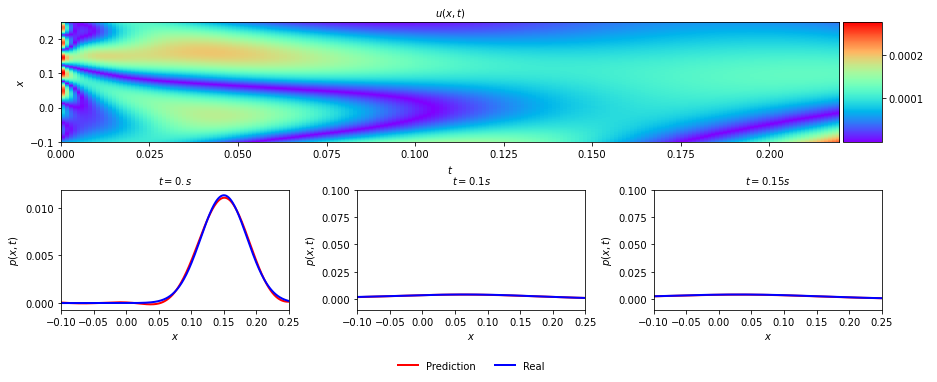

In [45]:
PINN.set_weights(results.x)
p_pred = PINN.evaluate(X_p_test)
p_pred = np.reshape(p_pred,(350, 200),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
differenceplot(p_pred ,real.T ,X_p_test)

In [40]:
from sklearn.metrics import mean_squared_error
def accuracy(numerical, predicted):
    return mean_squared_error(numerical.flatten(), predicted.flatten())

accuracy(p_pred/np.sum(p_pred[0]) ,real.T/np.sum(real.T[0]))

7.662446190901367e-08

In [36]:
def solutionplot(p_pred,X_p_train):#,p_train):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.05, bottom=1-1/3, left=0.1, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(p_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    #ax.plot(X_p_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    #line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    ax.axvline(x=t_upper, color="red")

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$p(x,t)$', fontsize = 10)

    
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1/2, bottom=0.05, left=0.2, right=0.8, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title(f'$t = {t[0]}s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([x_lower - 0.1 ,x_upper + 0.1])
    ax.set_ylim([0,1.0])

    ax = plt.subplot(gs1[0, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[50,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([x_lower - 0.1 ,x_upper + 0.1])
    ax.set_ylim([0,1.0])
    #ax.set_title(f'$t = {t[int(t/2)]}s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[75,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')
    ax.axis('square')
    ax.set_xlim([x_lower - 0.1 ,x_upper + 0.1])
    ax.set_ylim([0,1.0])    
    ax.set_title(f'$t = {t[-1]}s$', fontsize = 10)
    
    plt.tight_layout()
    #plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)
    

### Predictions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\maxxd\AppData\Local\Temp\ipykernel_44360\328454316.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


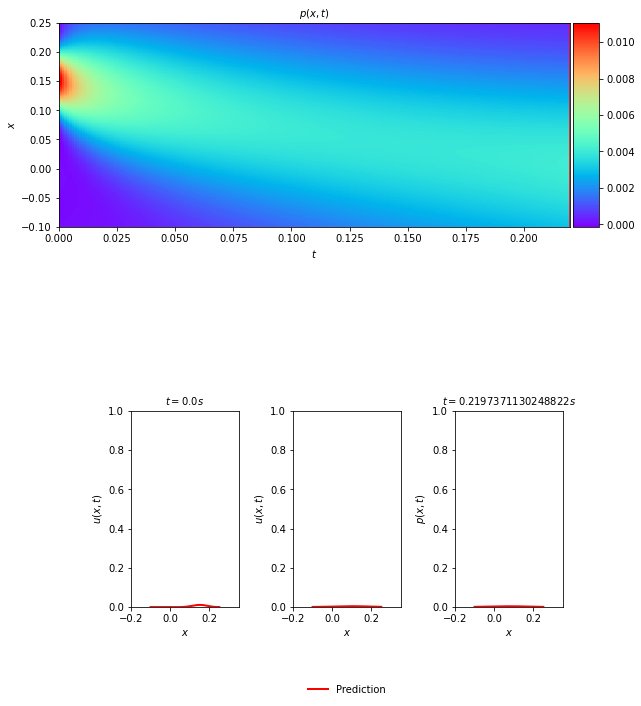

In [42]:
'''x_lower = -0.1
x_upper = 0.25
x = np.linspace(x_lower, x_upper, 256)
t_lower = 0
t_upper = 1
t = np.linspace(t_lower, t_upper, 1000)
psol=np.zeros((256,1000)) #NOT COMPUTED YET
psol[:,0]=norm.pdf(x,0.5,0.05).T #INITIAL CONDITION'''

#collocation points for every position and every time
#X, T = np.meshgrid(x,t)
#X_p_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
p_pred = PINN.evaluate(X_p_test)


p_pred = np.reshape(p_pred,(350,200),order='F')
solutionplot(p_pred, X_p_test)

In [43]:
save_model_weights(PINN)
save_train_history(PINN)

Saving ./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...
Saving ./data/TRAIN_HISTORY_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...


In [ ]:
import pandas as pd
data_filename = # PUT PERTINENT TRAIN_HISTORY HERE
plt.style.use("dark_background")
plt.figure(figsize=(10,8))
plt.title("Training Loss")
df = pd.read_csv(data_filename)
plt.plot(df["epoch"], df["Total loss"], label="Total Loss")
plt.plot(df["epoch"], df["BC loss"], label="$MSE_{bc}$")
plt.plot(df["epoch"], df["f loss"], label="$MSE_f$")
plt.plot(df["epoch"], df["IC loss"], label="$MSE_{ic}$")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Training Norm Loss (not trained for)")
#plt.plot(df["epoch"], df["Pr loss"], label = "Probability Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df["epoch"], df["Norm loss"], label = "Norm Loss")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Probability Loss (not trained for)")
plt.plot(df["epoch"], df["Pr loss"], label = "Probability Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.ylim((10 ** -14, 10 ** 1))
plt.legend()
plt.show()